In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
import os

In [56]:
### Environment
class PongEnv(gym.Env):
    def __init__(self, render_mode=None):
        # Define action and observation space
        self.action_space = gym.spaces.Discrete(2)  # Move up or down
        # The x and y position and velocity of the ball
        self.observation_space = gym.spaces.Box(low=np.array([0, 0, -5, -5]), high=np.array([100, 100, 5, 5]), shape=(4,))
        
        self.reset()
    
    def _get_obs(self):
        return np.concatenate([self.ball_pos, self.ball_velocity])

    def reset(self, **kwargs):

        # Create a clean state
        self.terminated = False
        self.truncated = False
        self.total_steps = 0

        # Reset ball
        self.ball_pos = np.array([50, 50])
        # Set random velocity 
        self.ball_velocity = np.random.rand(-5,)
        
        # Reset paddles
        self.player_paddle_pos = np.array([0, 50])
        self.opponent_paddle_pos = np.array([100, 50])

        return self._get_obs(), {'message': 'reset'}


    def step(self, action):
        self.total_steps += 1
        self.reward = 0
        self.truncated = False
        self.terminated = False
        message = "ongoing"
        
        # Update ball
        self.ball_pos += self.ball_velocity
        
        # Update paddle
        self.player_paddle_pos[1] += (2 if action == 0 else -2)
        if self.player_paddle_pos[1] >= 100:
            self.player_paddle_pos[1] = 100
        if self.player_paddle_pos[1] <= 0:
            self.player_paddle_pos[1] = 0            
        
        # Update opponent
        if self.opponent_paddle_pos[1] < self.ball_pos[1] and self.ball_velocity[1] > 0:
            self.opponent_paddle_pos[1] += 4
        elif self.opponent_paddle_pos[1] > self.ball_pos[1] and self.ball_velocity[1] < 0:
            self.opponent_paddle_pos[1] -= 4
        
         # Handle collisions
        if self.ball_pos[1] >= 100 or self.ball_pos[1] <= 0:
            self.ball_velocity[1] *= -1
            
        if self.ball_pos[0] >= 100:
            if np.abs(self.ball_pos[1] - self.opponent_paddle_pos[1]) <= 10:
                self.ball_velocity[0] *= -1
            else:
                self.terminated = True
                self.reward = 1
                message = "success"
                
        if self.ball_pos[0] <= 0:
            if np.abs(self.ball_pos[1] - self.player_paddle_pos[1]) <= 10:
                self.ball_velocity[0] *= -1
            else:
                self.terminated = True
                self.reward = -1
                message = "fail"                
                        
        return self._get_obs(), self.reward, self.terminated, self.truncated, {'message': message}
    
    def render(self, mode="human", close=False):
        fig, ax = plt.subplots()

        player_paddle = plt.Rectangle( self.player_paddle_pos, 5, 10, fc='none', ec='black' )
        ax.add_patch(player_paddle)
        opponent_paddle = plt.Rectangle( np.array(self.opponent_paddle_pos) - np.array([5,0]), 5, 10, fc='none', ec='black' )
        ax.add_patch(opponent_paddle)

        circle = plt.Circle( self.ball_pos , radius=2, ec='k', fc='blue')
        ax.add_patch(circle)

        ax.set_xlim([0,100])
        ax.set_ylim([0,100])
        ax.set_aspect(1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.axis('off')
        plt.show()


In [57]:
def train_agent(time_steps):
    log_dir = 'logs'

     # Create environment
    env = PongEnv()

    # Train the model
    model = PPO("MlpPolicy", env, verbose=0)
    model.learn(total_timesteps=time_steps, progress_bar=True)
    
    return env, model

In [59]:
env, model = train_agent(time_steps = int(1e4))

Output()

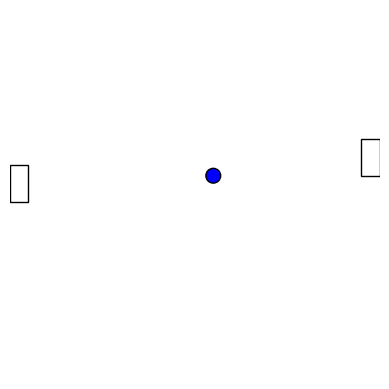

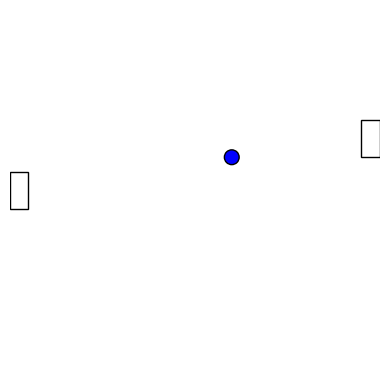

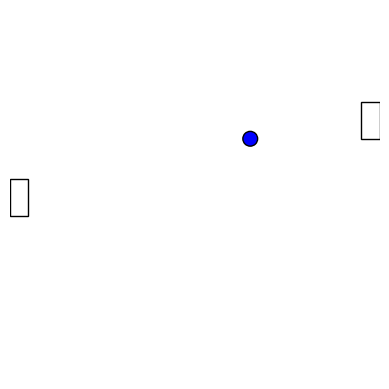

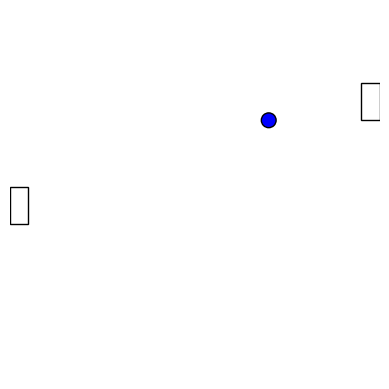

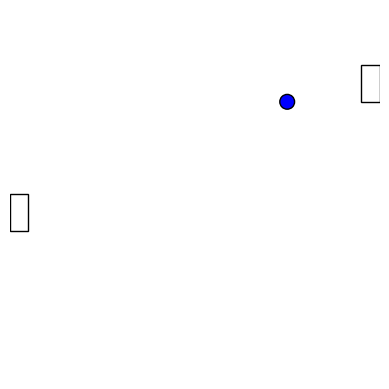

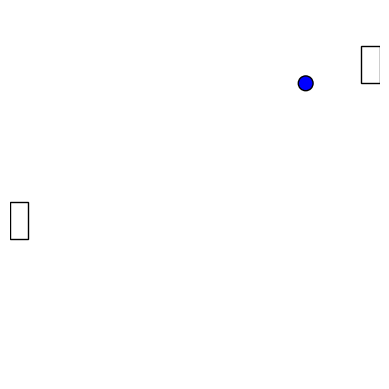

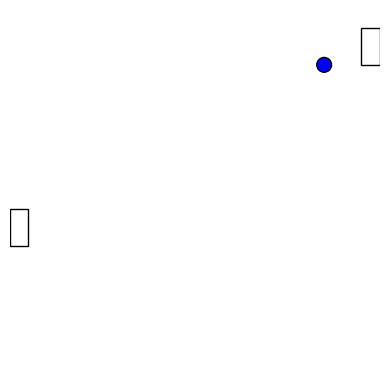

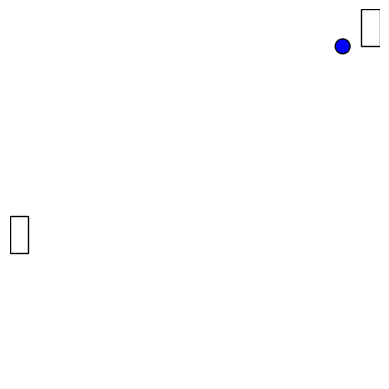

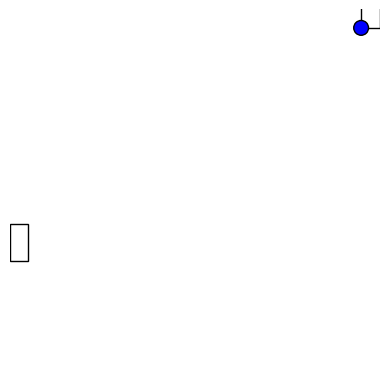

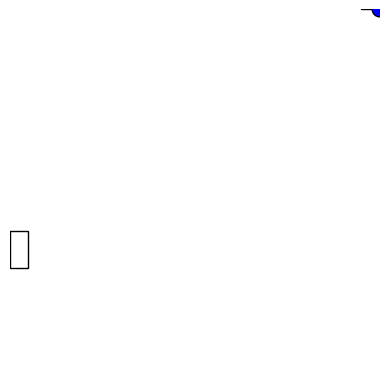

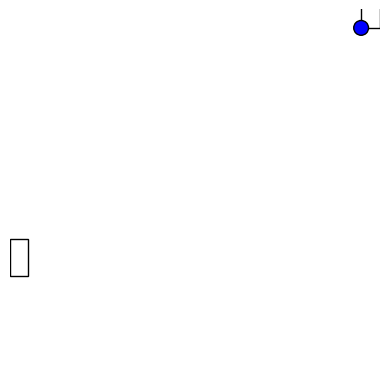

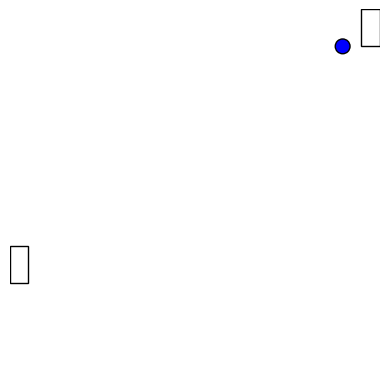

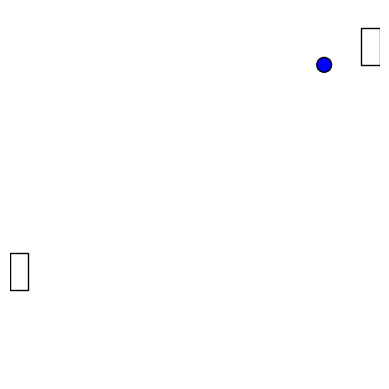

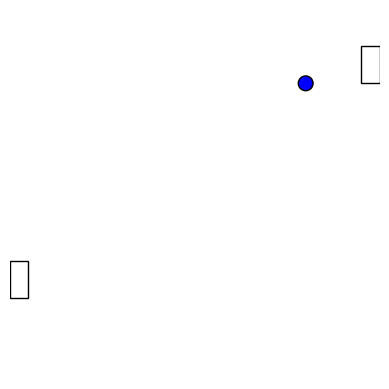

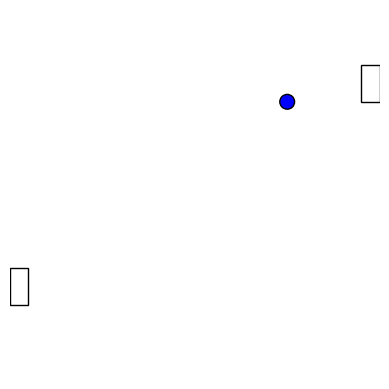

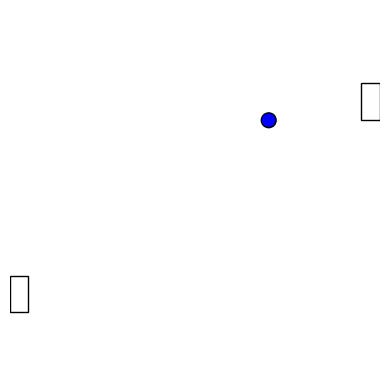

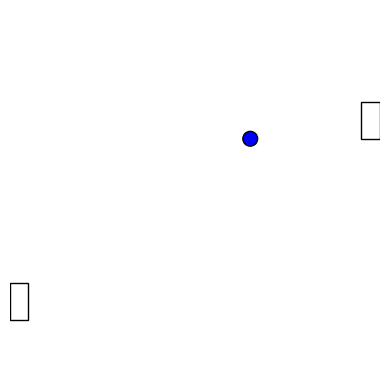

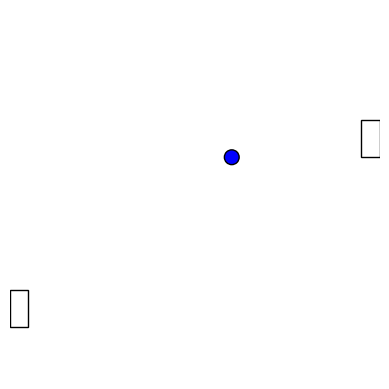

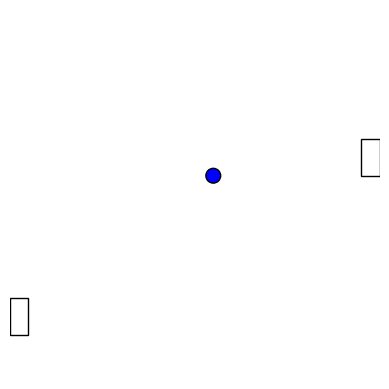

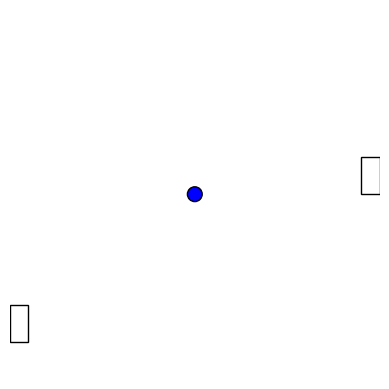

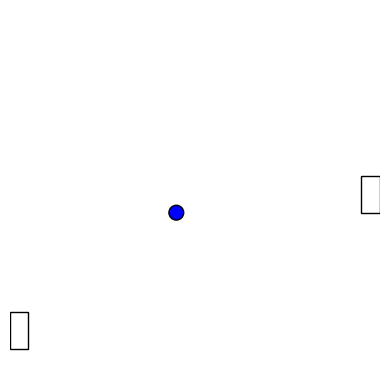

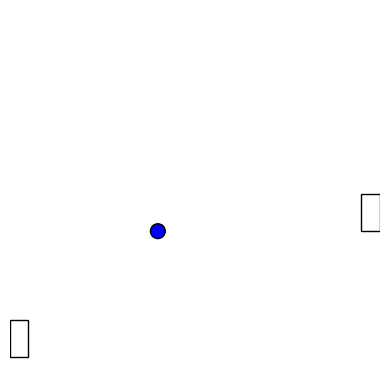

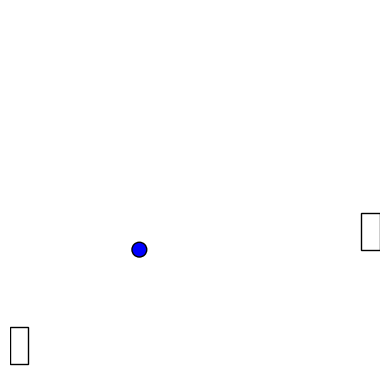

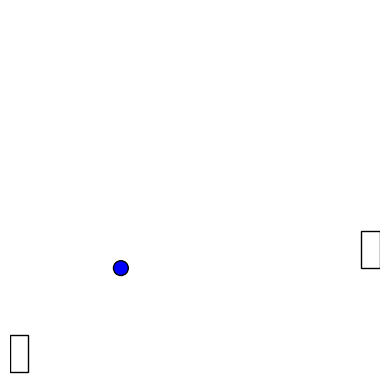

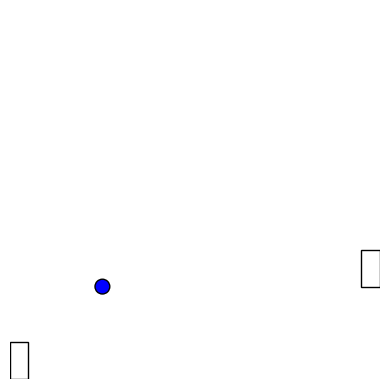

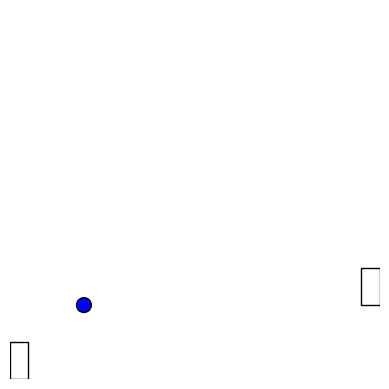

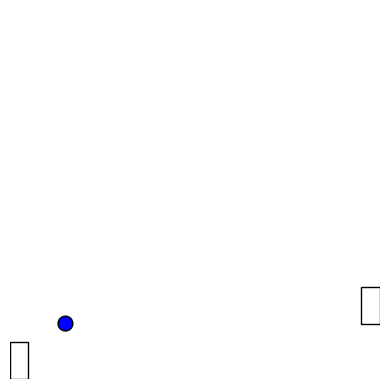

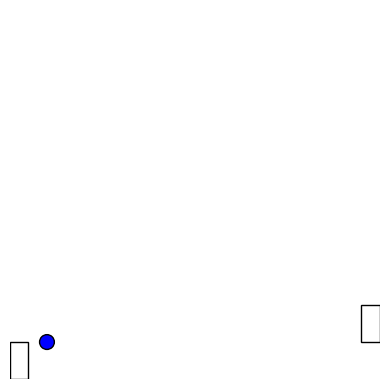

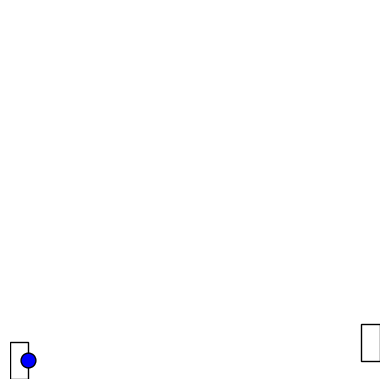

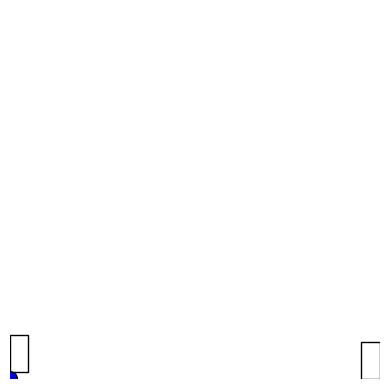

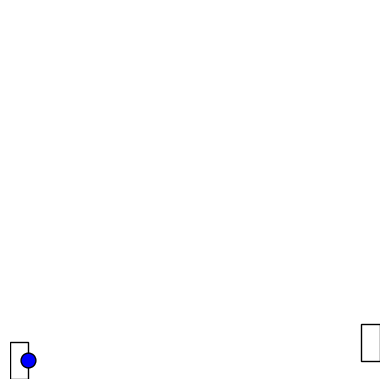

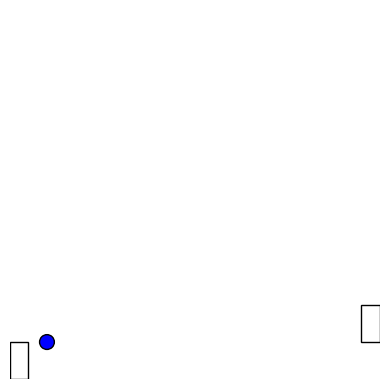

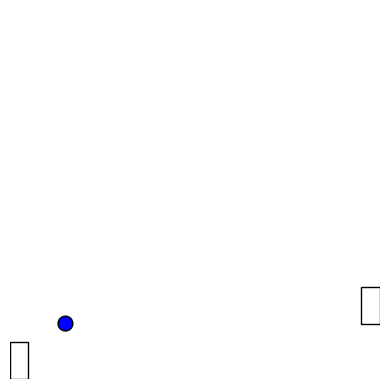

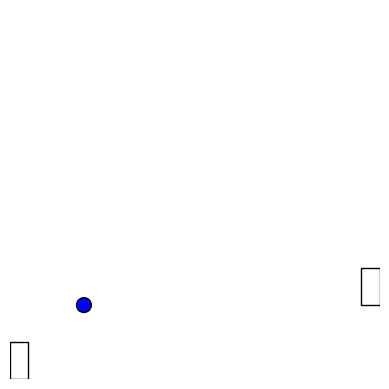

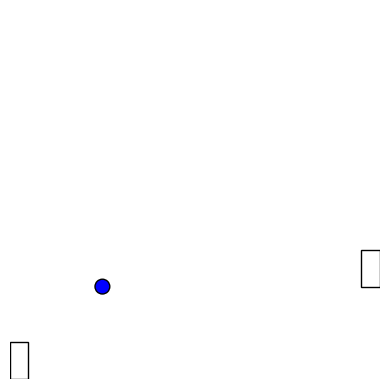

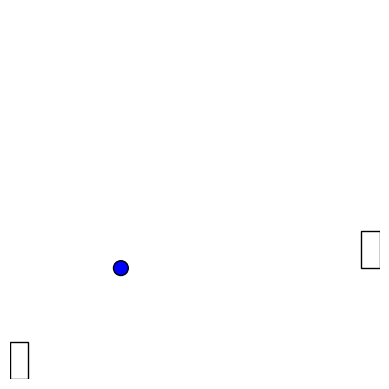

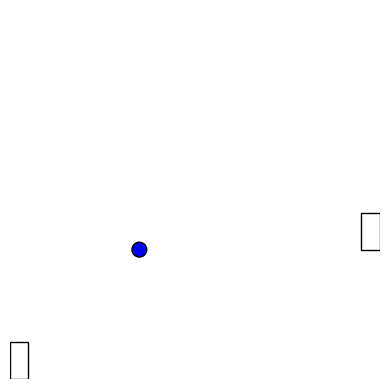

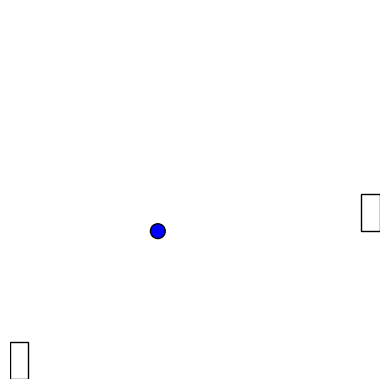

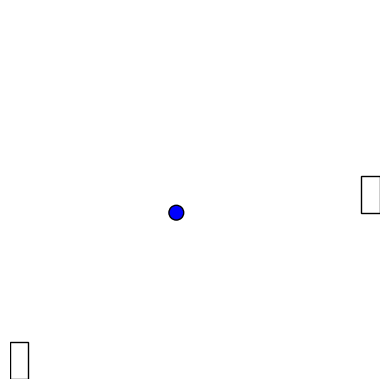

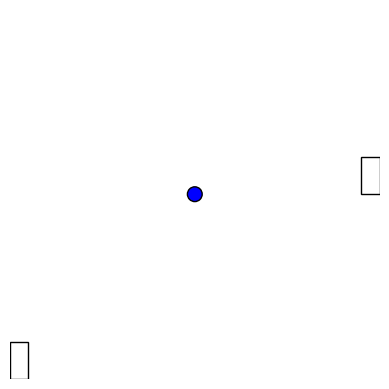

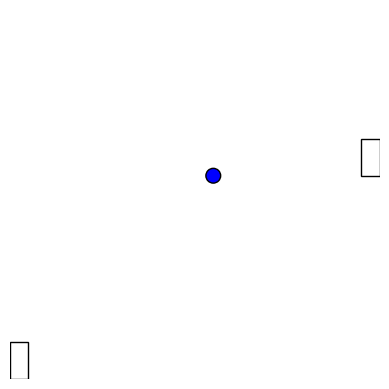

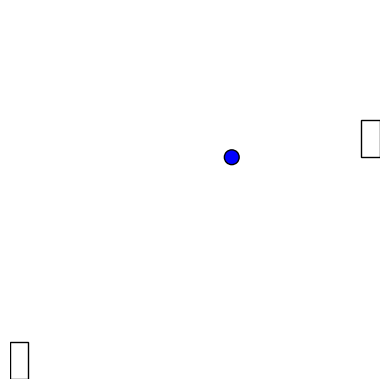

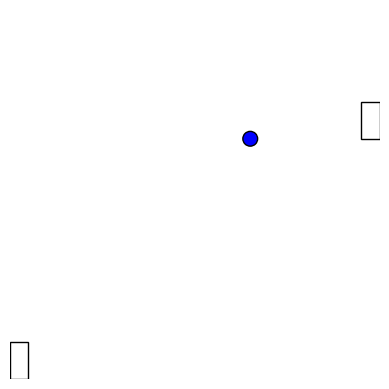

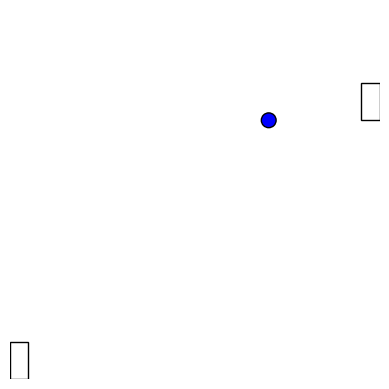

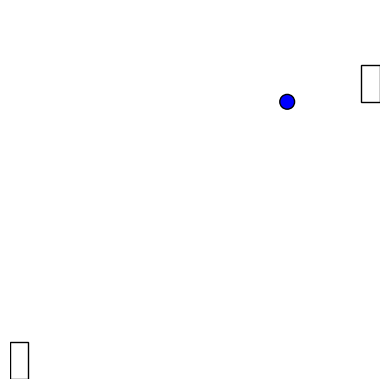

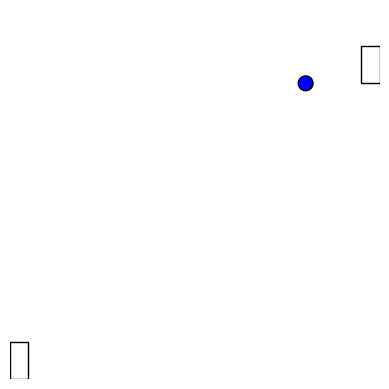

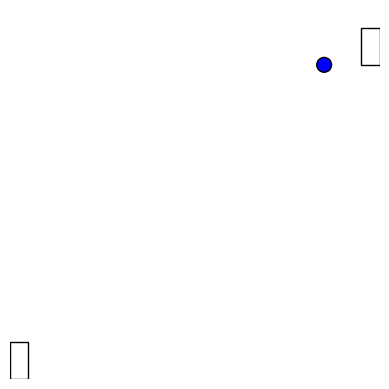

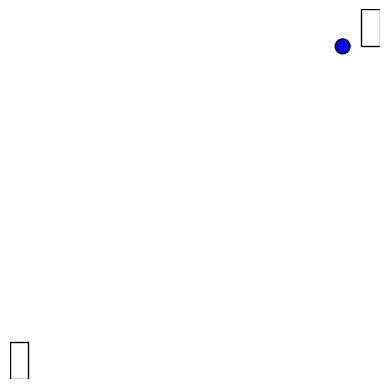

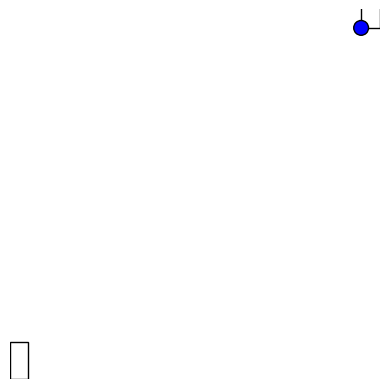

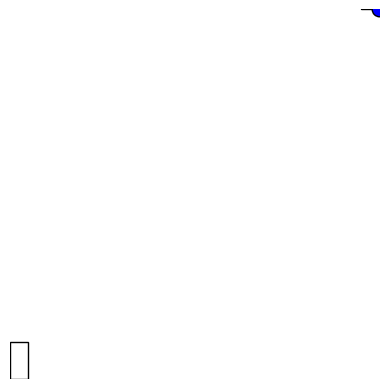

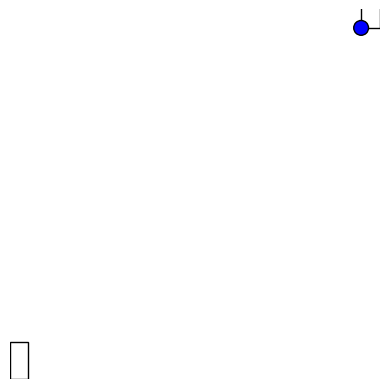

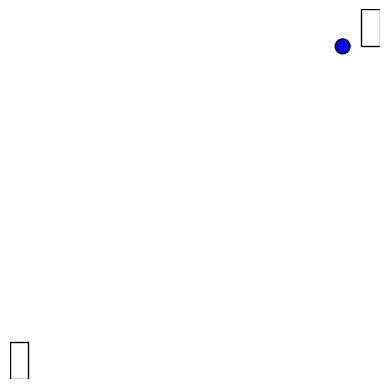

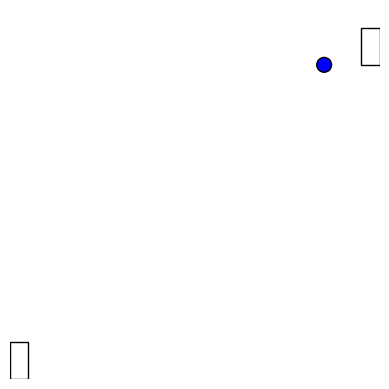

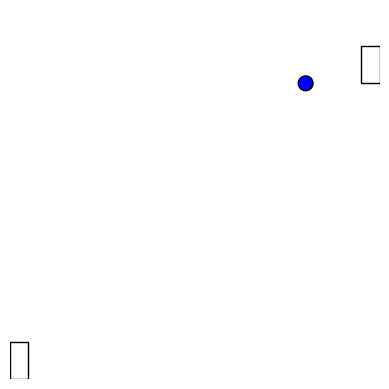

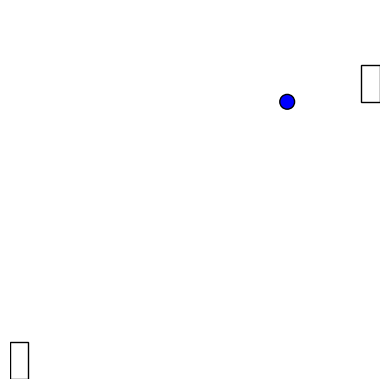

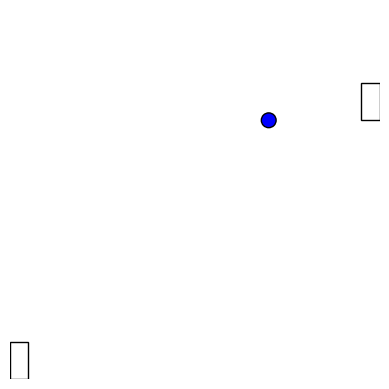

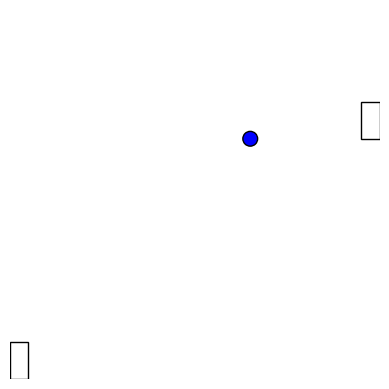

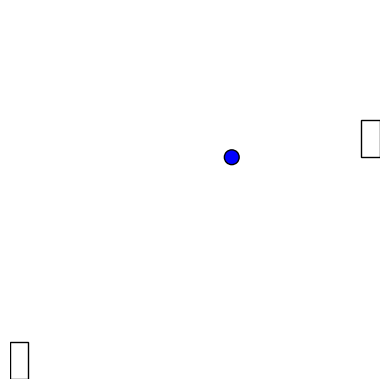

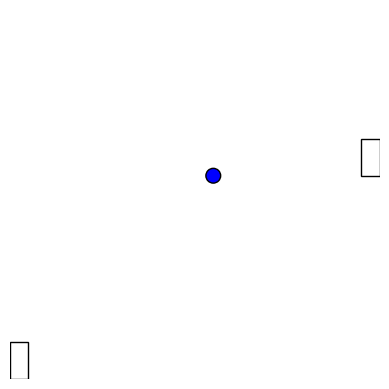

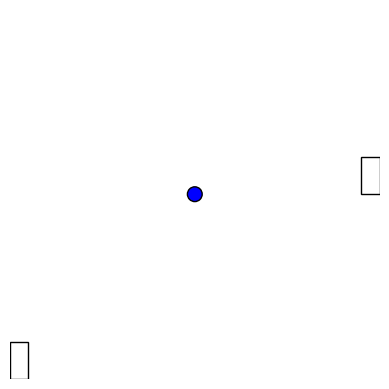

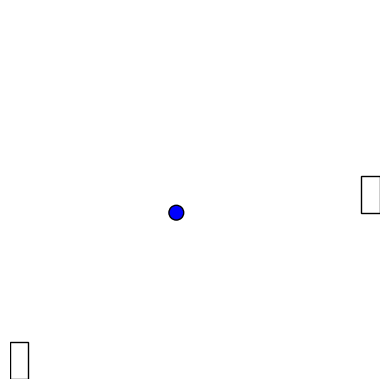

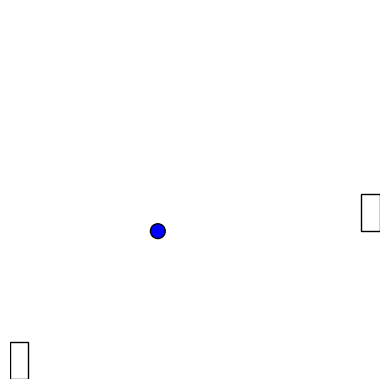

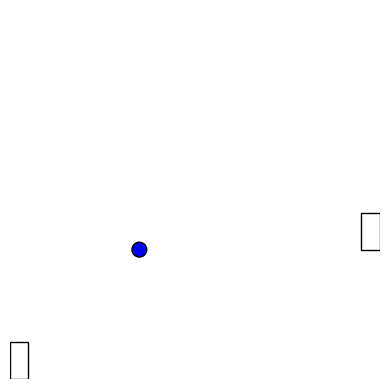

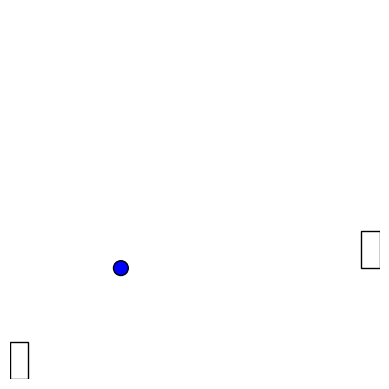

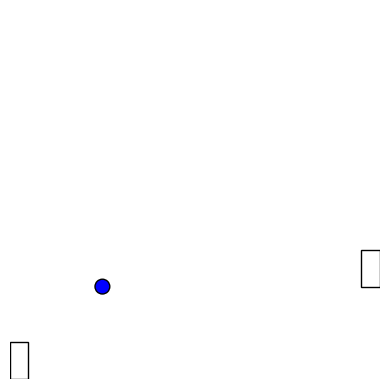

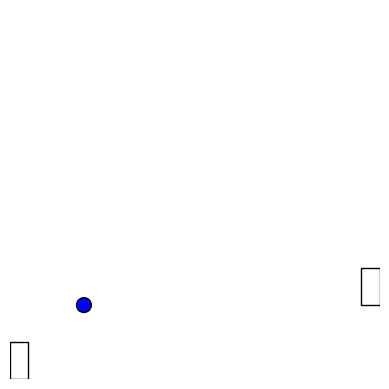

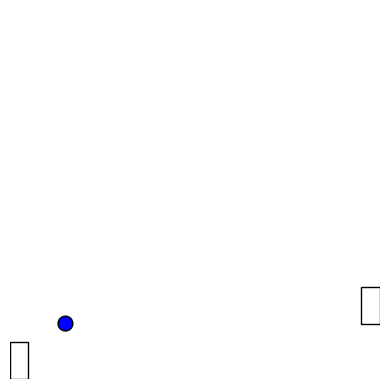

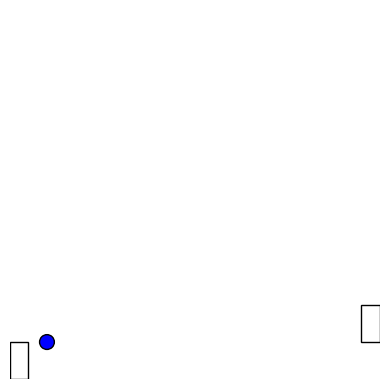

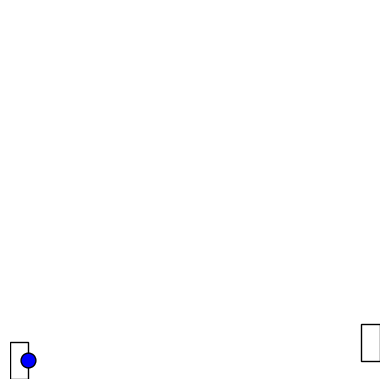

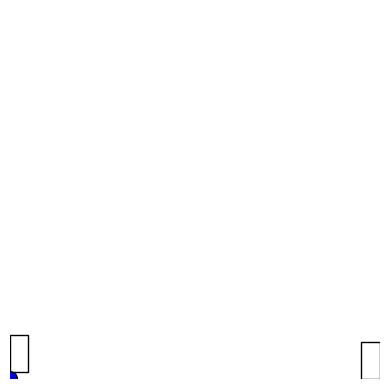

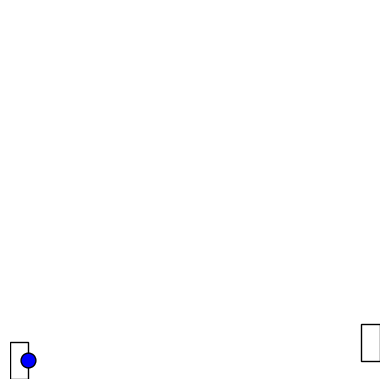

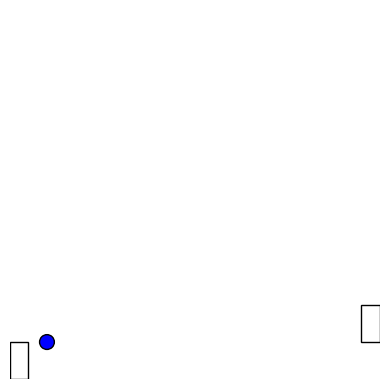

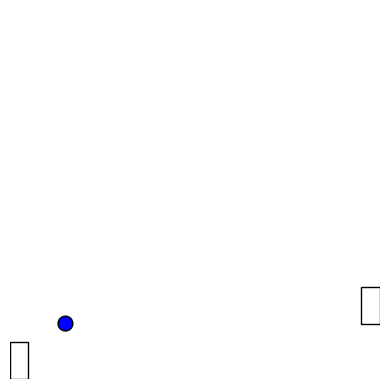

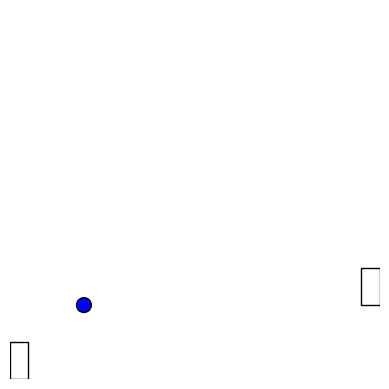

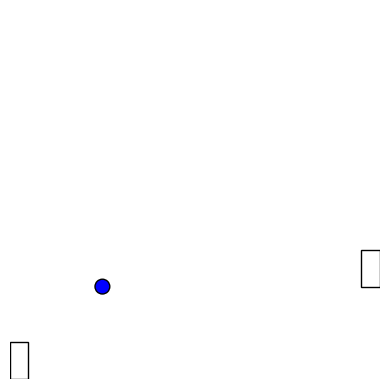

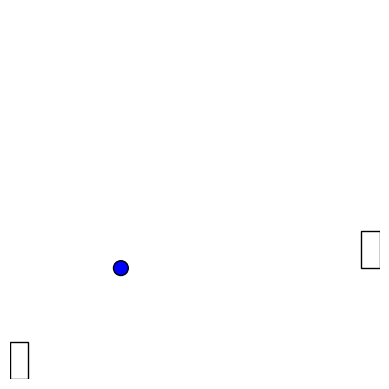

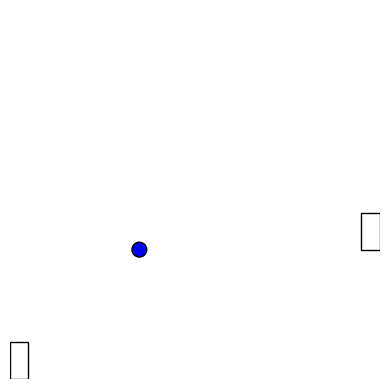

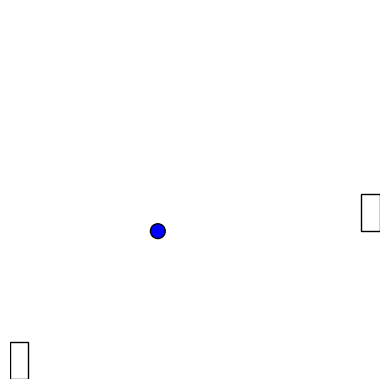

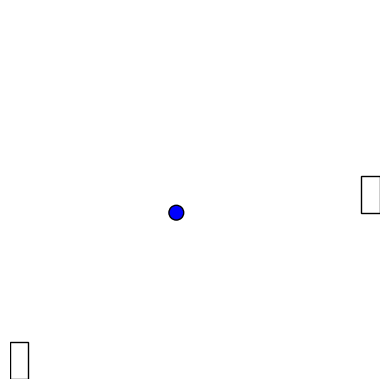

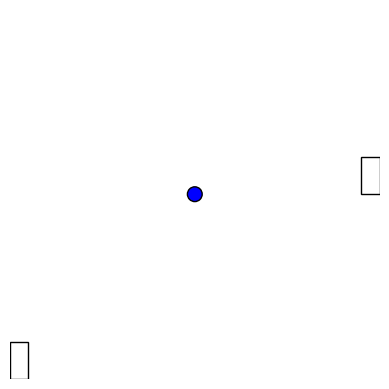

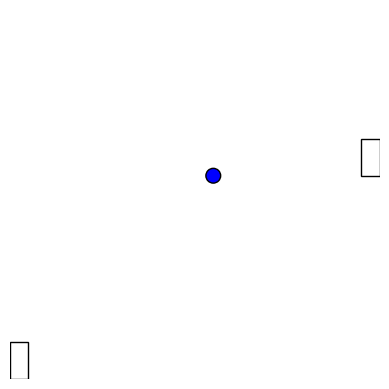

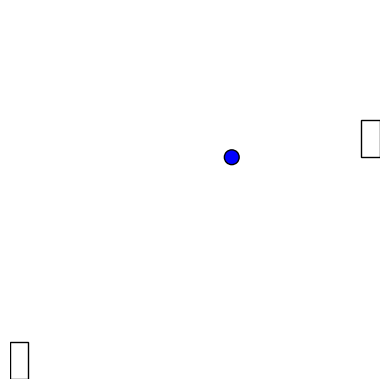

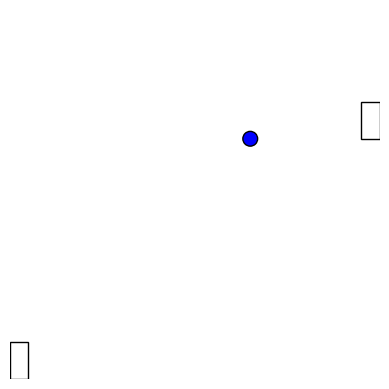

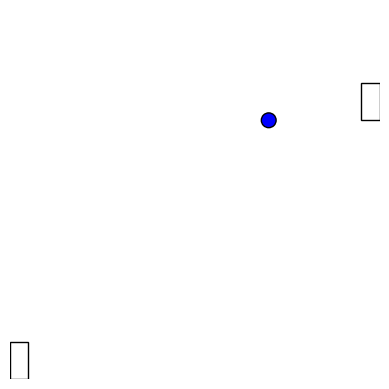

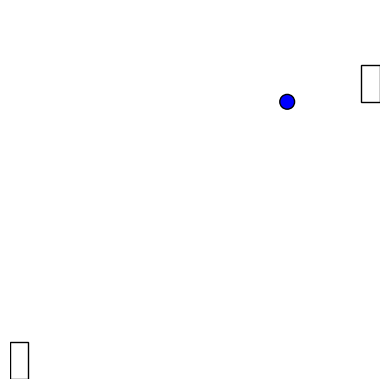

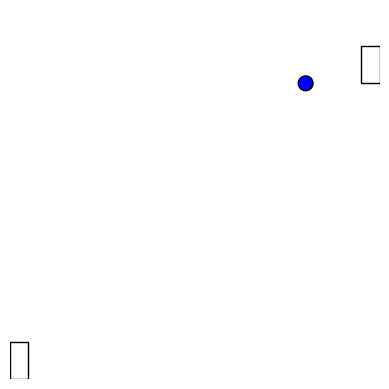

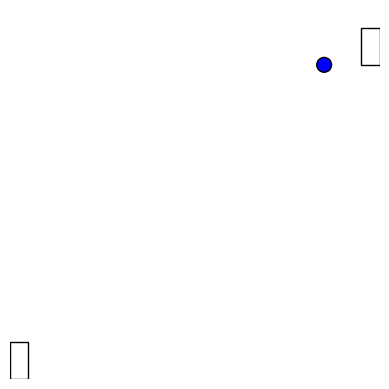

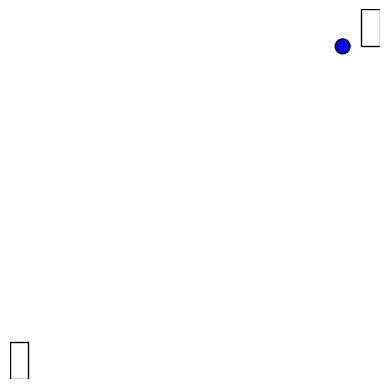

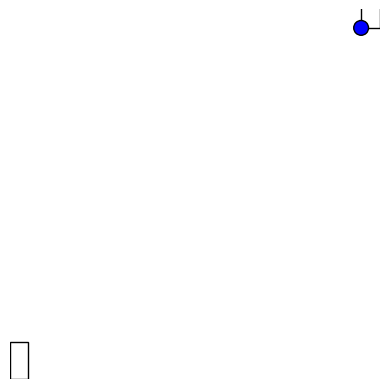

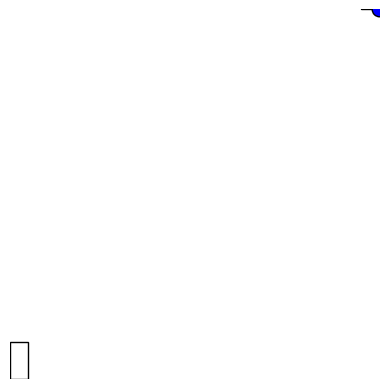

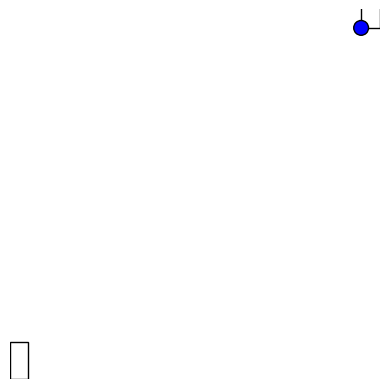

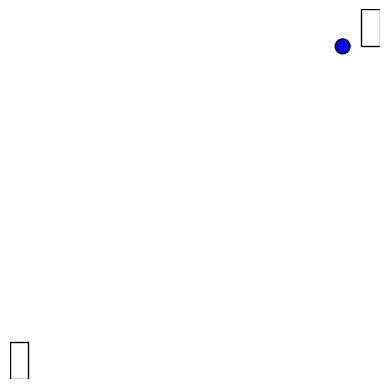

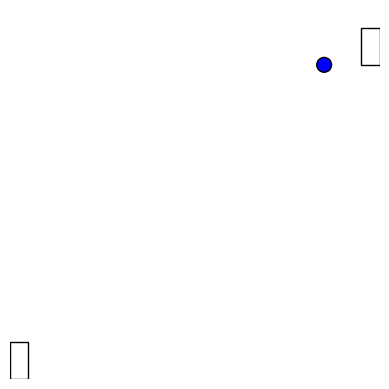

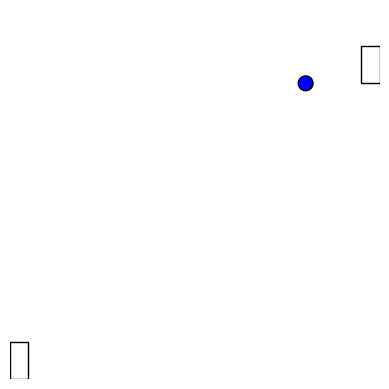

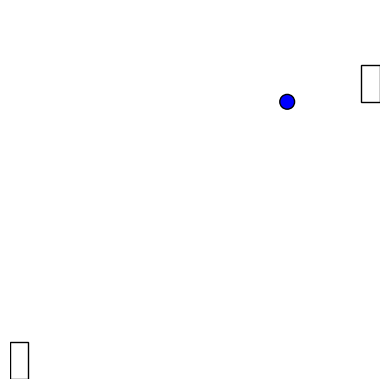

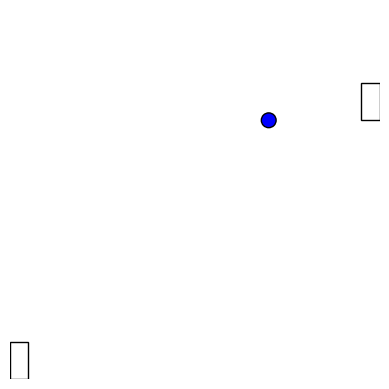

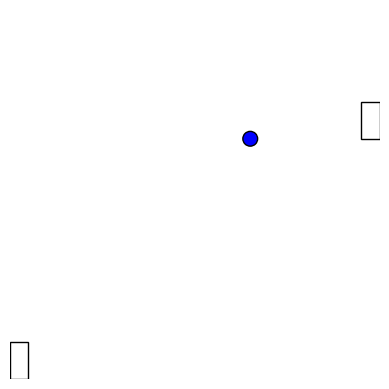

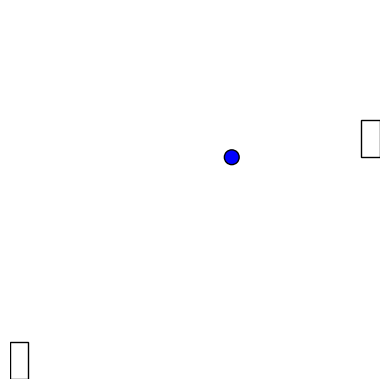

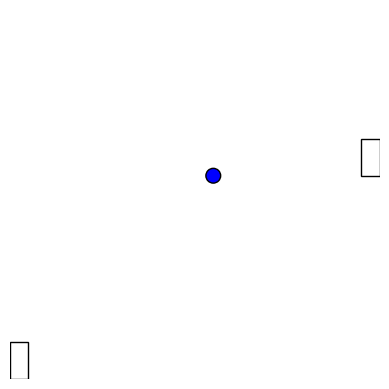

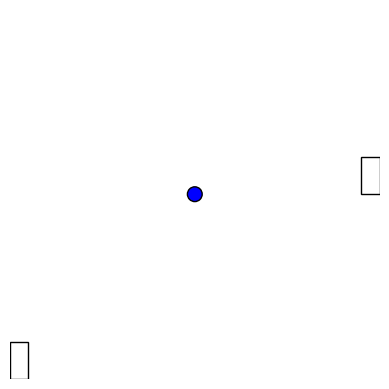

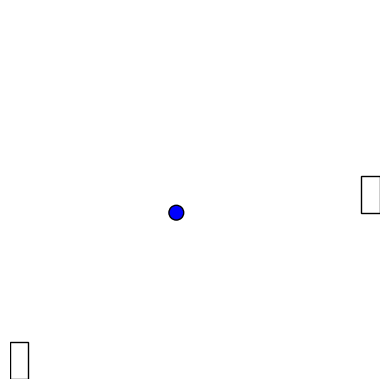

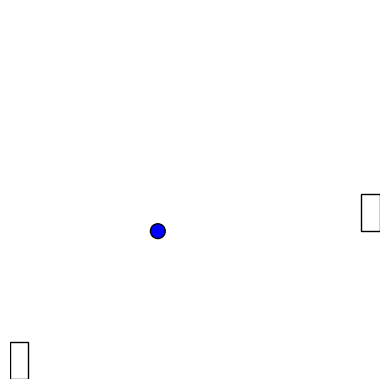

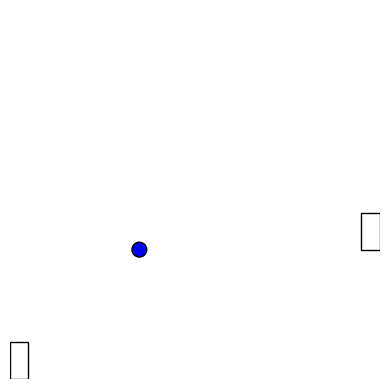

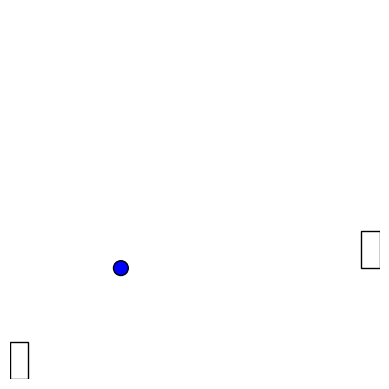

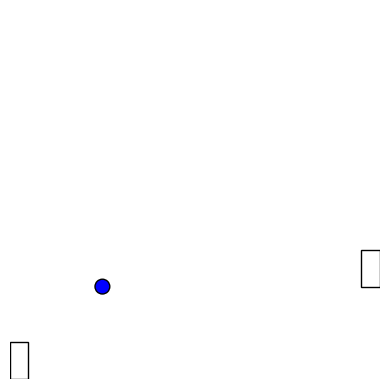

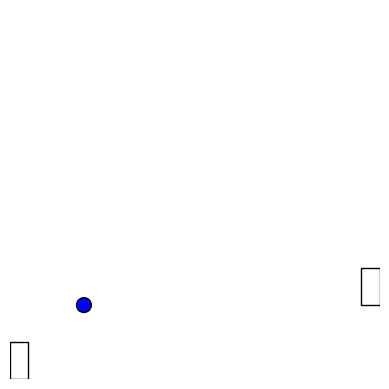

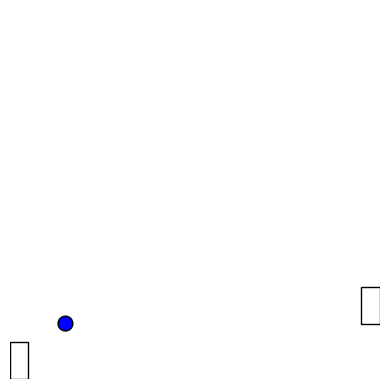

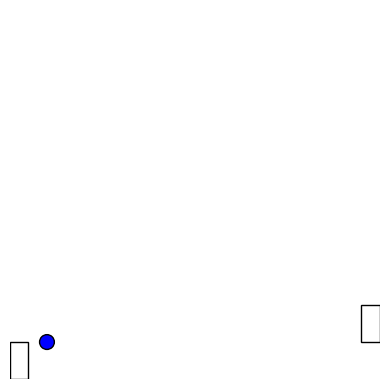

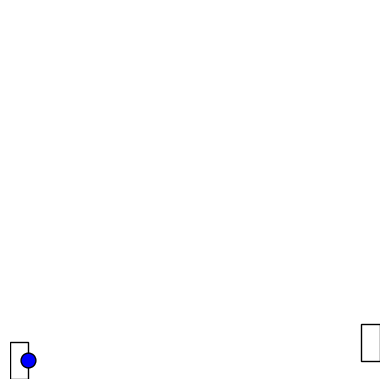

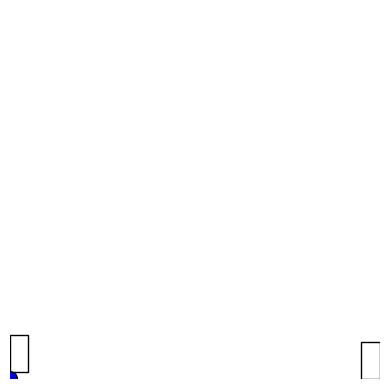

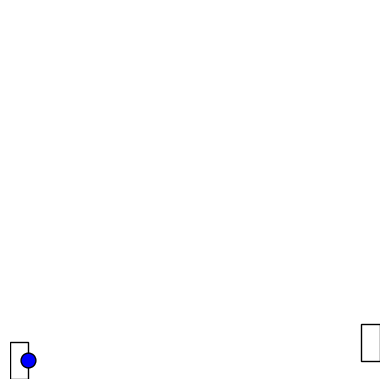

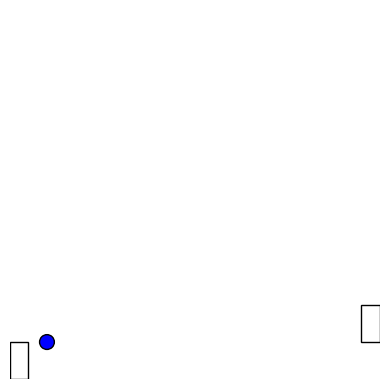

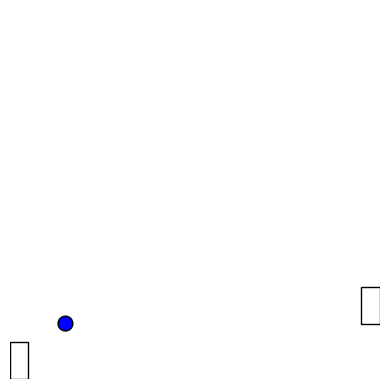

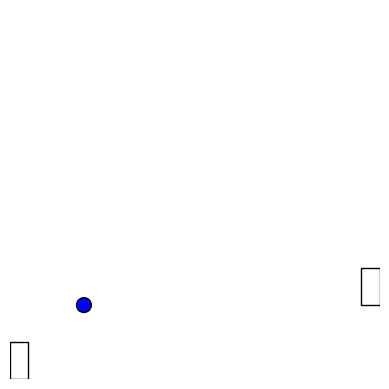

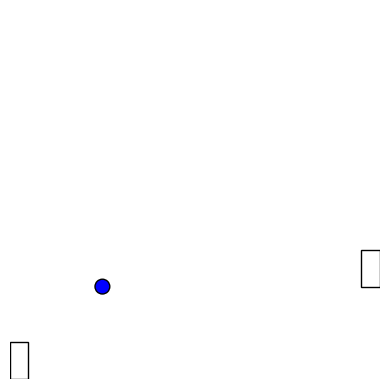

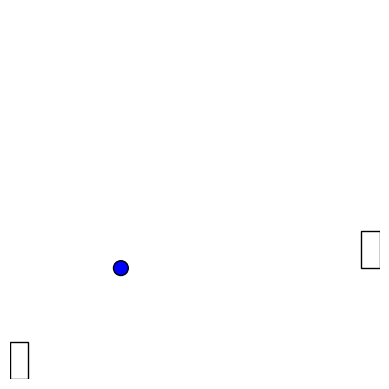

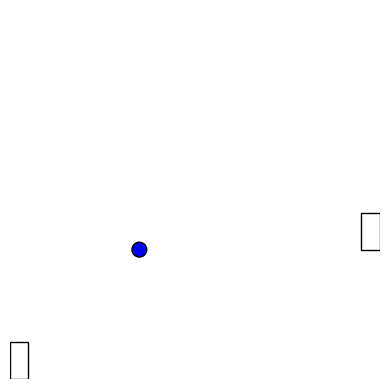

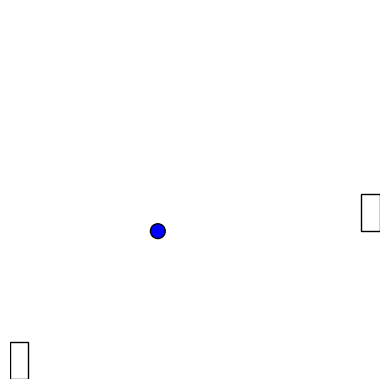

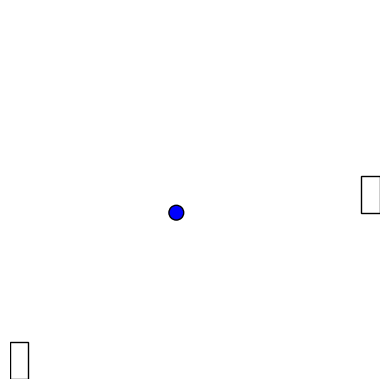

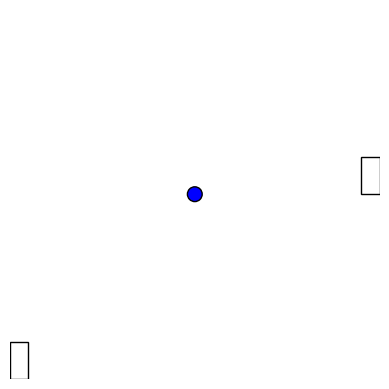

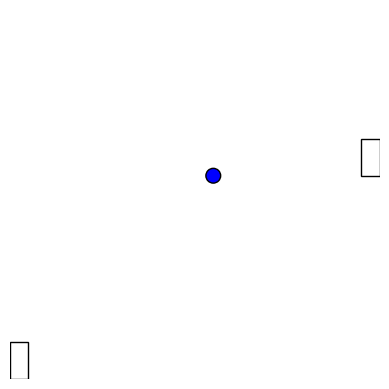

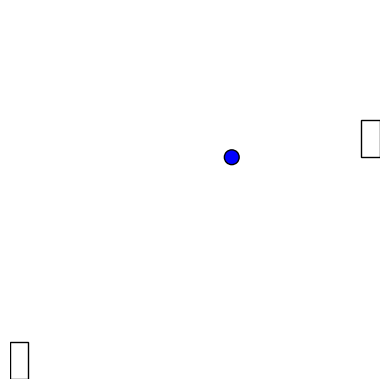

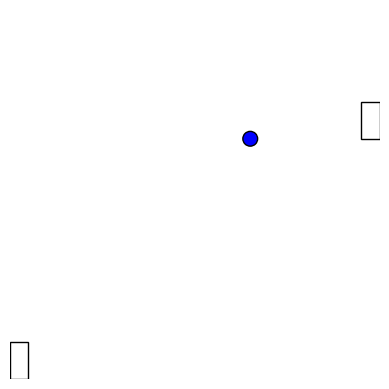

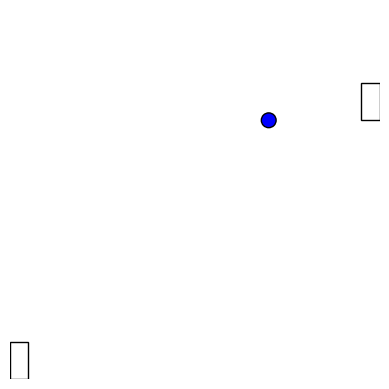

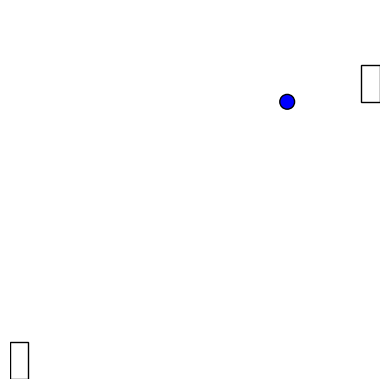

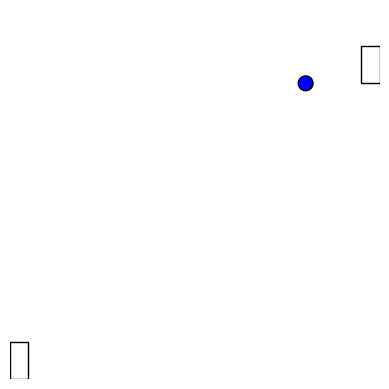

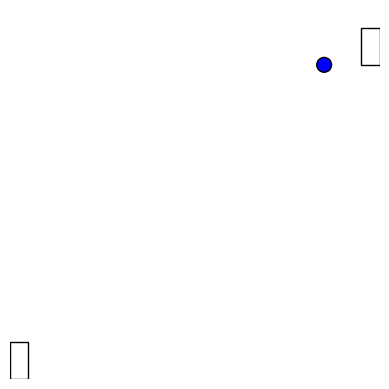

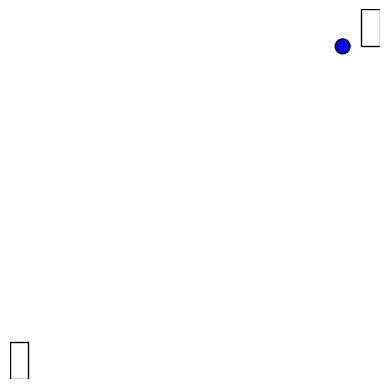

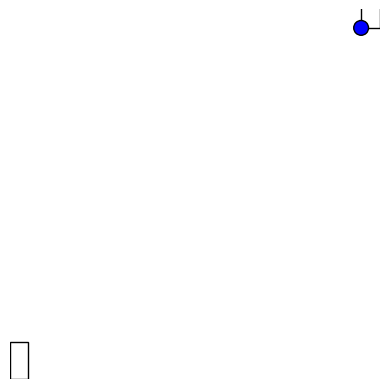

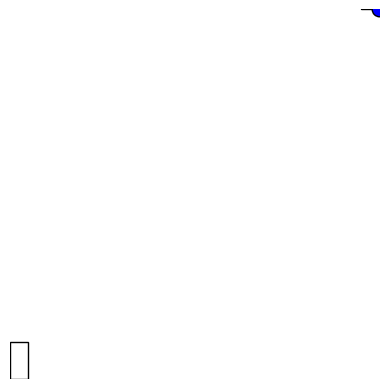

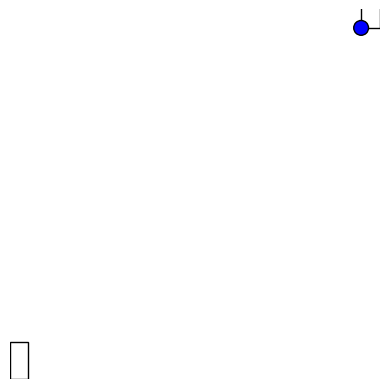

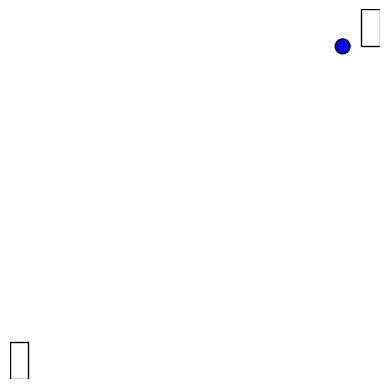

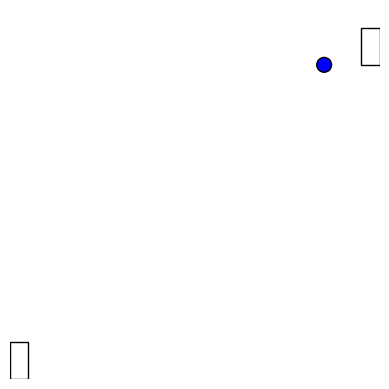

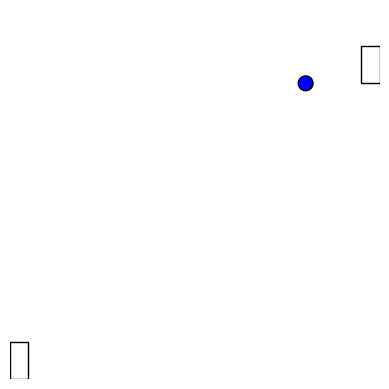

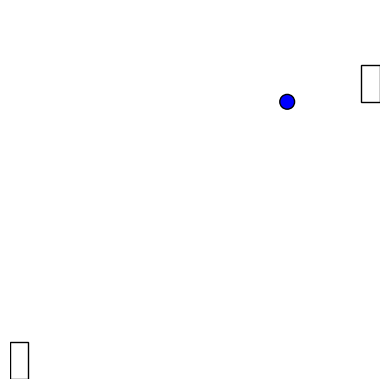

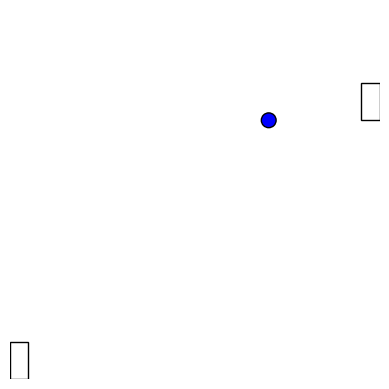

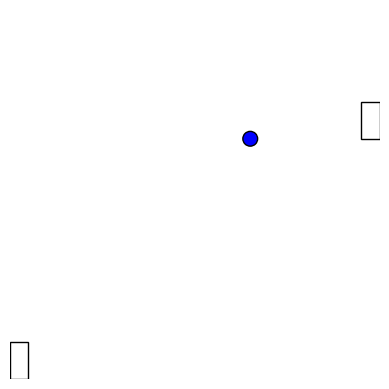

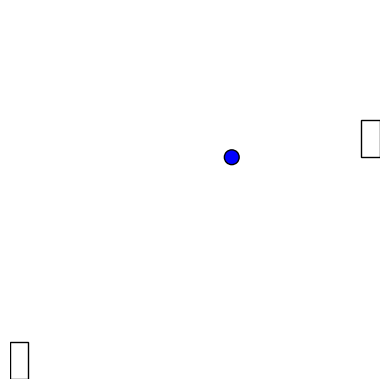

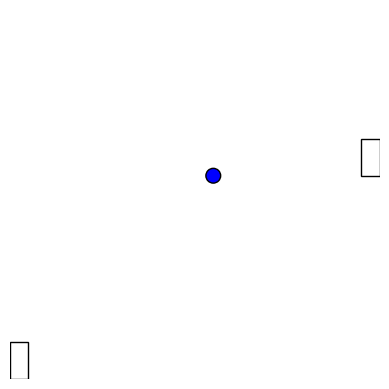

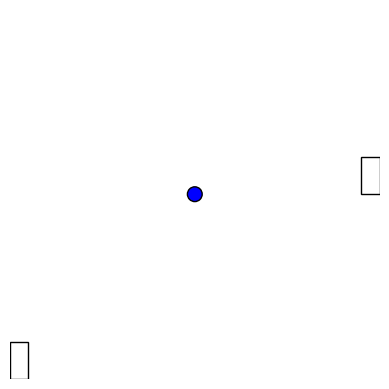

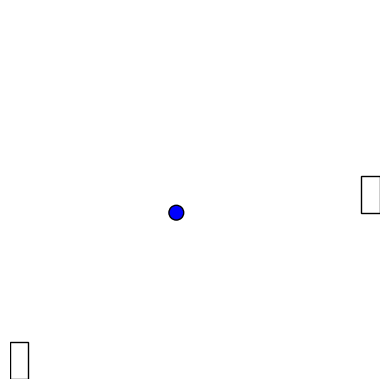

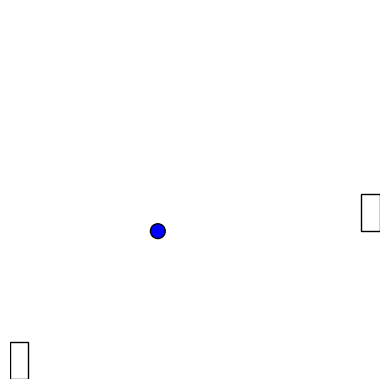

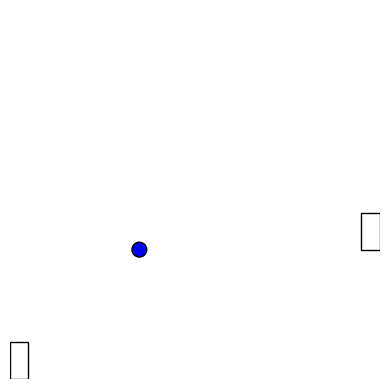

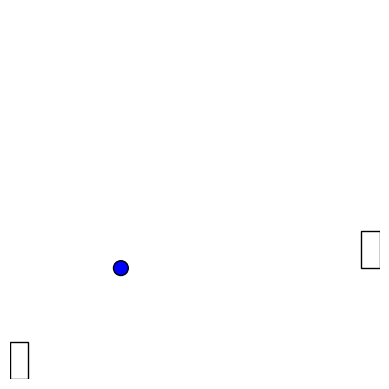

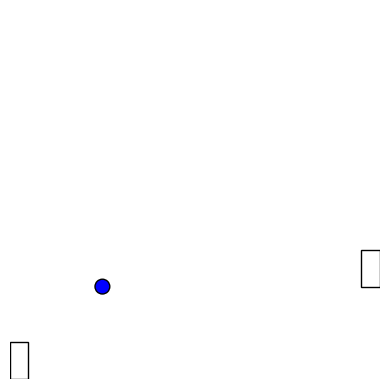

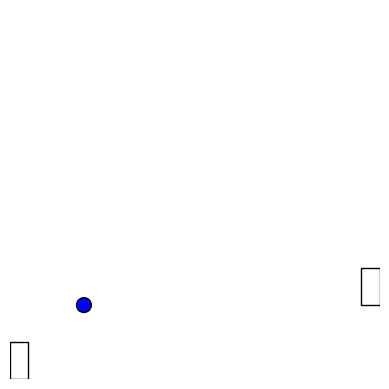

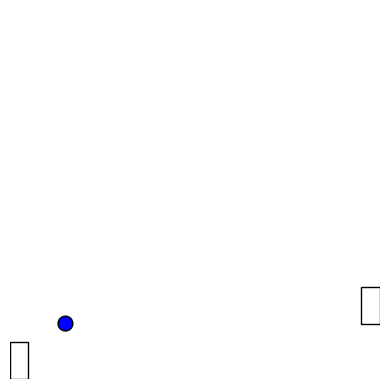

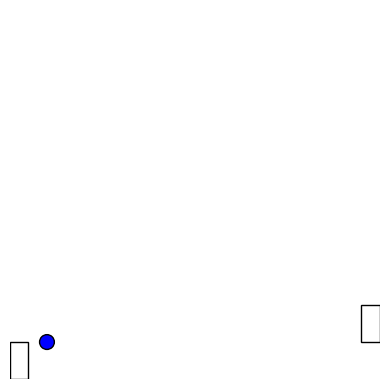

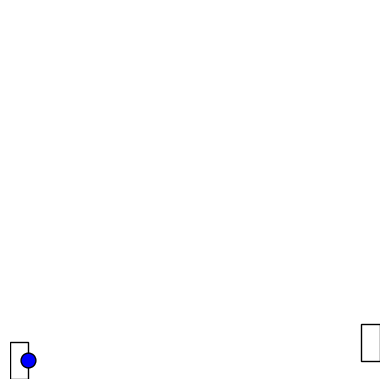

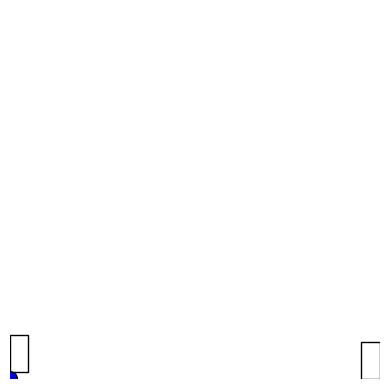

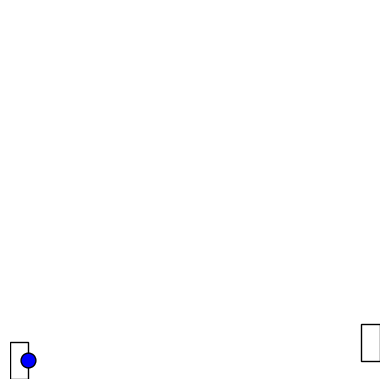

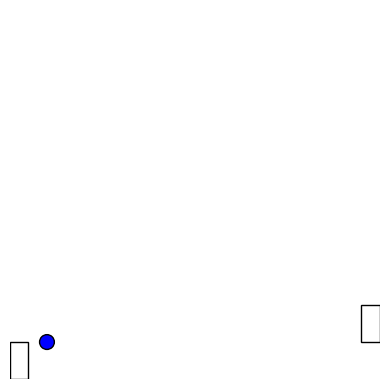

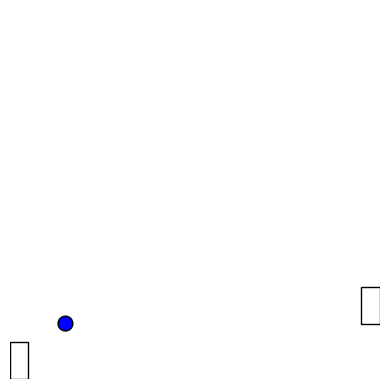

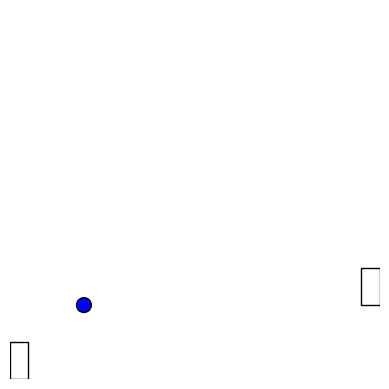

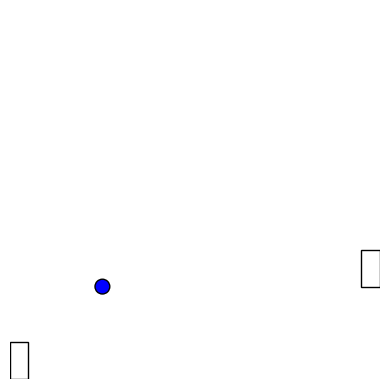

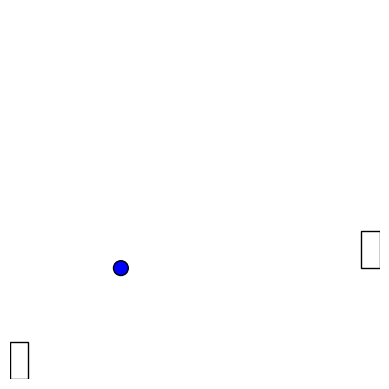

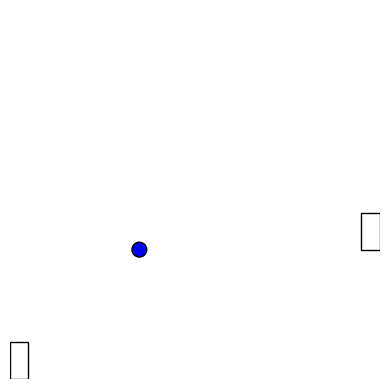

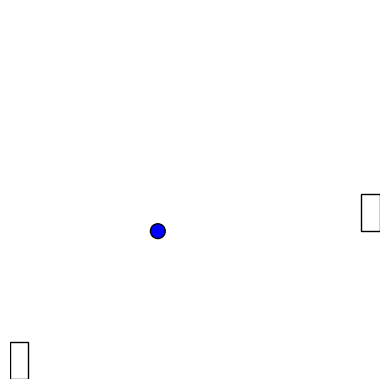

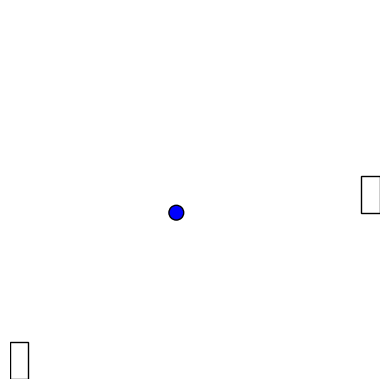

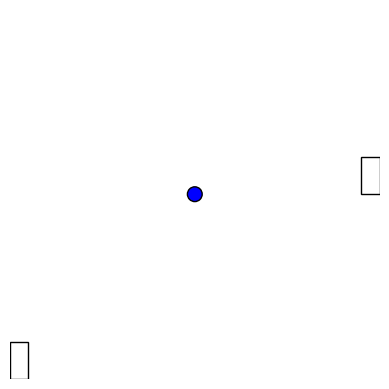

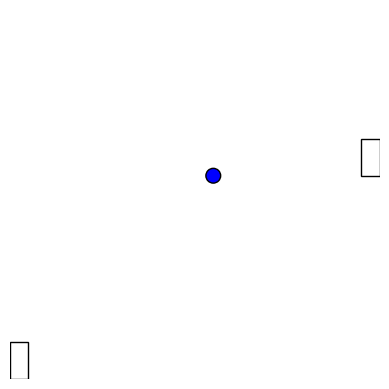

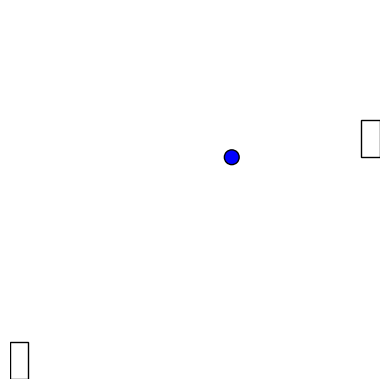

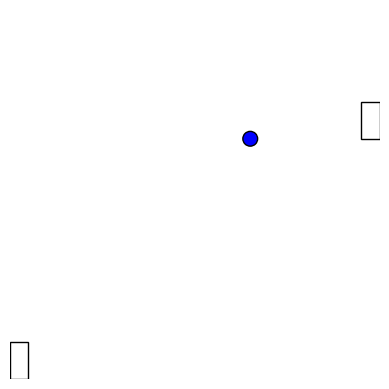

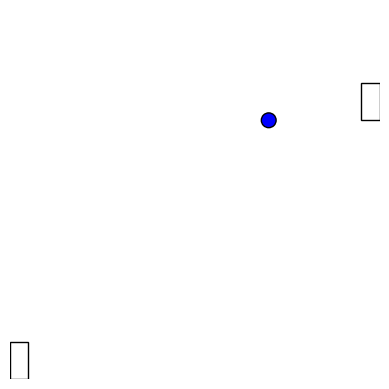

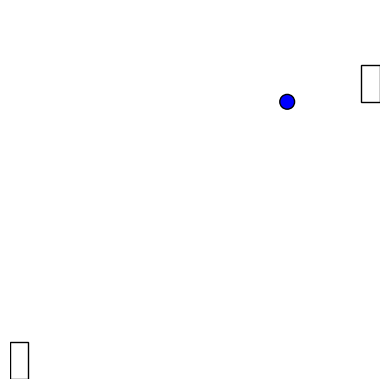

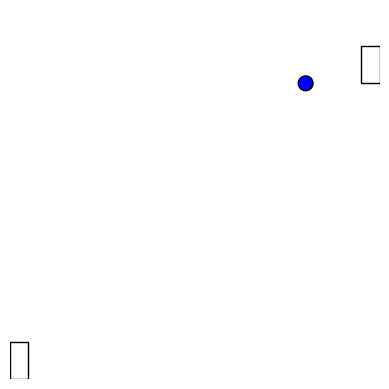

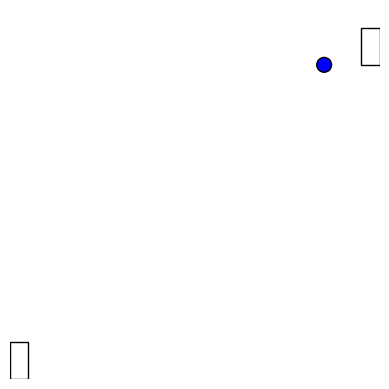

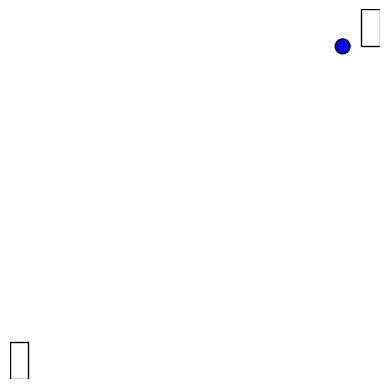

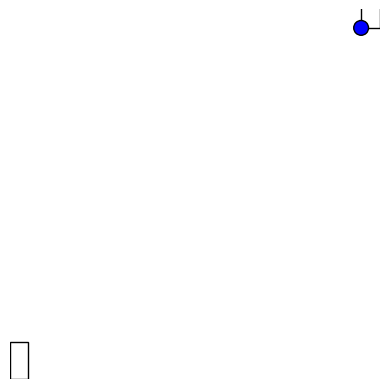

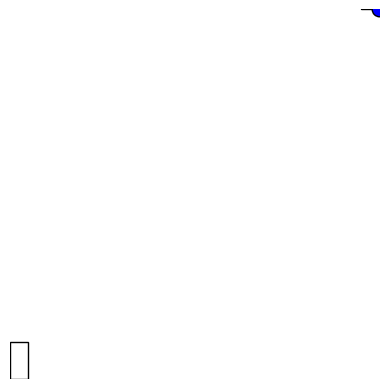

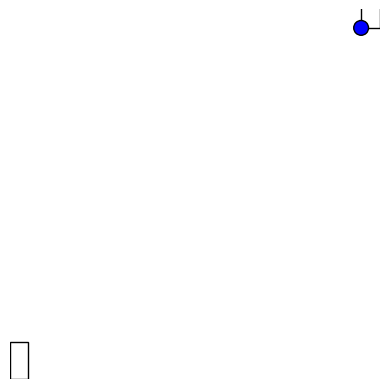

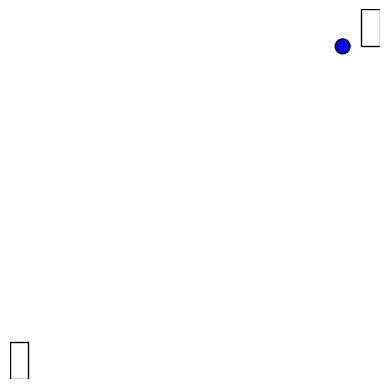

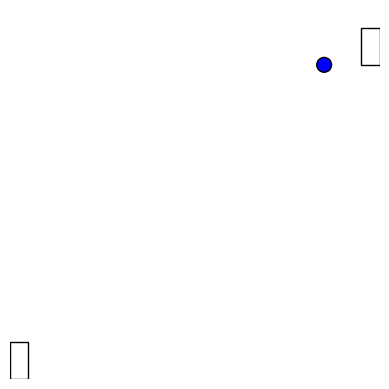

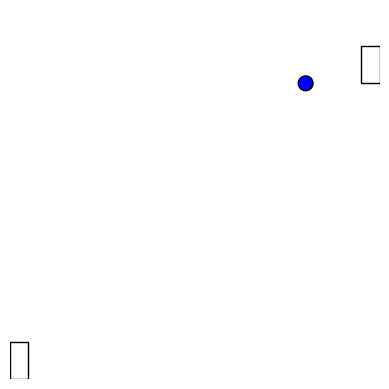

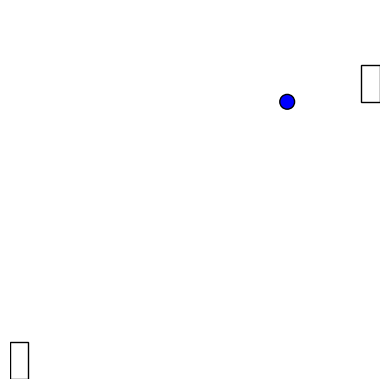

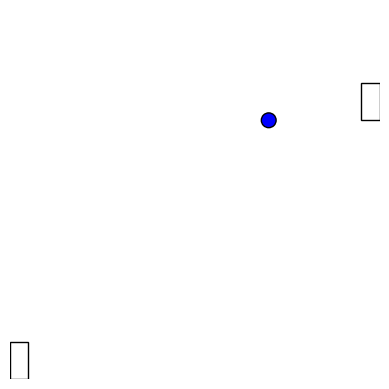

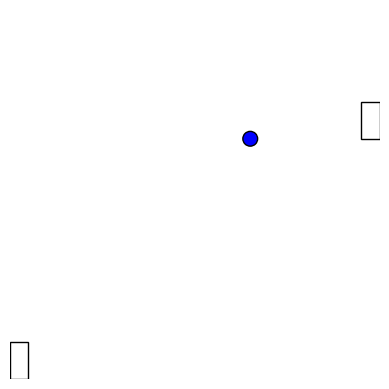

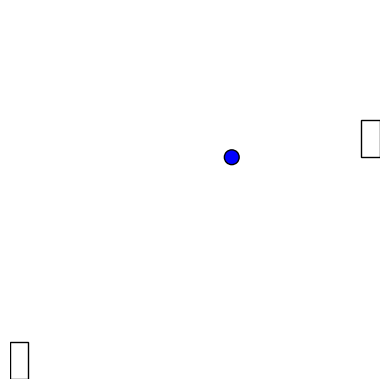

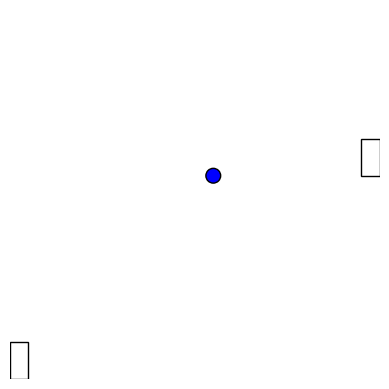

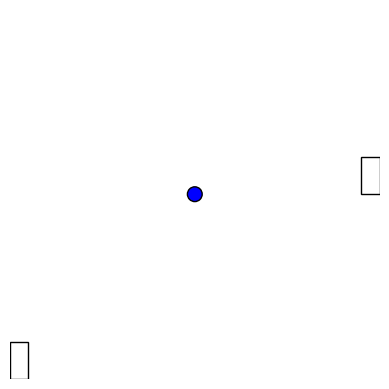

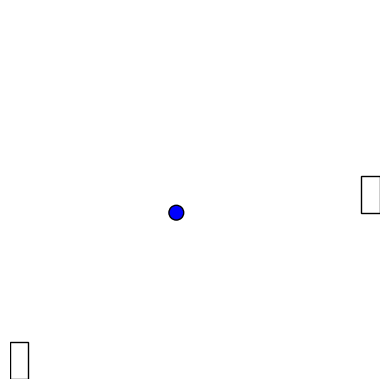

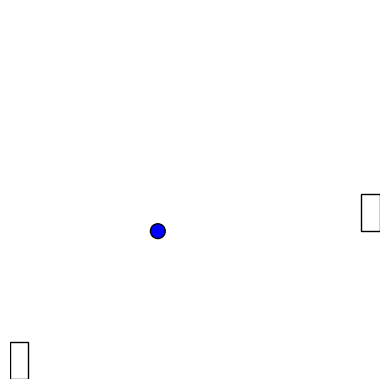

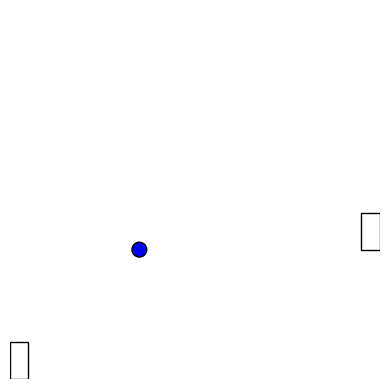

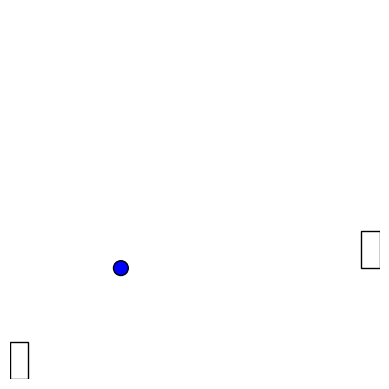

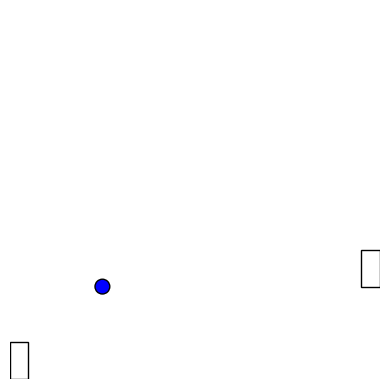

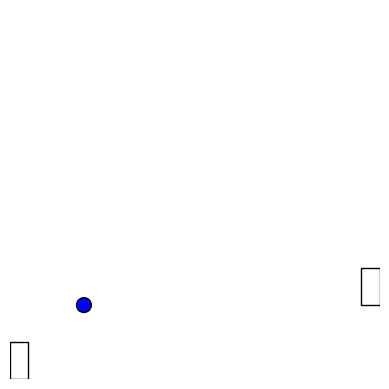

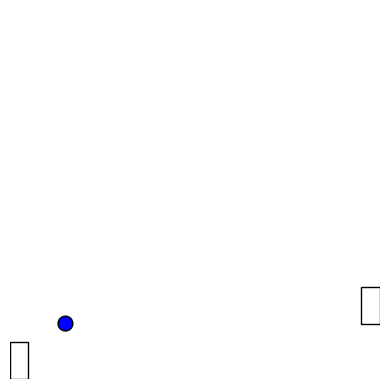

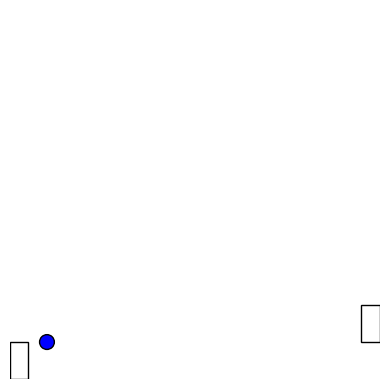

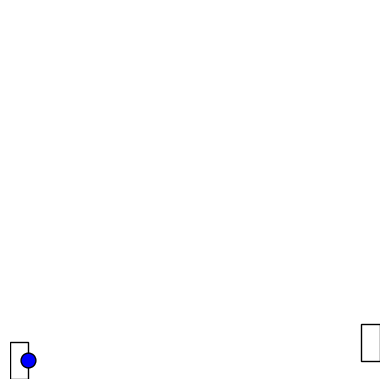

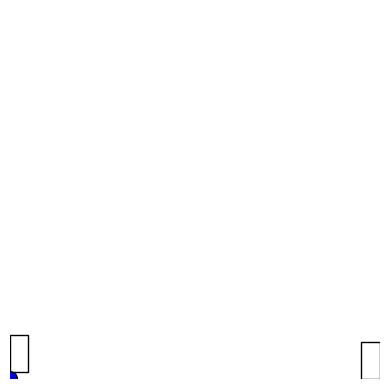

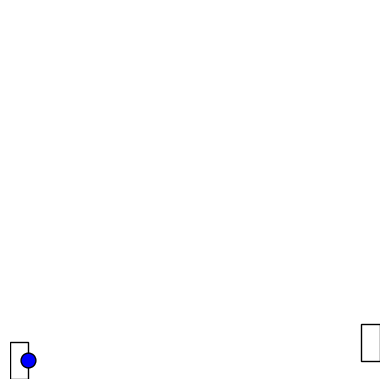

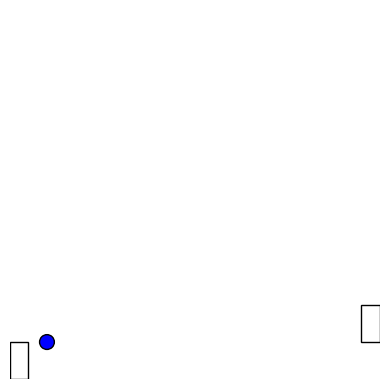

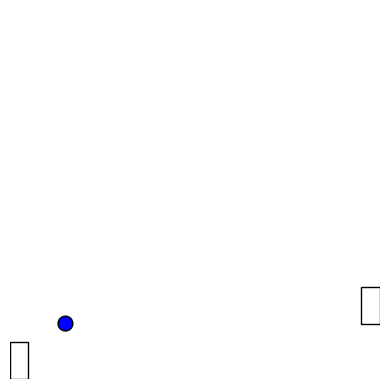

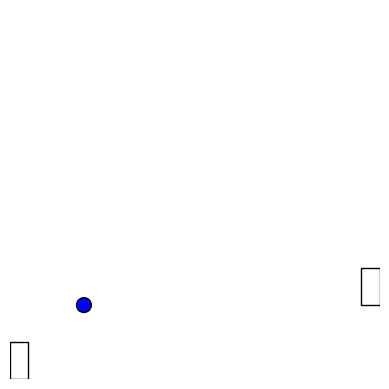

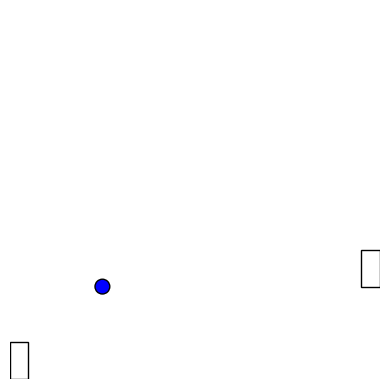

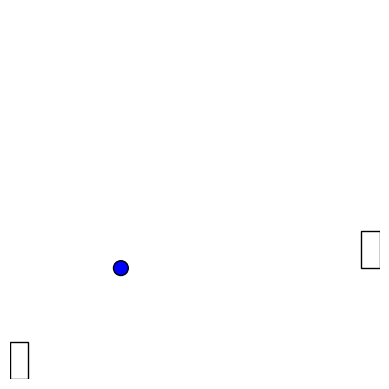

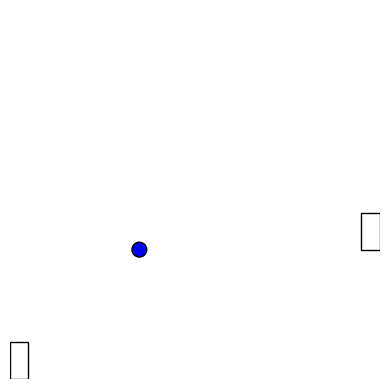

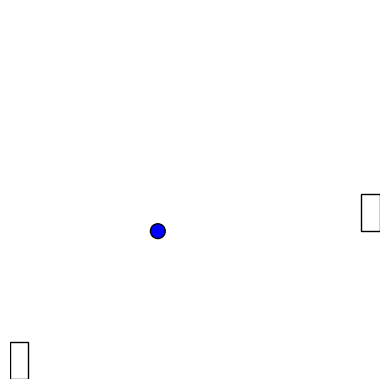

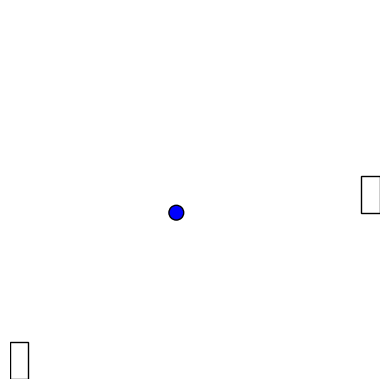

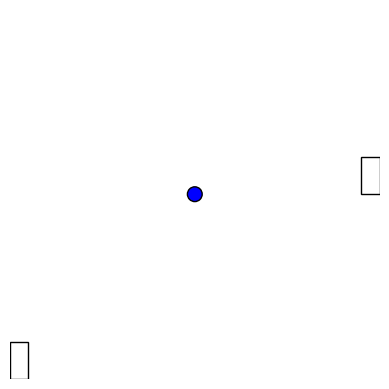

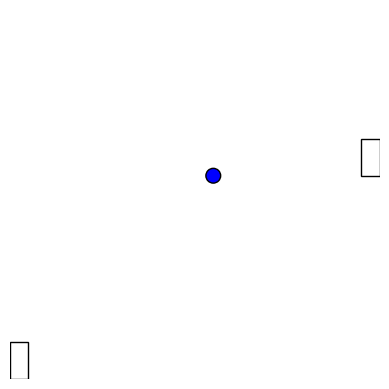

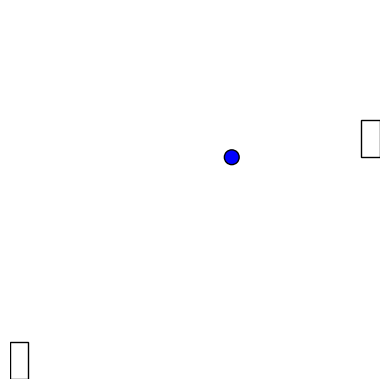

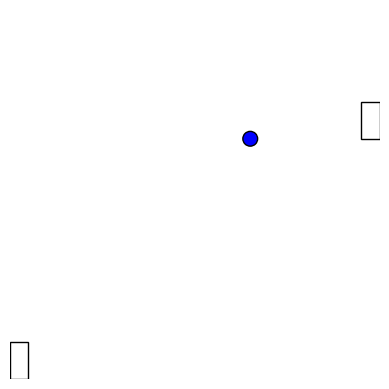

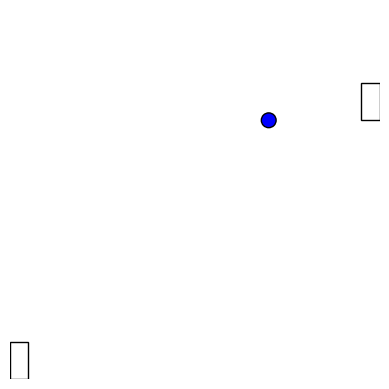

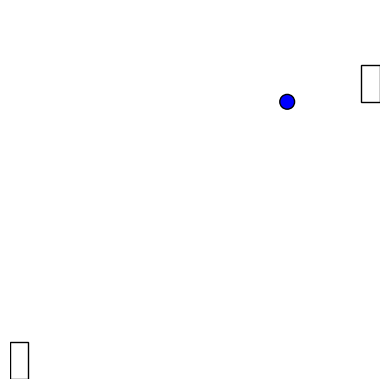

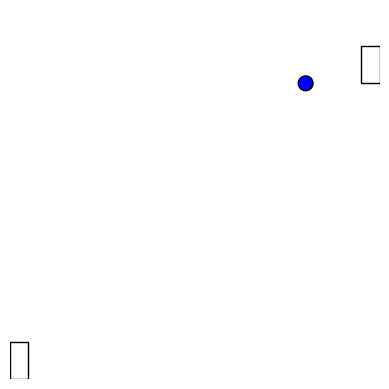

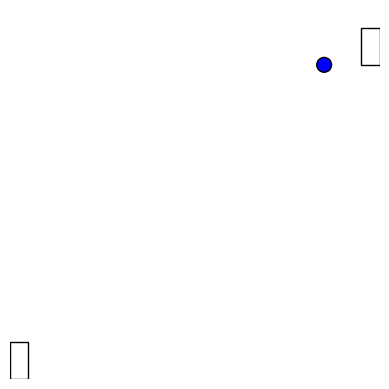

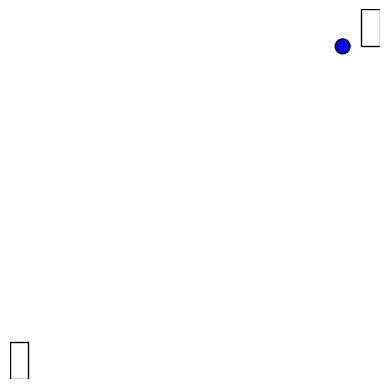

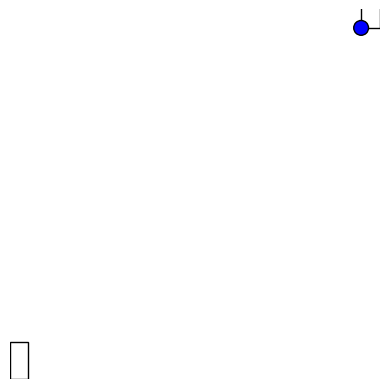

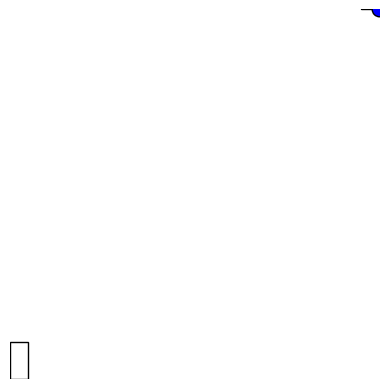

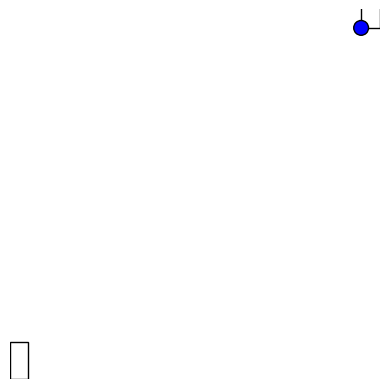

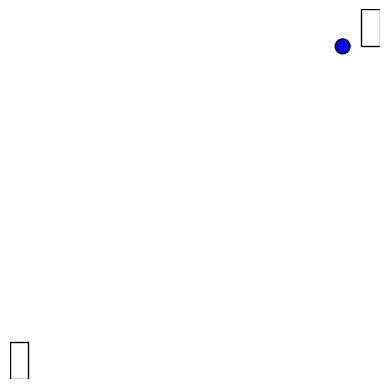

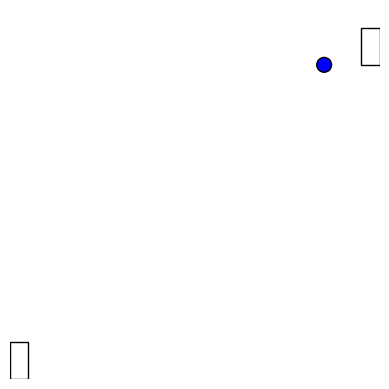

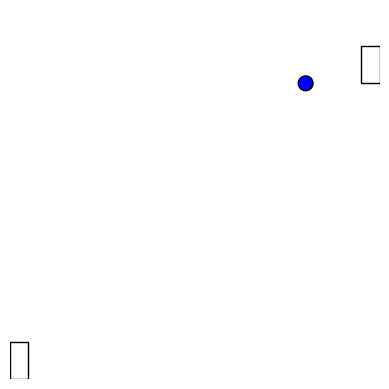

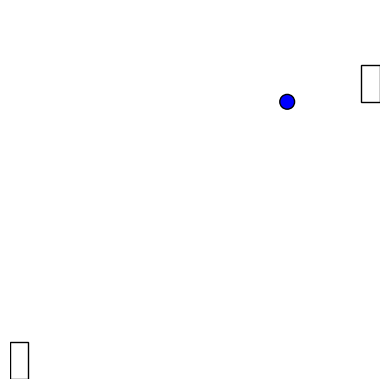

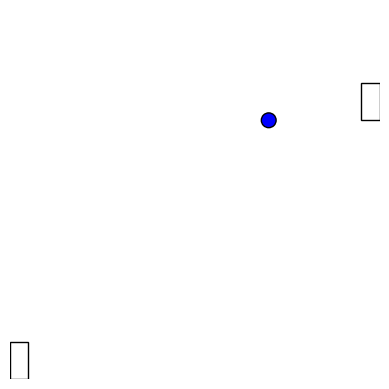

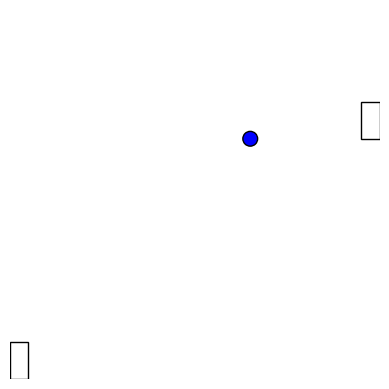

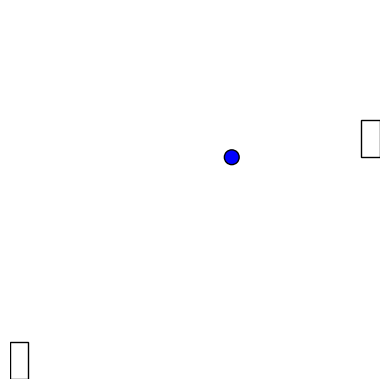

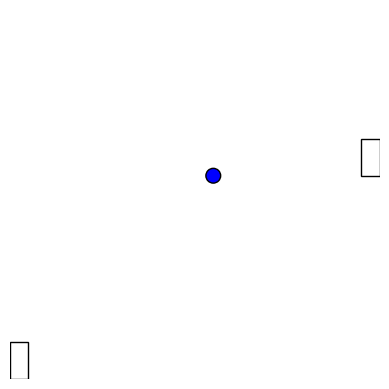

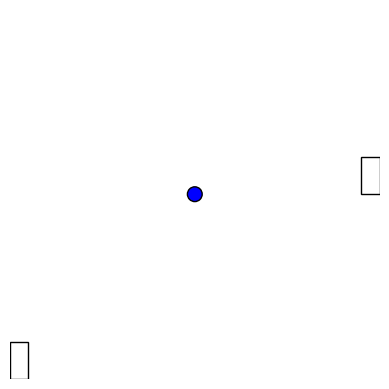

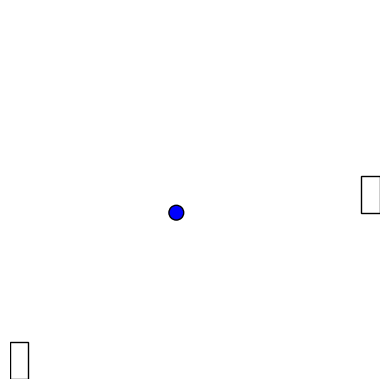

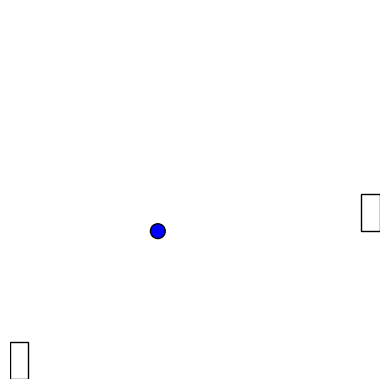

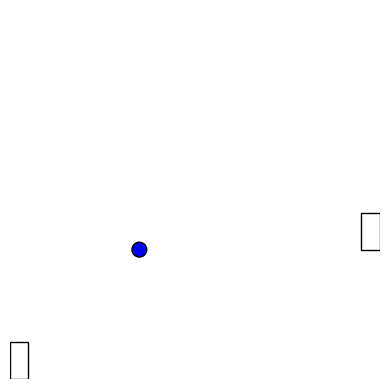

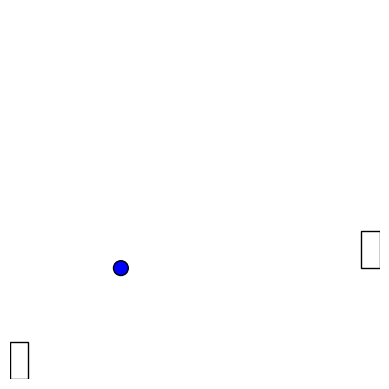

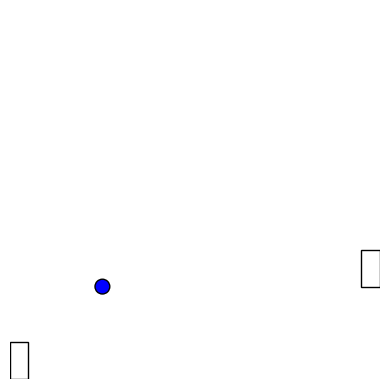

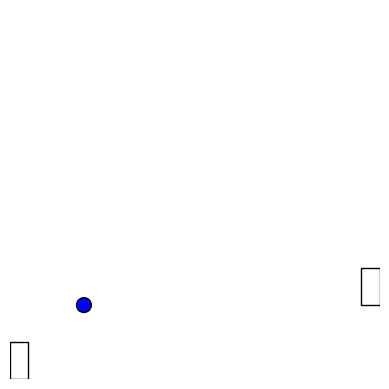

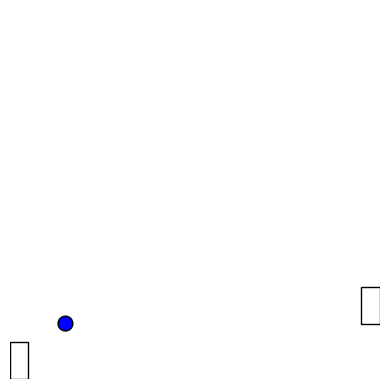

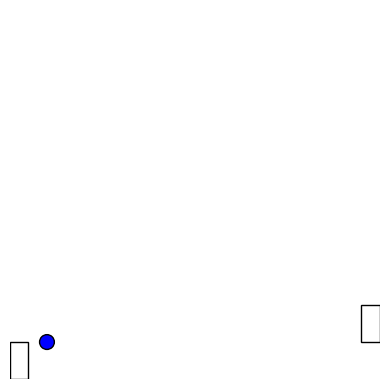

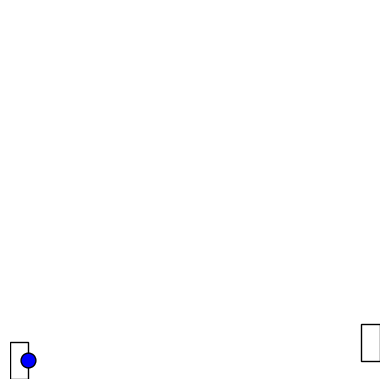

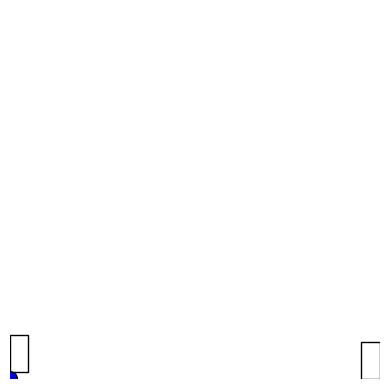

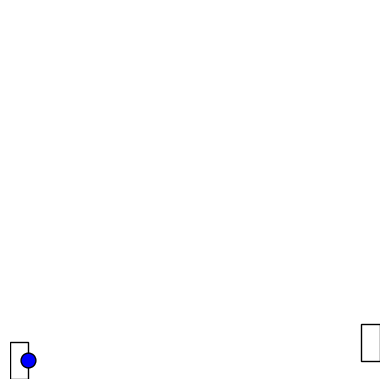

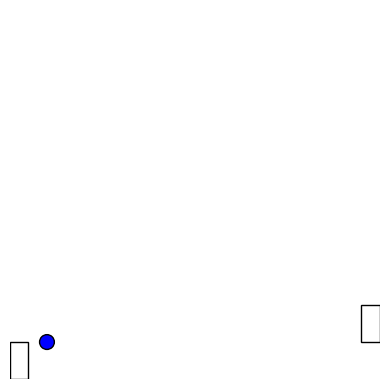

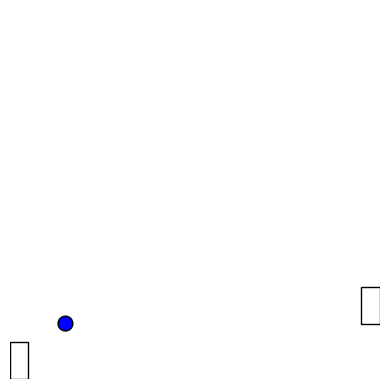

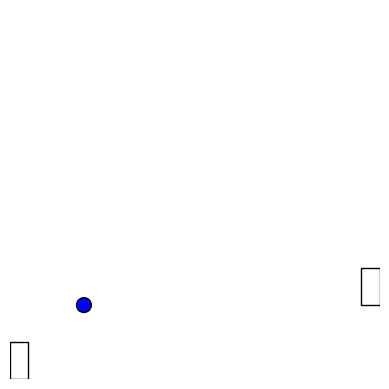

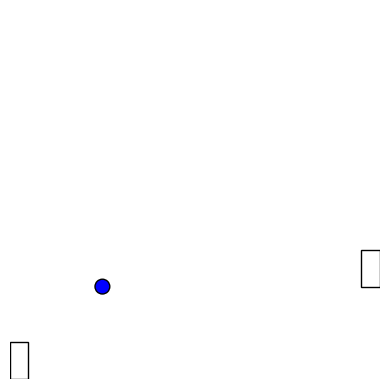

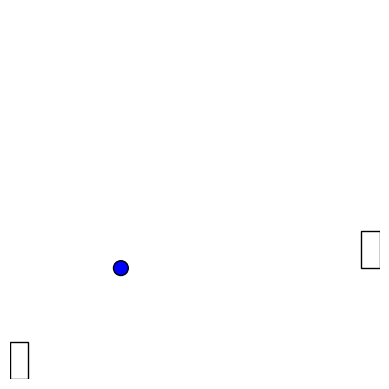

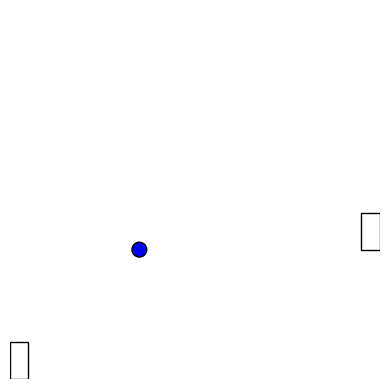

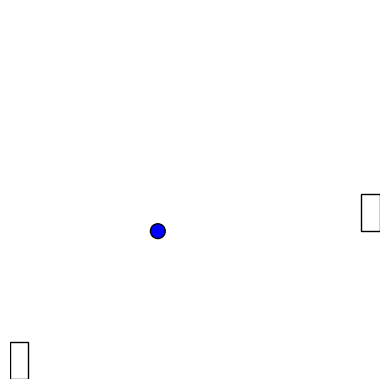

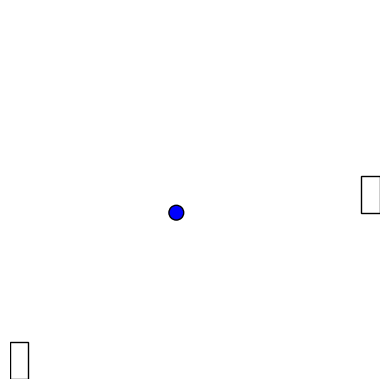

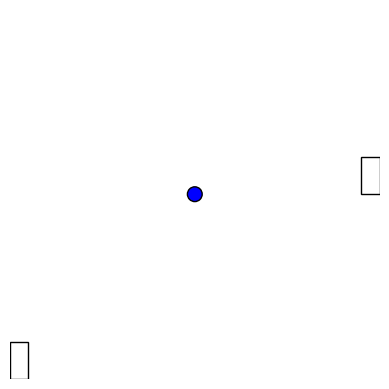

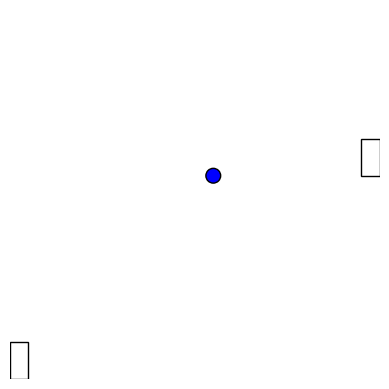

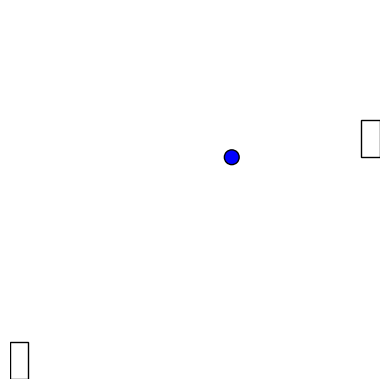

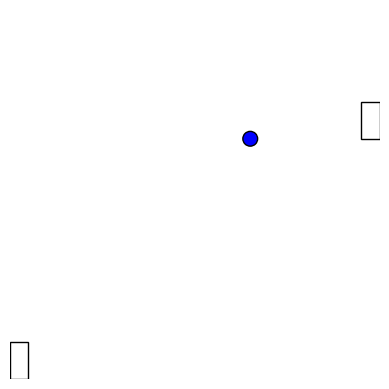

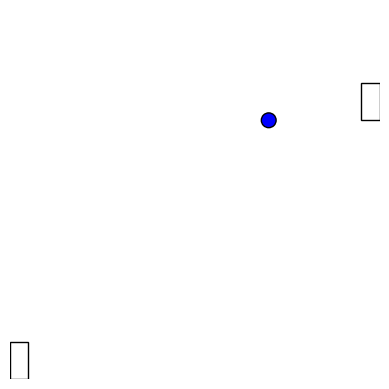

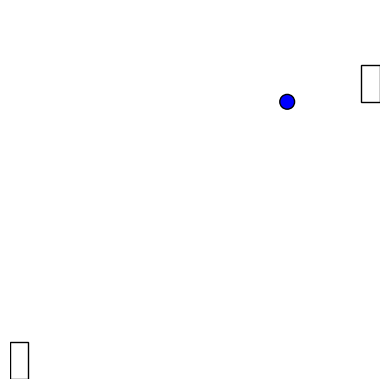

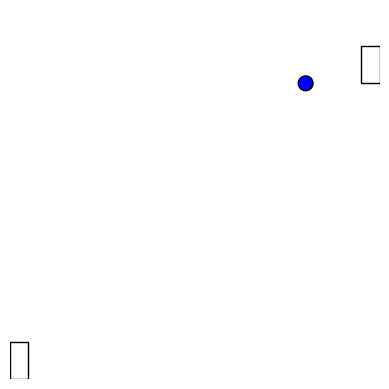

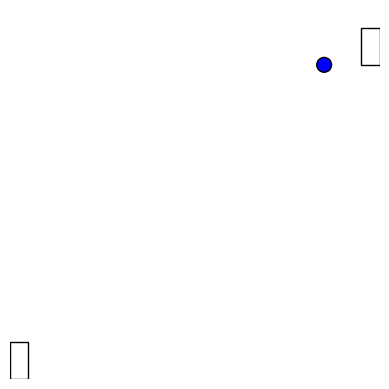

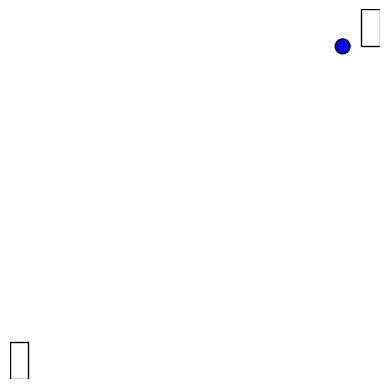

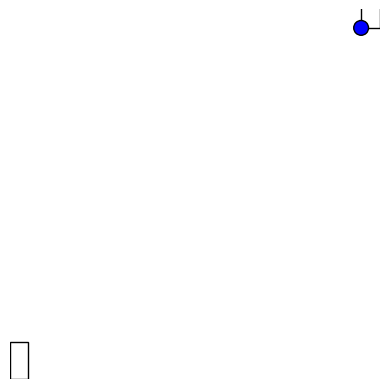

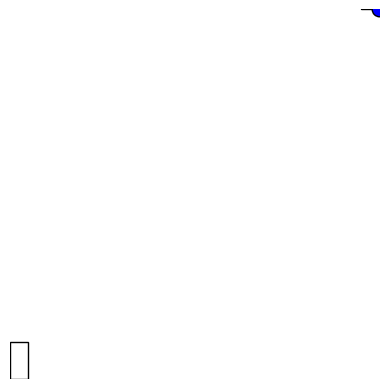

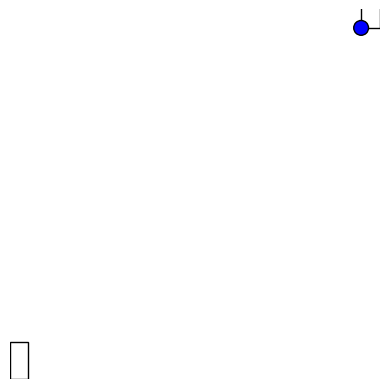

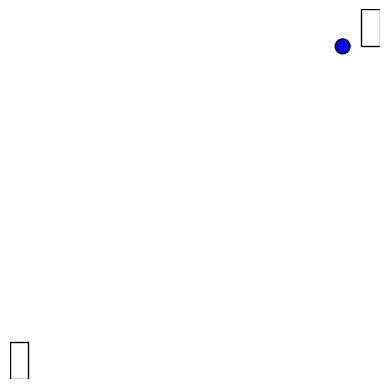

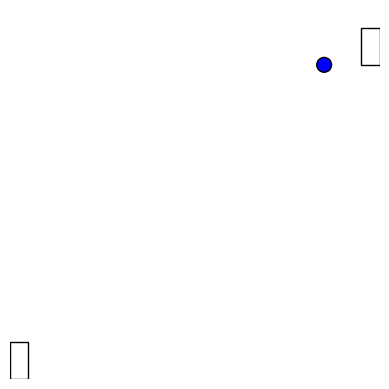

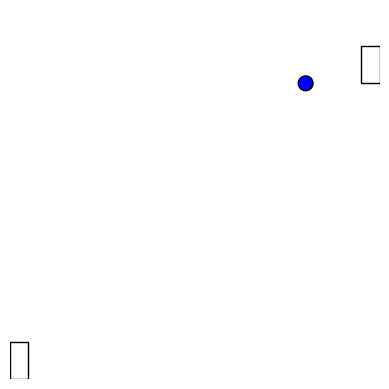

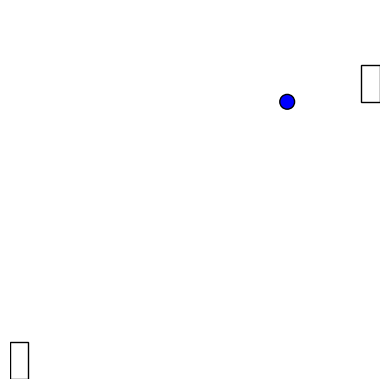

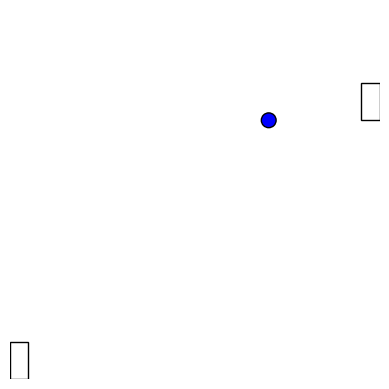

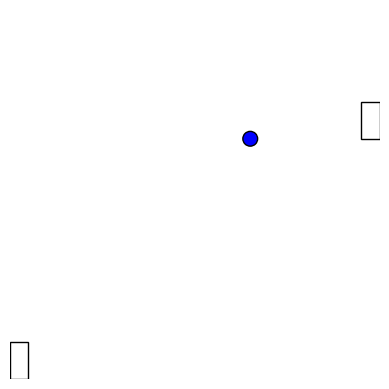

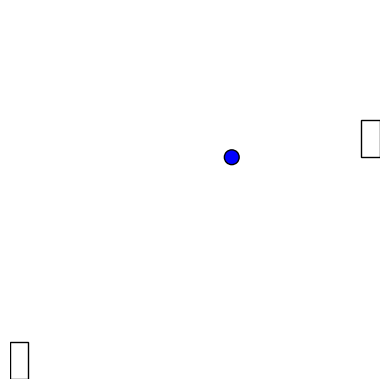

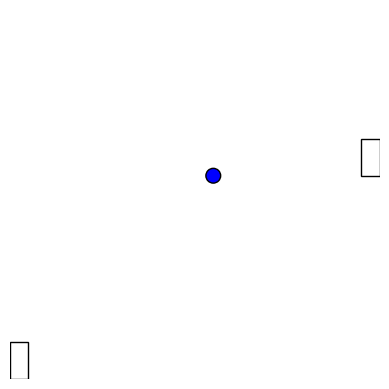

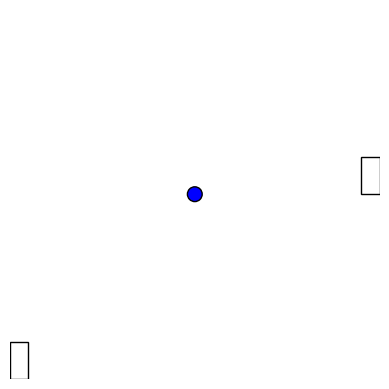

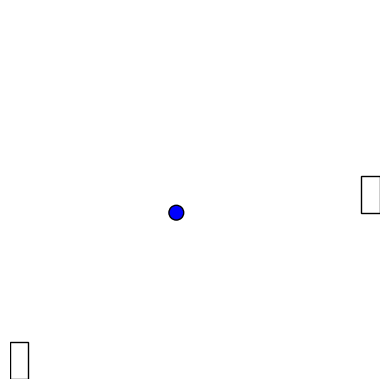

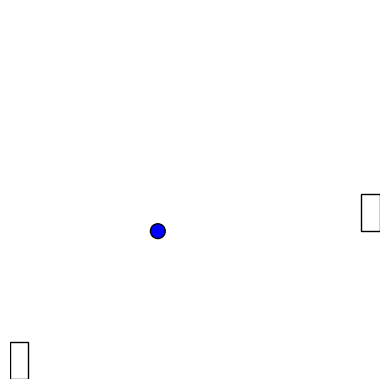

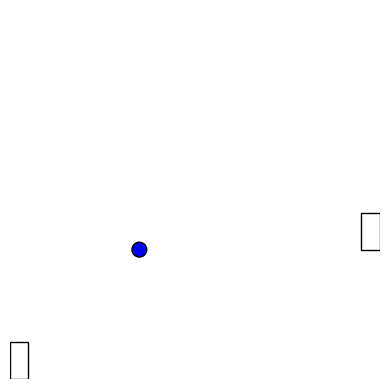

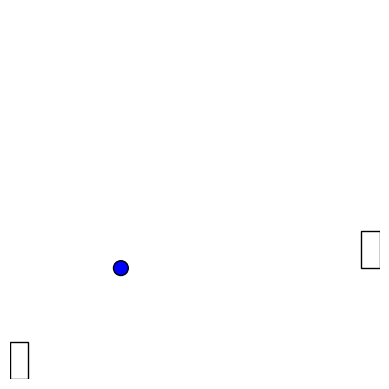

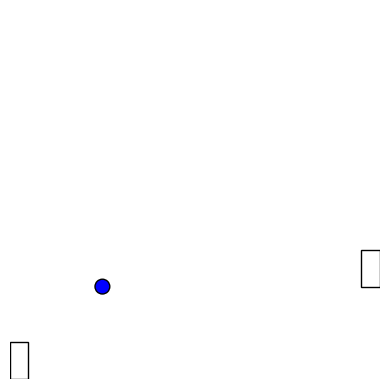

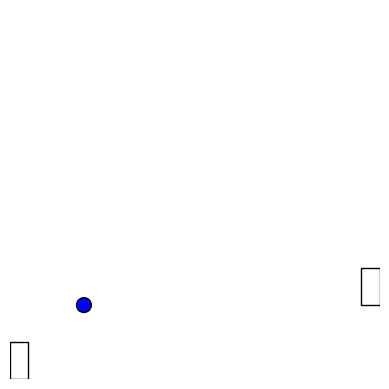

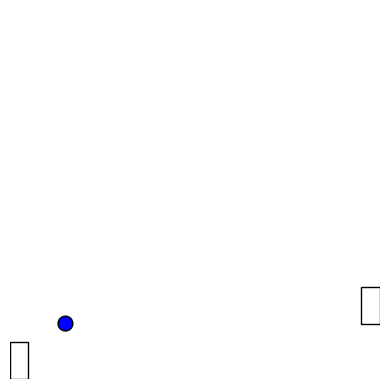

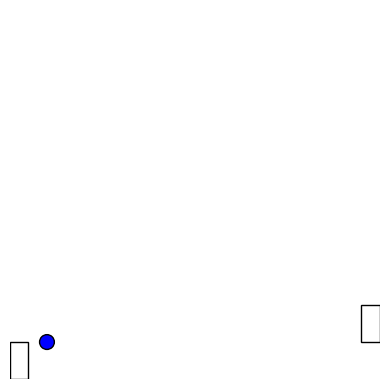

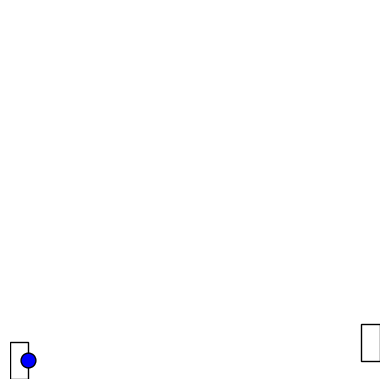

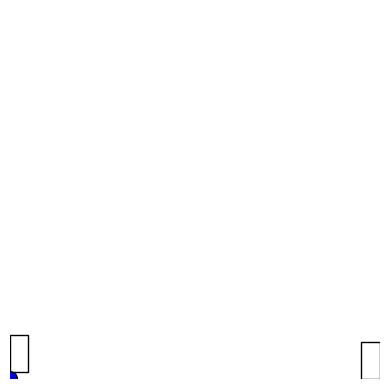

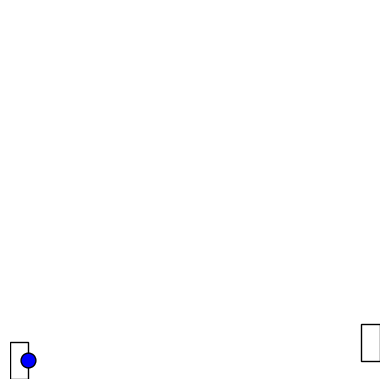

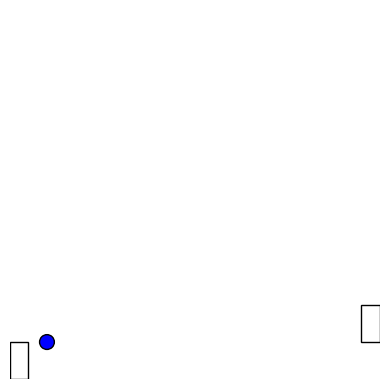

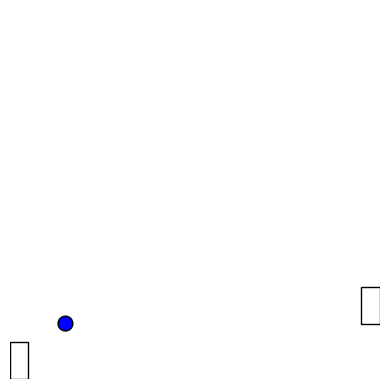

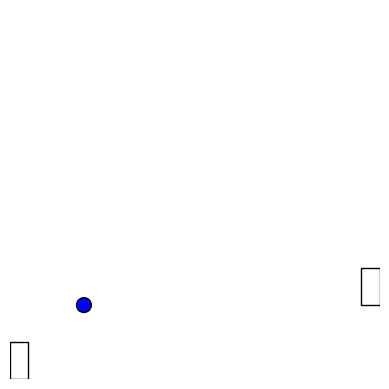

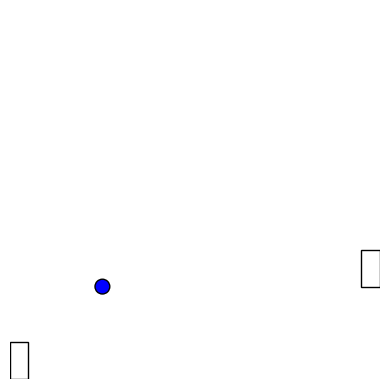

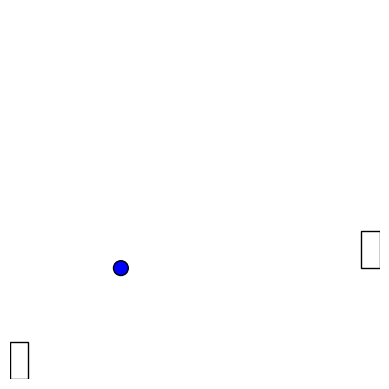

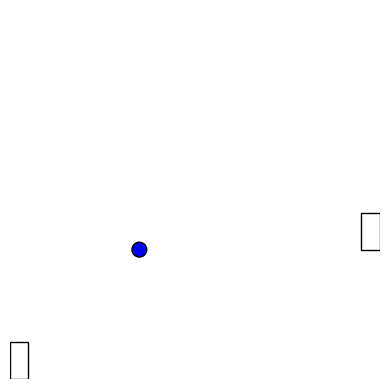

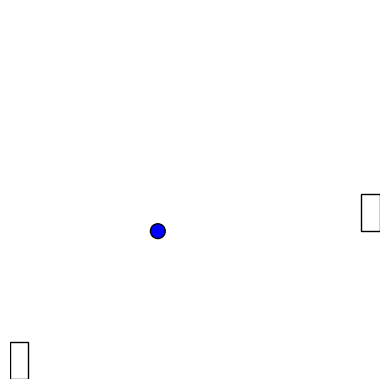

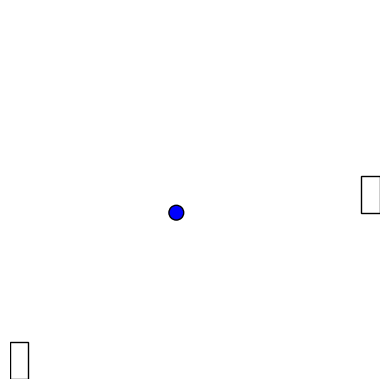

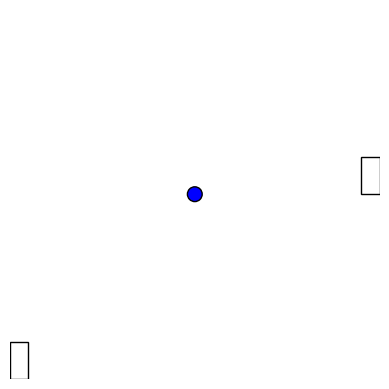

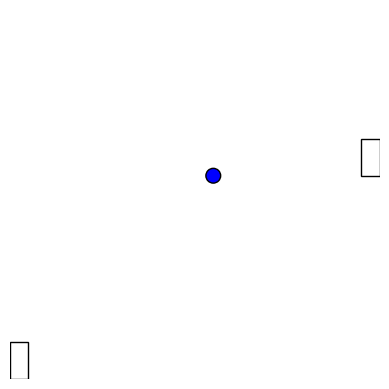

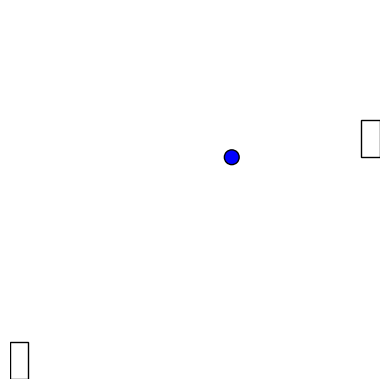

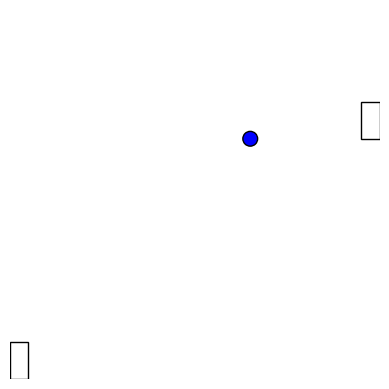

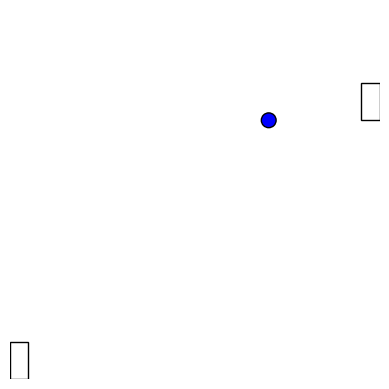

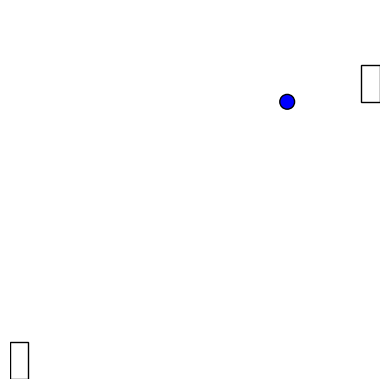

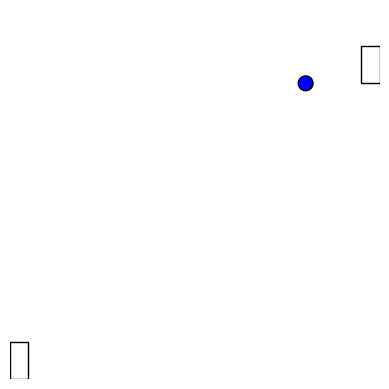

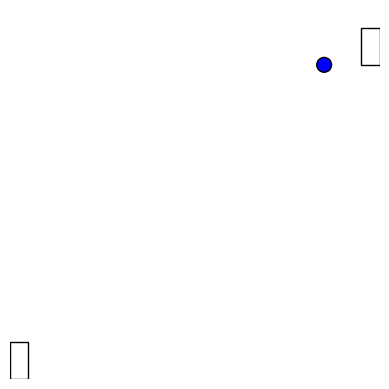

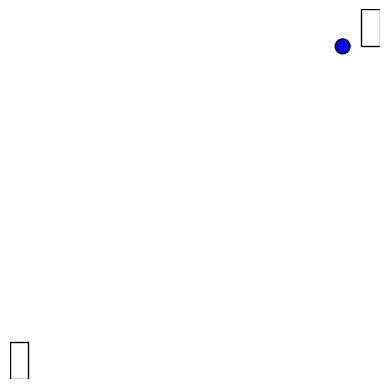

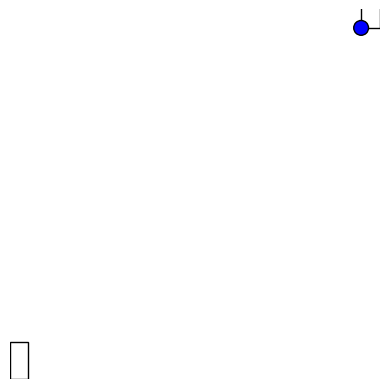

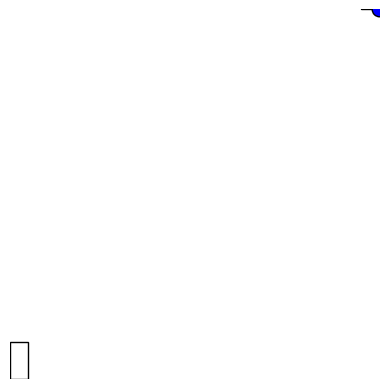

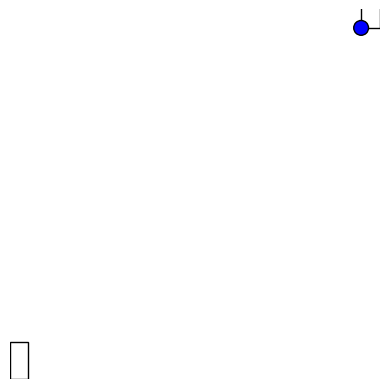

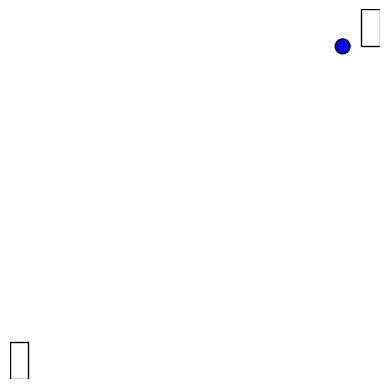

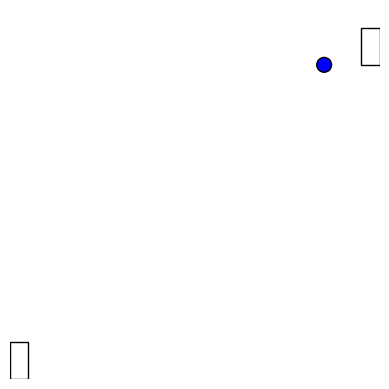

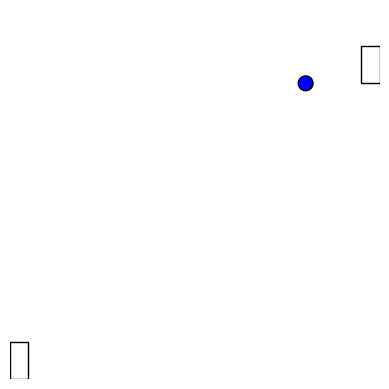

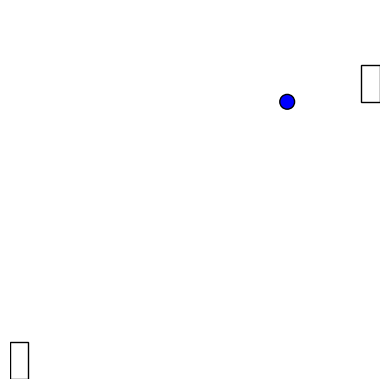

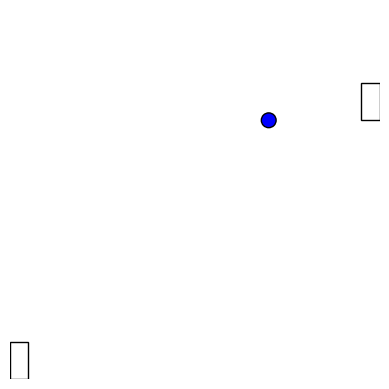

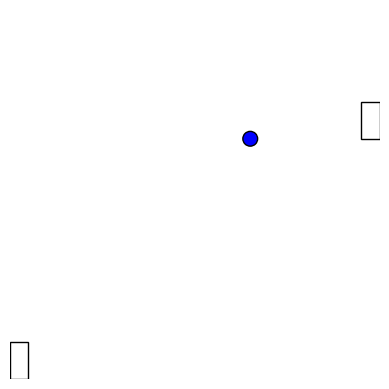

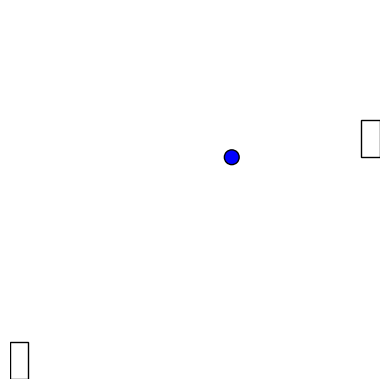

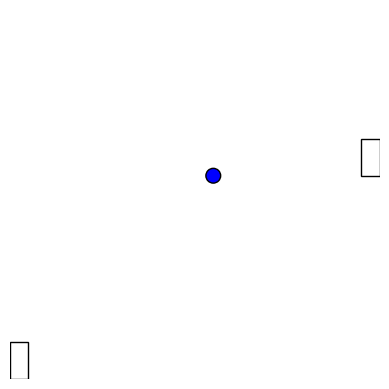

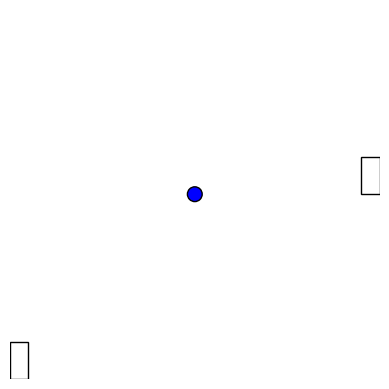

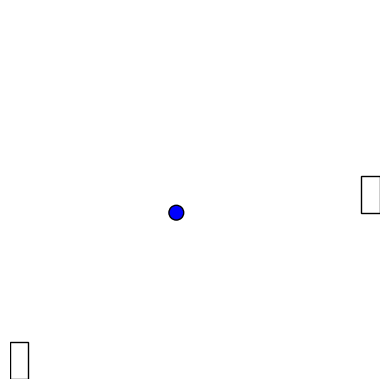

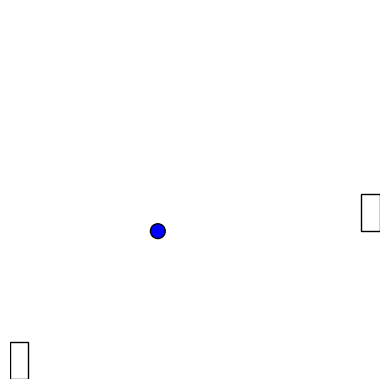

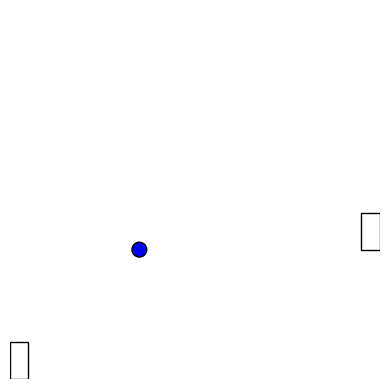

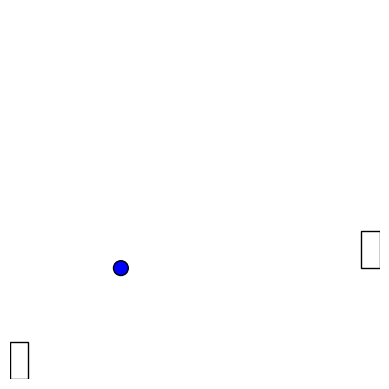

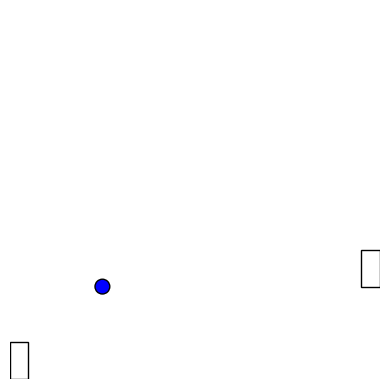

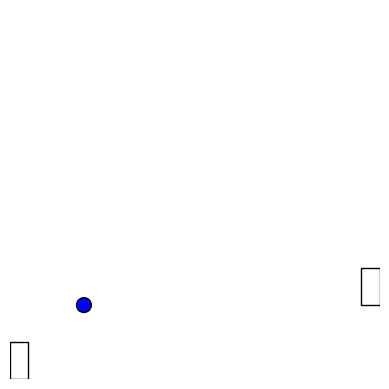

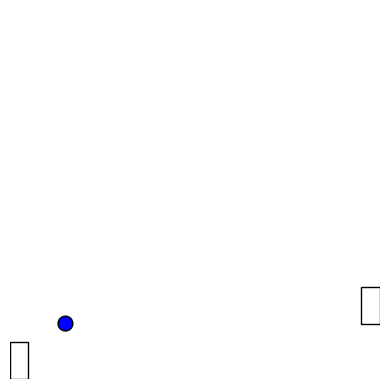

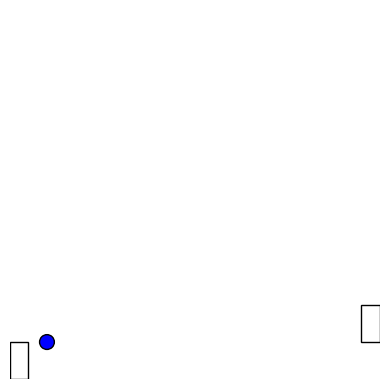

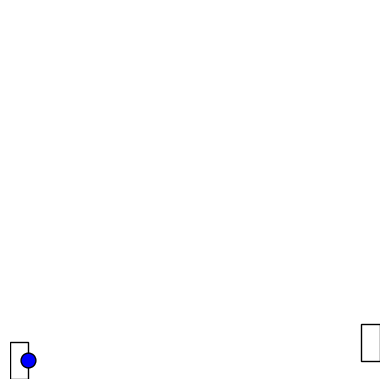

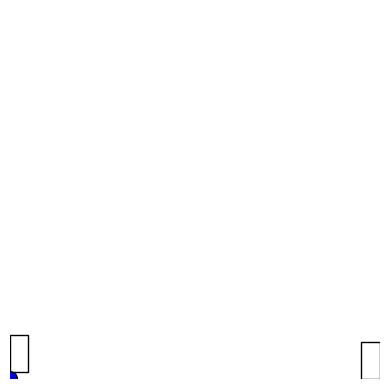

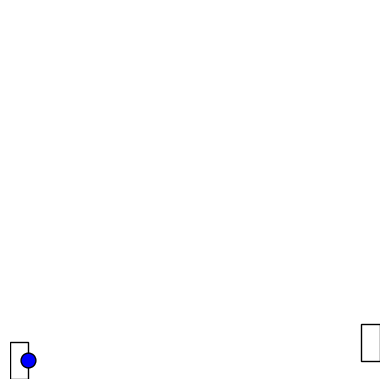

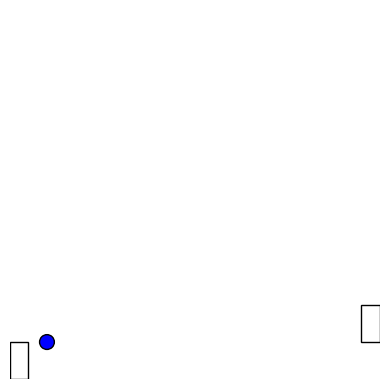

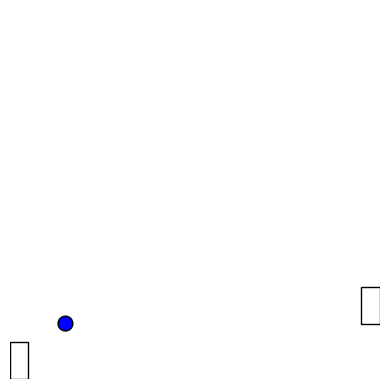

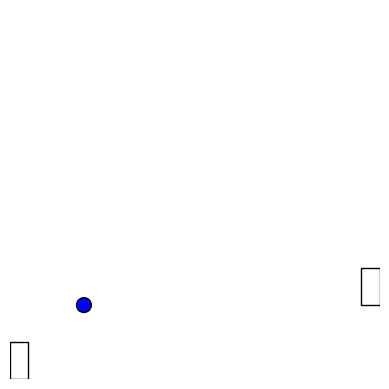

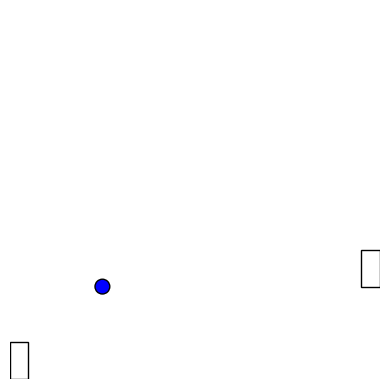

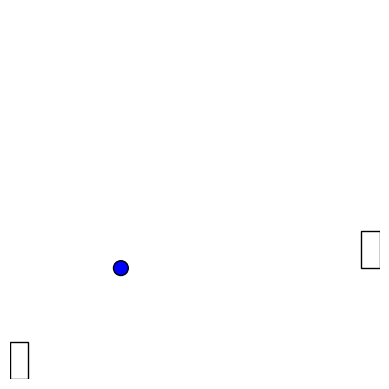

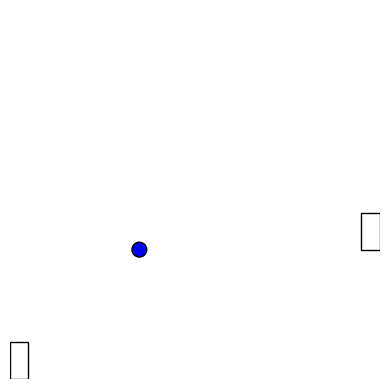

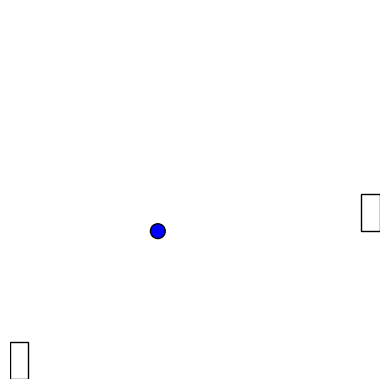

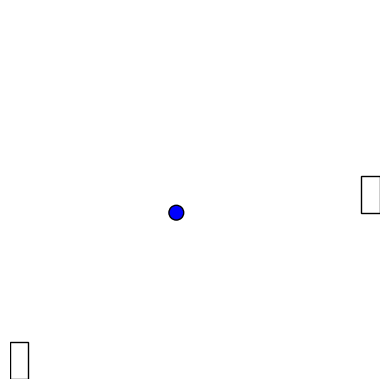

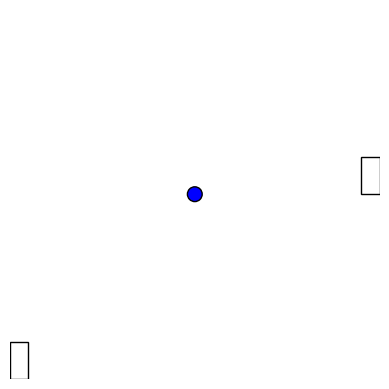

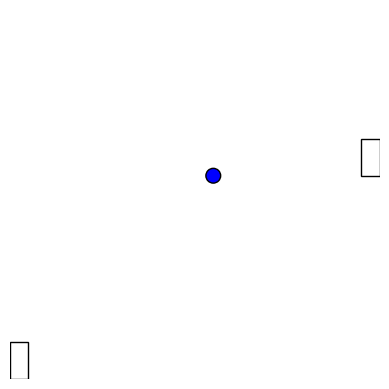

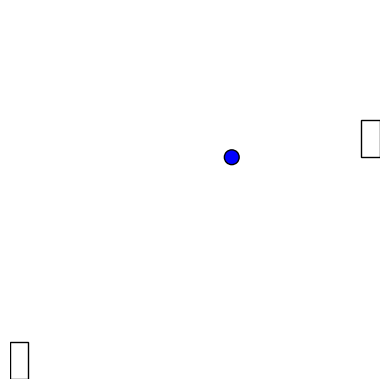

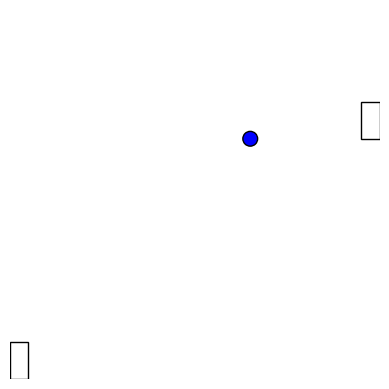

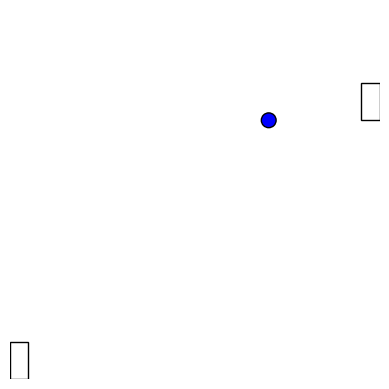

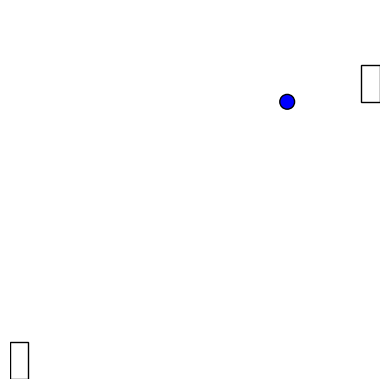

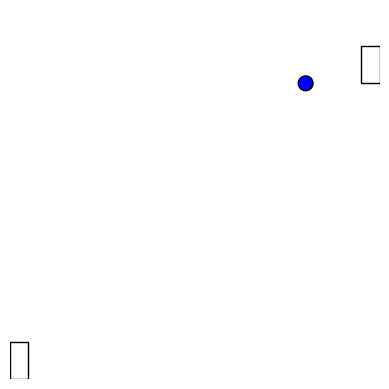

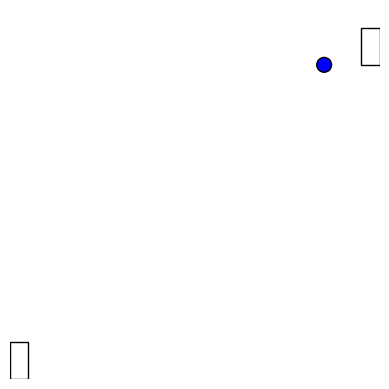

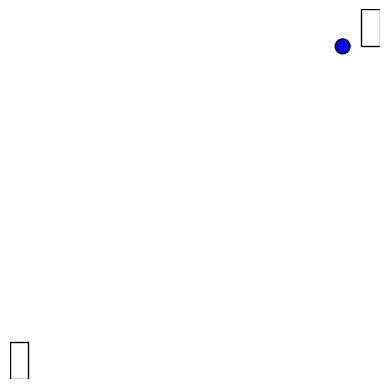

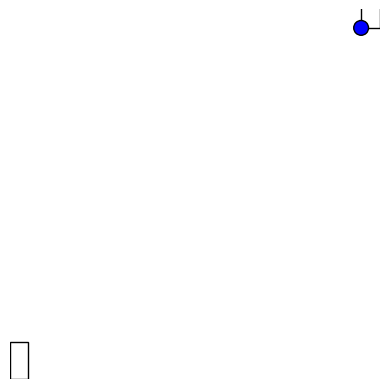

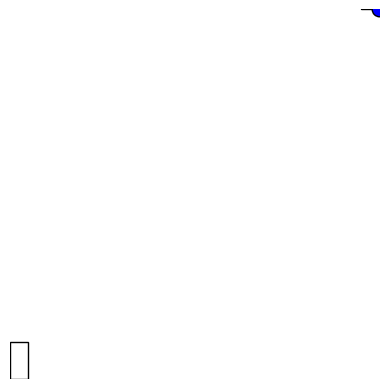

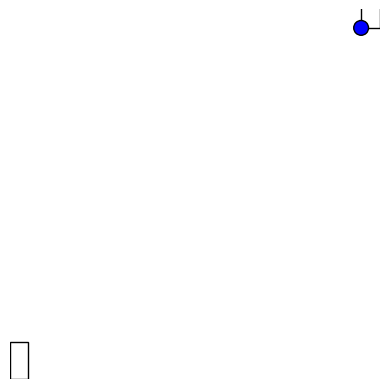

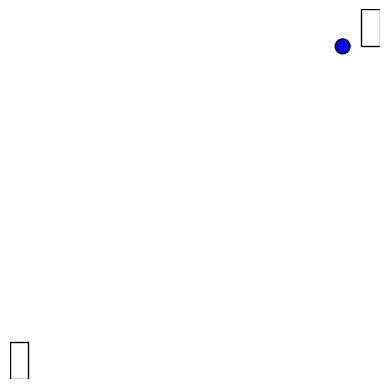

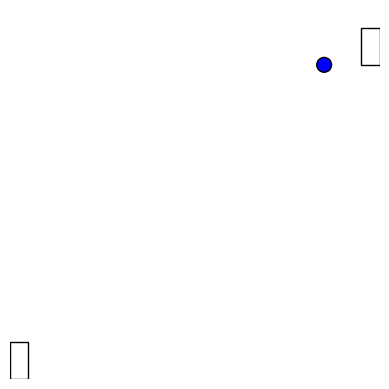

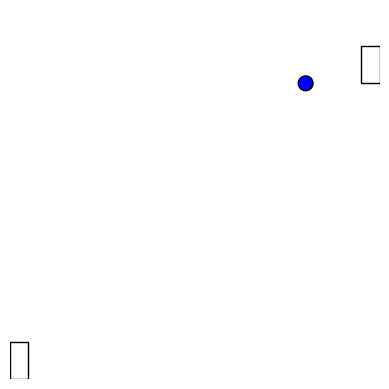

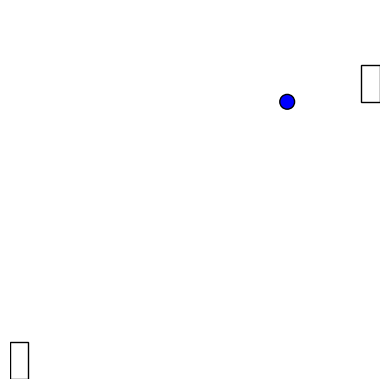

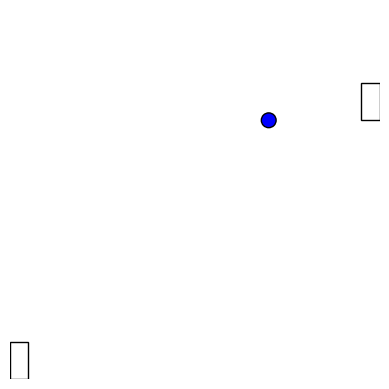

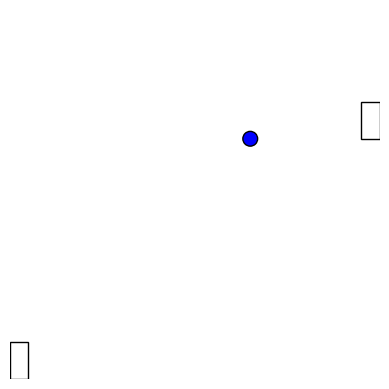

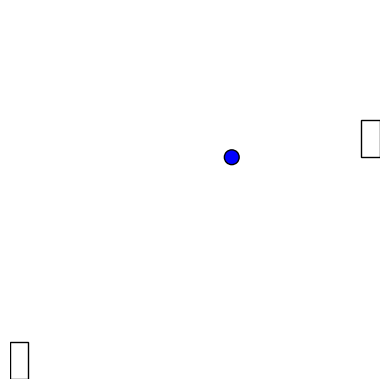

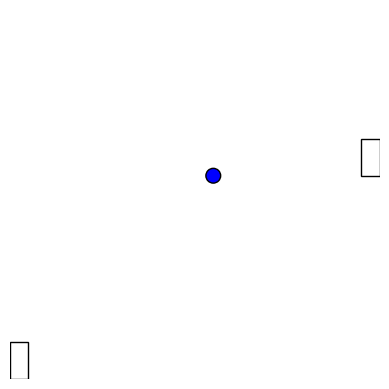

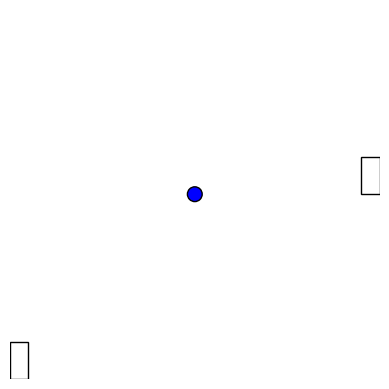

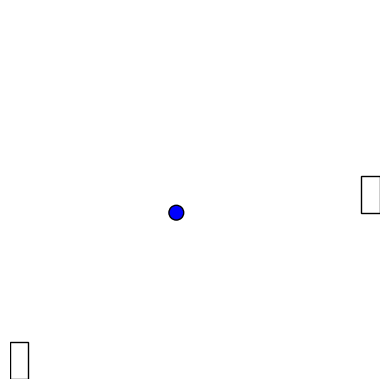

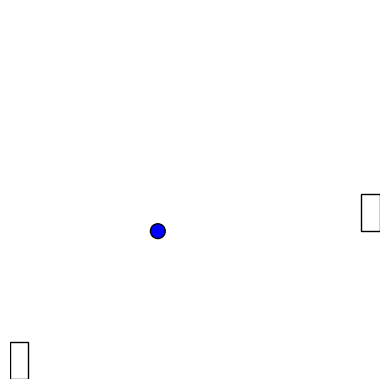

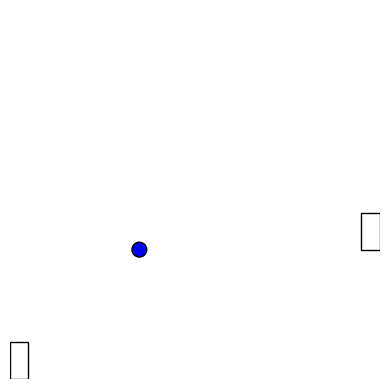

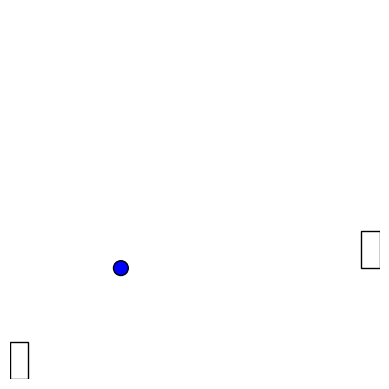

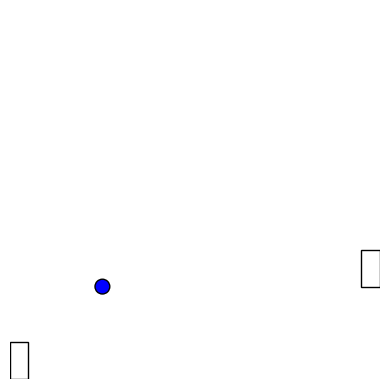

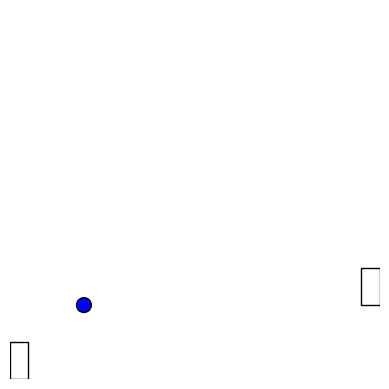

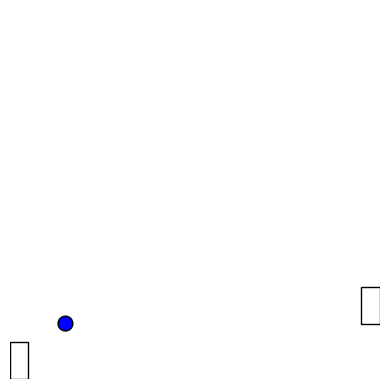

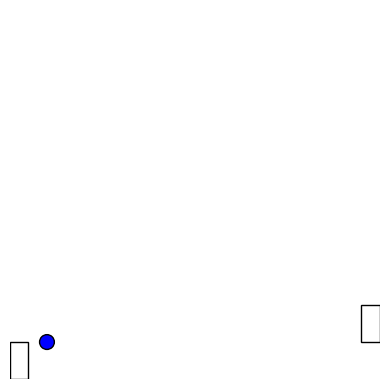

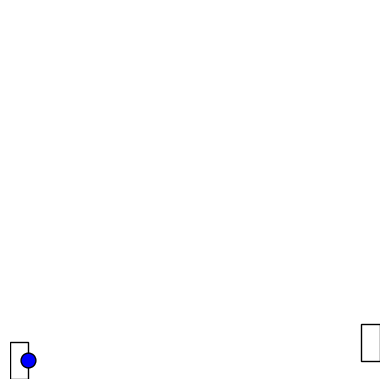

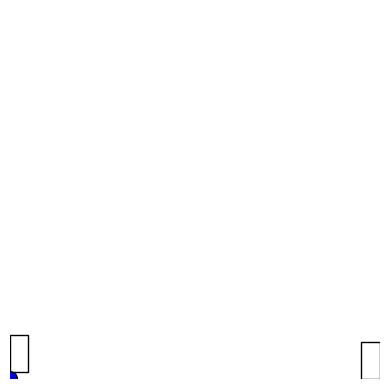

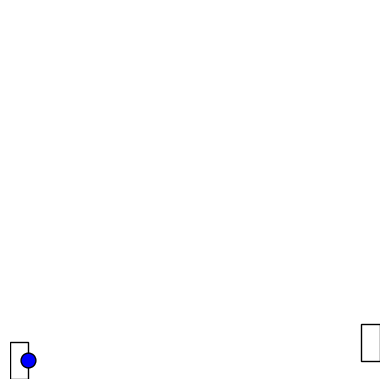

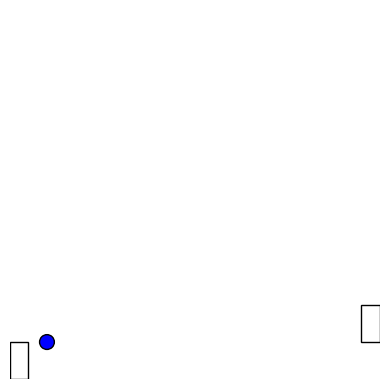

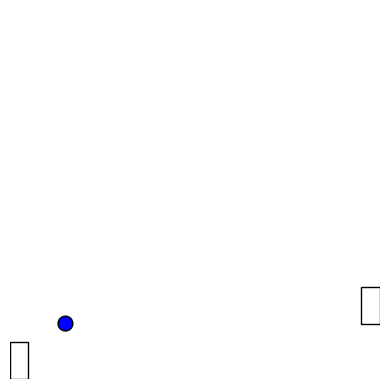

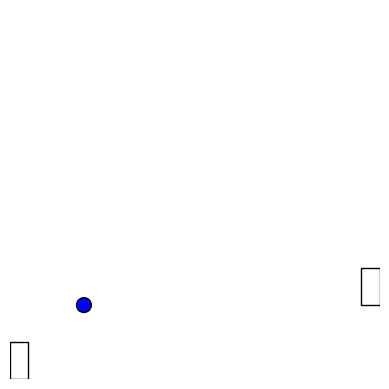

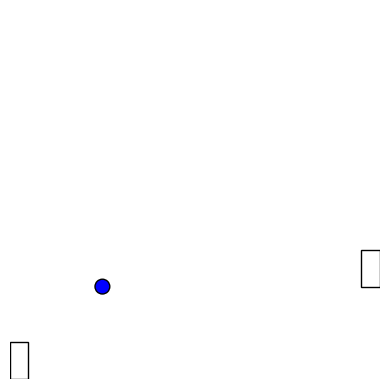

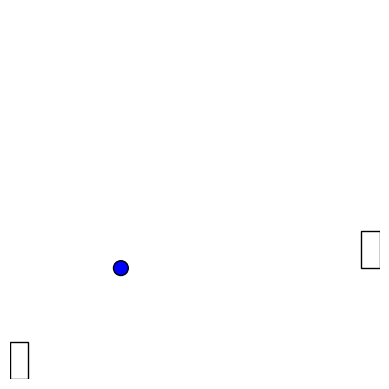

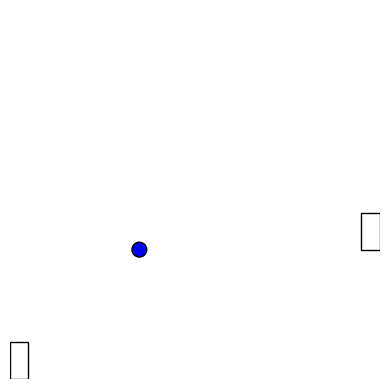

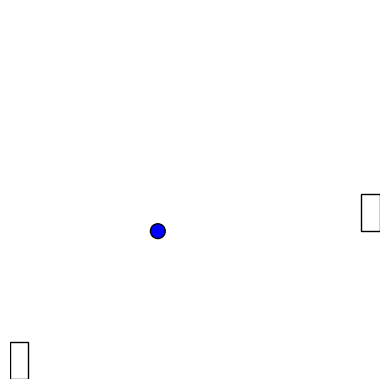

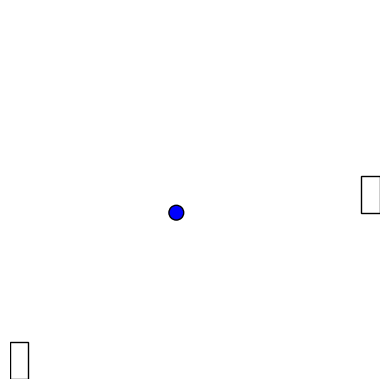

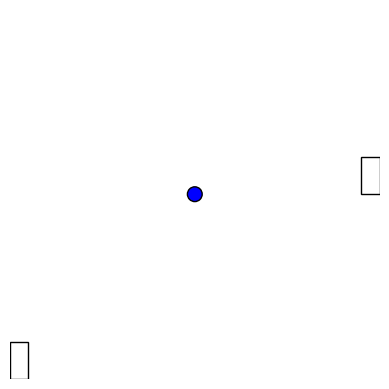

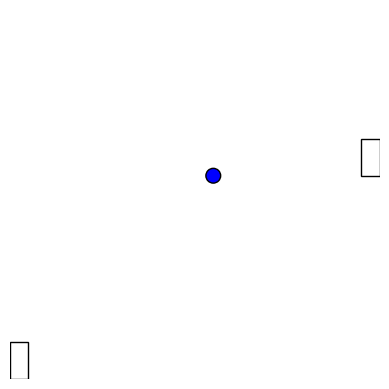

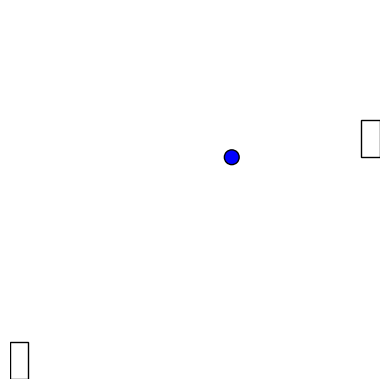

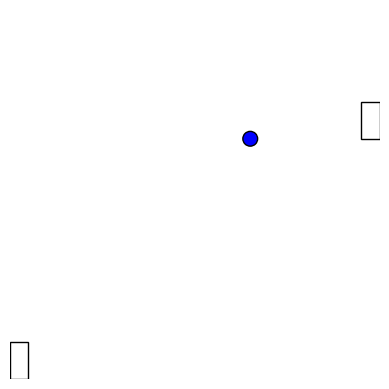

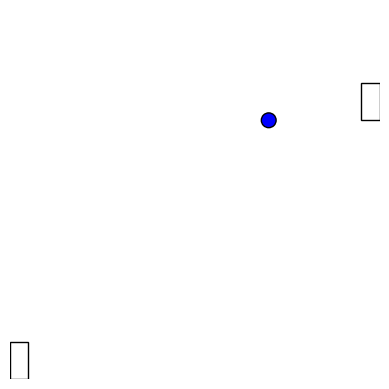

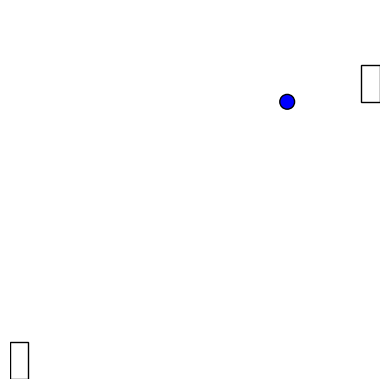

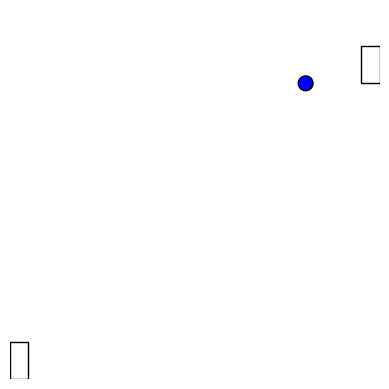

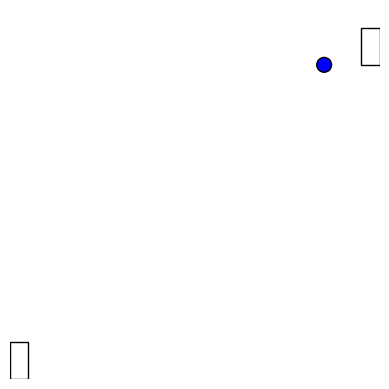

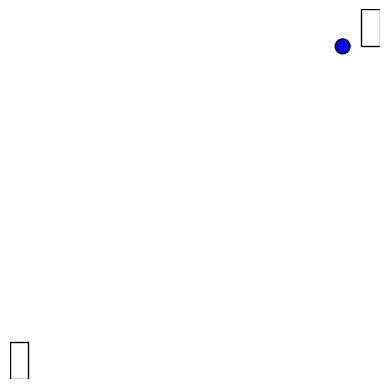

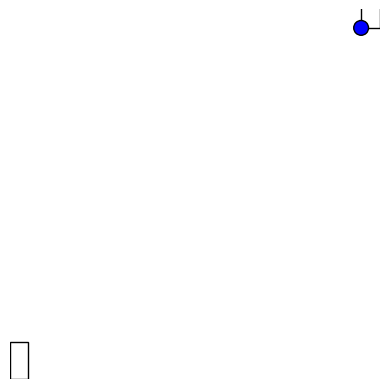

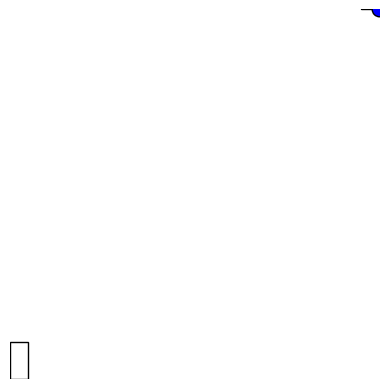

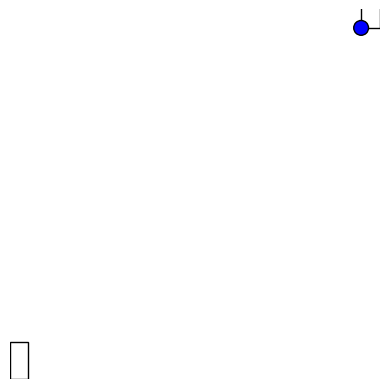

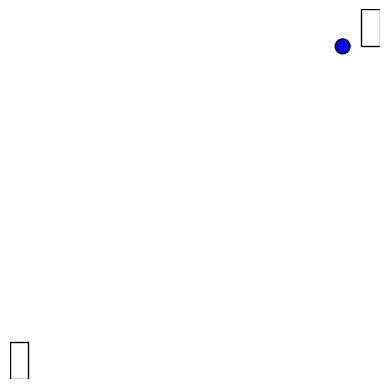

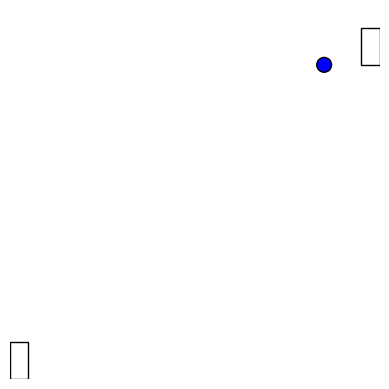

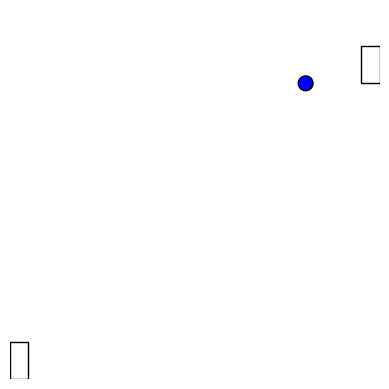

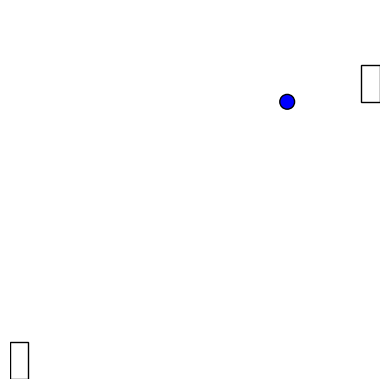

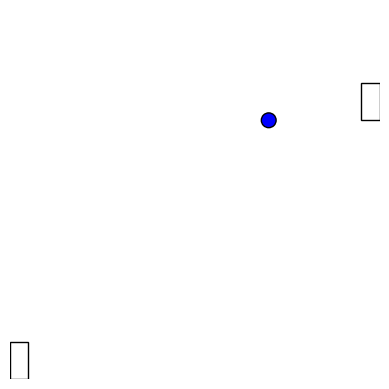

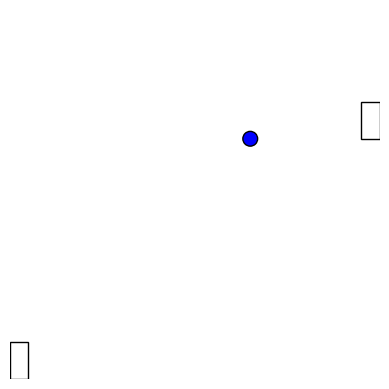

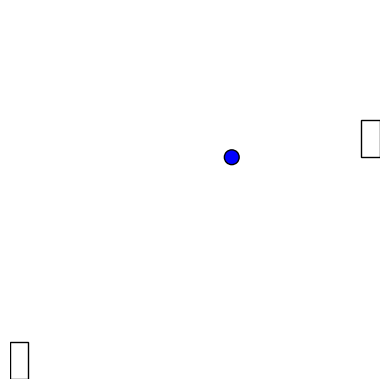

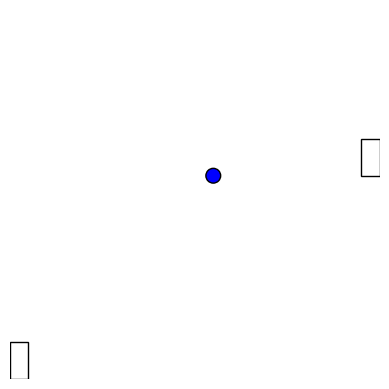

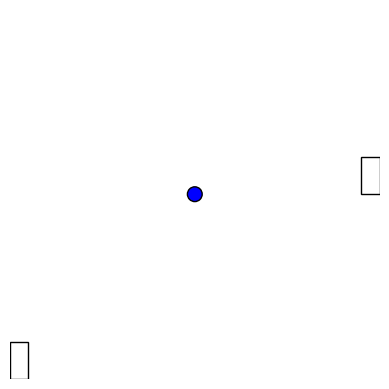

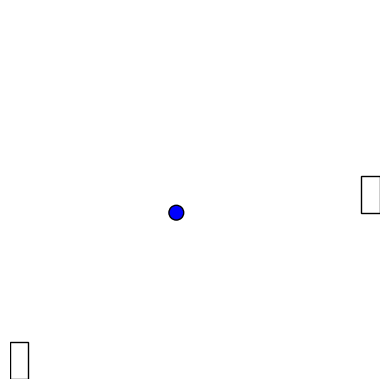

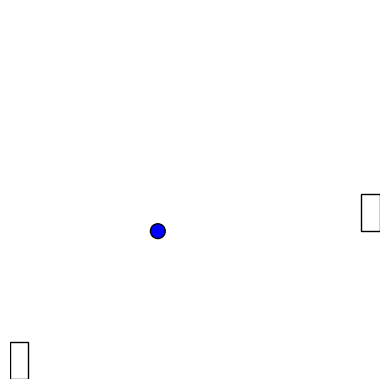

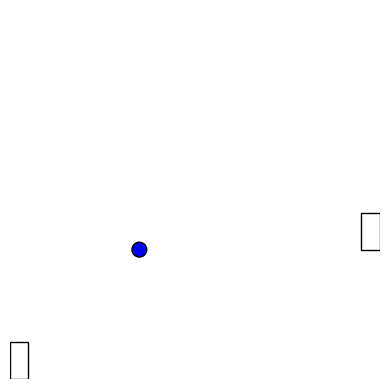

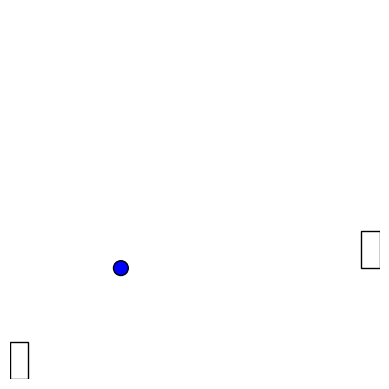

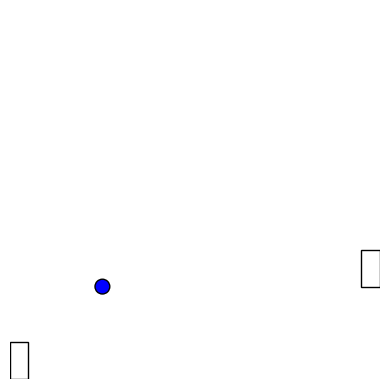

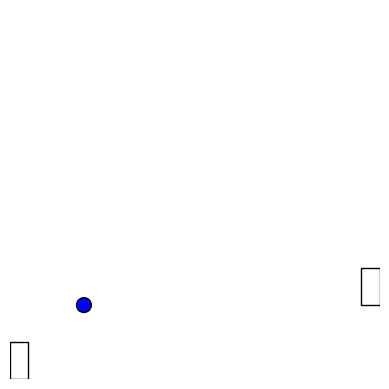

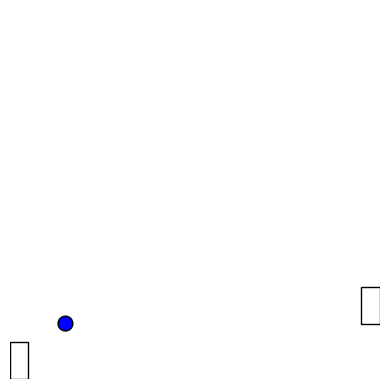

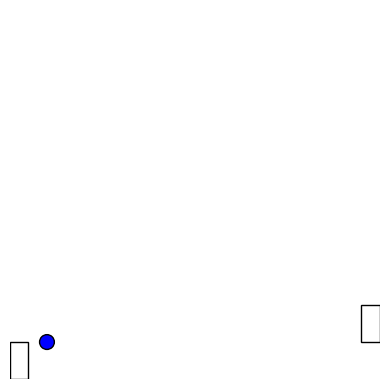

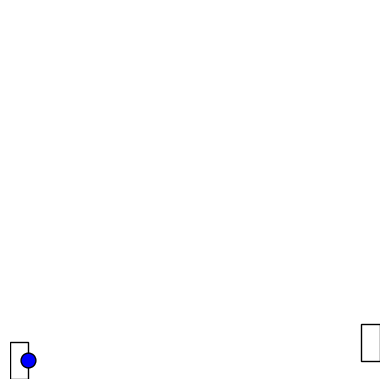

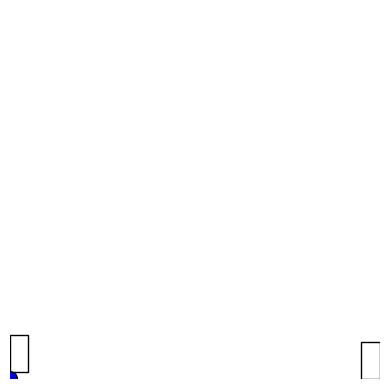

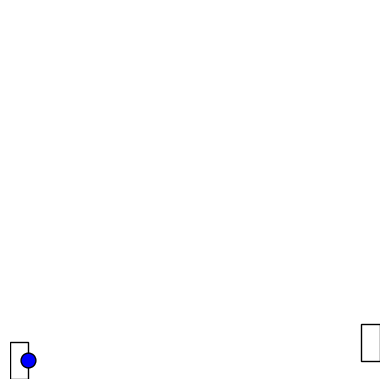

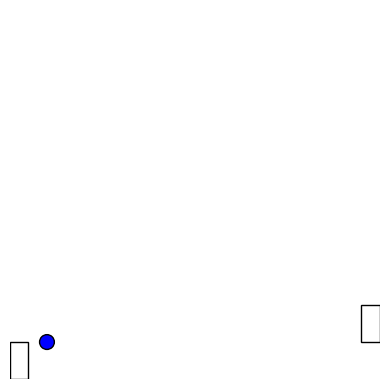

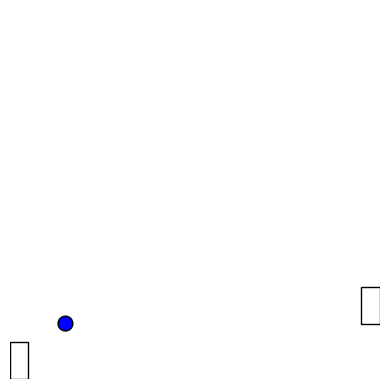

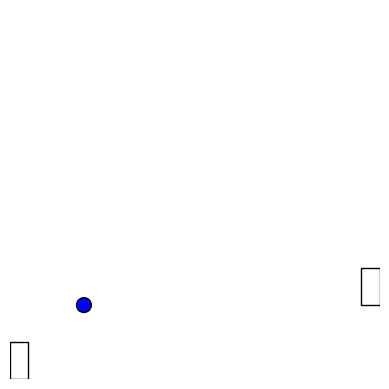

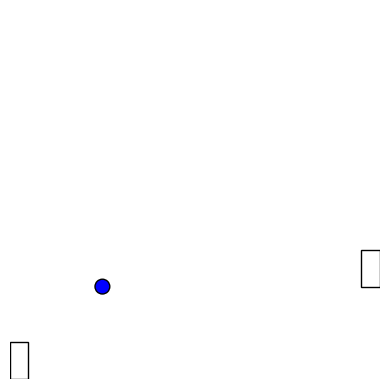

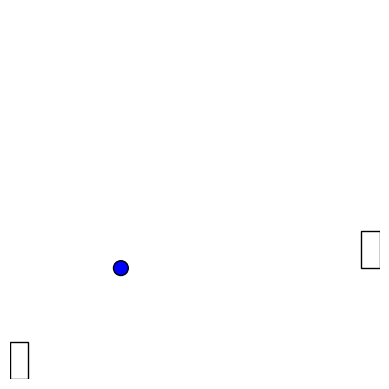

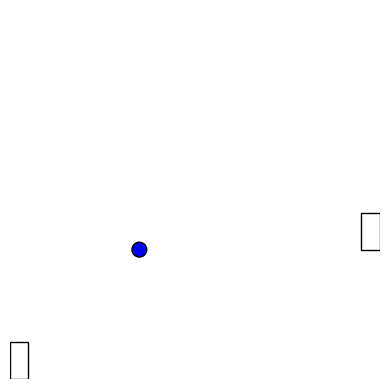

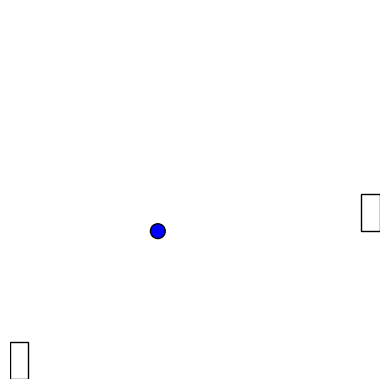

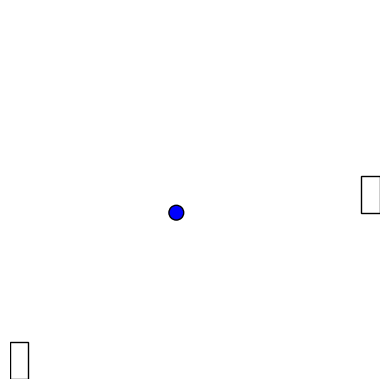

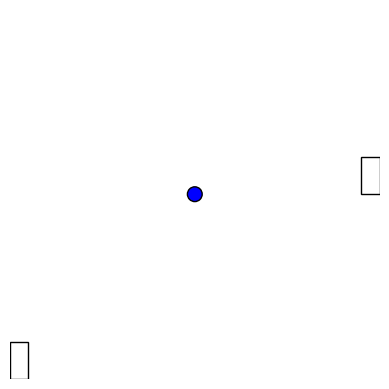

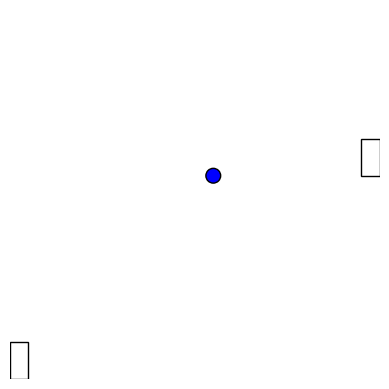

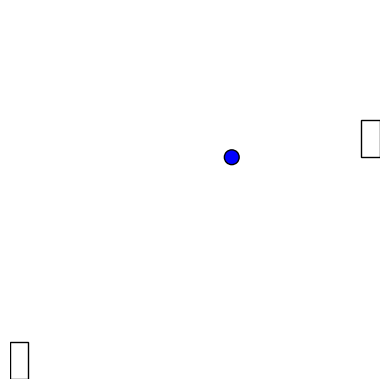

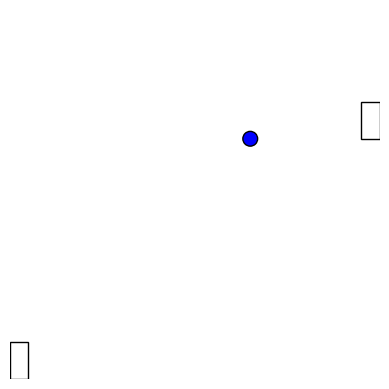

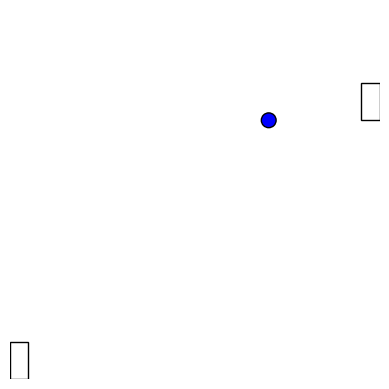

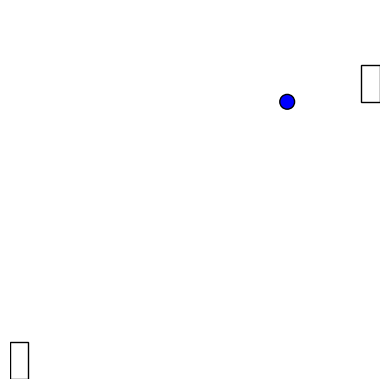

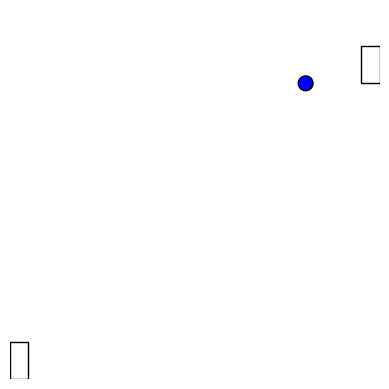

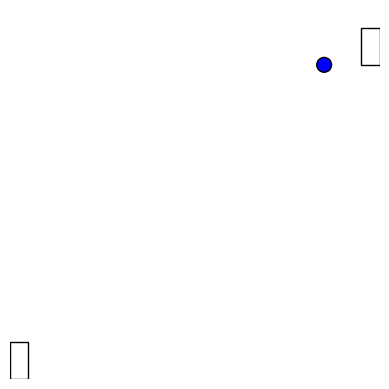

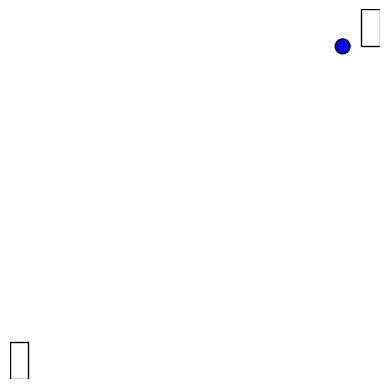

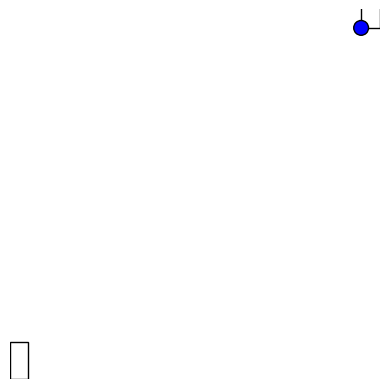

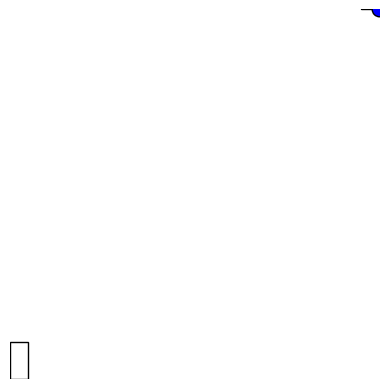

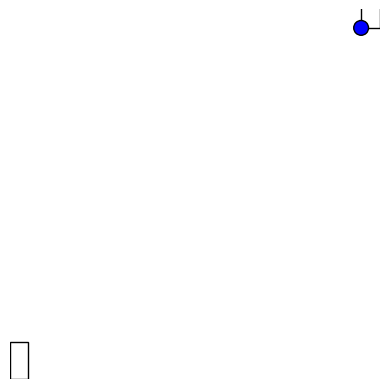

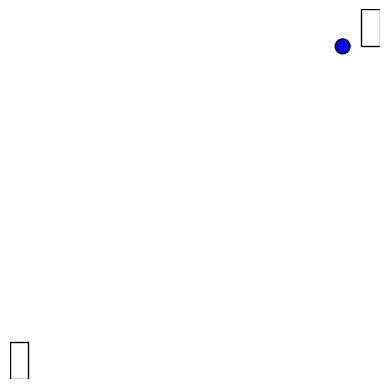

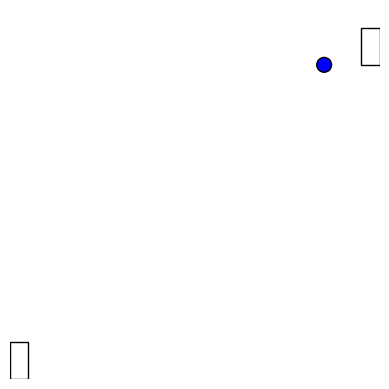

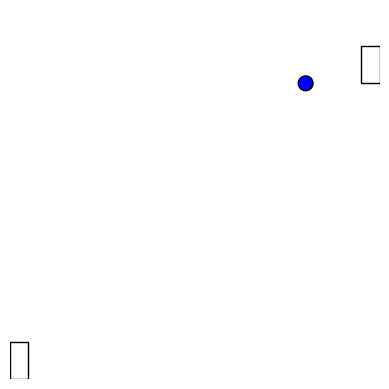

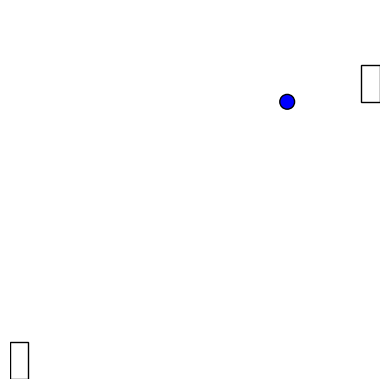

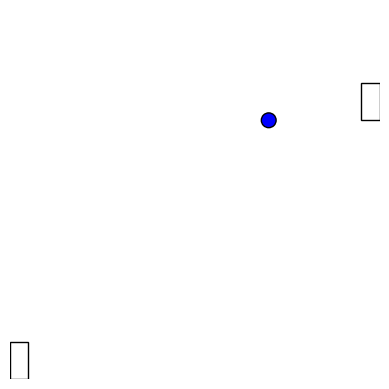

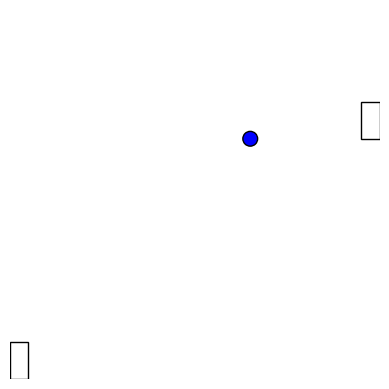

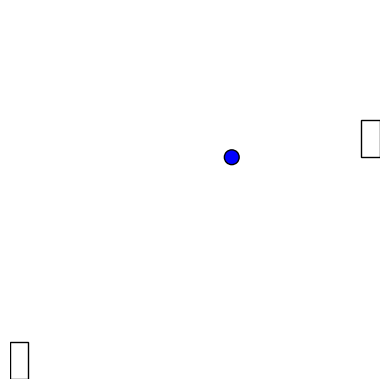

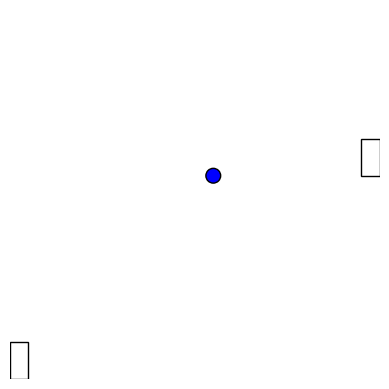

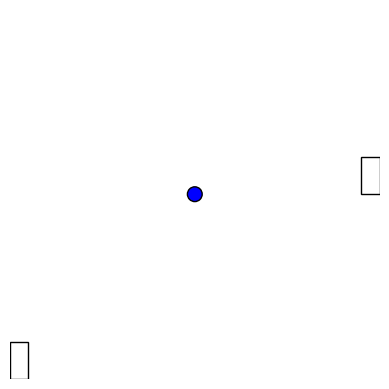

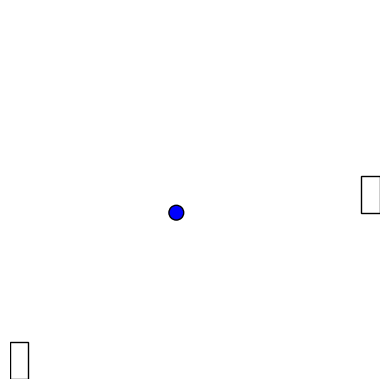

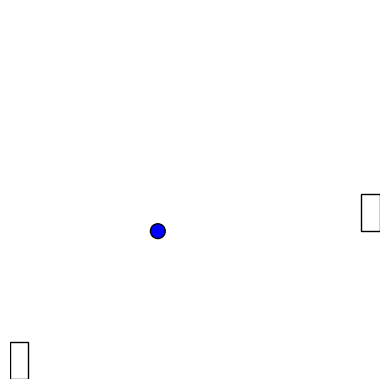

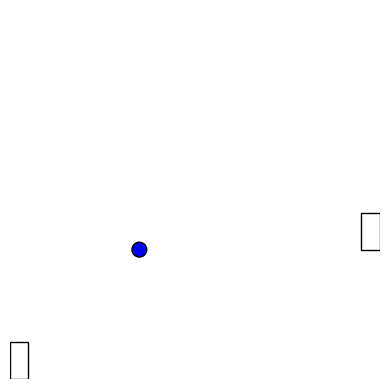

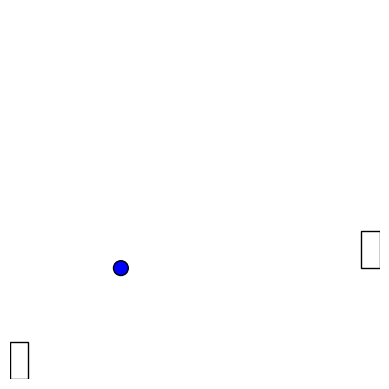

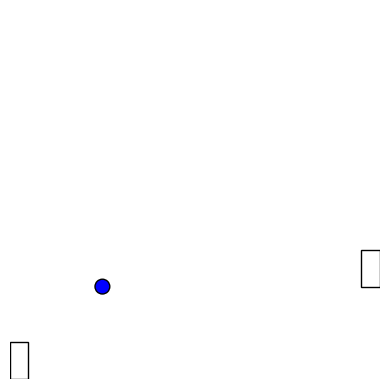

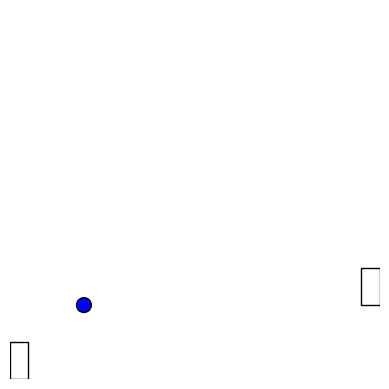

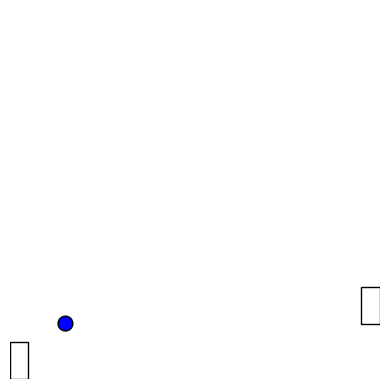

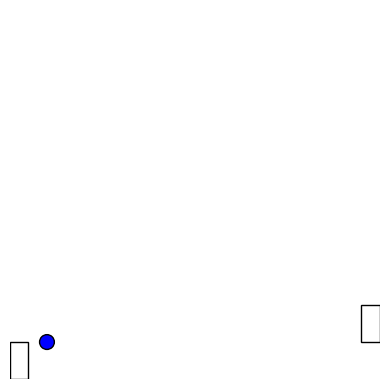

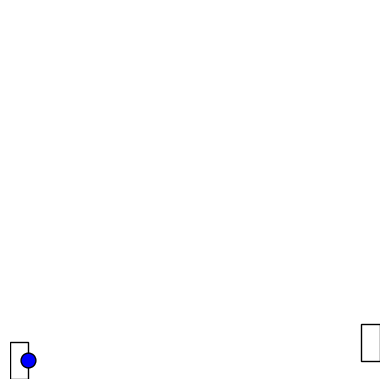

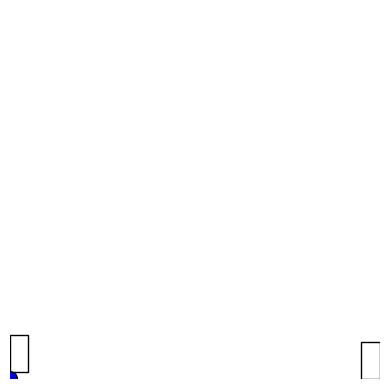

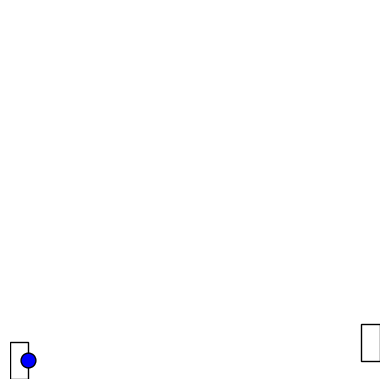

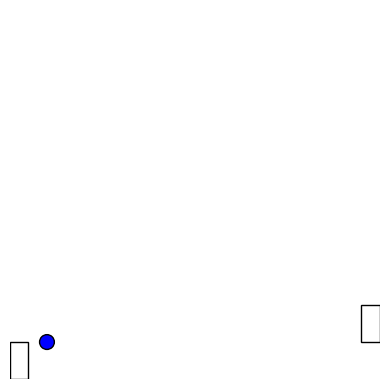

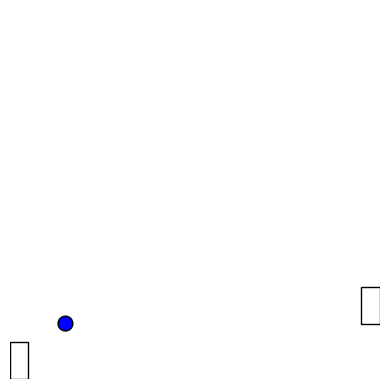

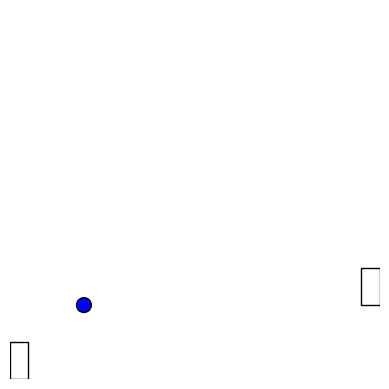

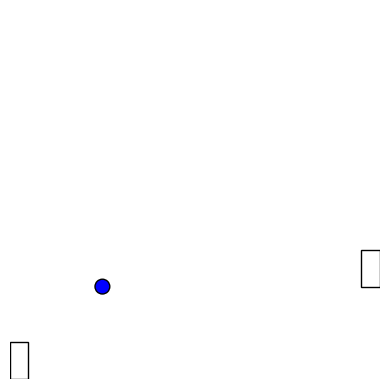

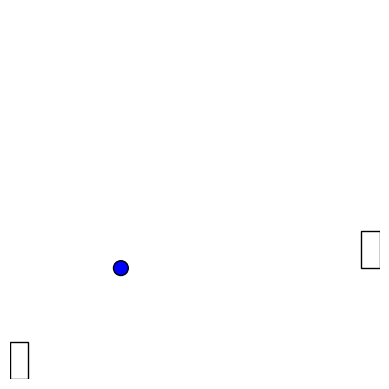

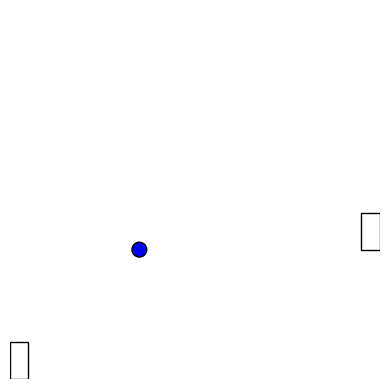

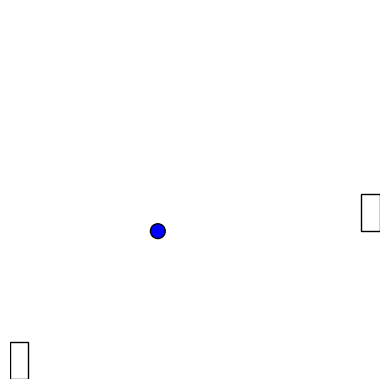

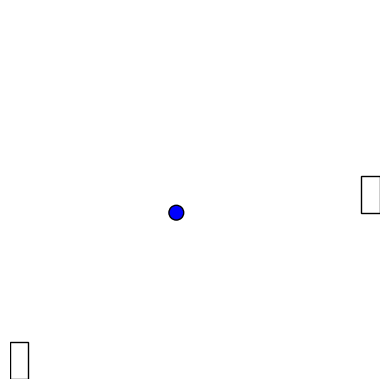

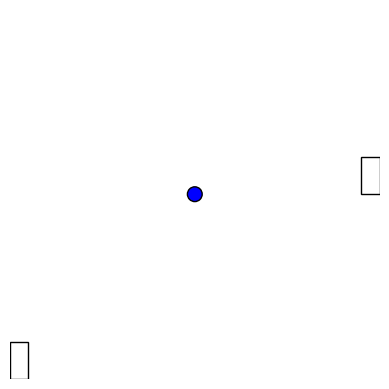

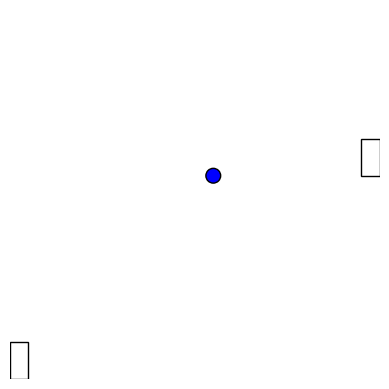

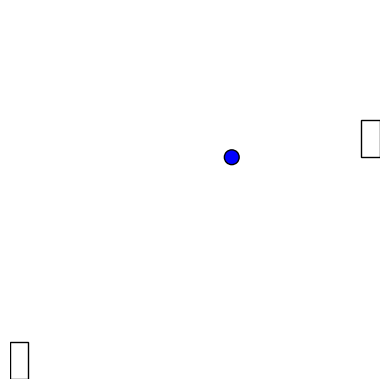

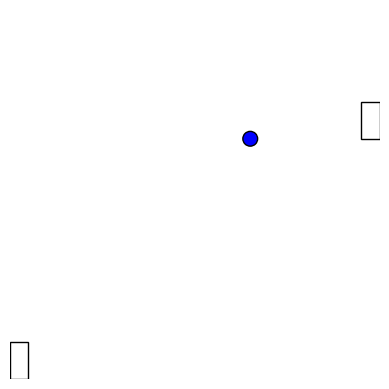

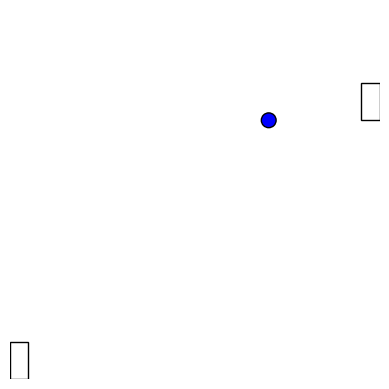

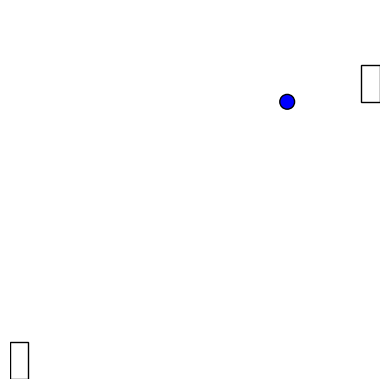

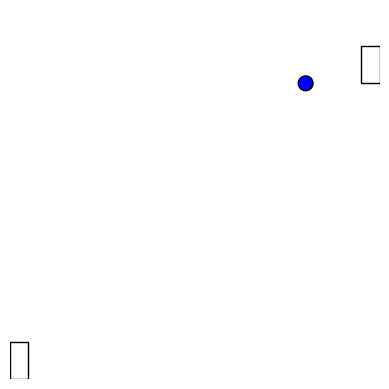

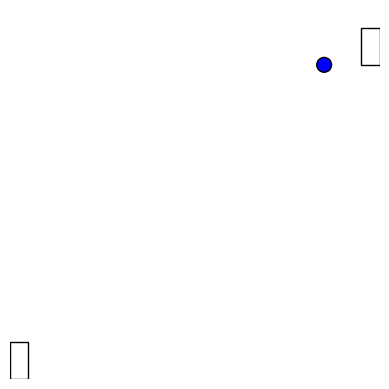

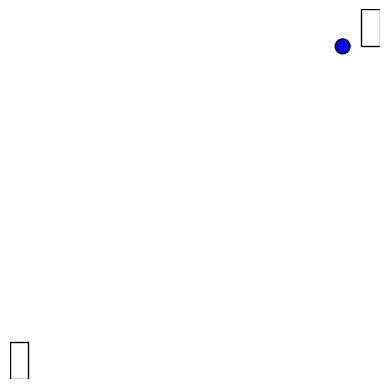

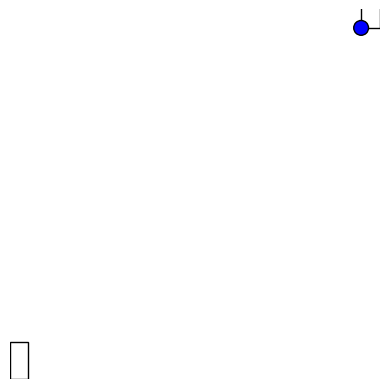

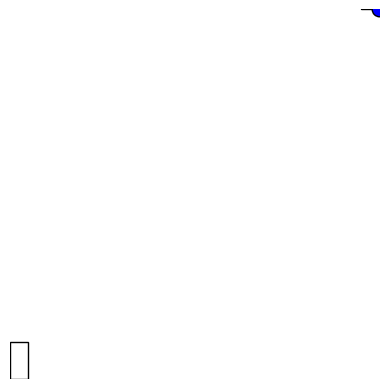

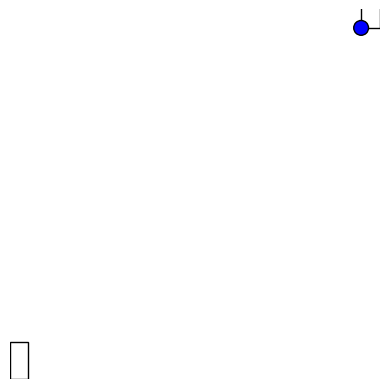

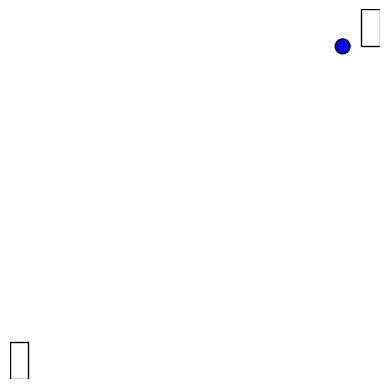

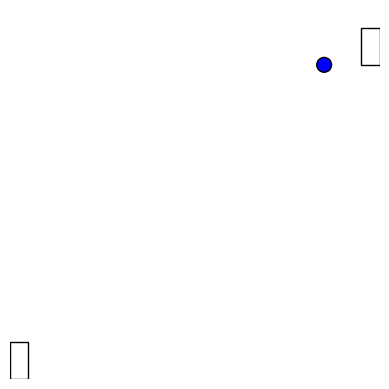

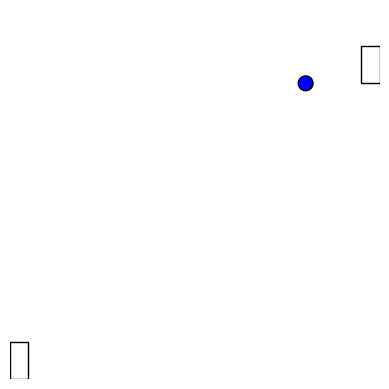

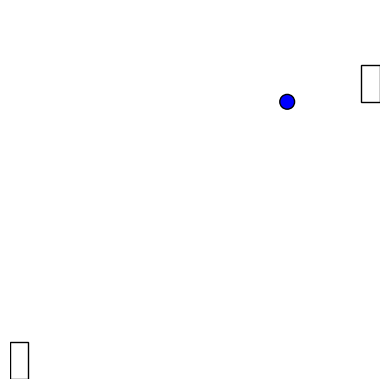

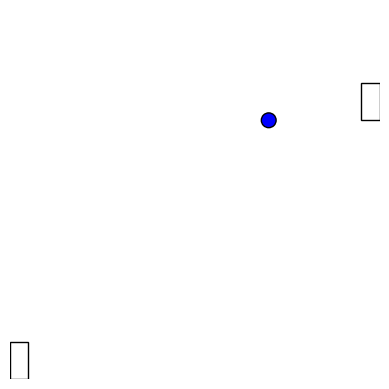

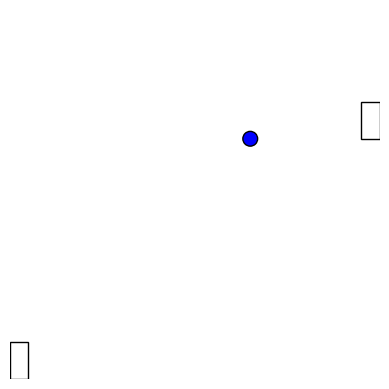

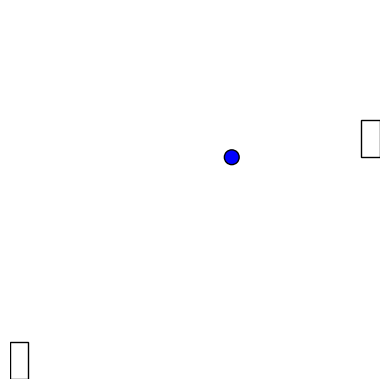

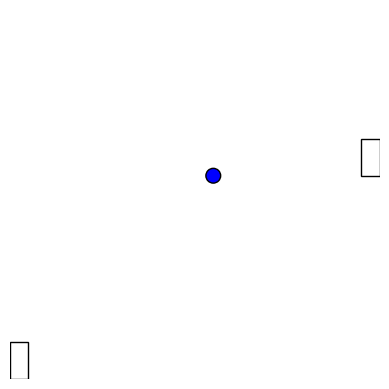

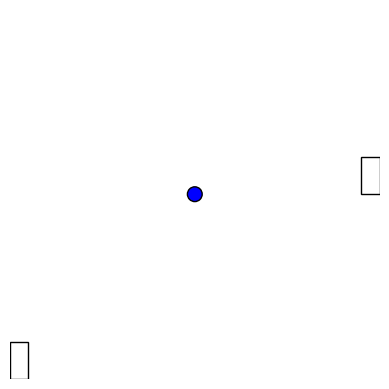

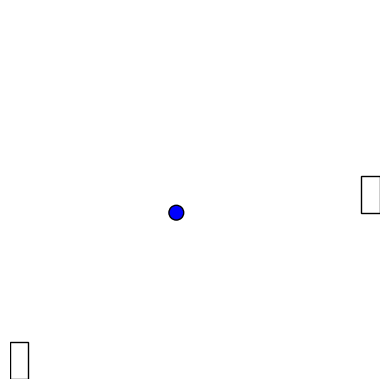

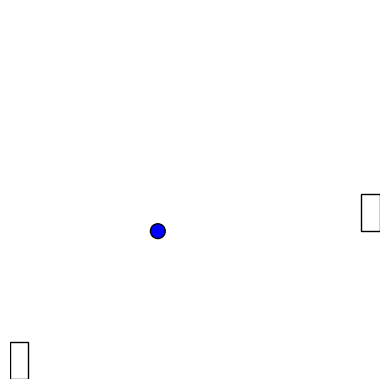

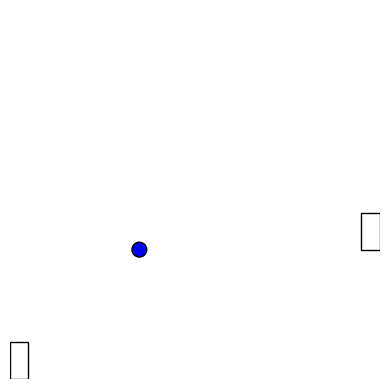

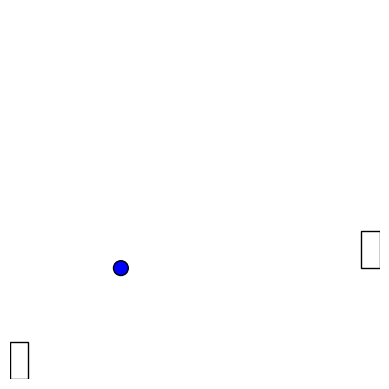

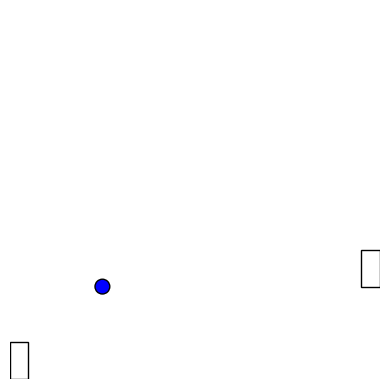

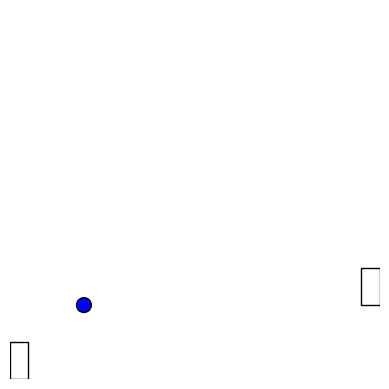

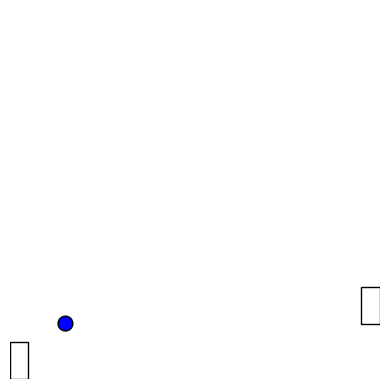

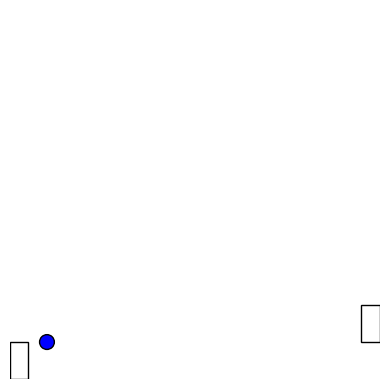

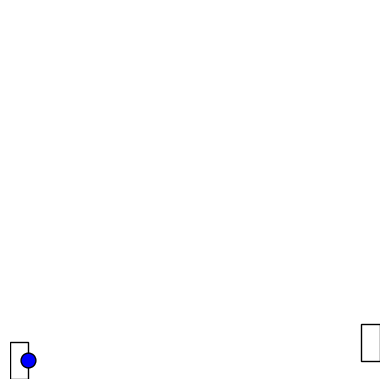

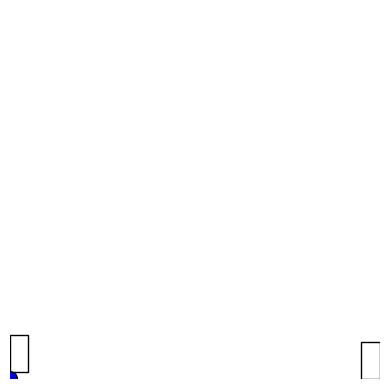

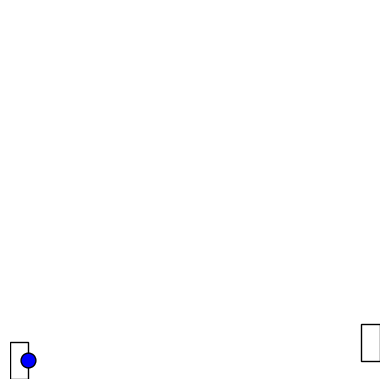

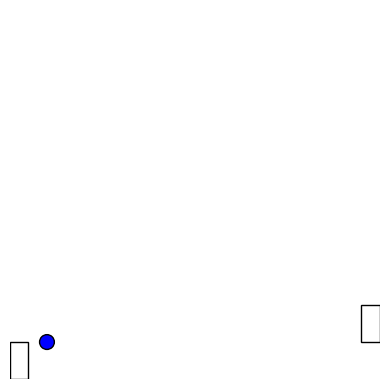

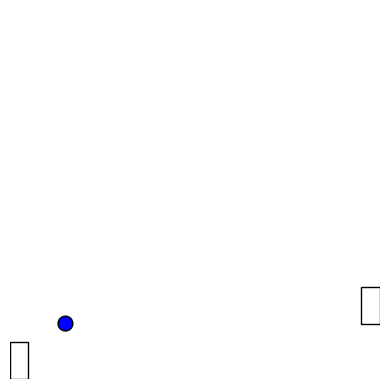

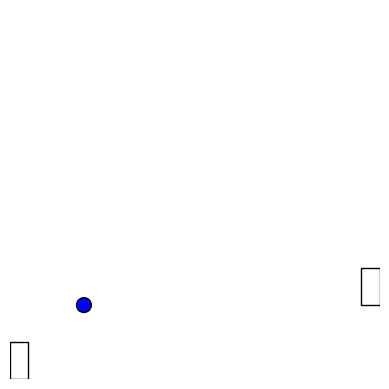

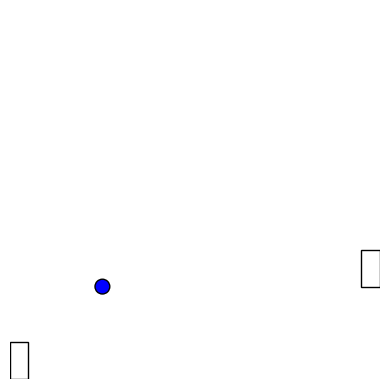

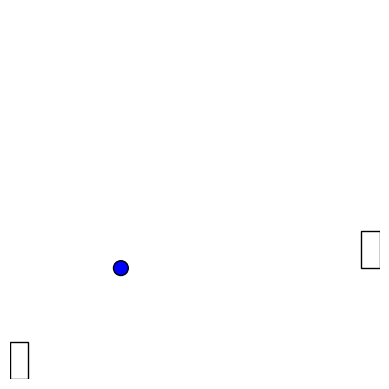

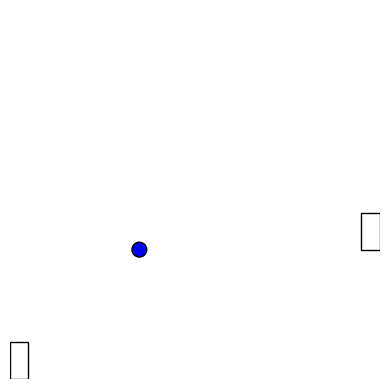

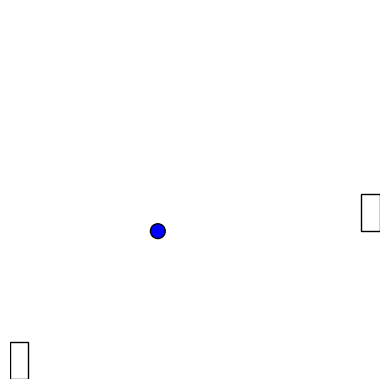

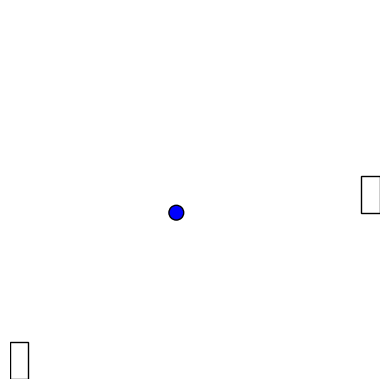

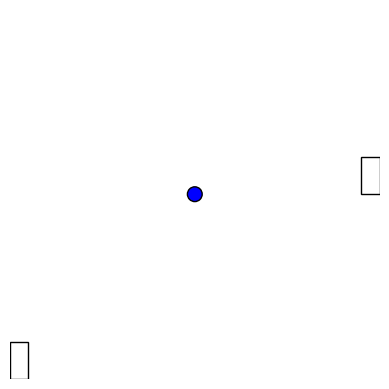

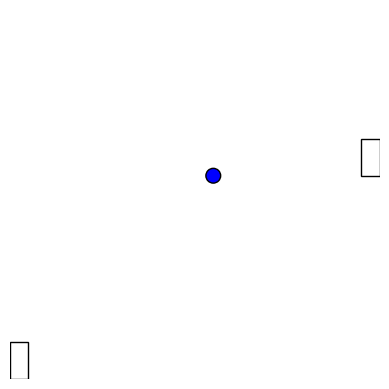

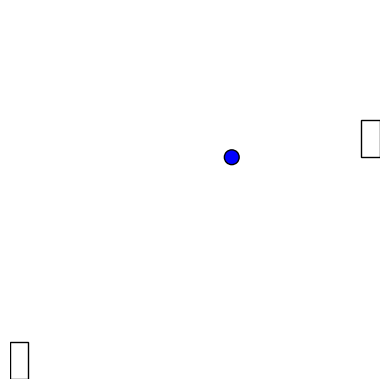

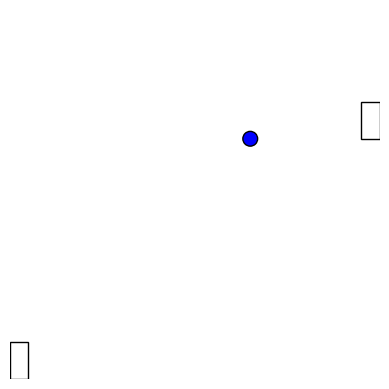

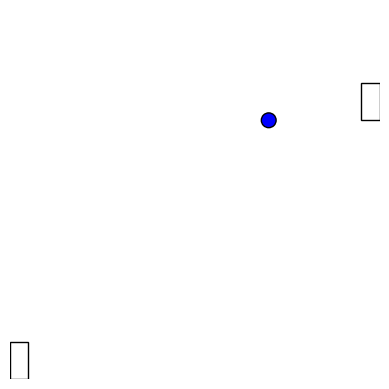

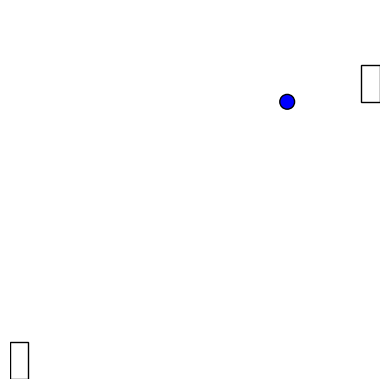

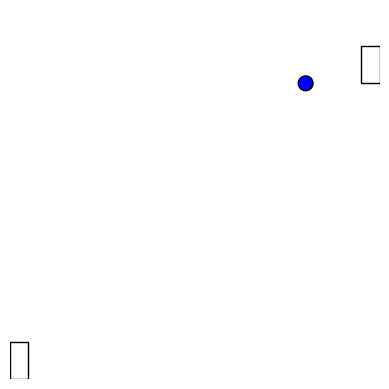

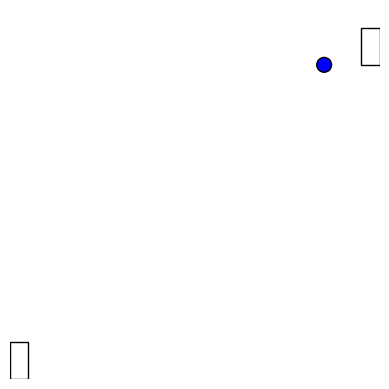

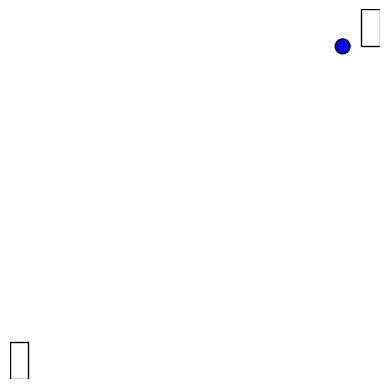

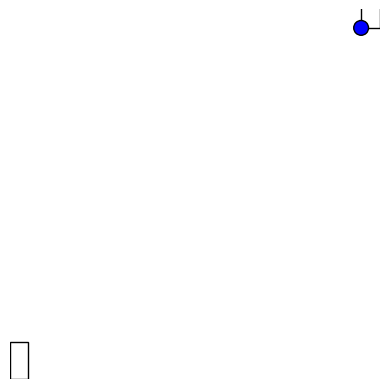

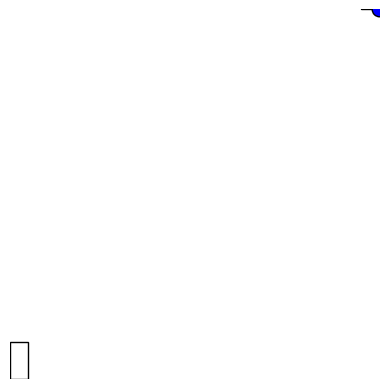

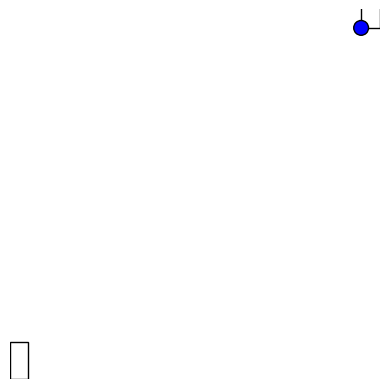

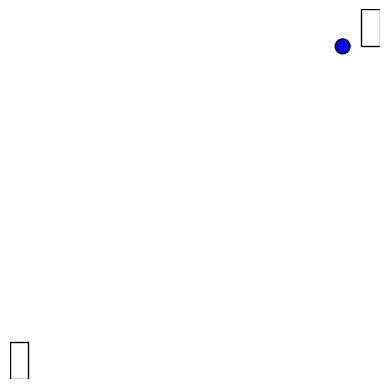

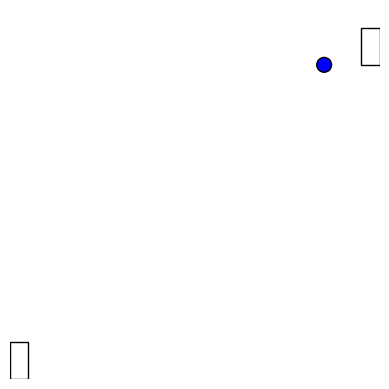

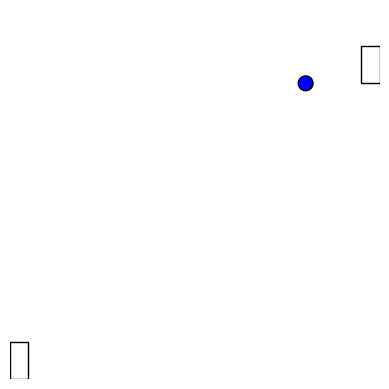

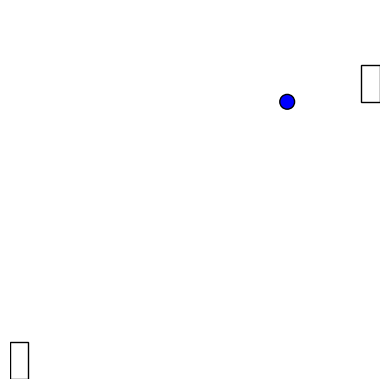

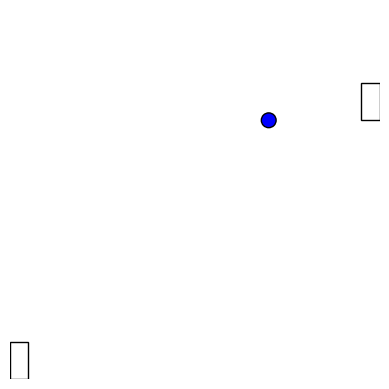

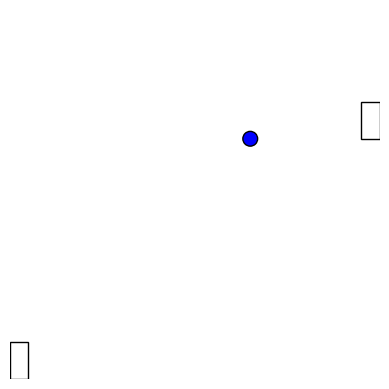

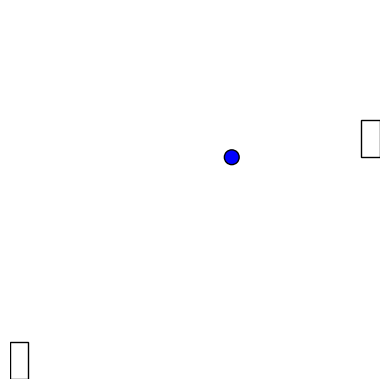

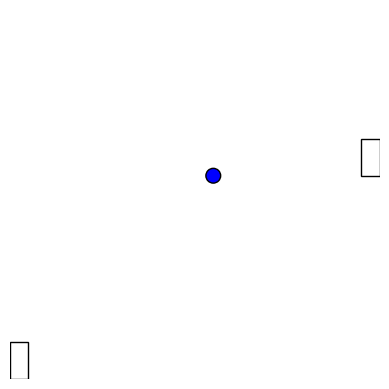

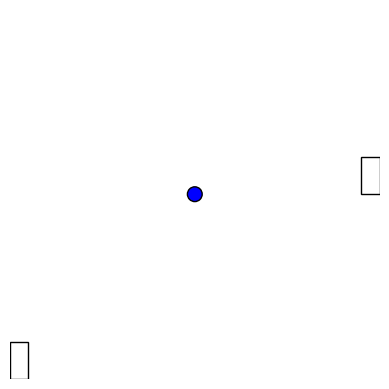

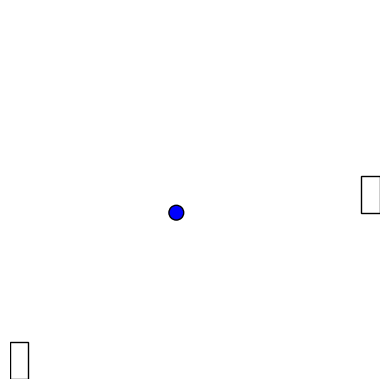

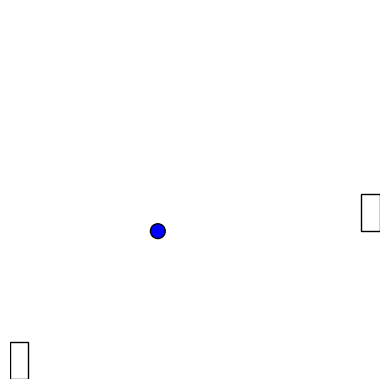

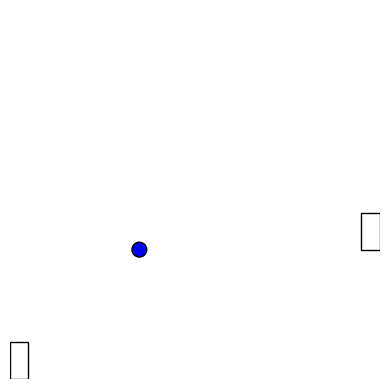

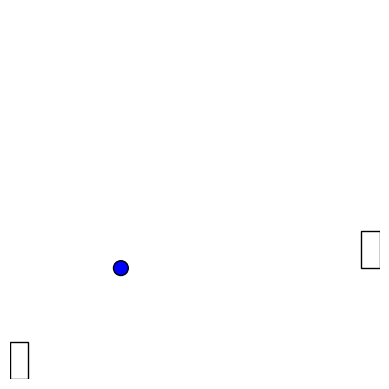

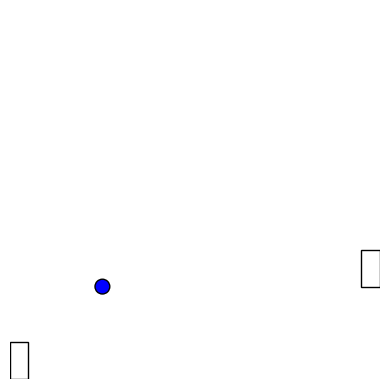

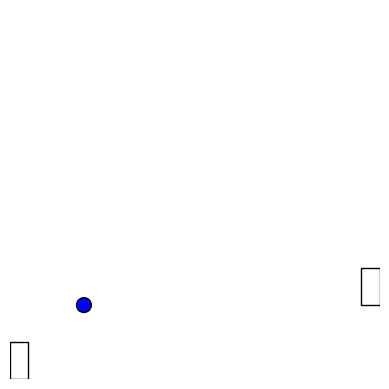

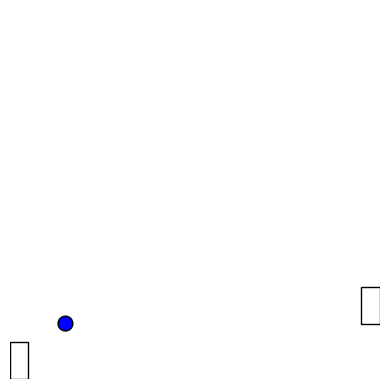

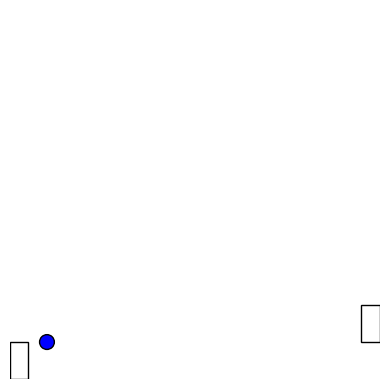

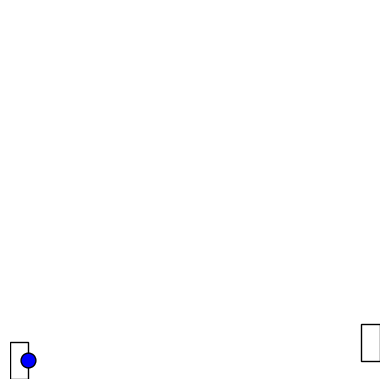

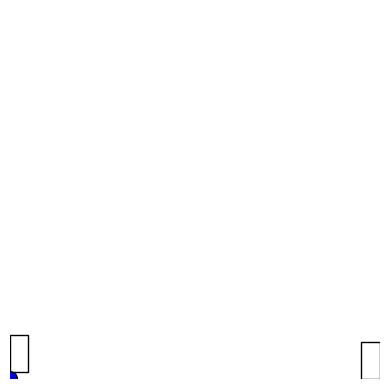

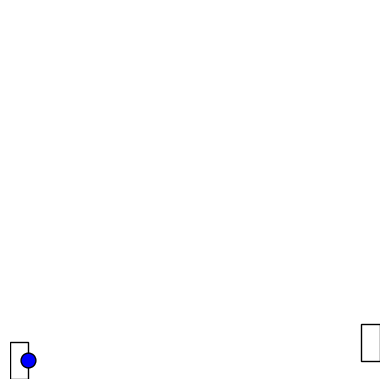

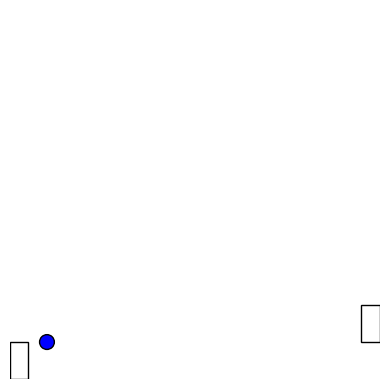

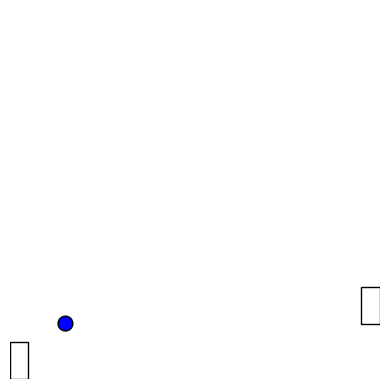

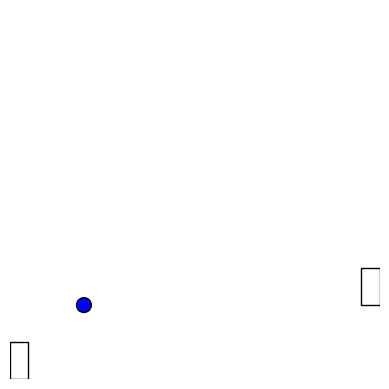

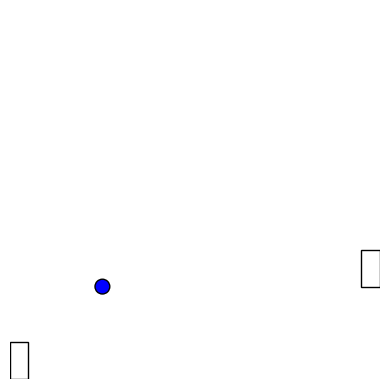

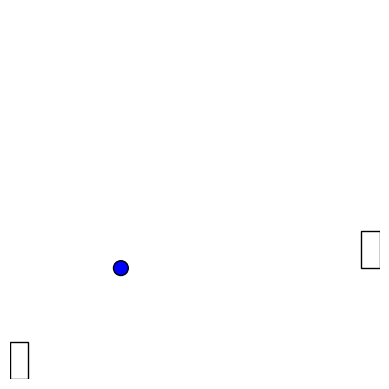

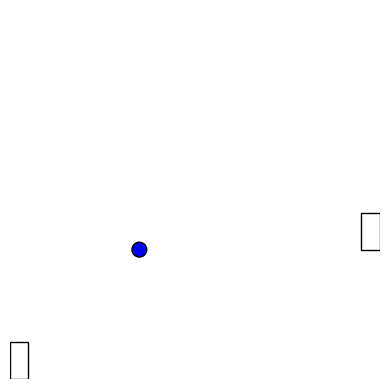

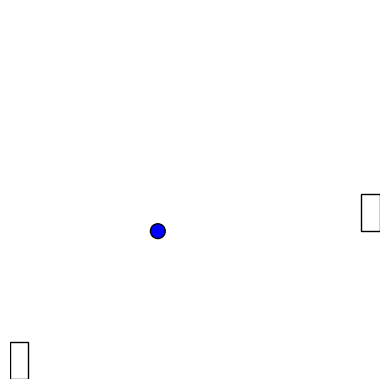

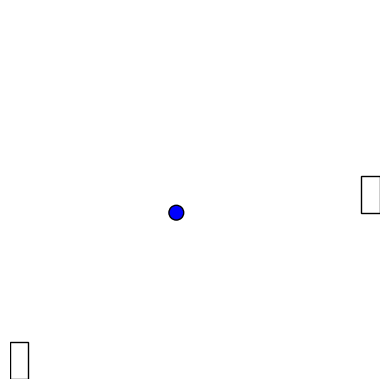

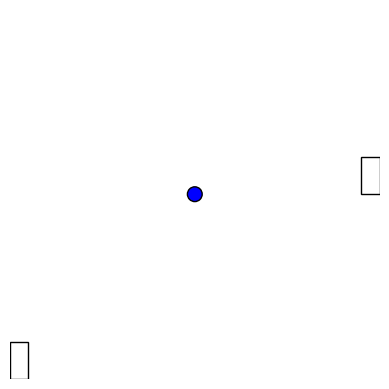

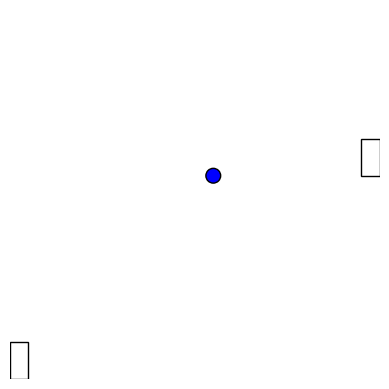

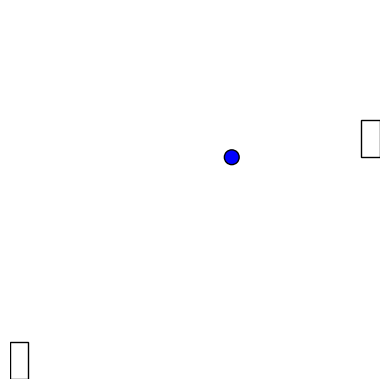

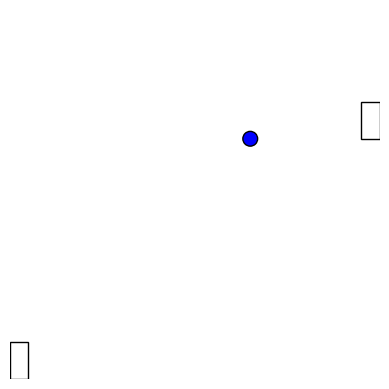

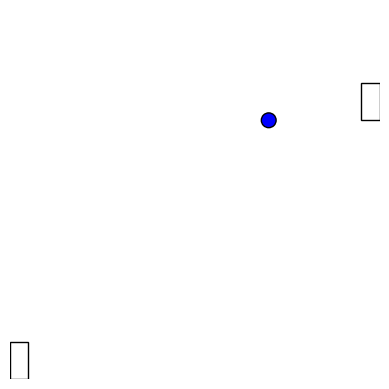

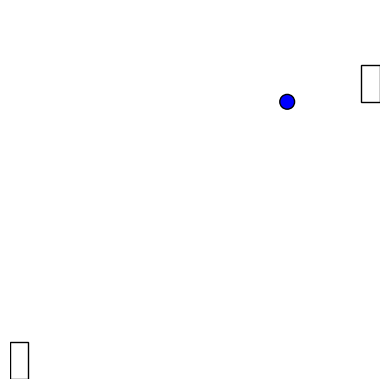

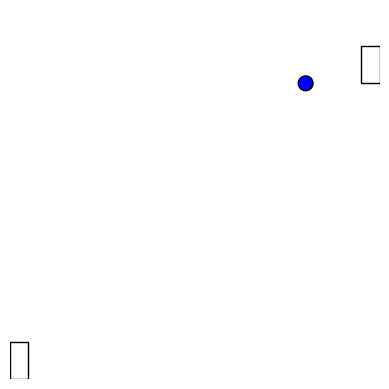

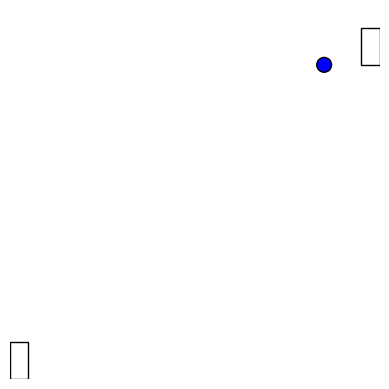

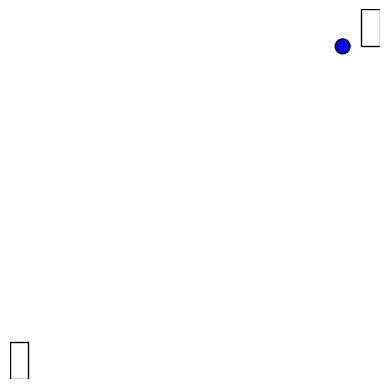

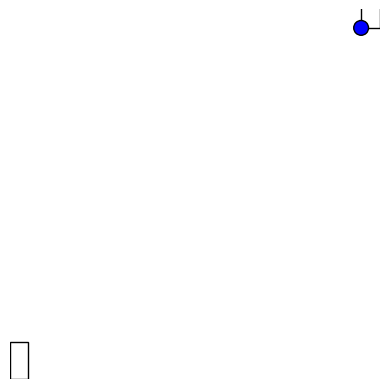

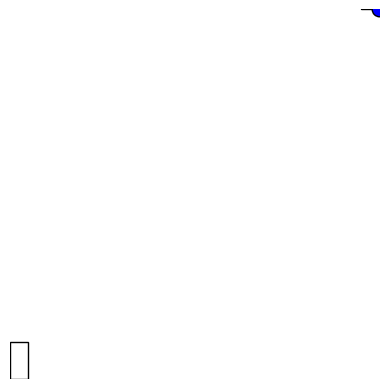

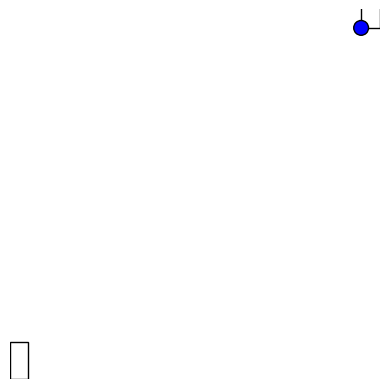

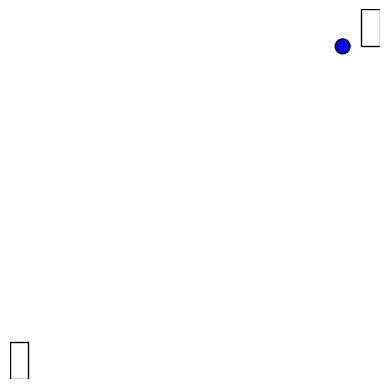

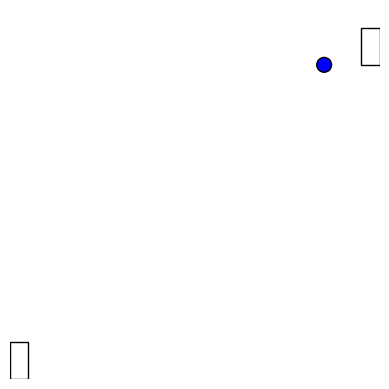

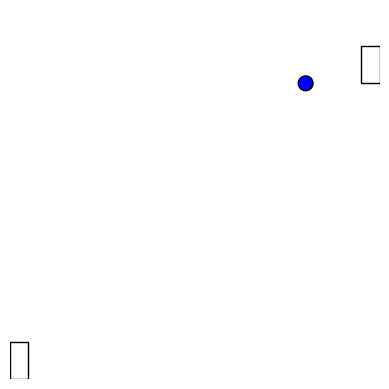

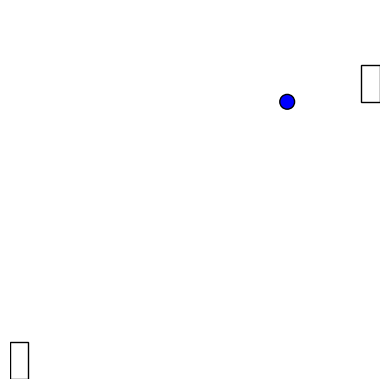

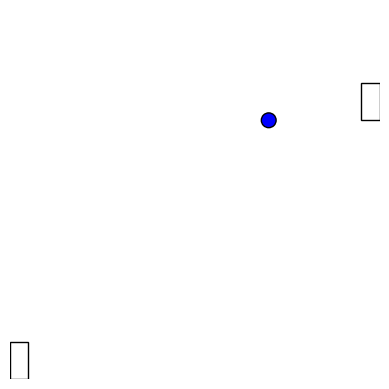

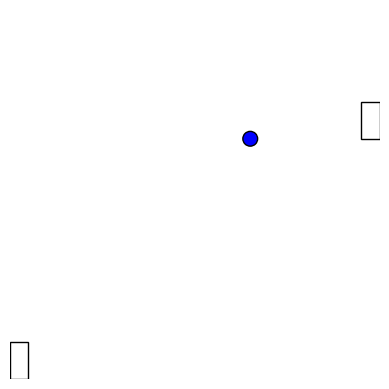

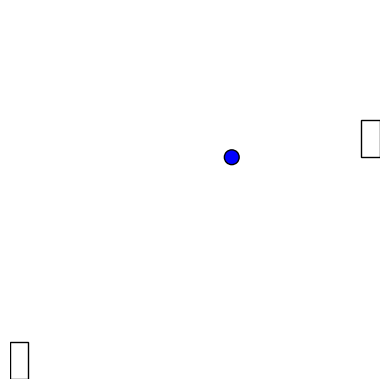

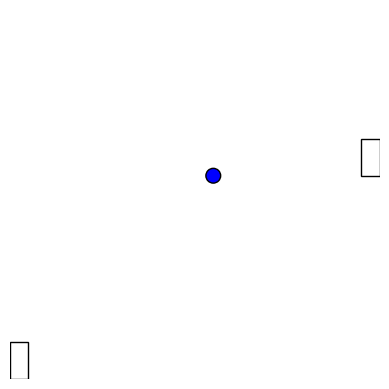

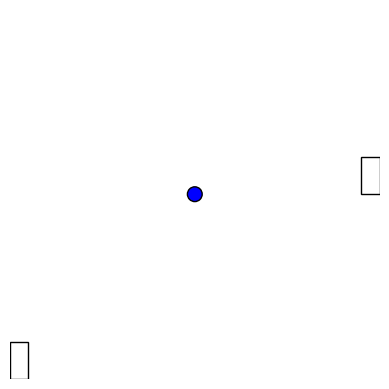

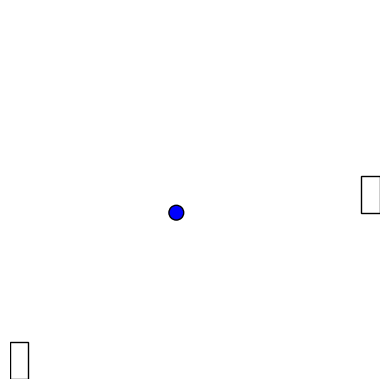

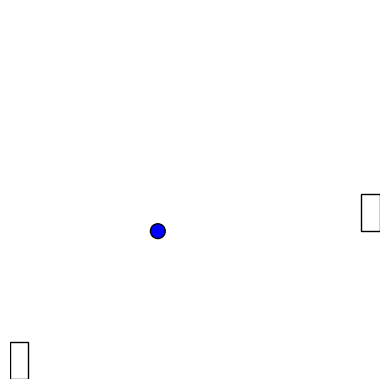

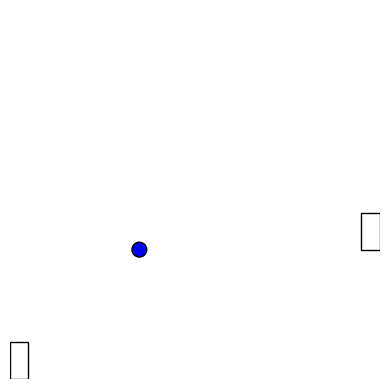

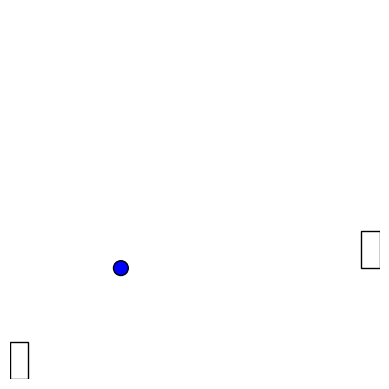

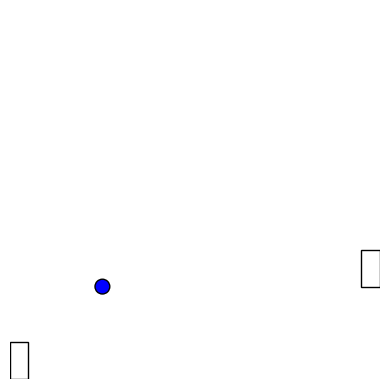

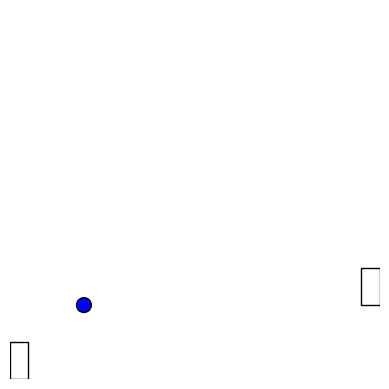

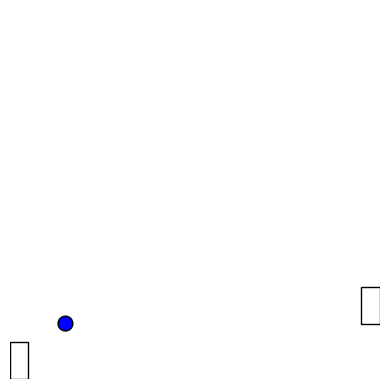

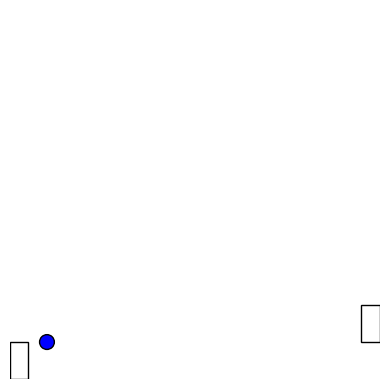

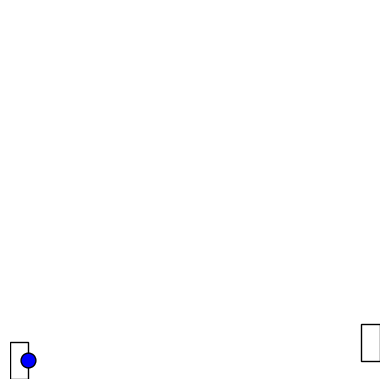

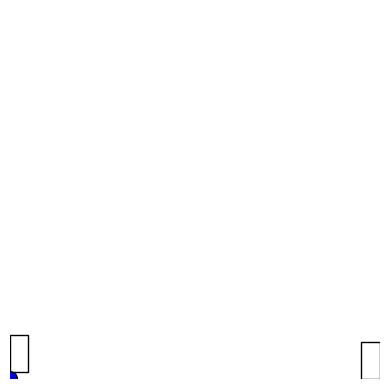

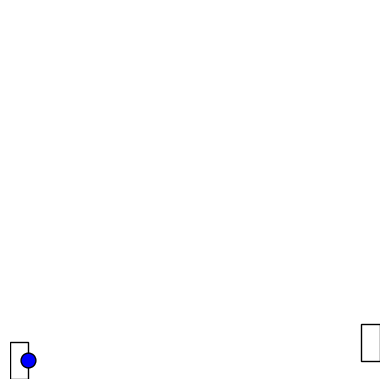

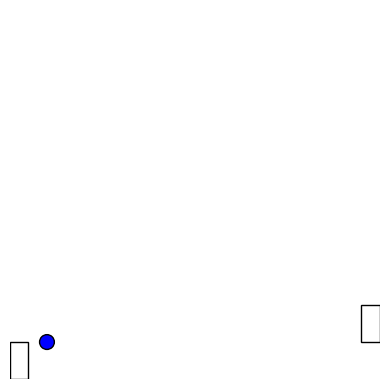

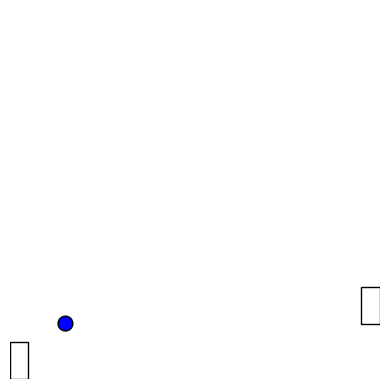

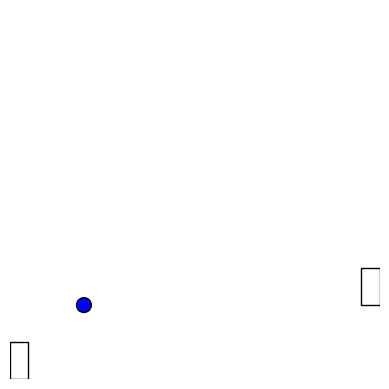

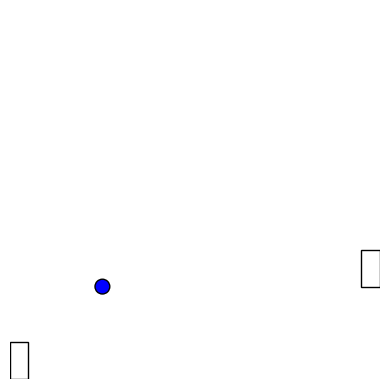

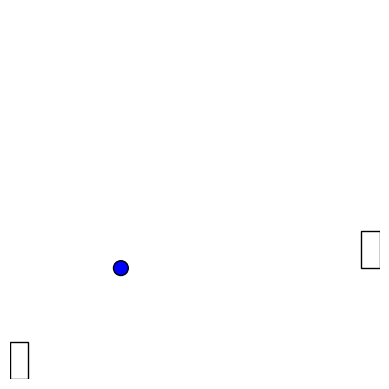

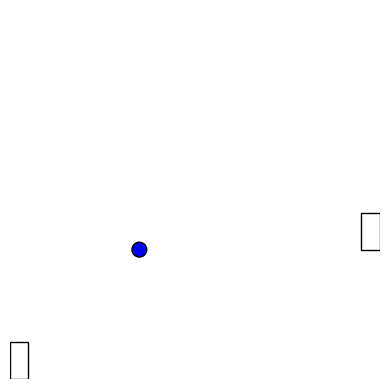

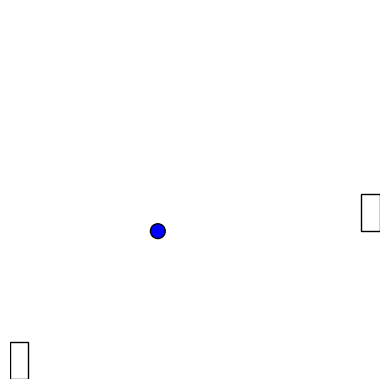

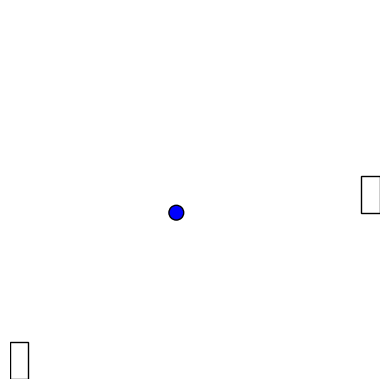

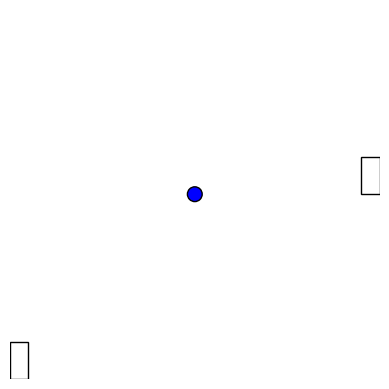

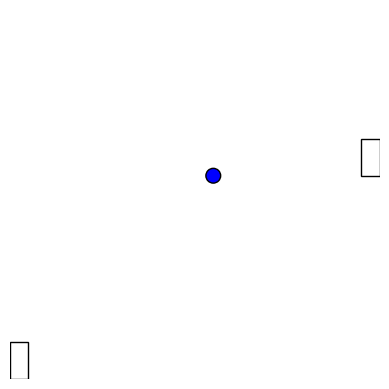

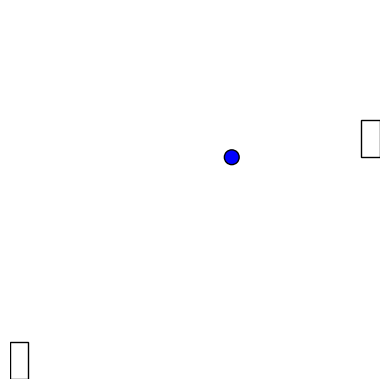

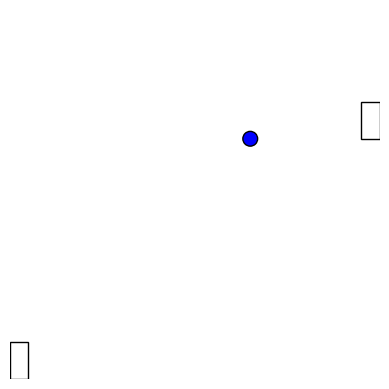

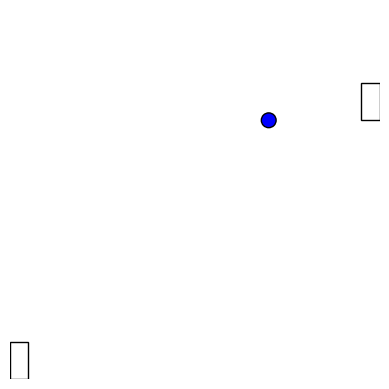

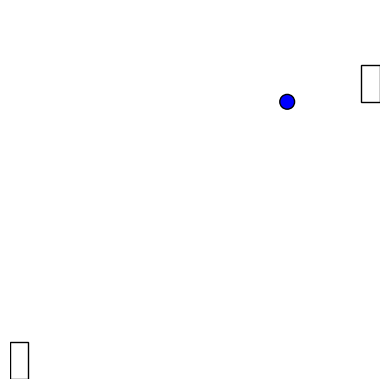

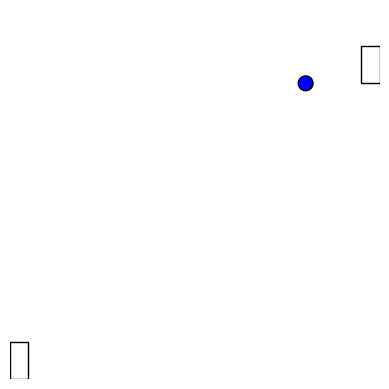

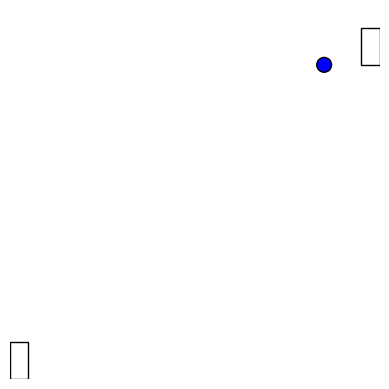

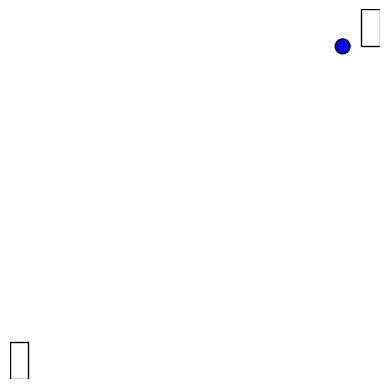

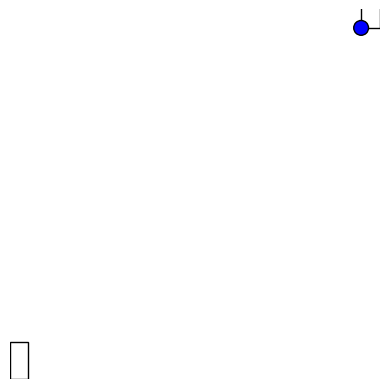

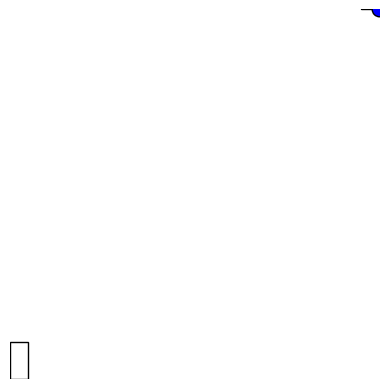

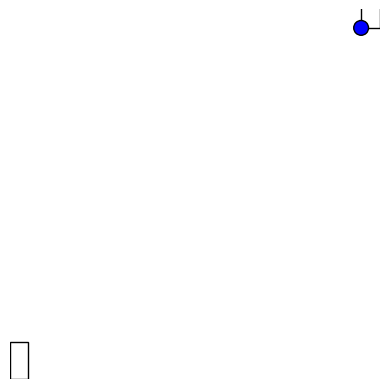

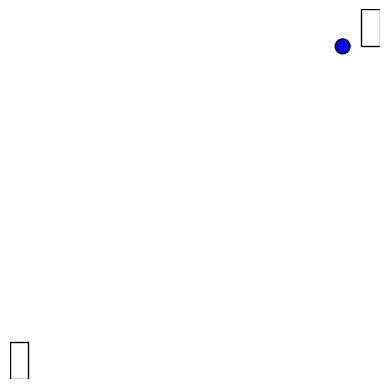

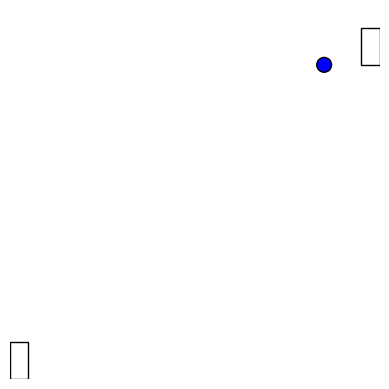

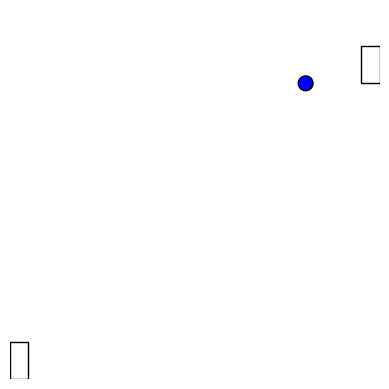

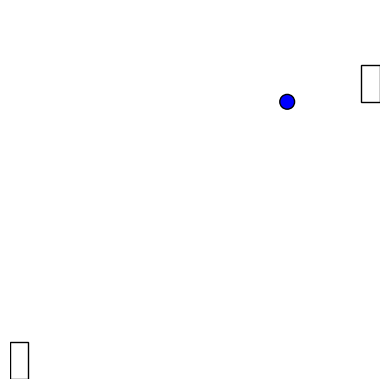

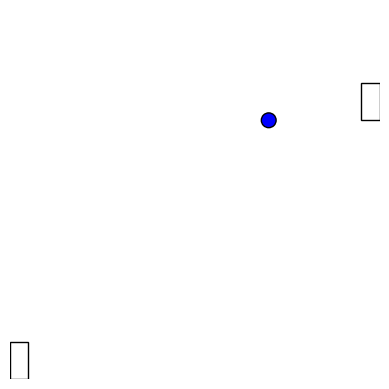

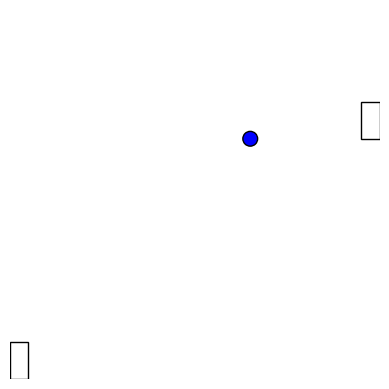

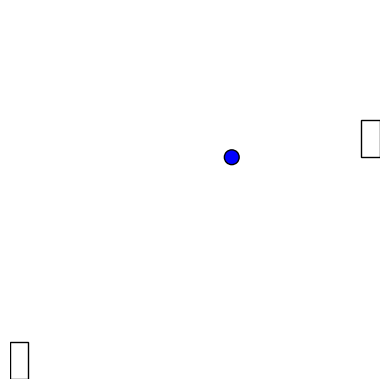

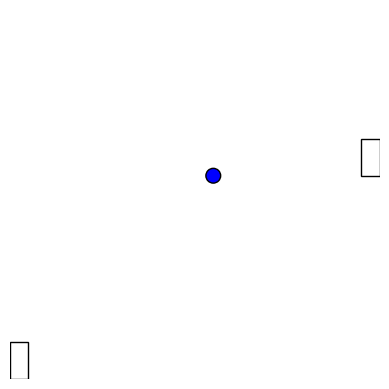

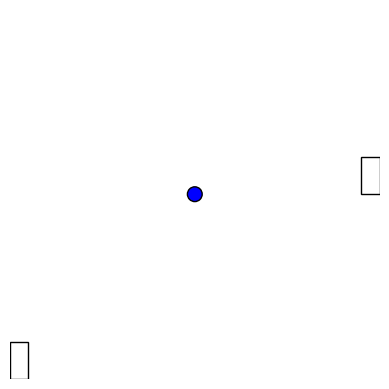

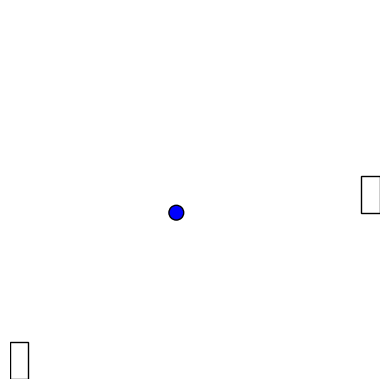

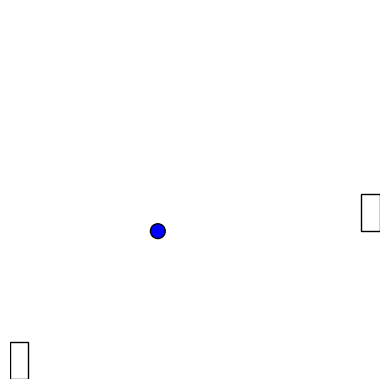

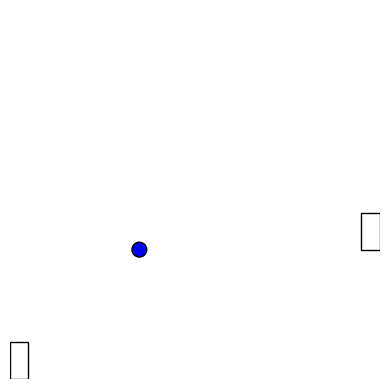

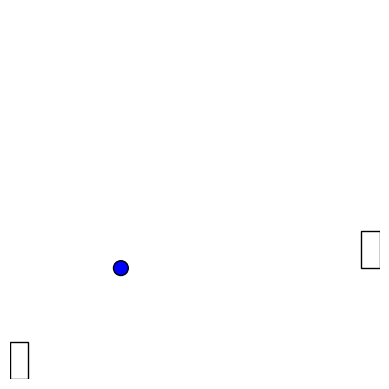

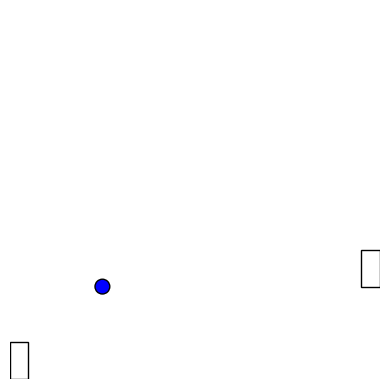

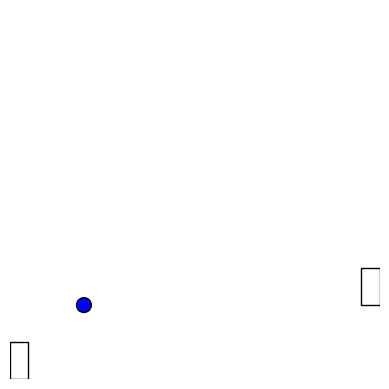

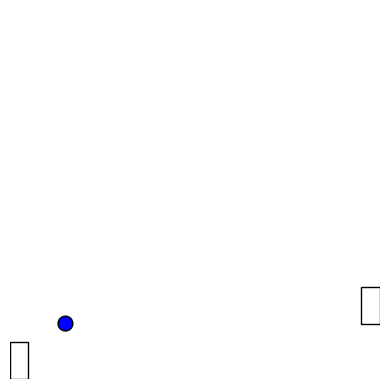

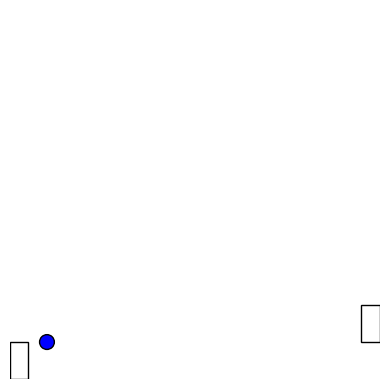

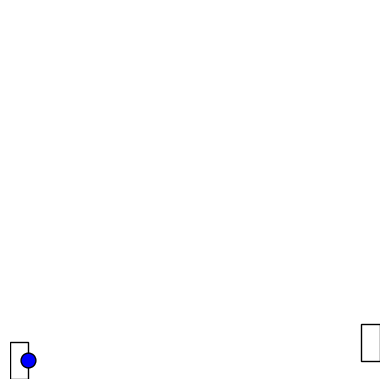

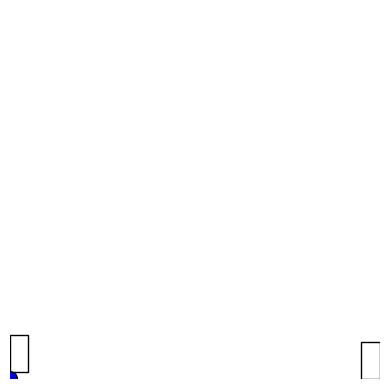

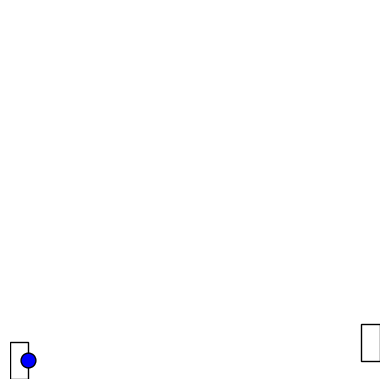

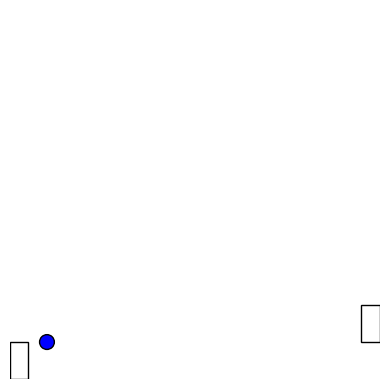

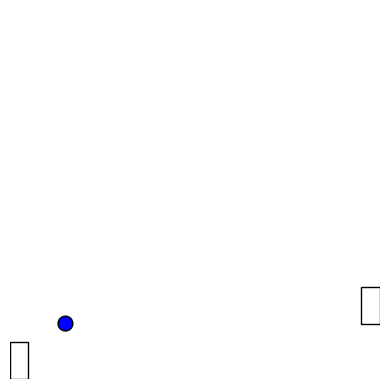

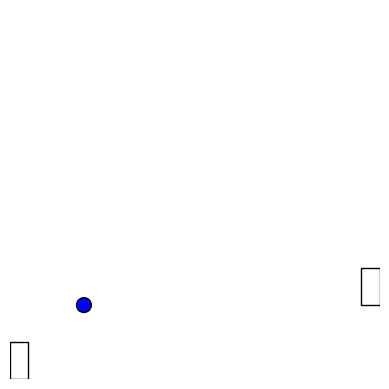

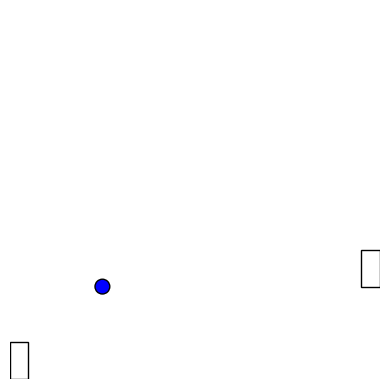

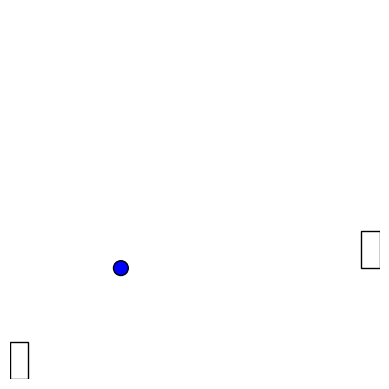

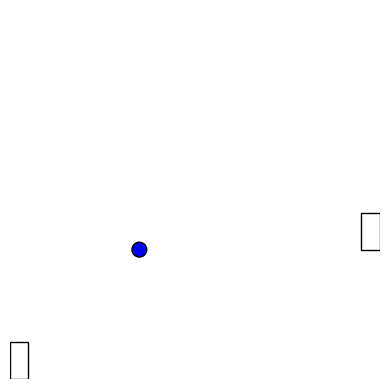

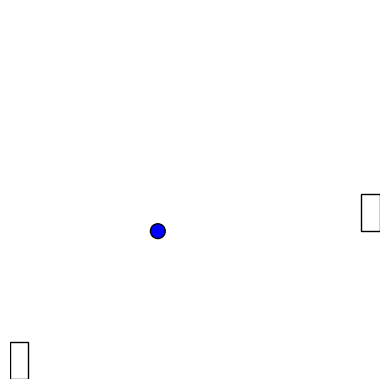

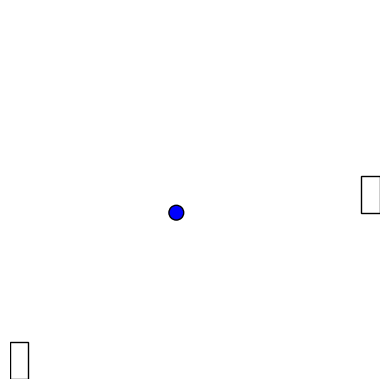

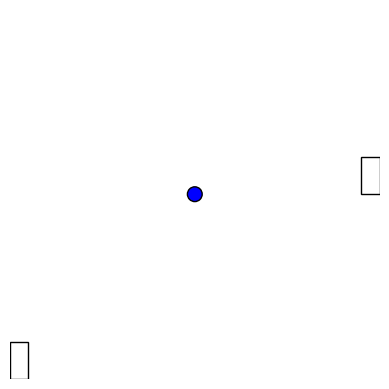

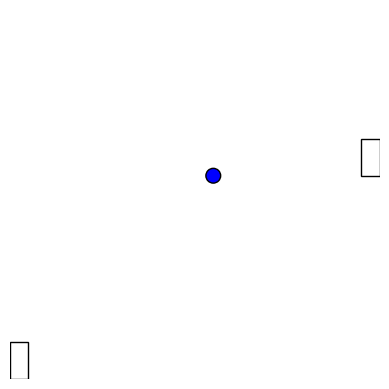

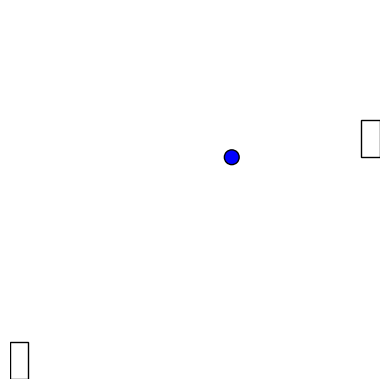

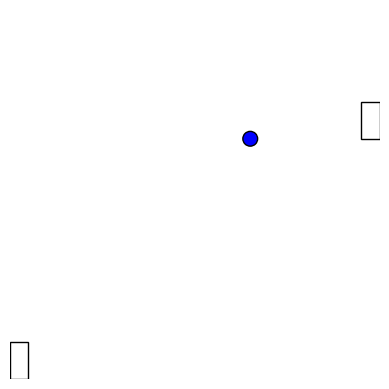

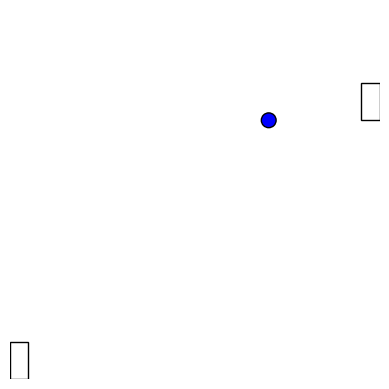

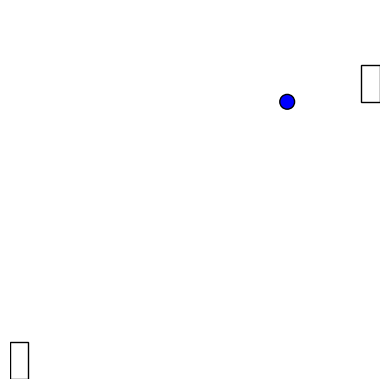

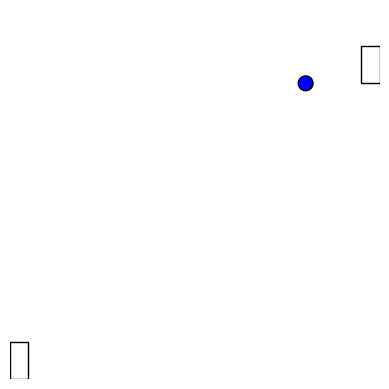

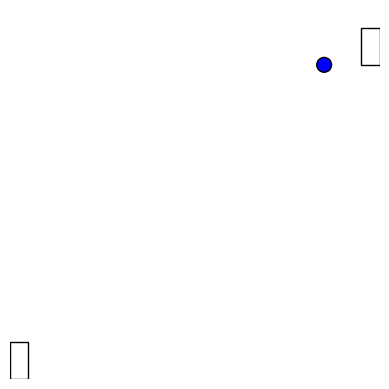

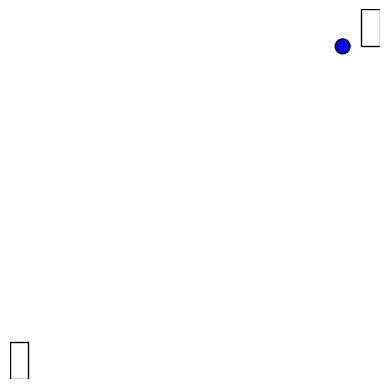

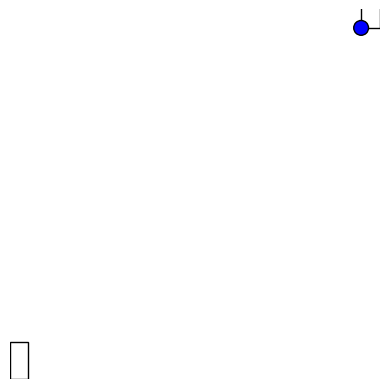

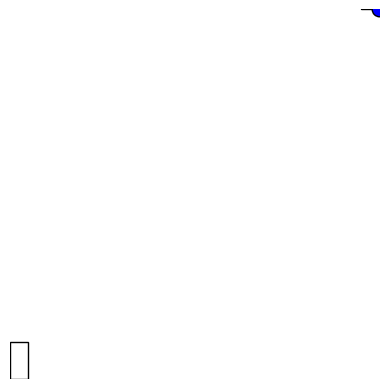

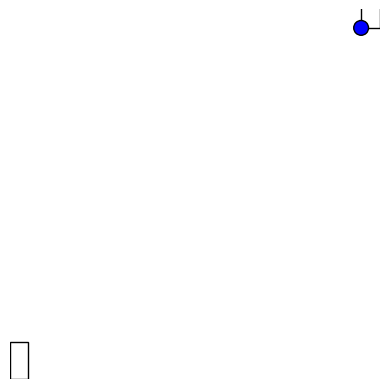

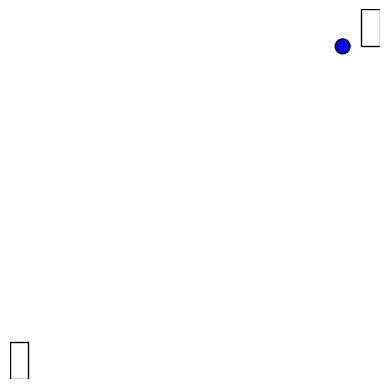

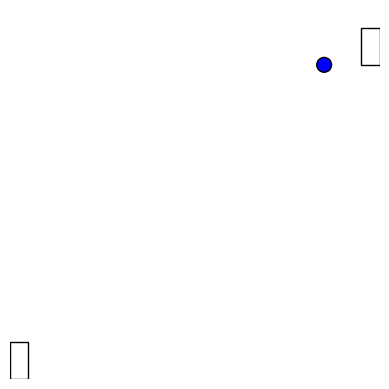

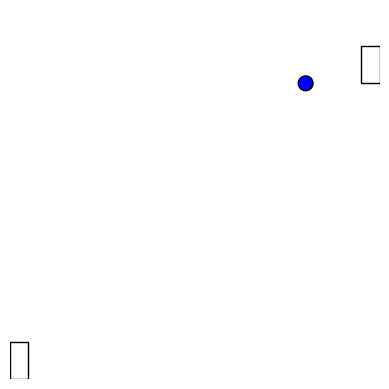

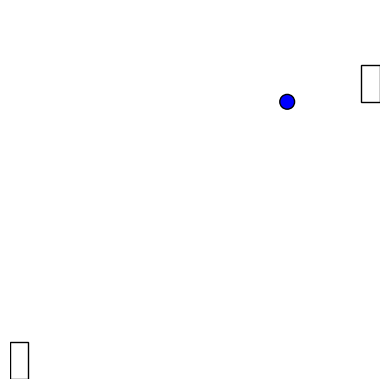

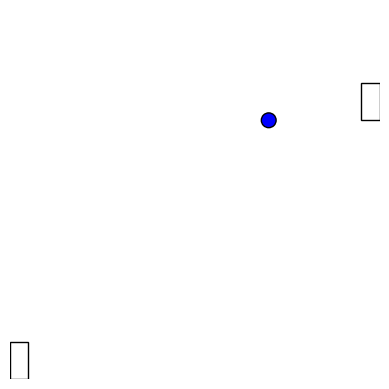

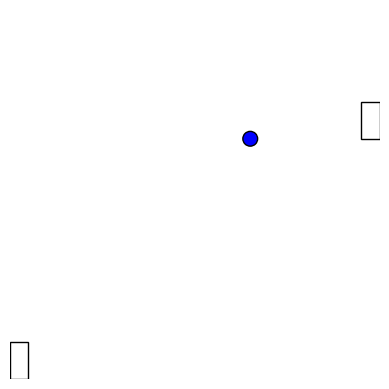

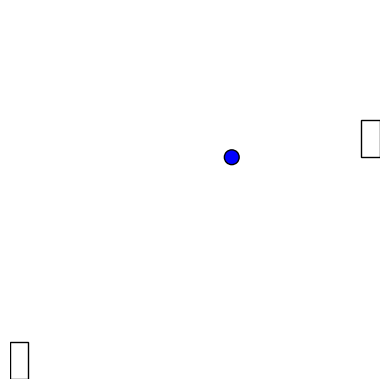

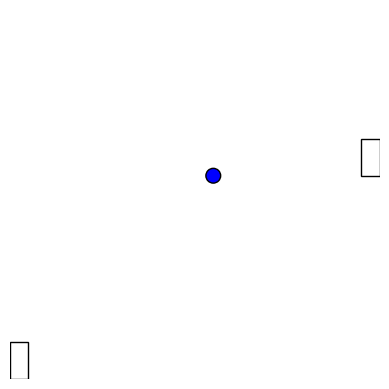

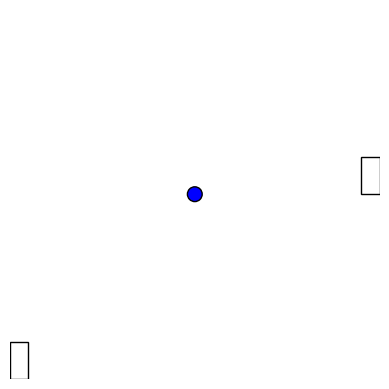

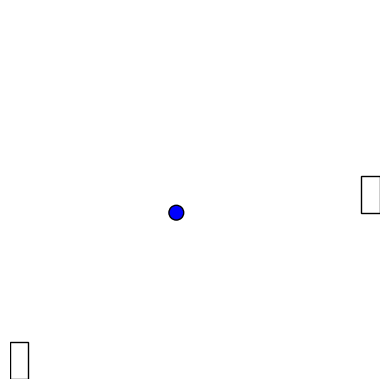

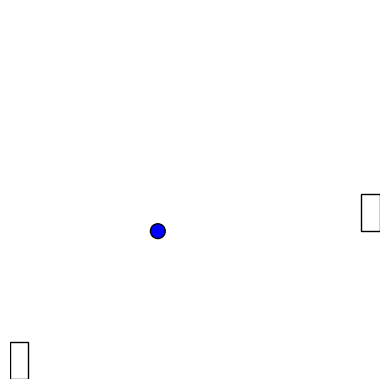

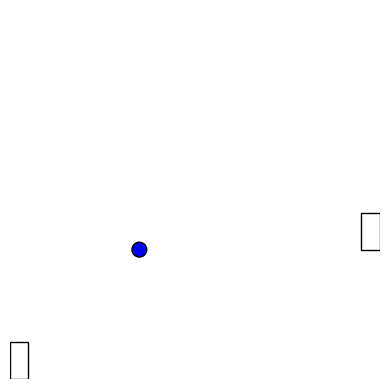

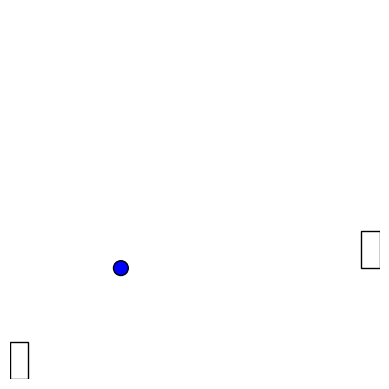

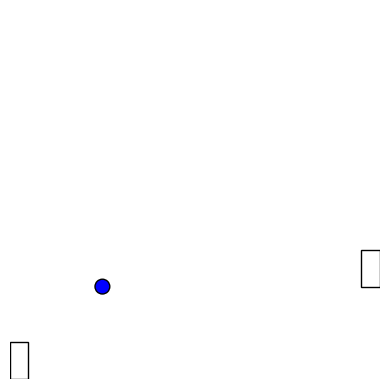

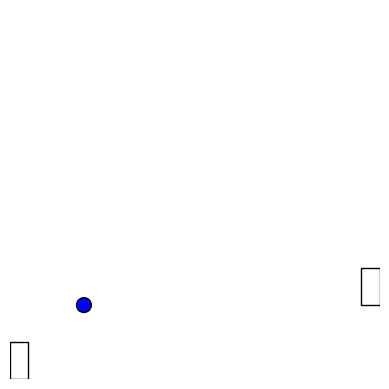

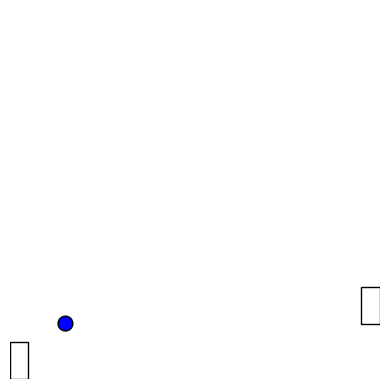

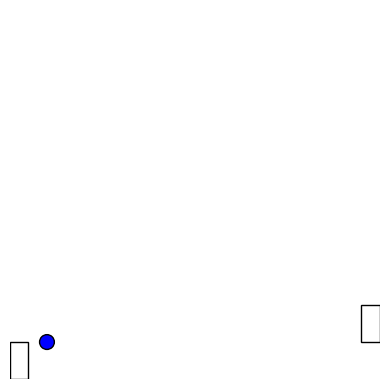

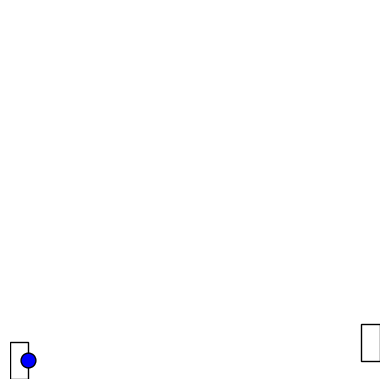

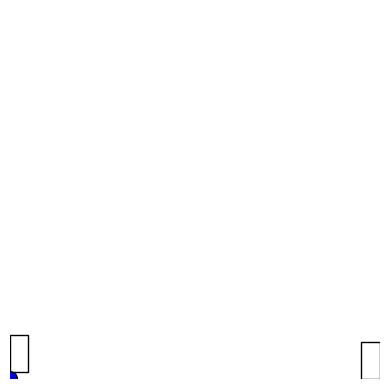

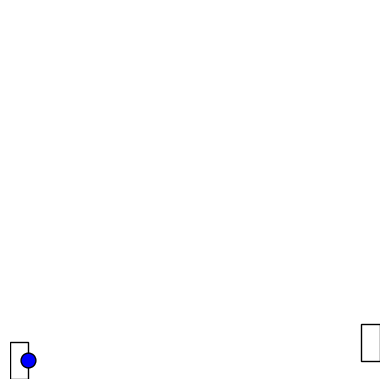

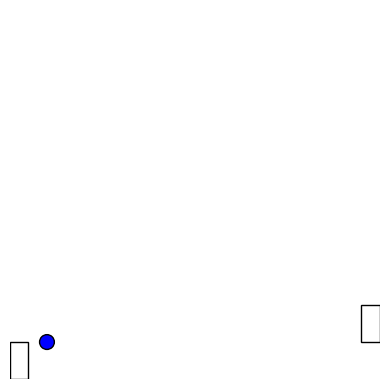

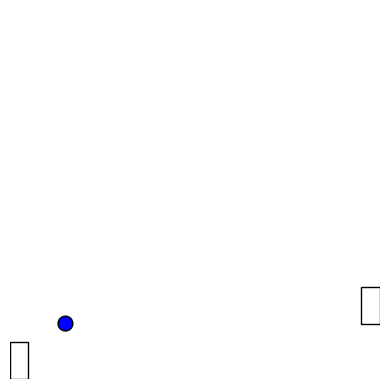

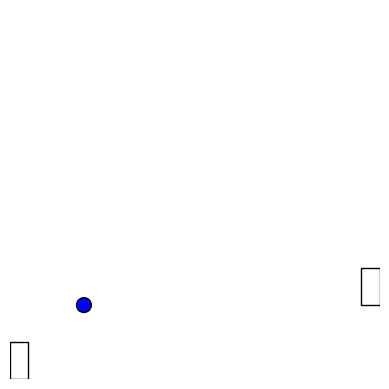

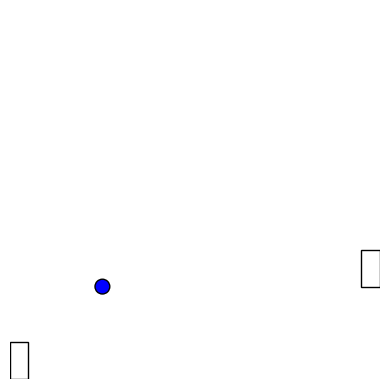

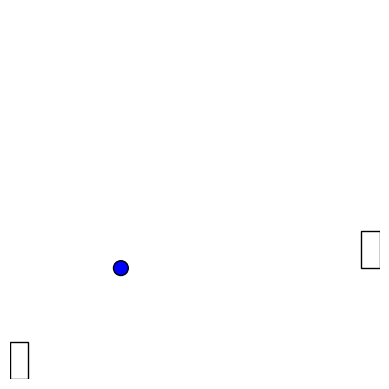

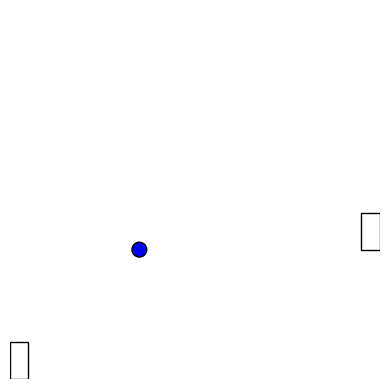

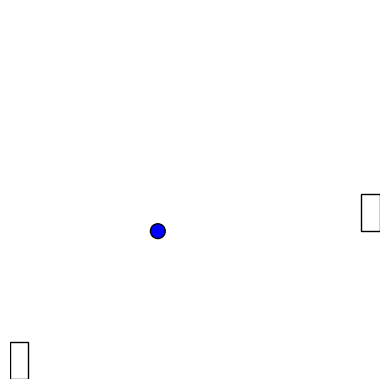

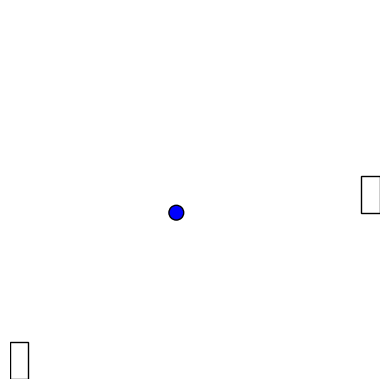

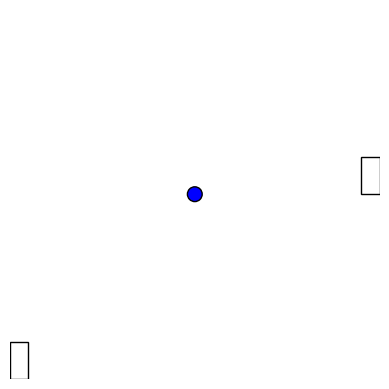

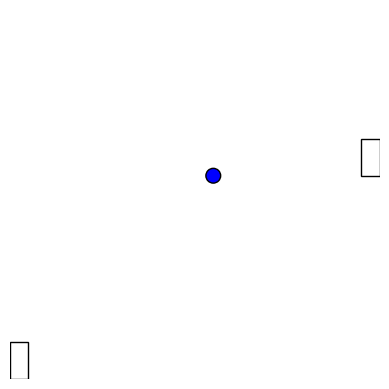

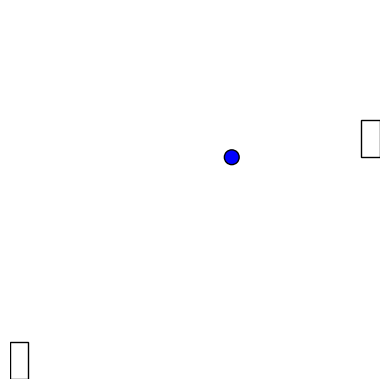

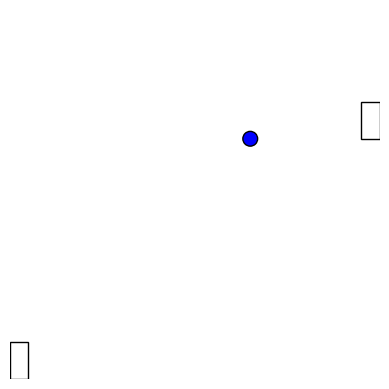

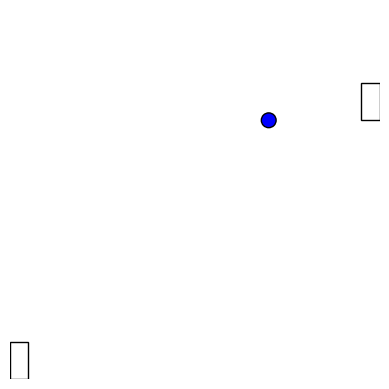

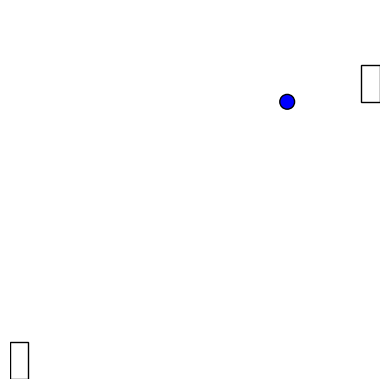

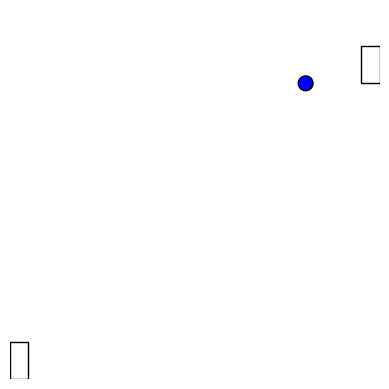

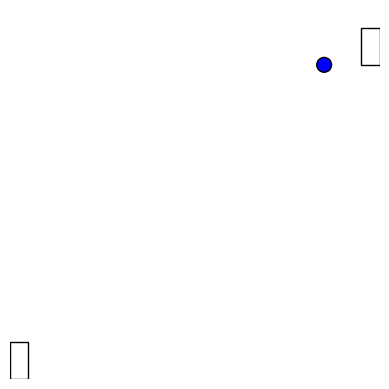

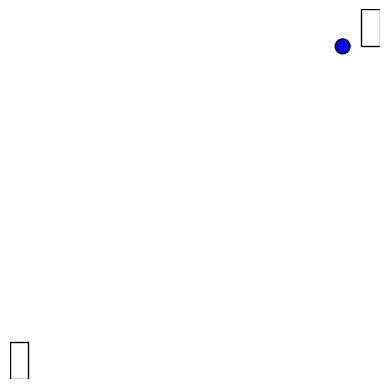

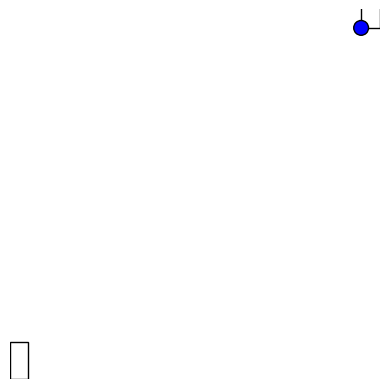

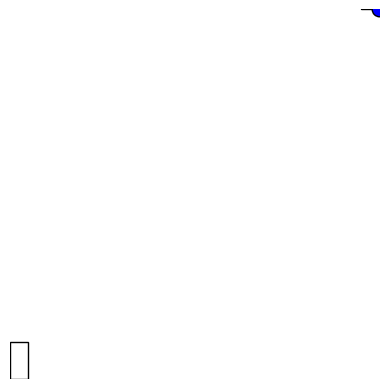

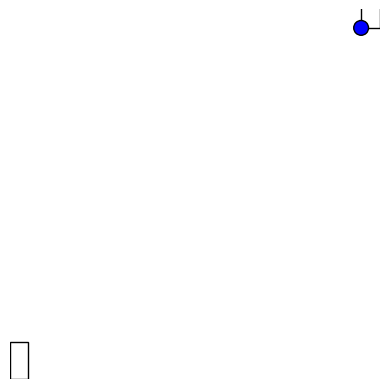

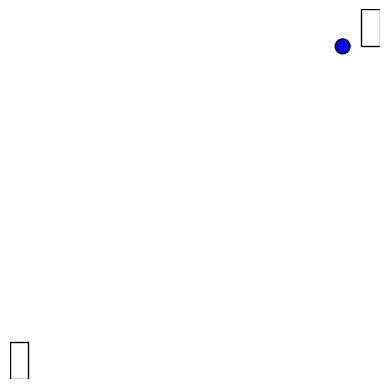

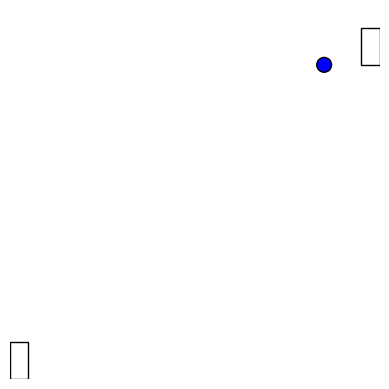

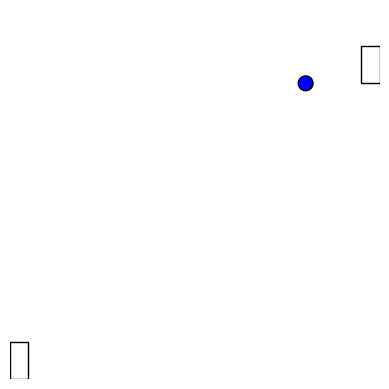

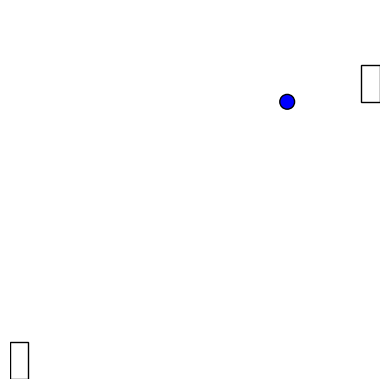

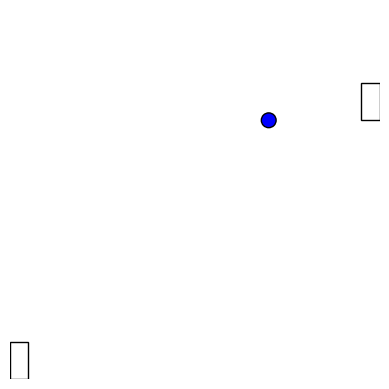

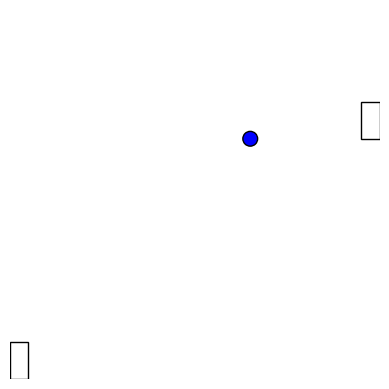

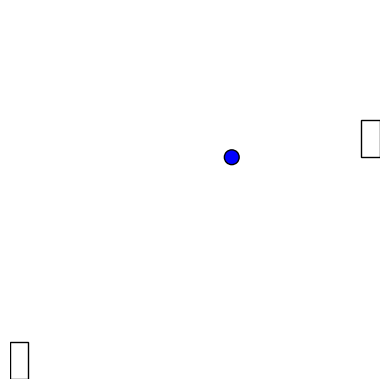

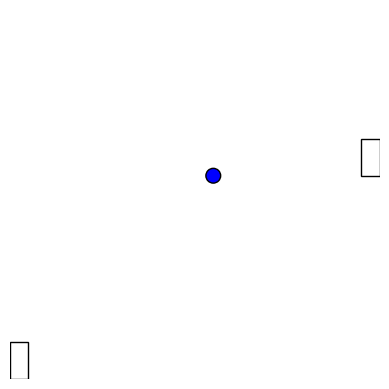

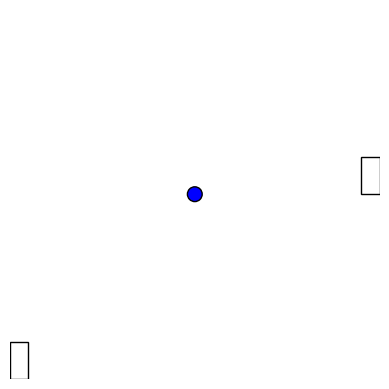

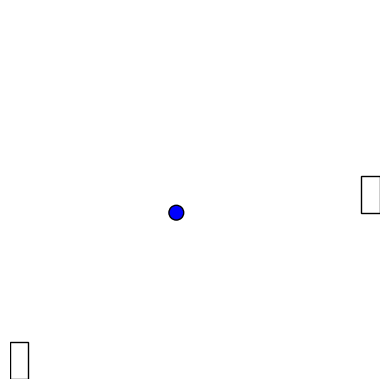

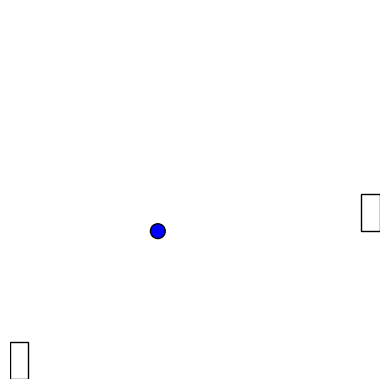

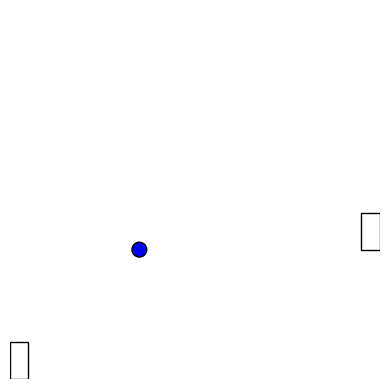

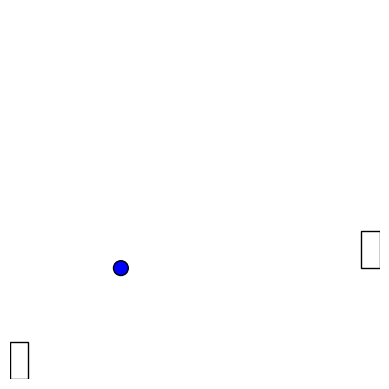

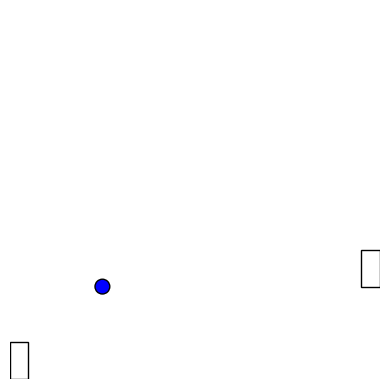

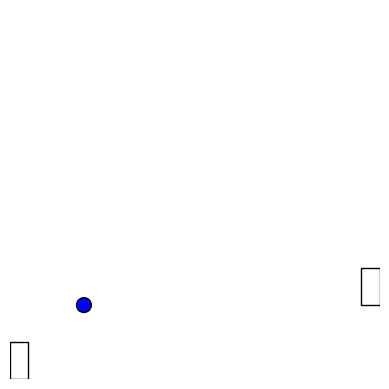

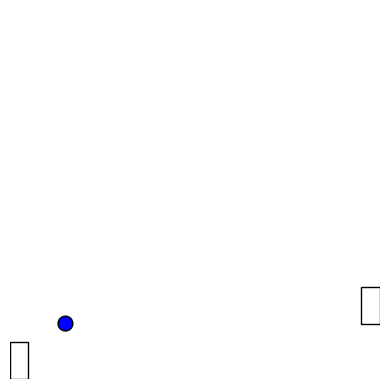

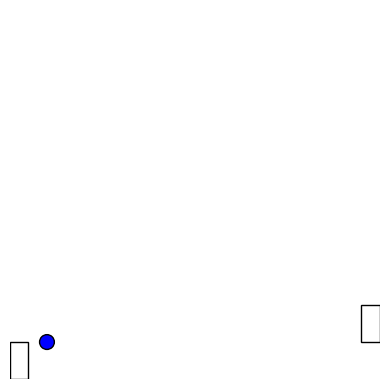

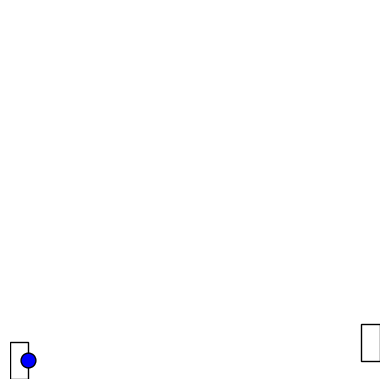

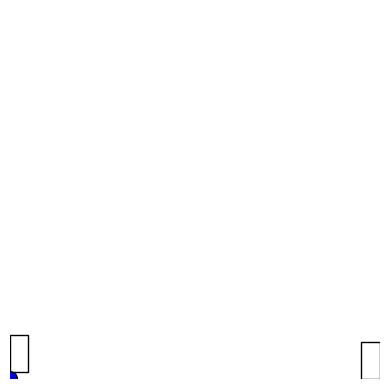

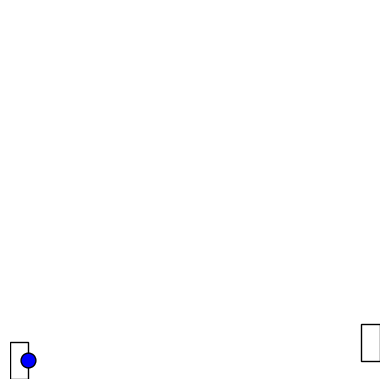

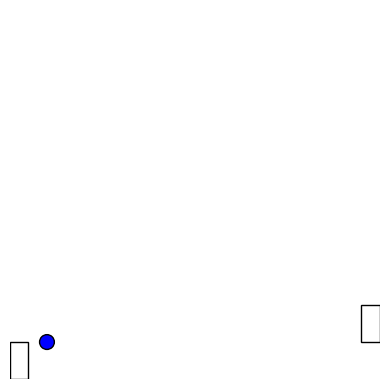

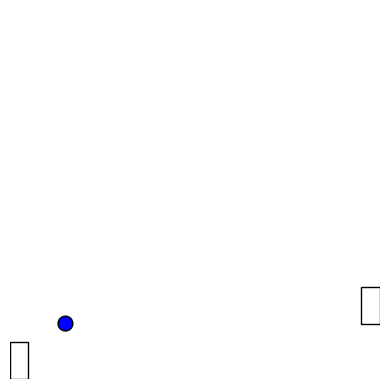

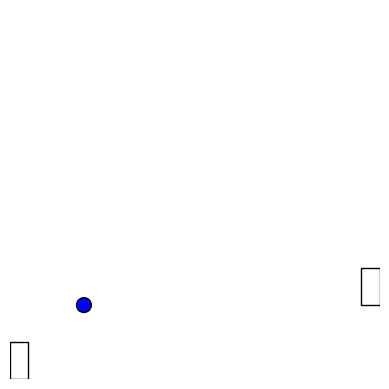

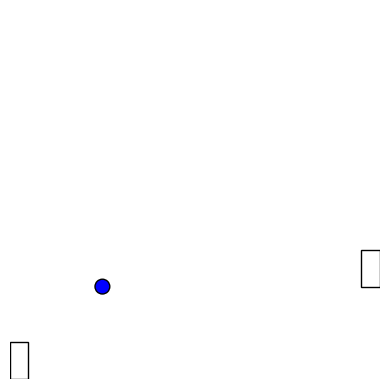

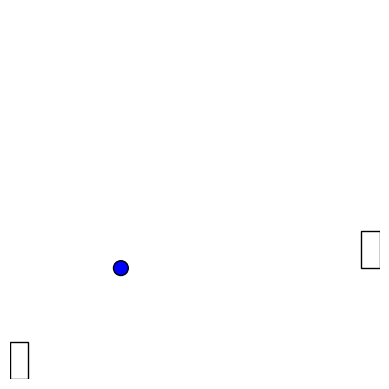

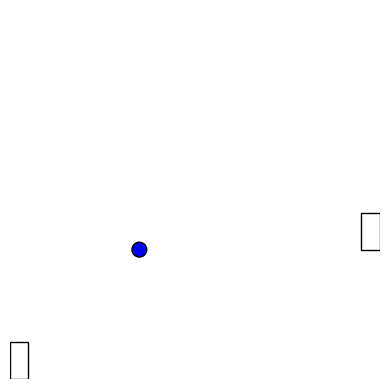

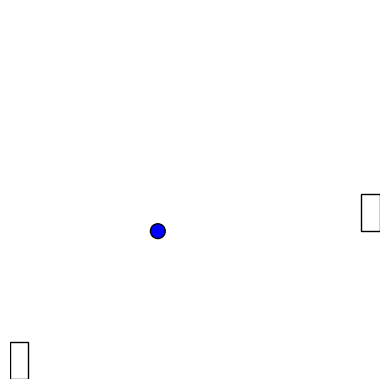

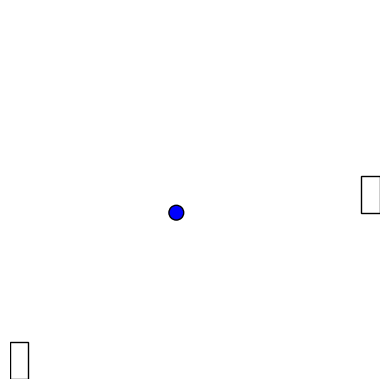

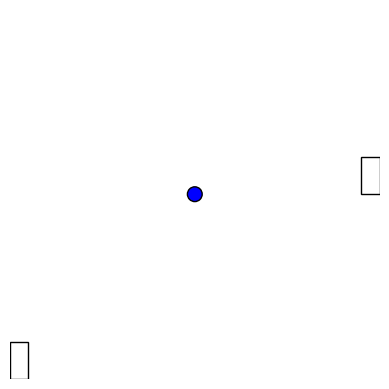

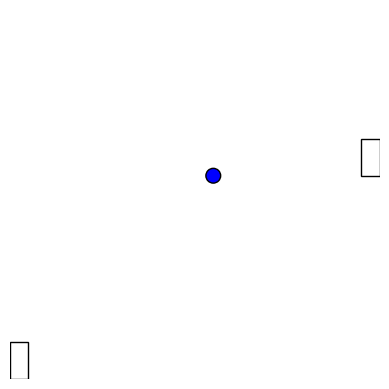

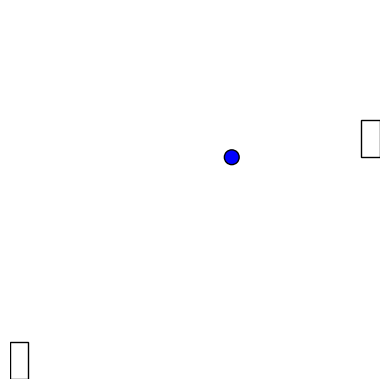

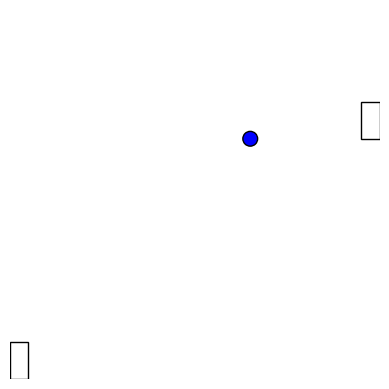

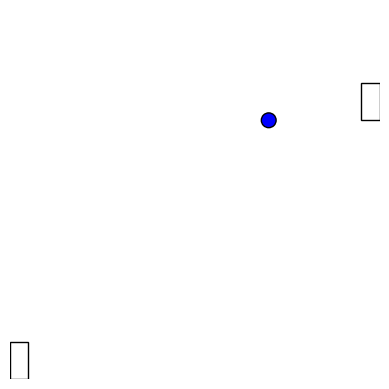

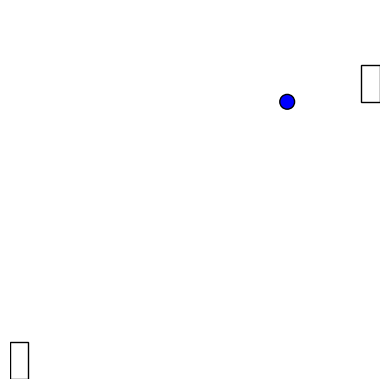

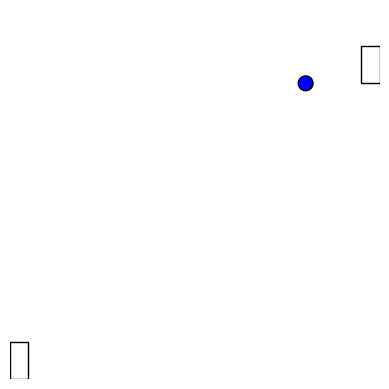

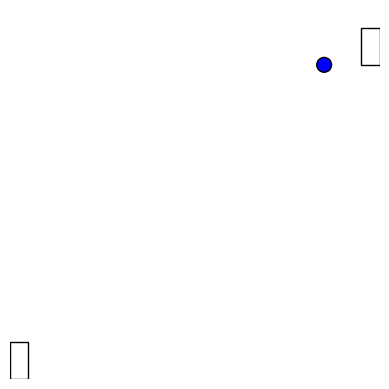

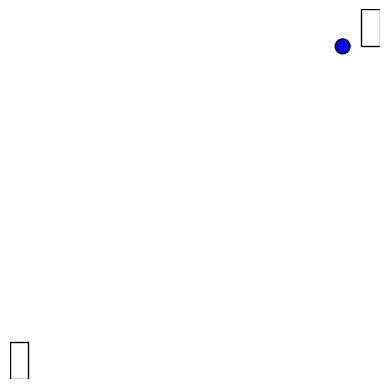

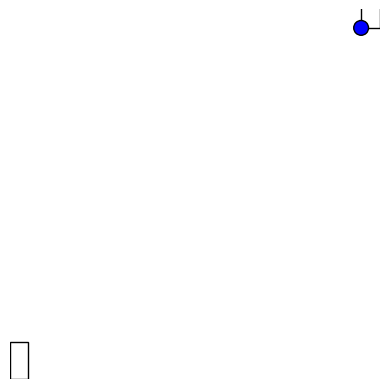

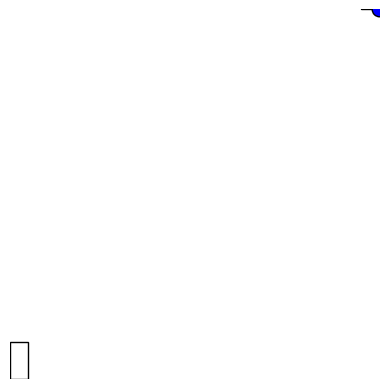

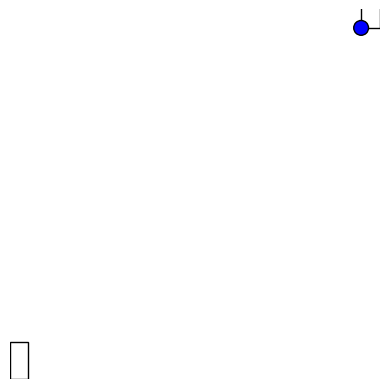

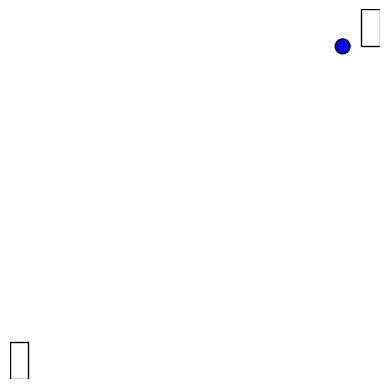

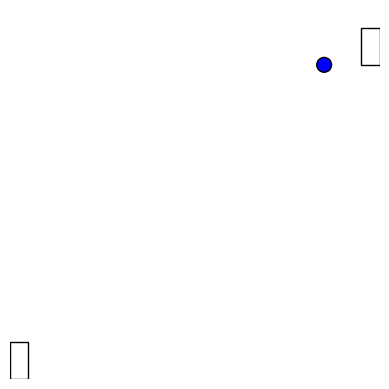

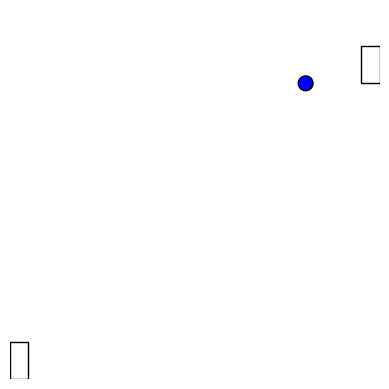

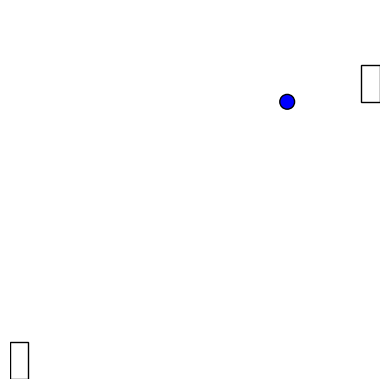

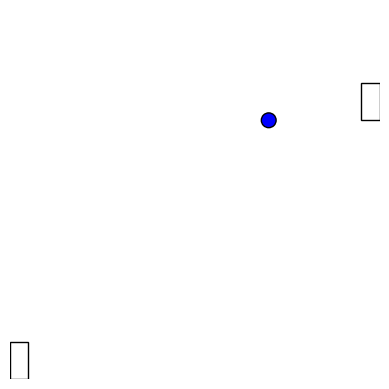

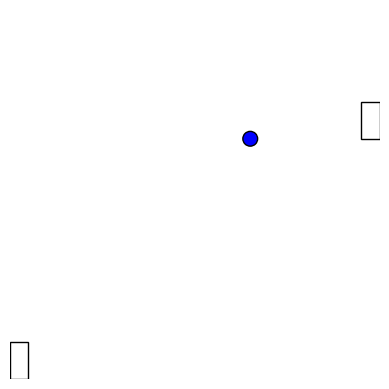

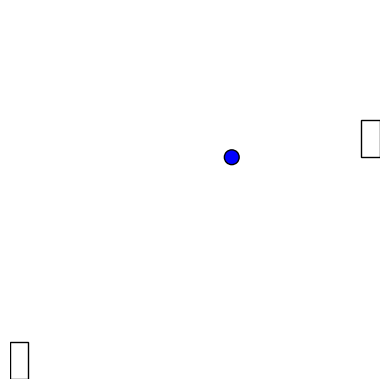

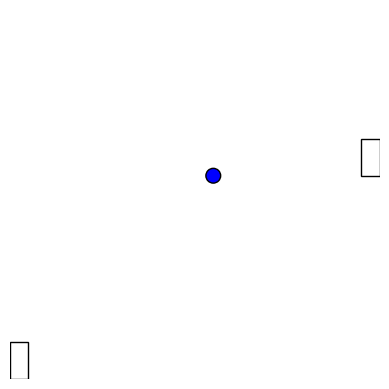

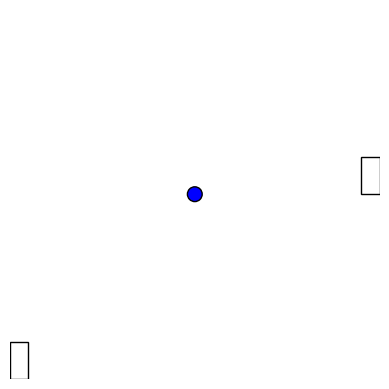

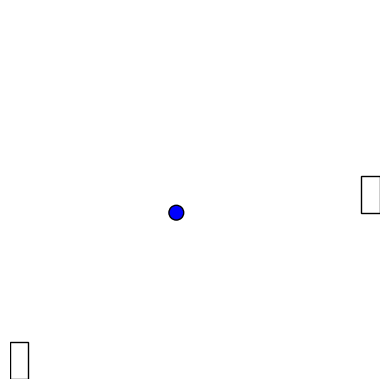

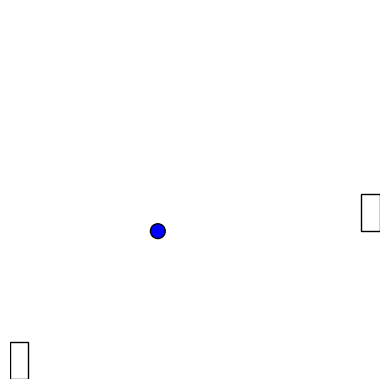

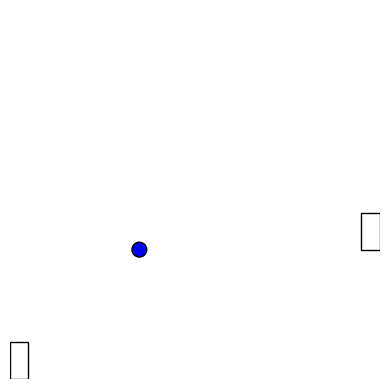

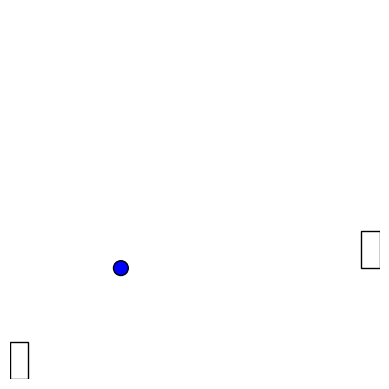

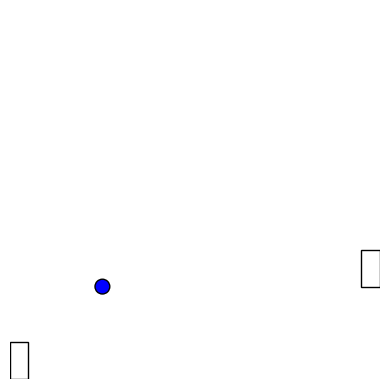

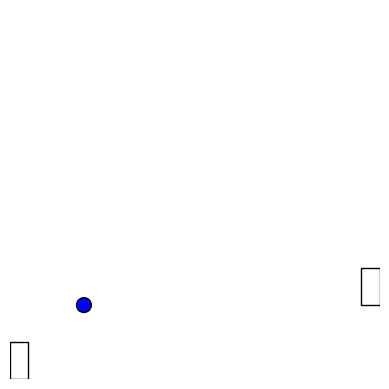

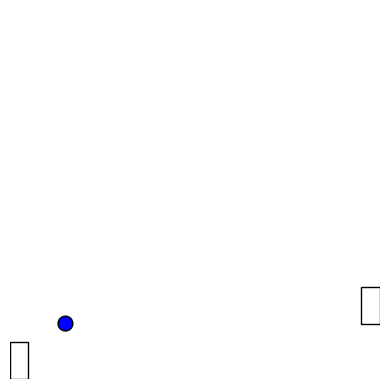

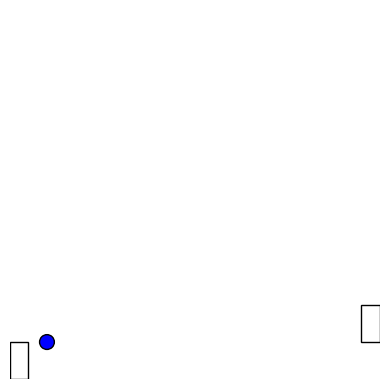

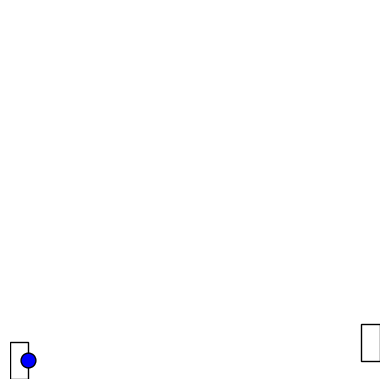

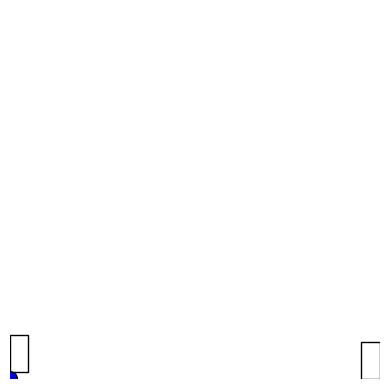

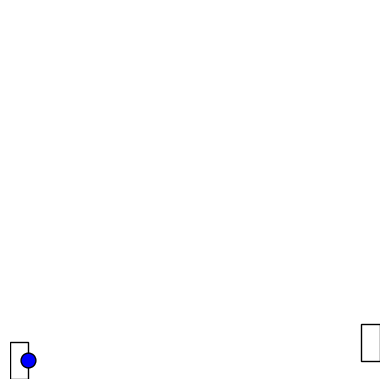

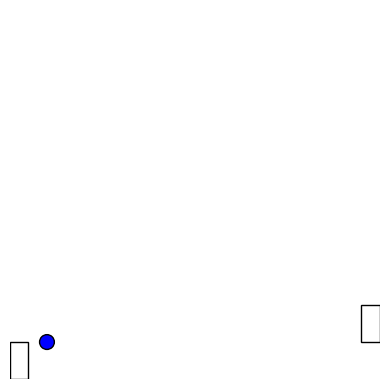

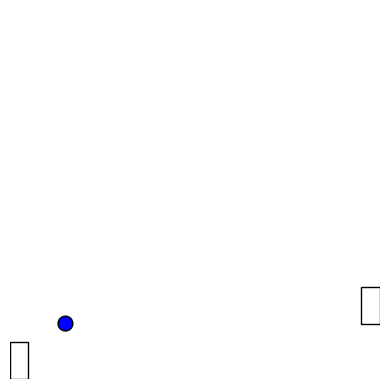

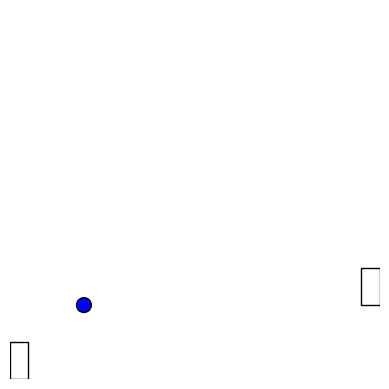

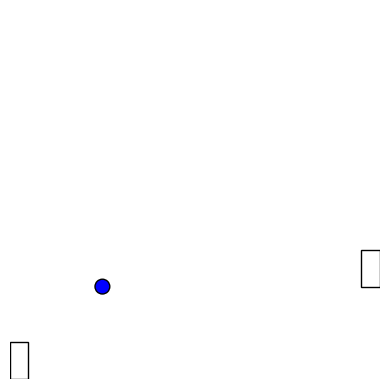

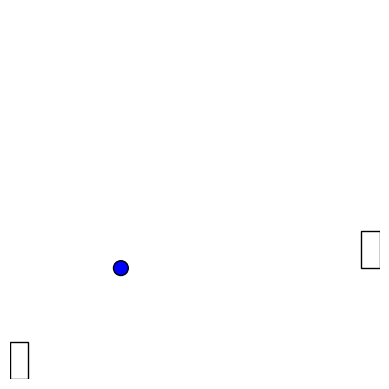

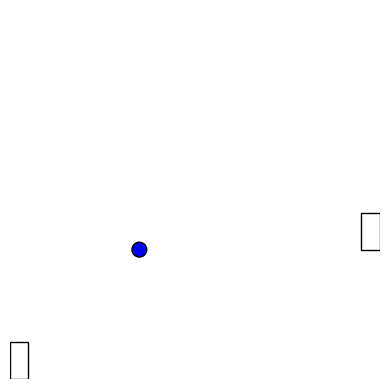

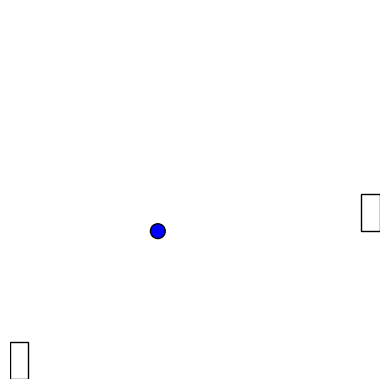

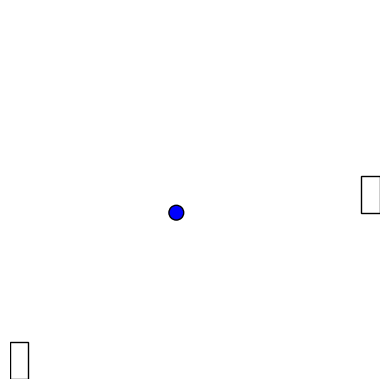

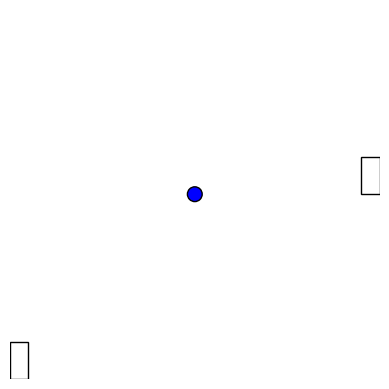

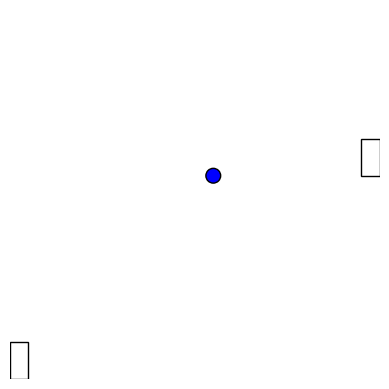

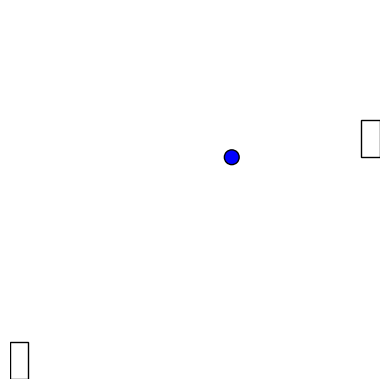

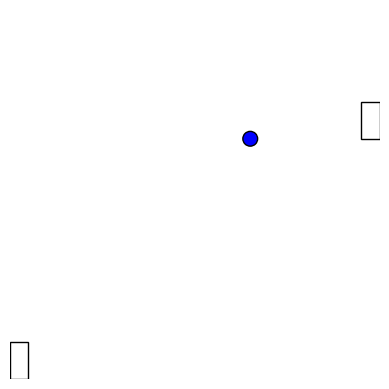

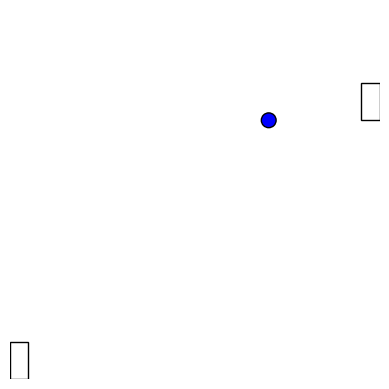

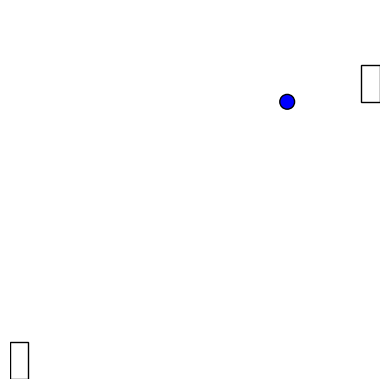

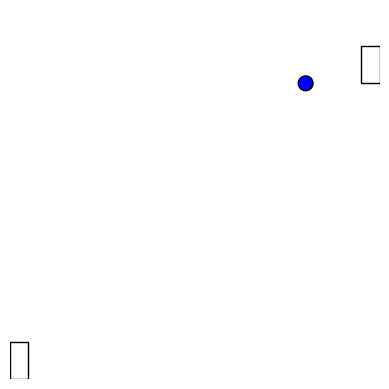

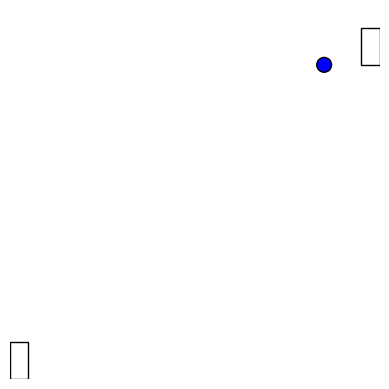

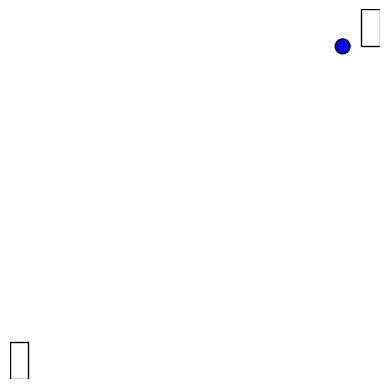

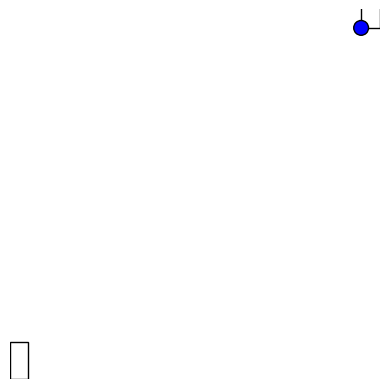

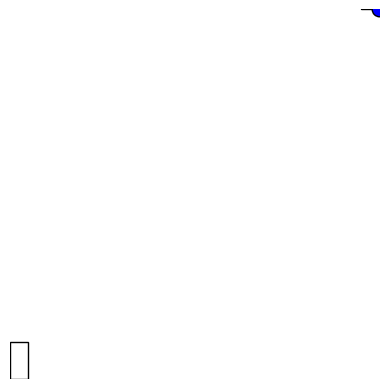

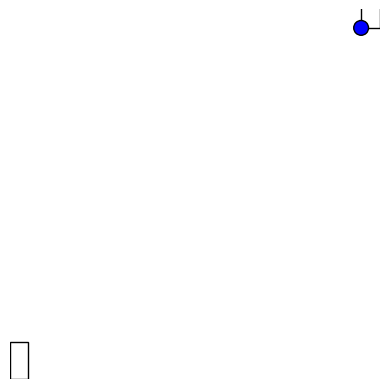

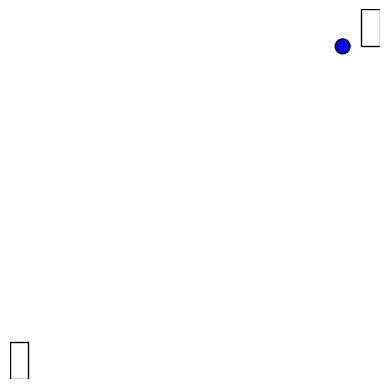

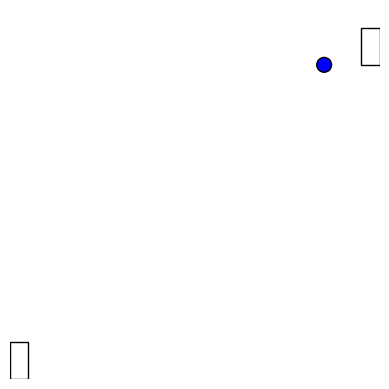

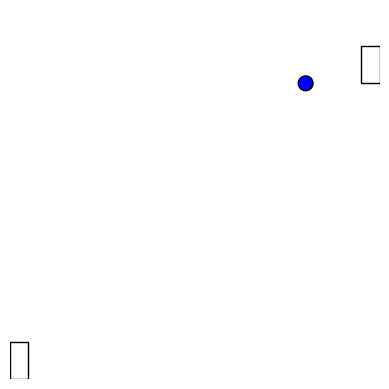

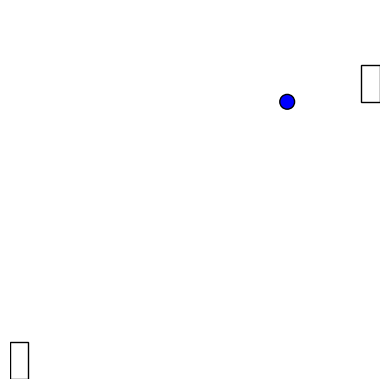

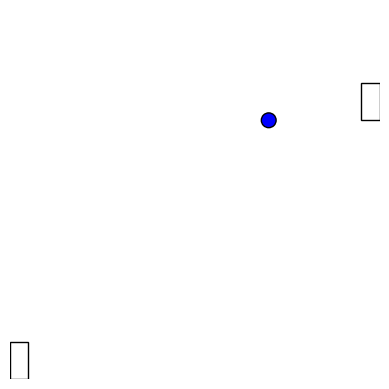

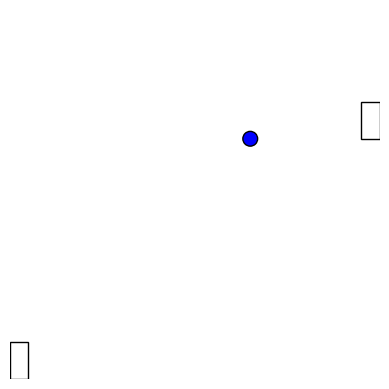

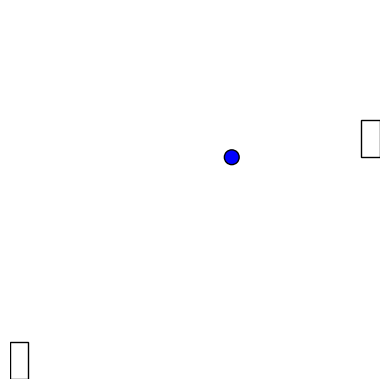

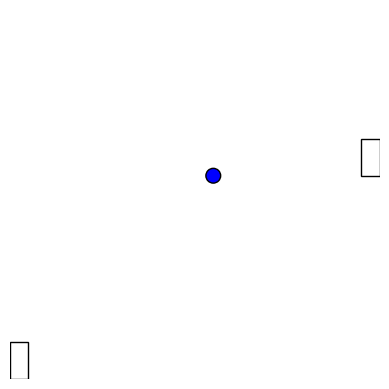

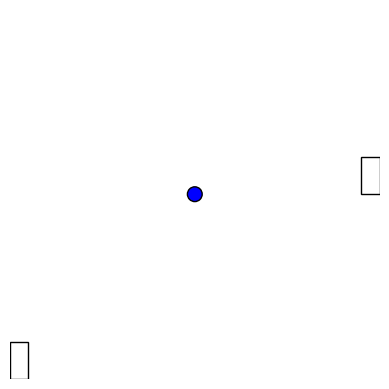

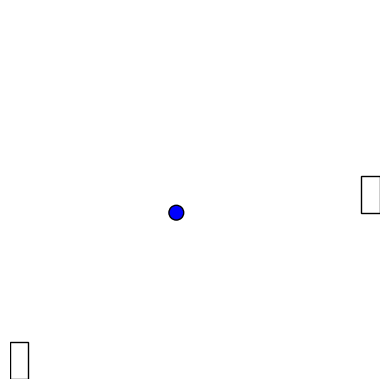

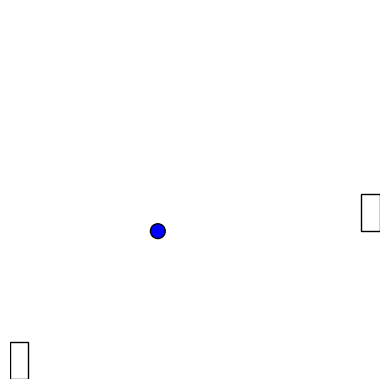

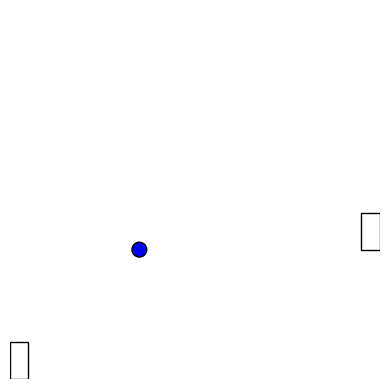

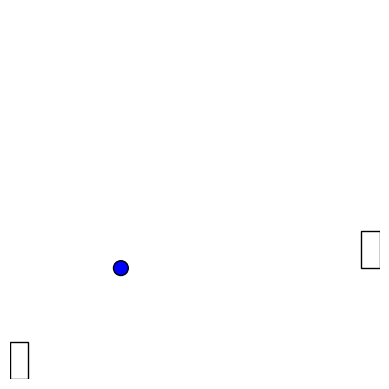

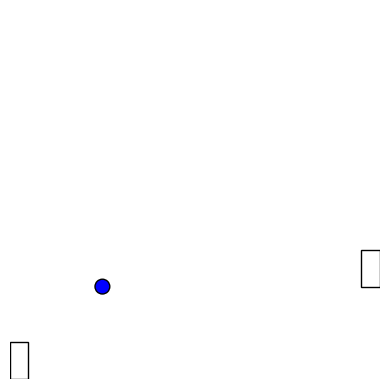

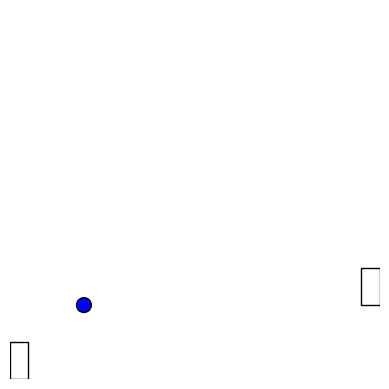

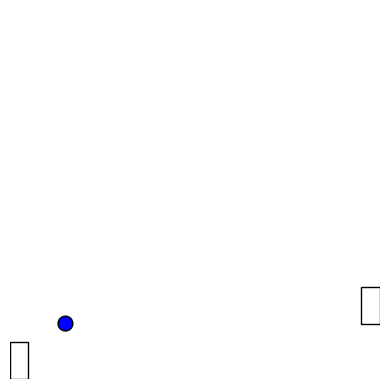

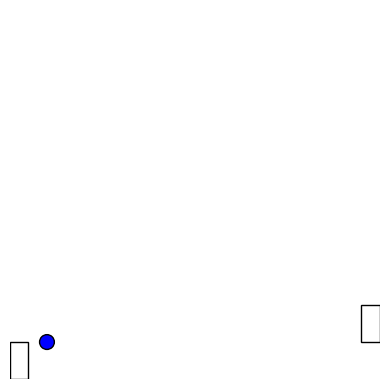

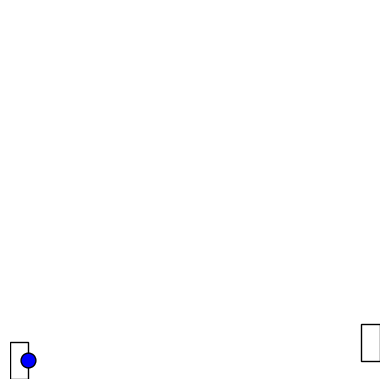

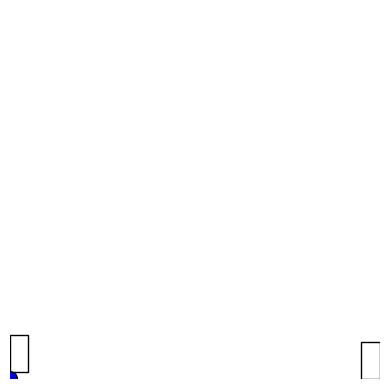

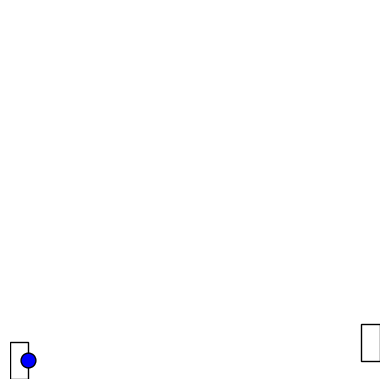

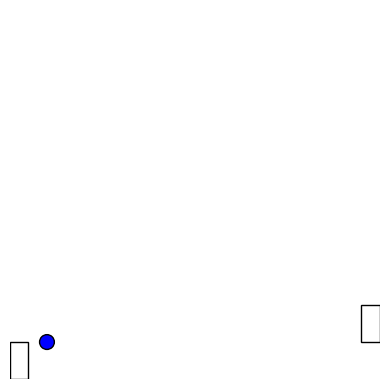

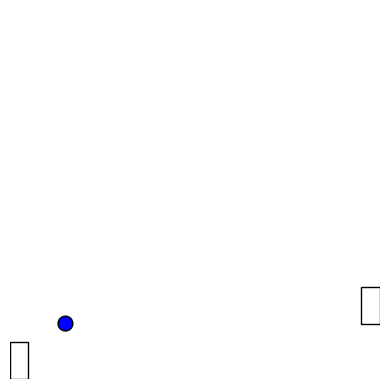

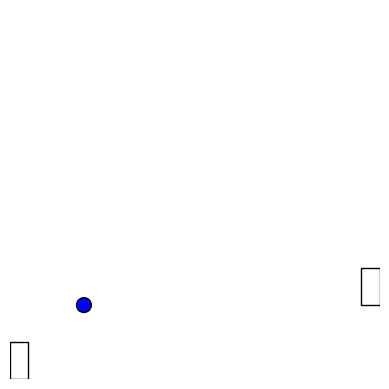

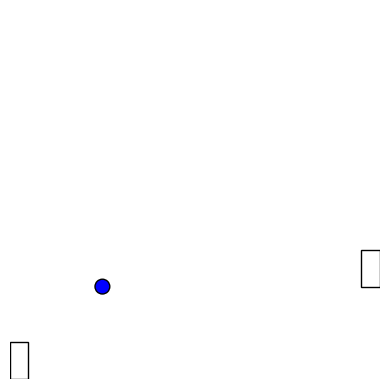

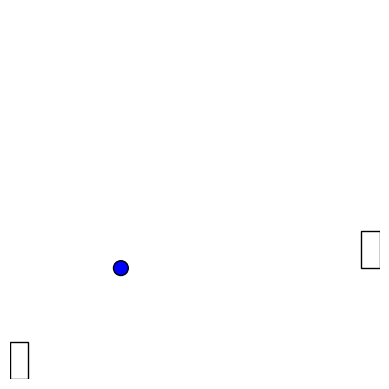

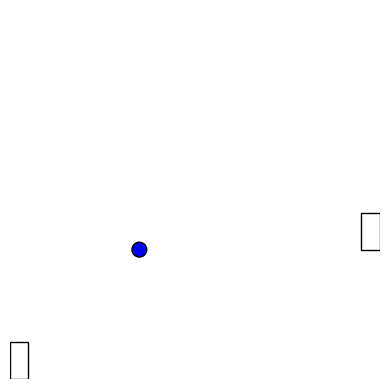

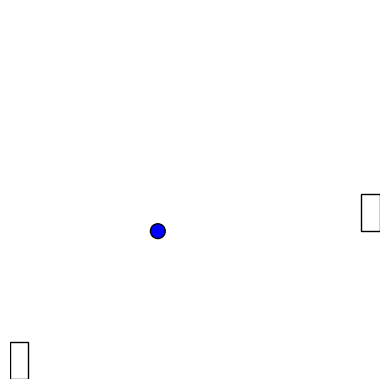

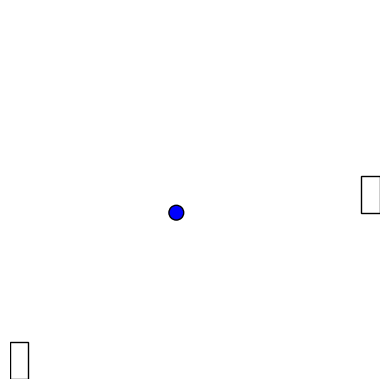

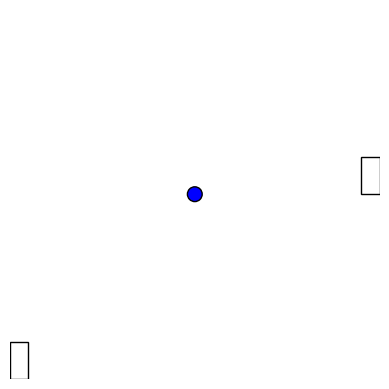

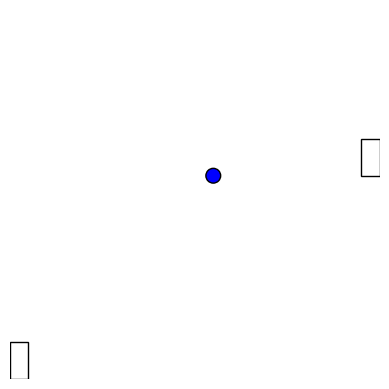

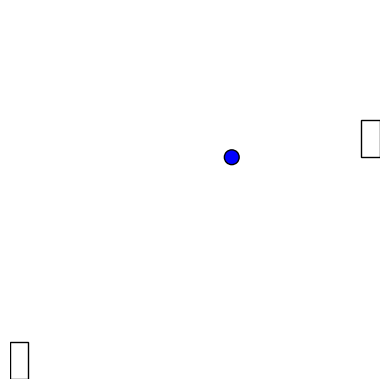

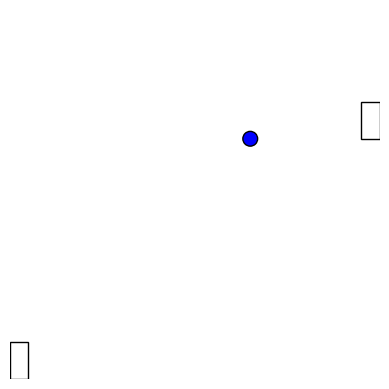

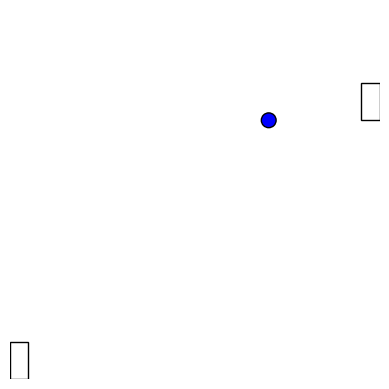

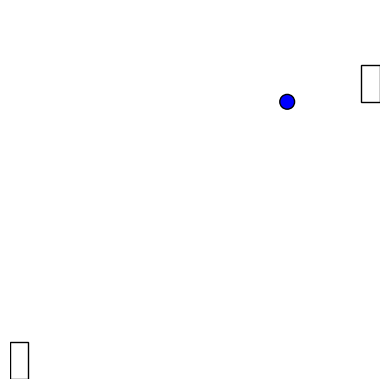

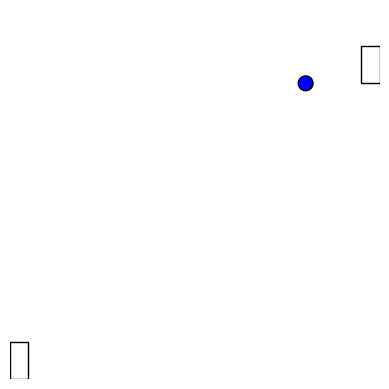

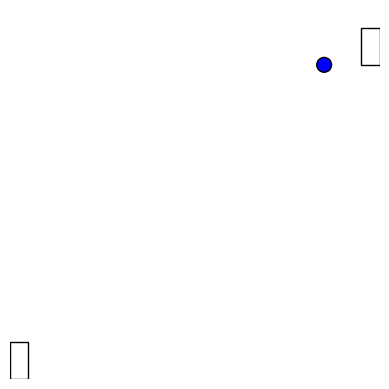

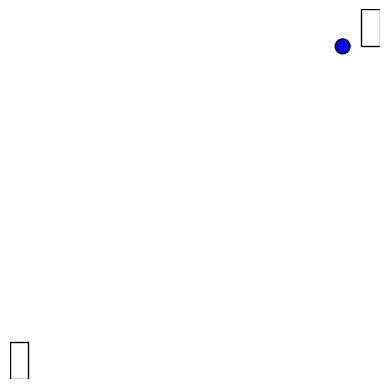

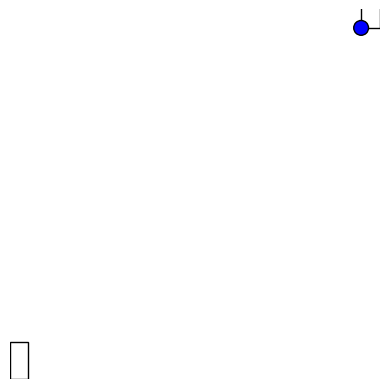

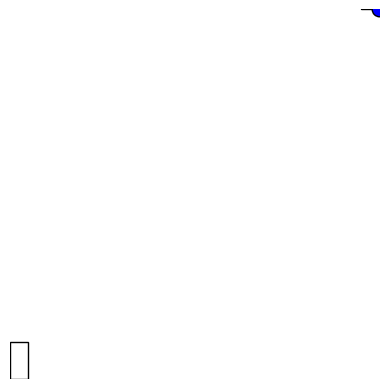

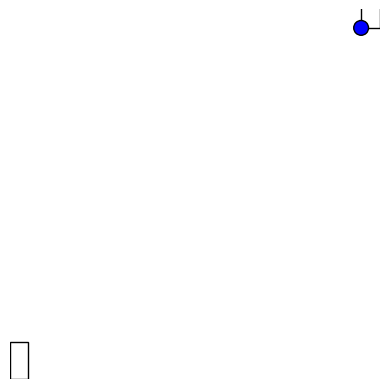

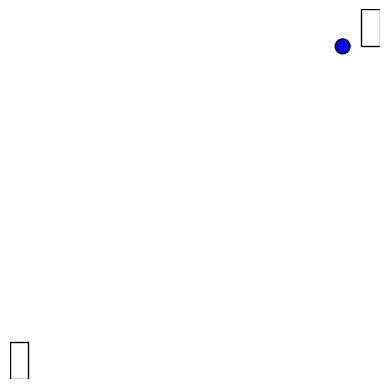

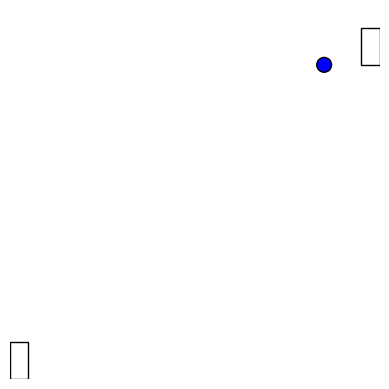

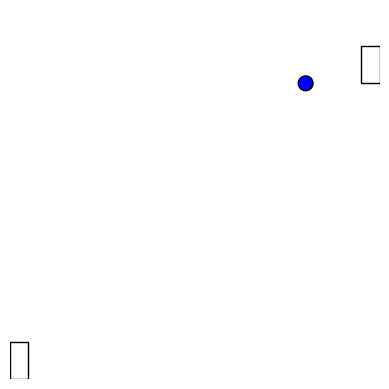

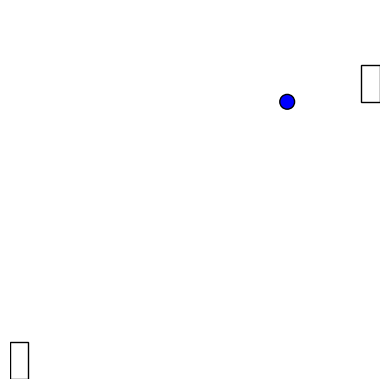

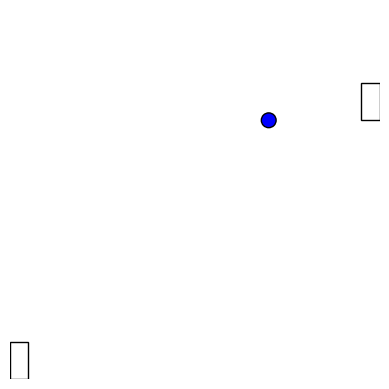

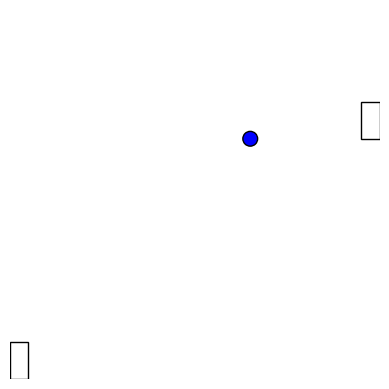

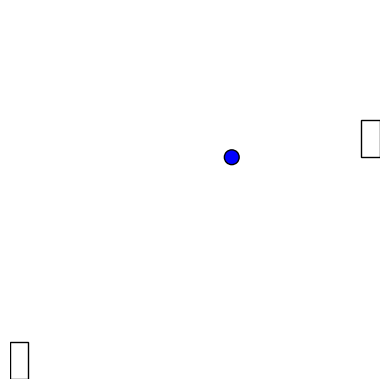

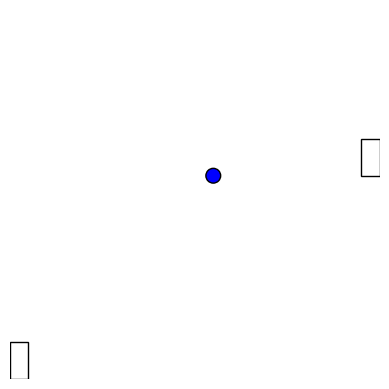

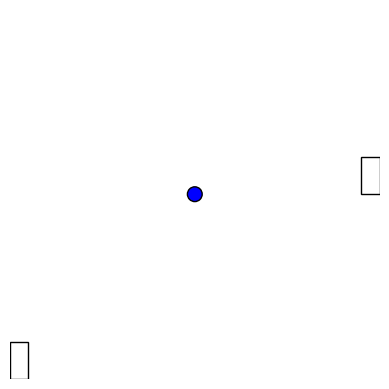

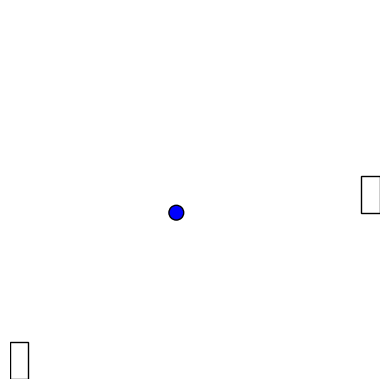

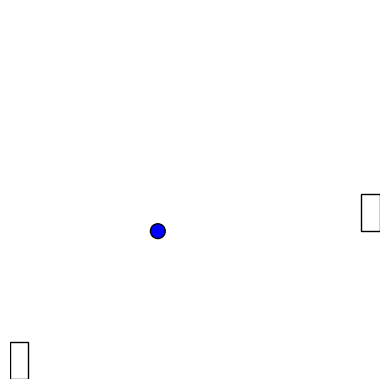

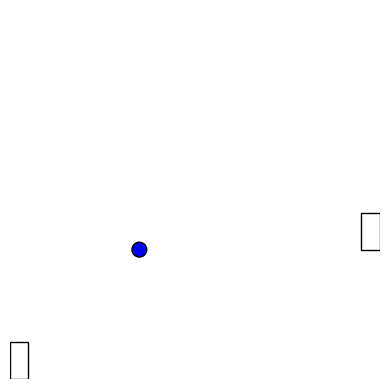

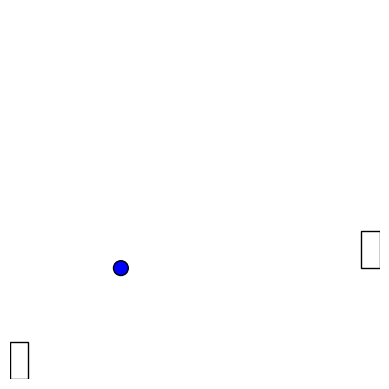

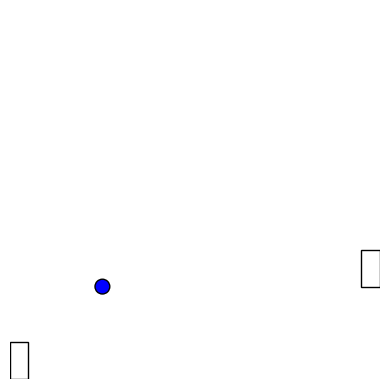

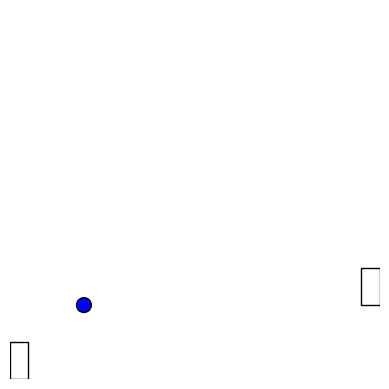

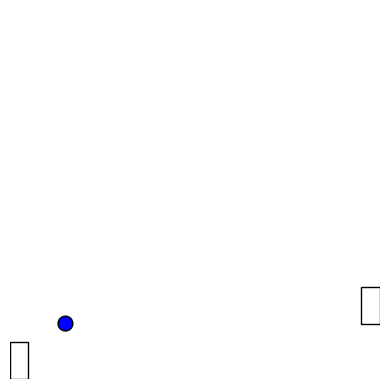

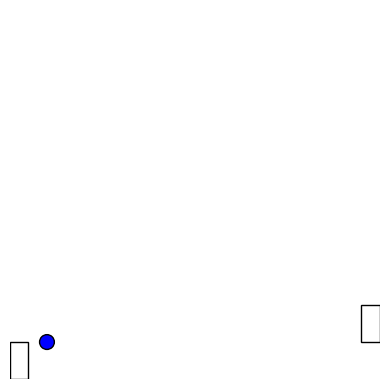

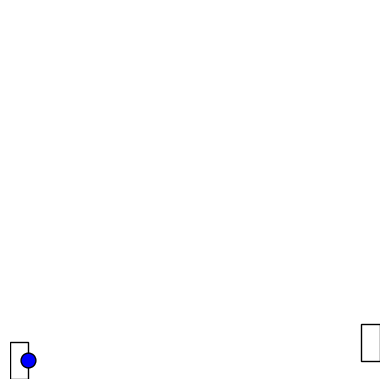

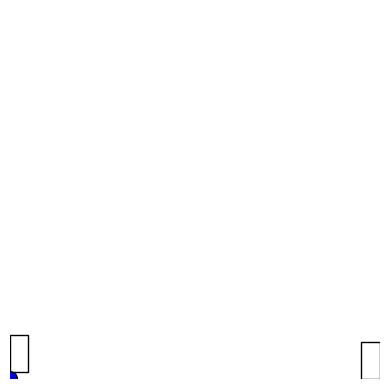

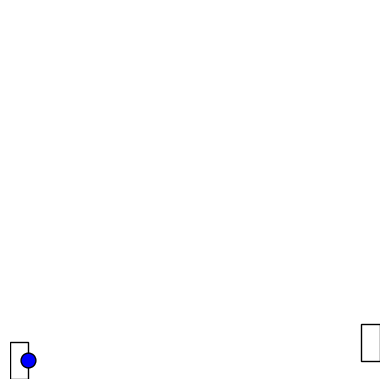

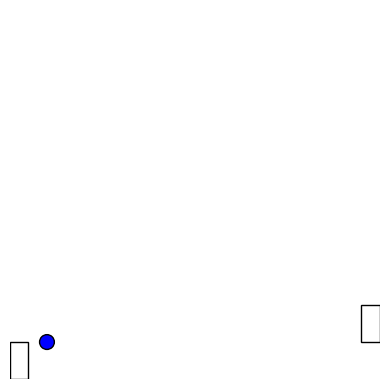

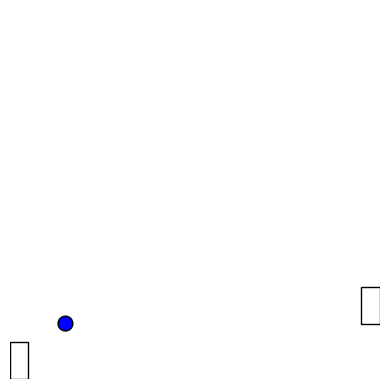

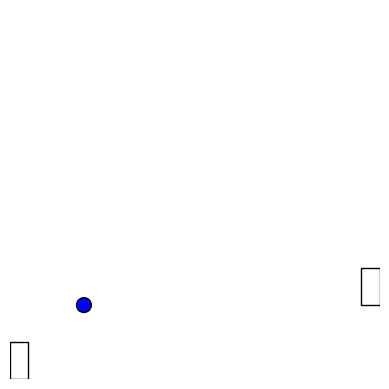

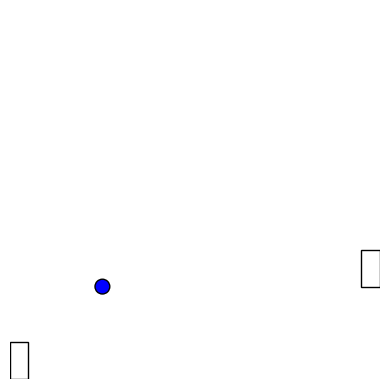

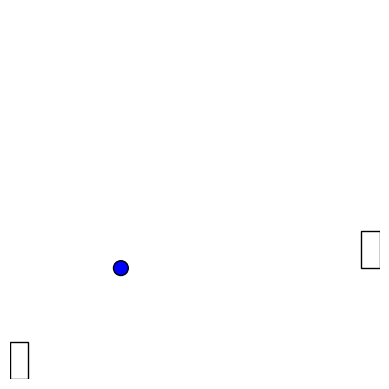

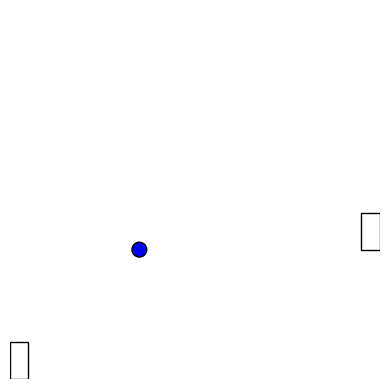

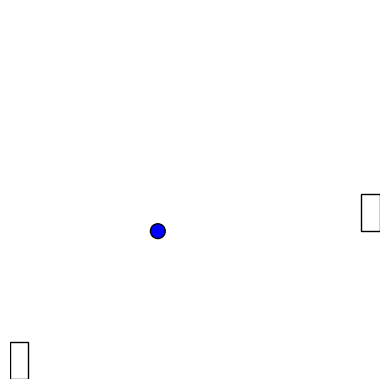

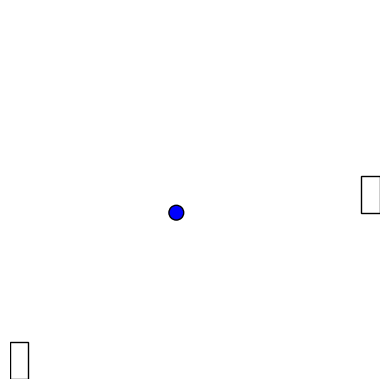

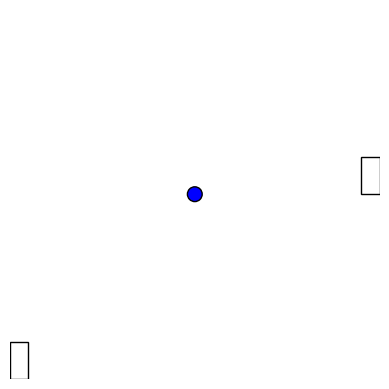

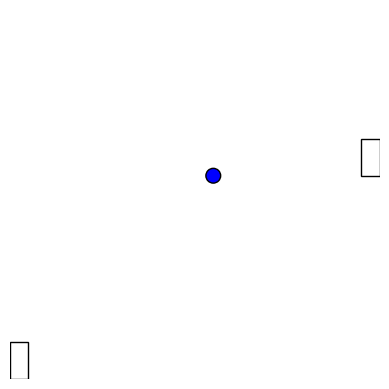

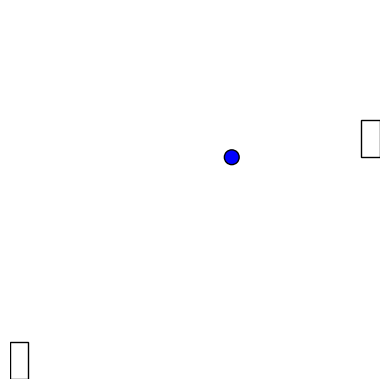

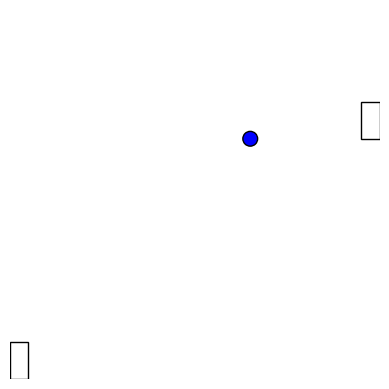

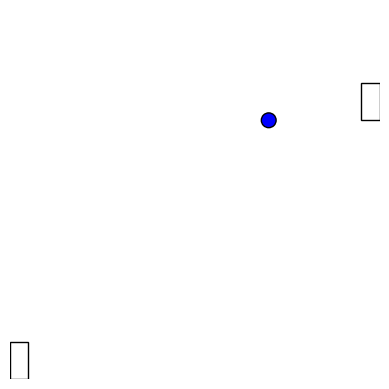

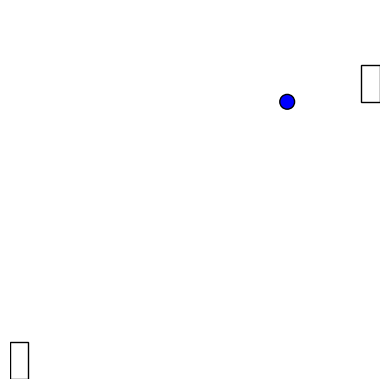

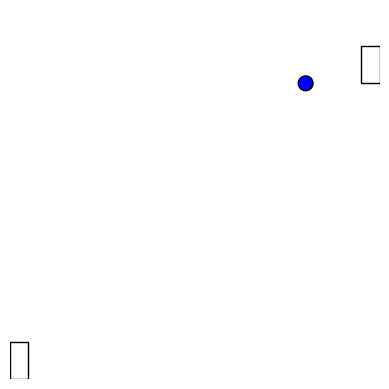

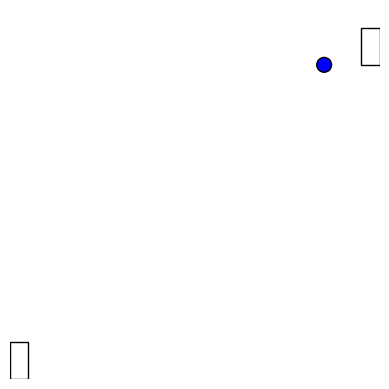

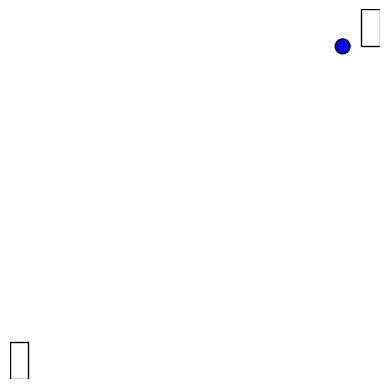

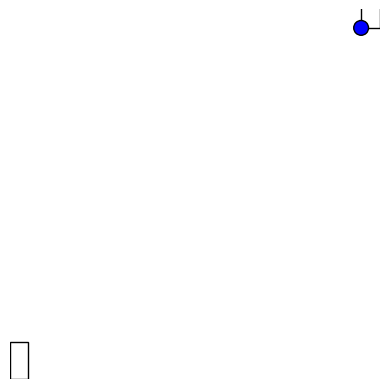

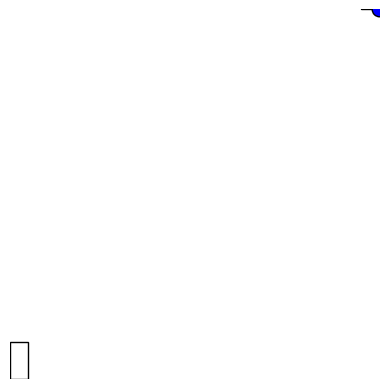

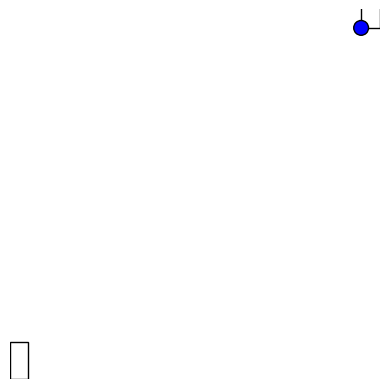

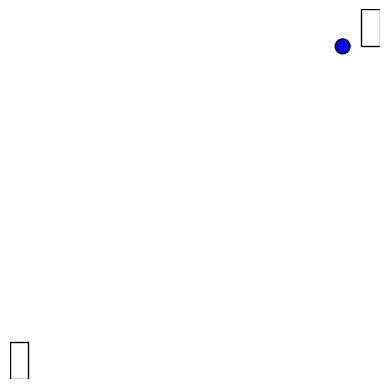

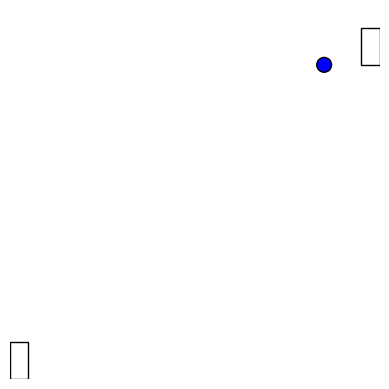

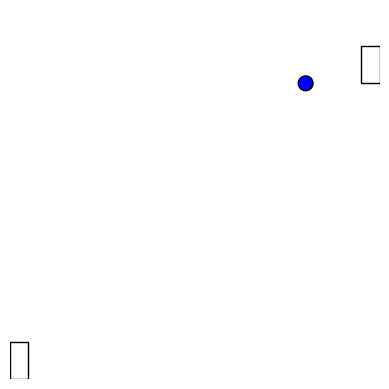

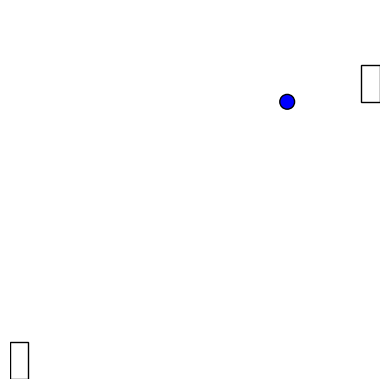

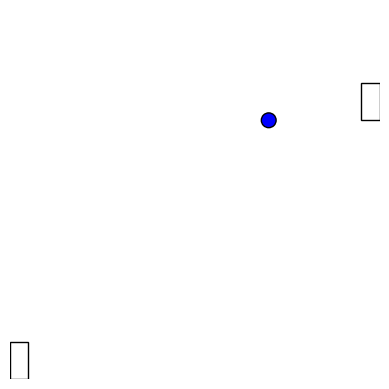

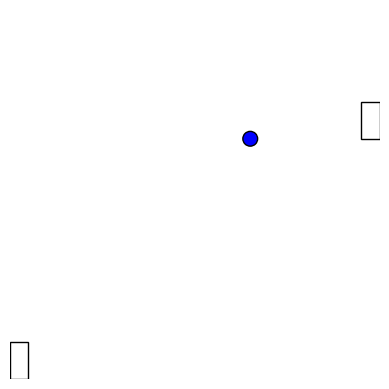

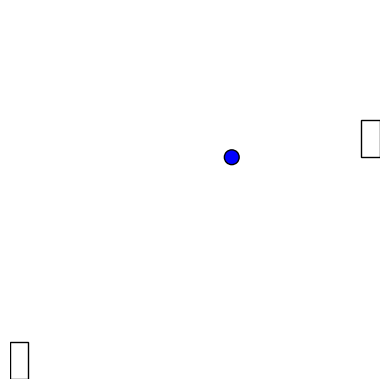

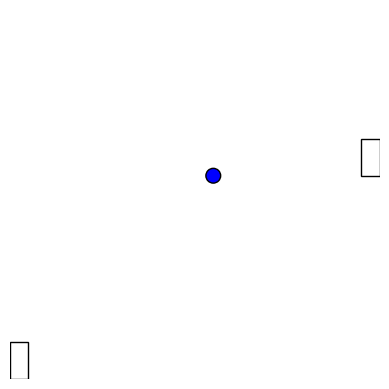

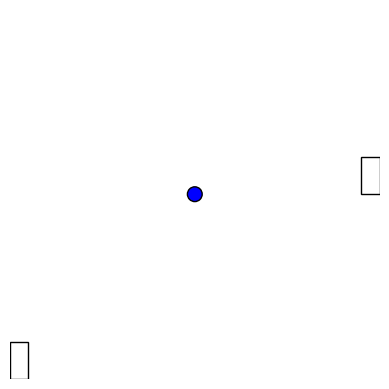

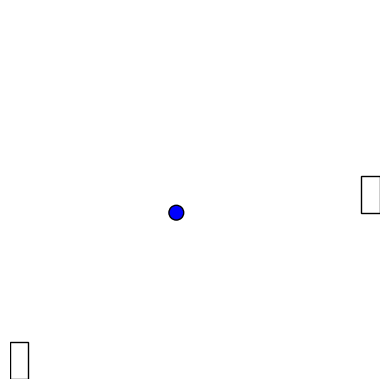

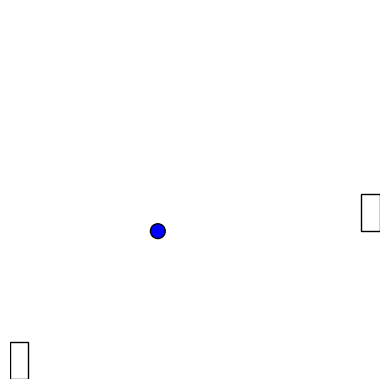

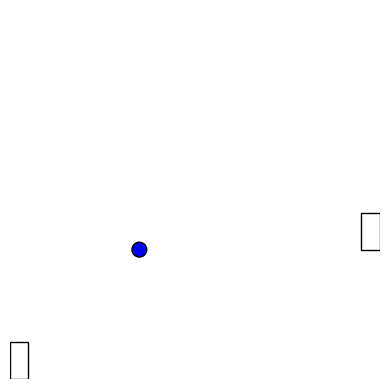

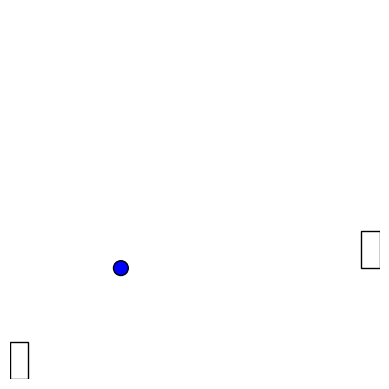

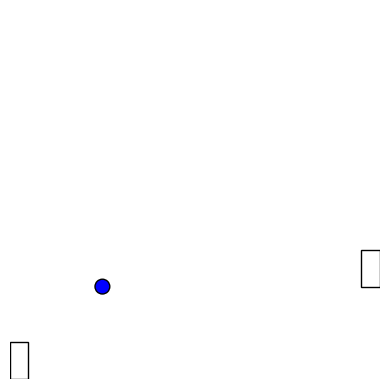

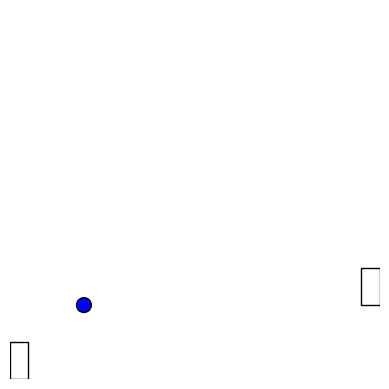

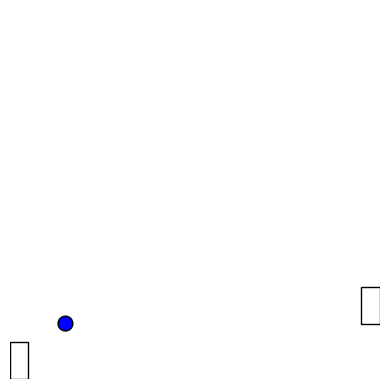

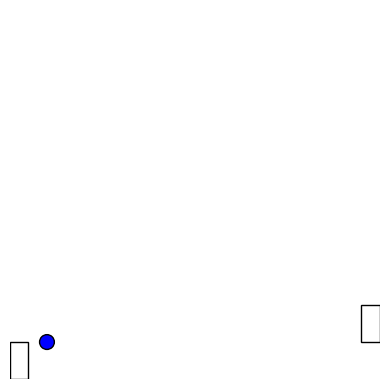

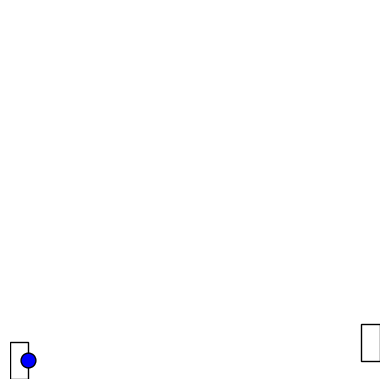

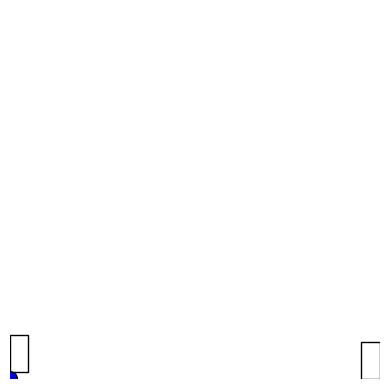

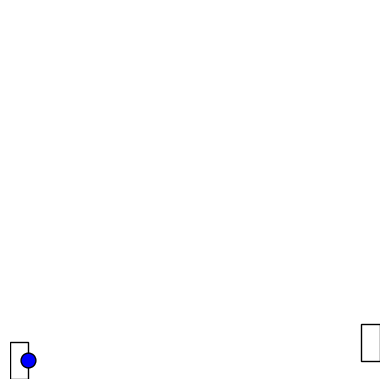

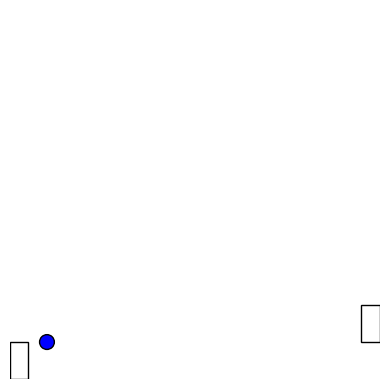

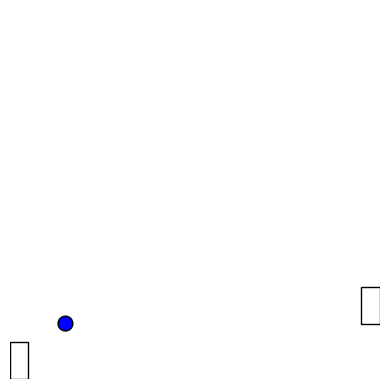

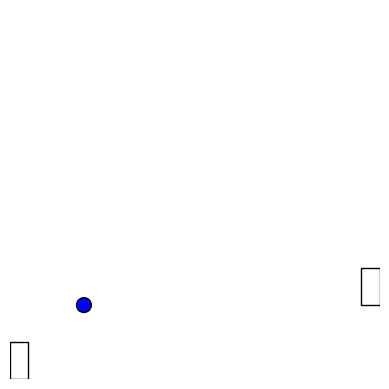

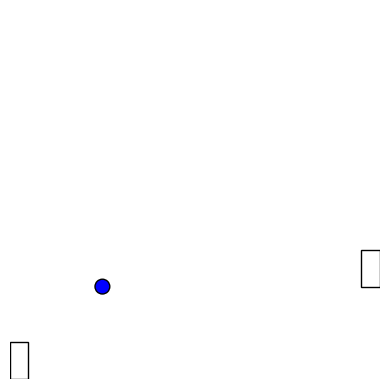

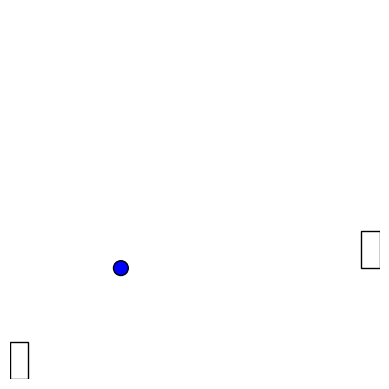

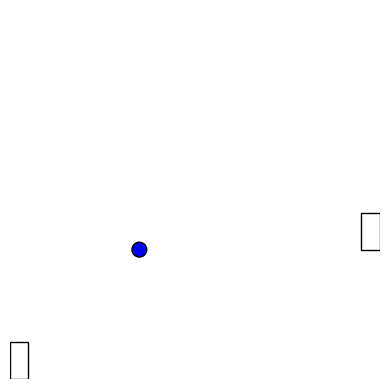

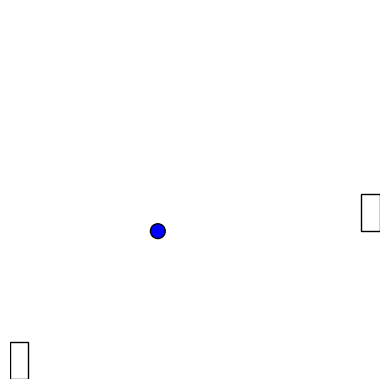

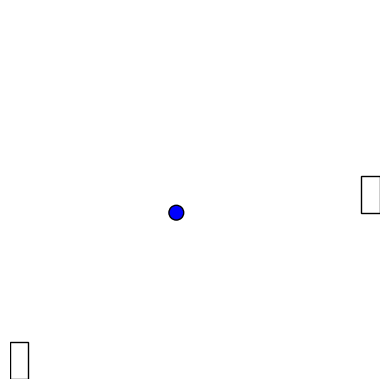

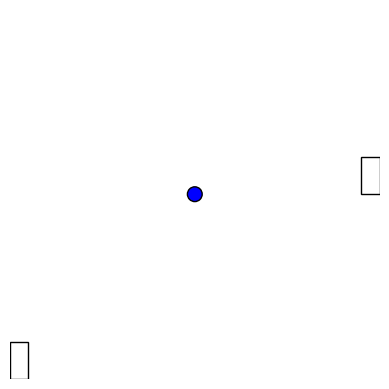

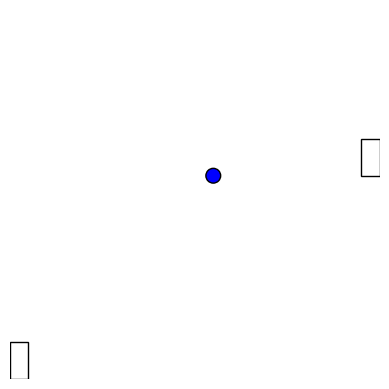

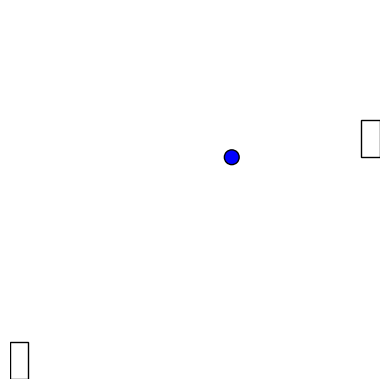

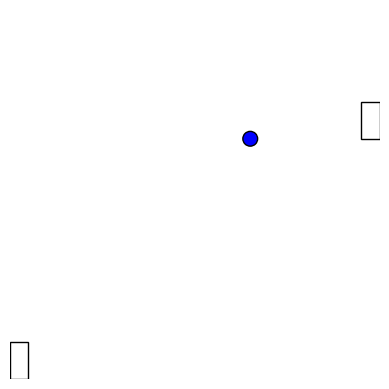

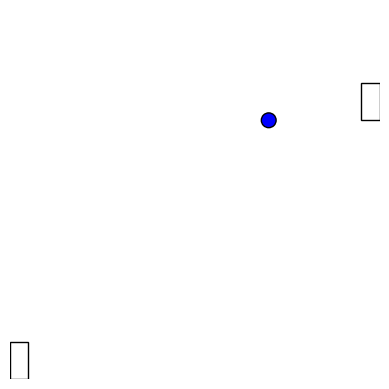

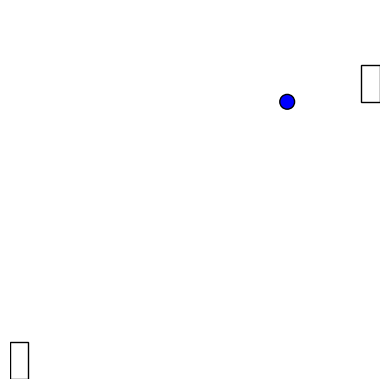

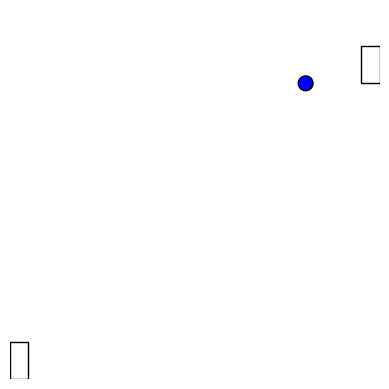

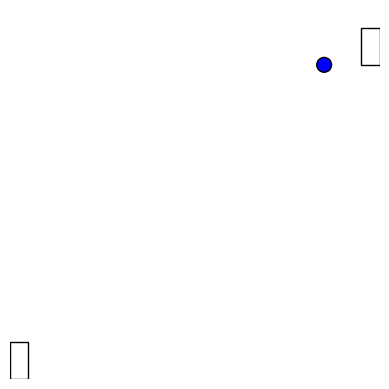

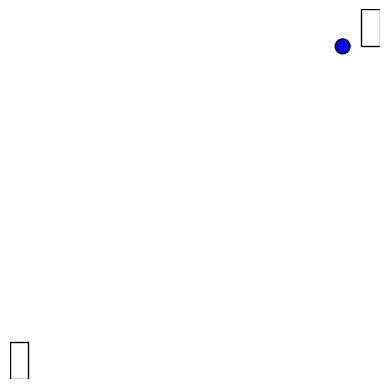

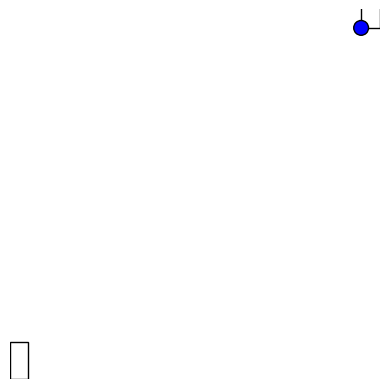

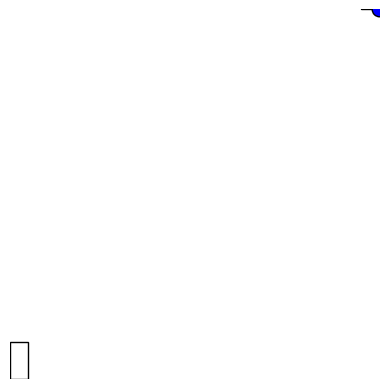

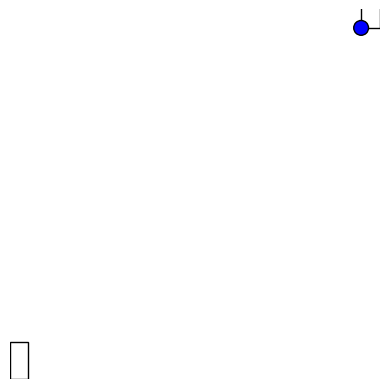

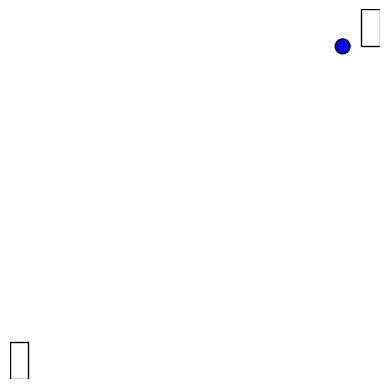

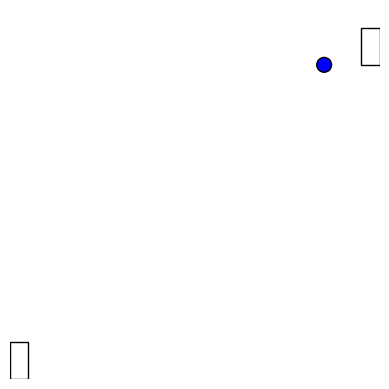

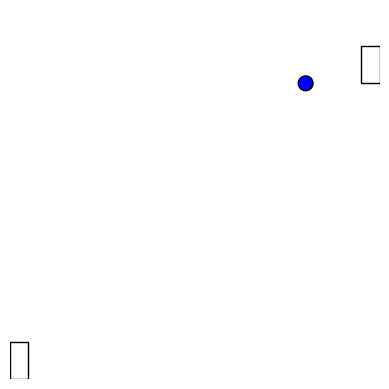

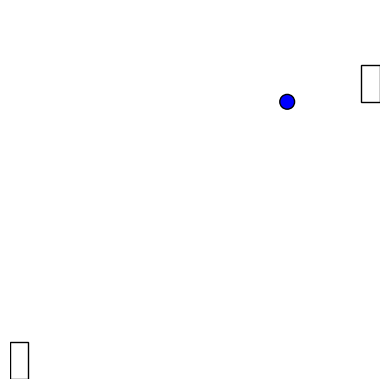

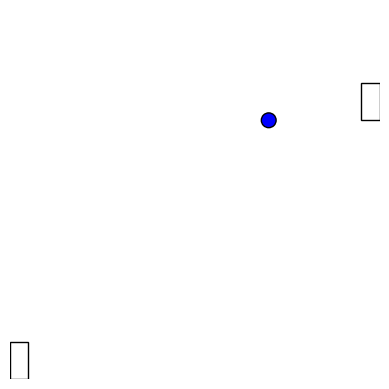

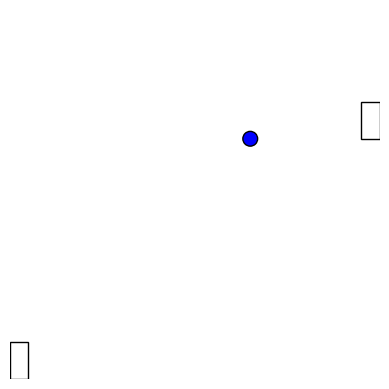

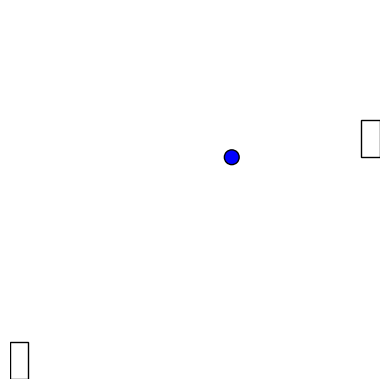

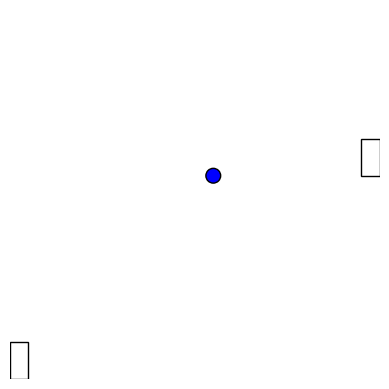

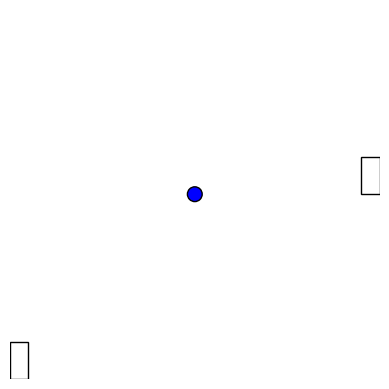

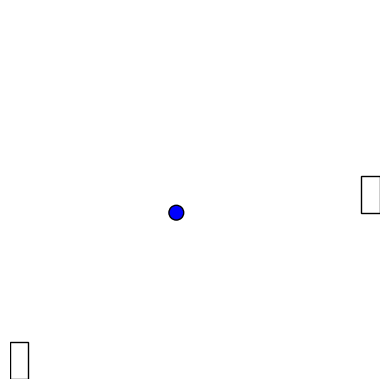

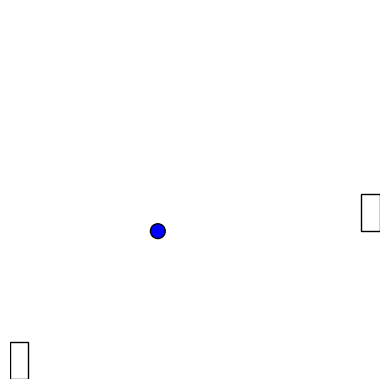

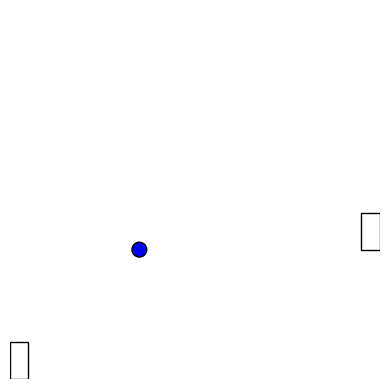

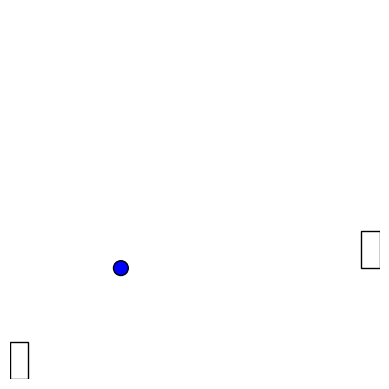

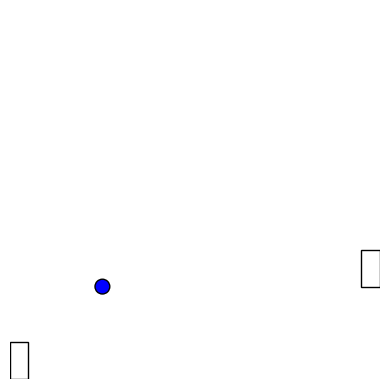

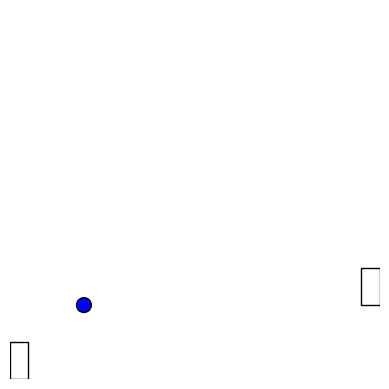

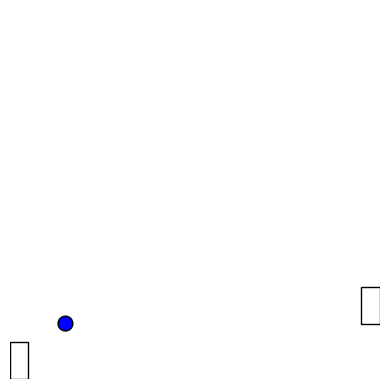

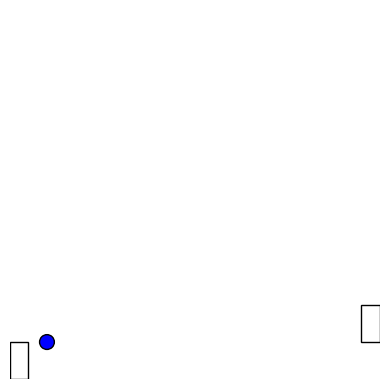

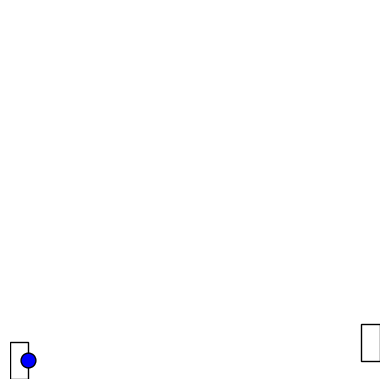

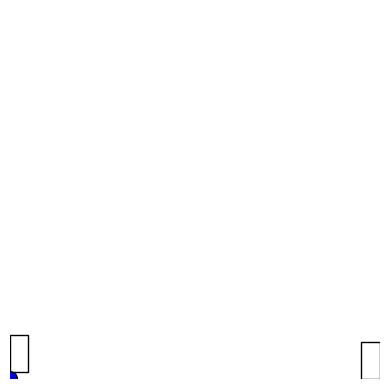

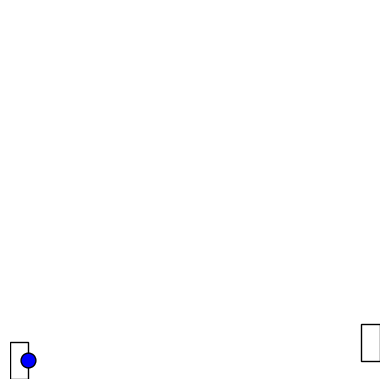

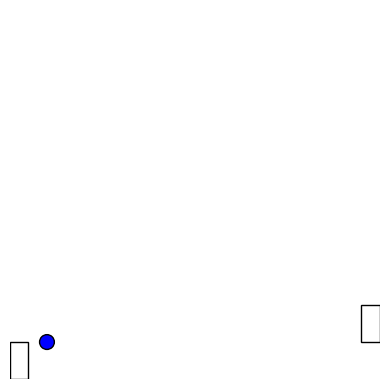

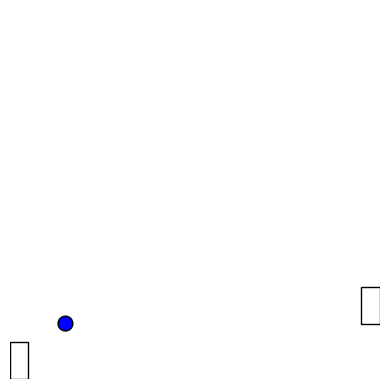

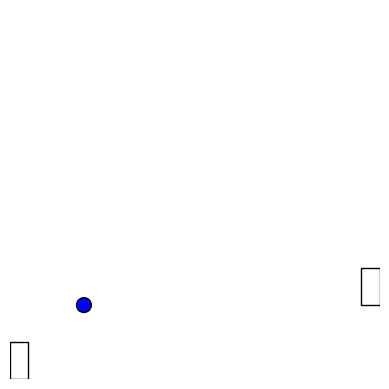

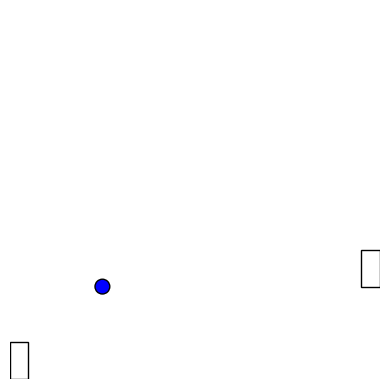

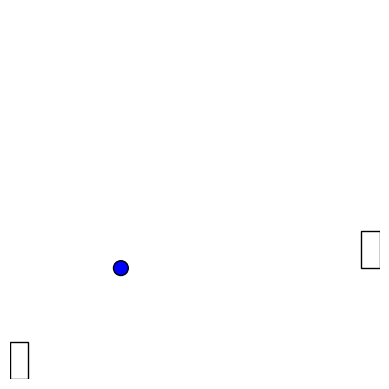

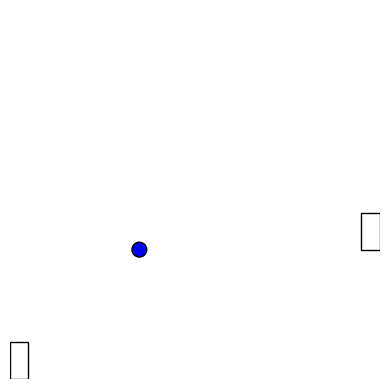

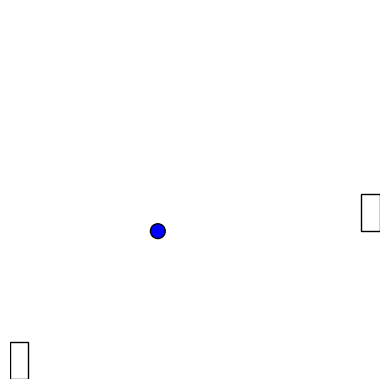

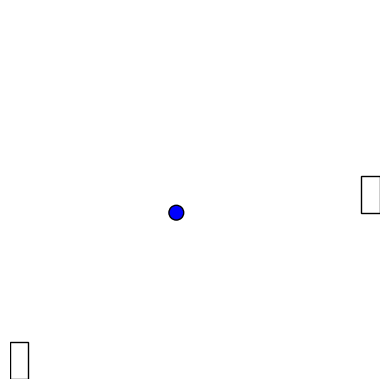

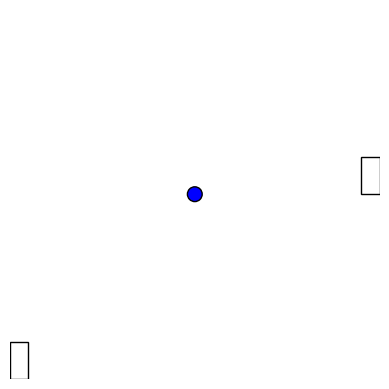

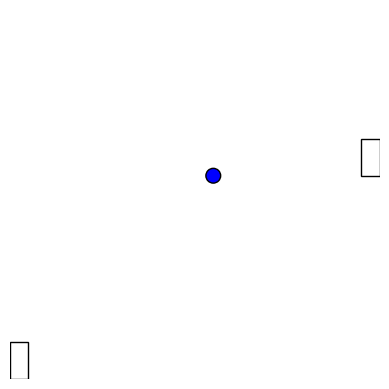

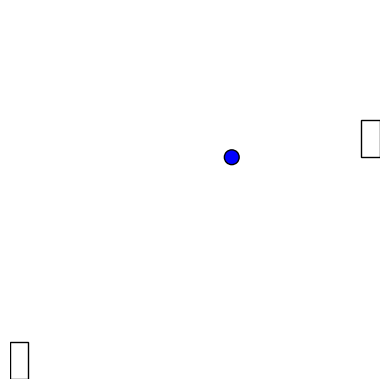

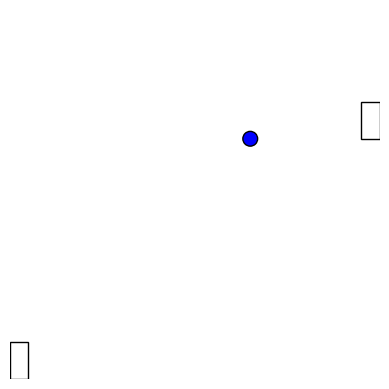

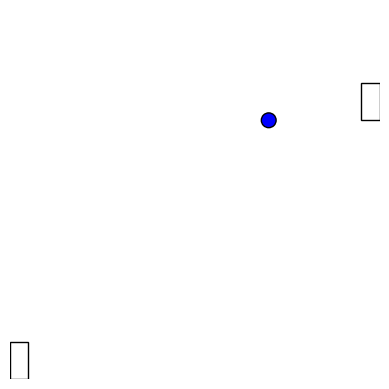

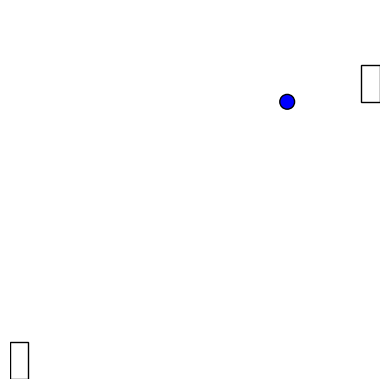

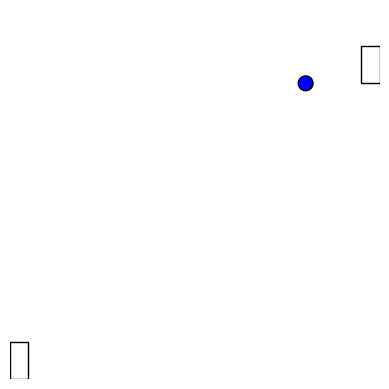

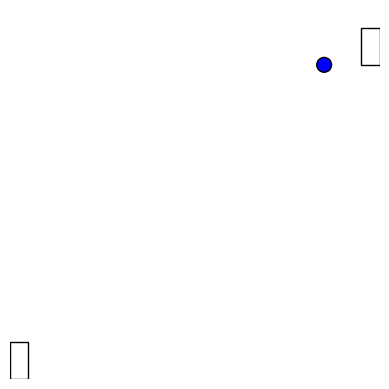

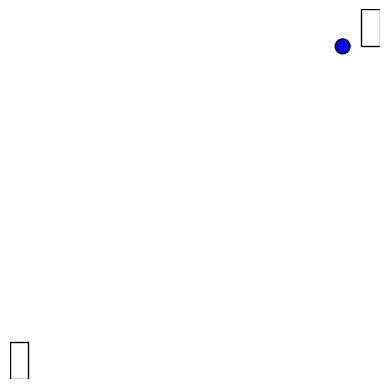

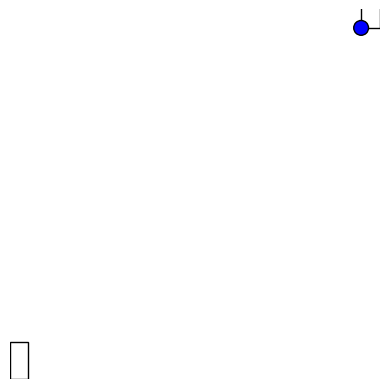

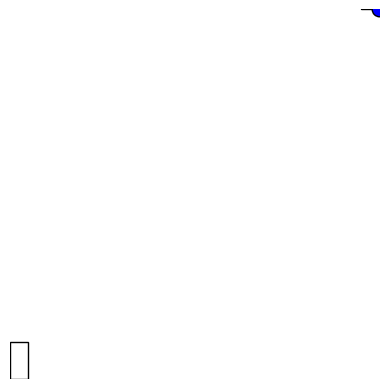

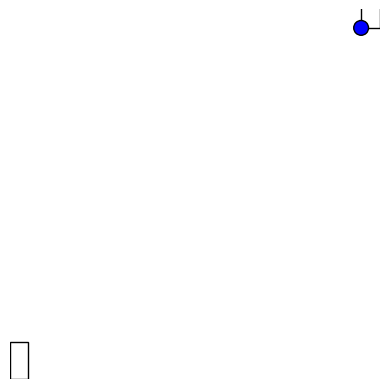

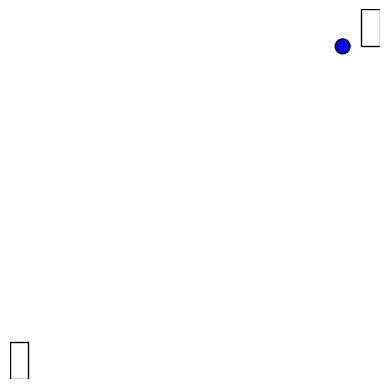

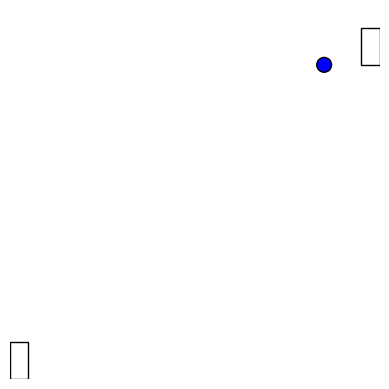

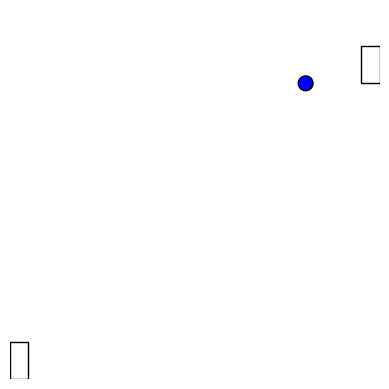

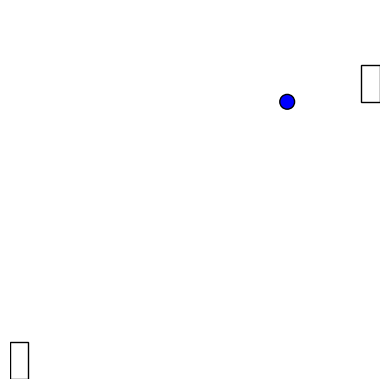

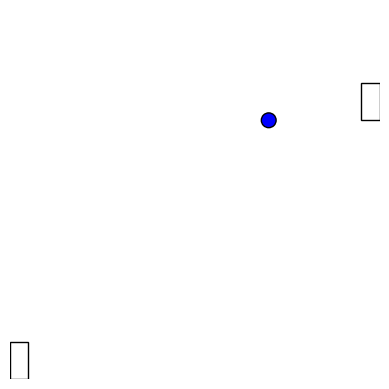

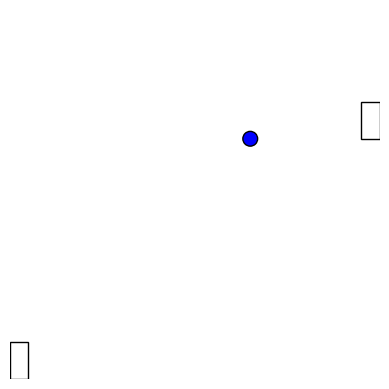

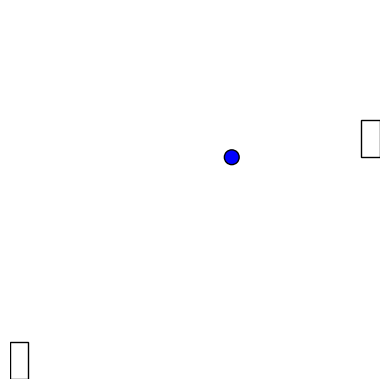

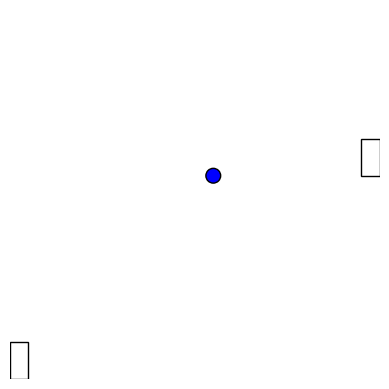

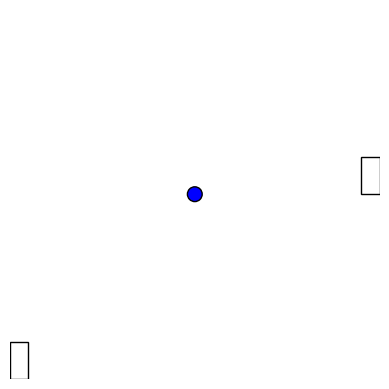

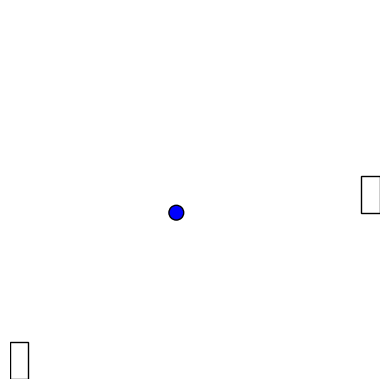

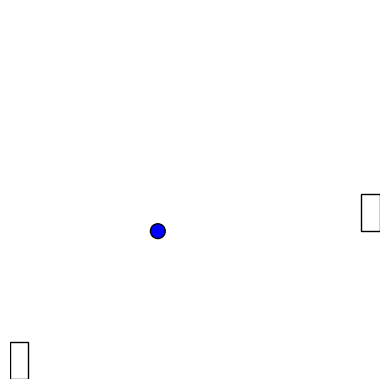

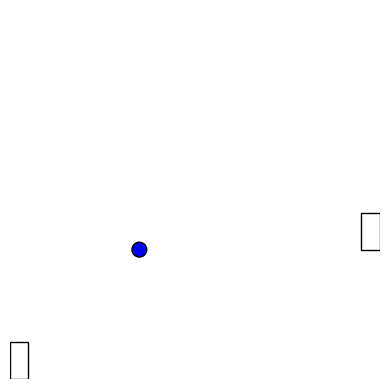

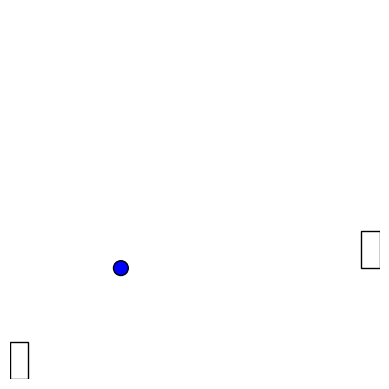

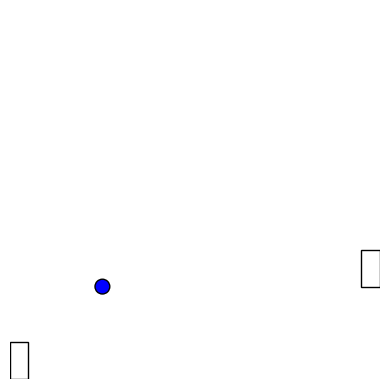

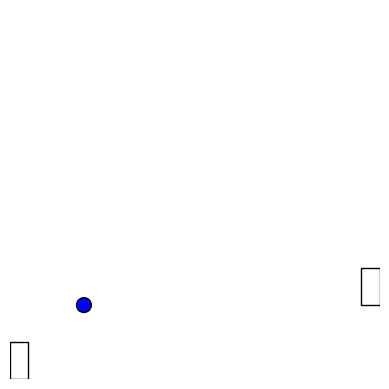

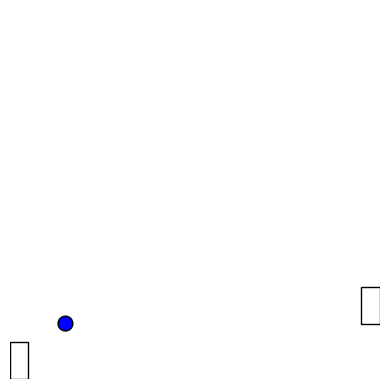

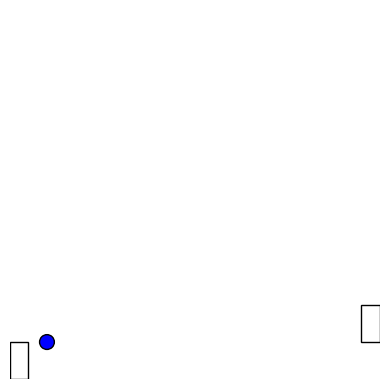

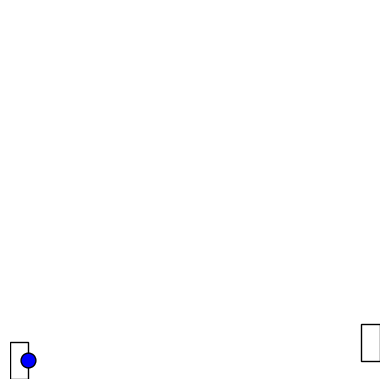

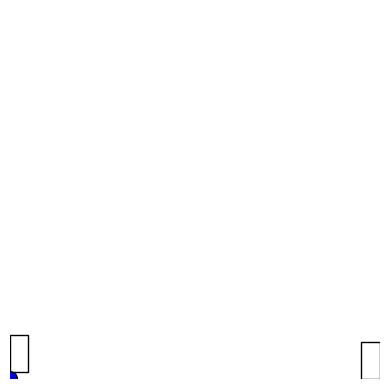

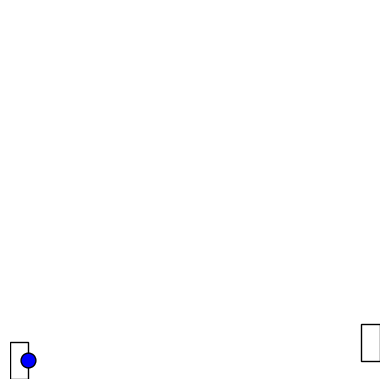

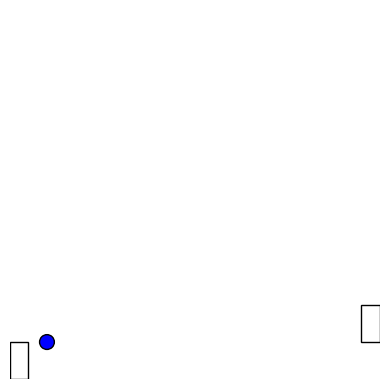

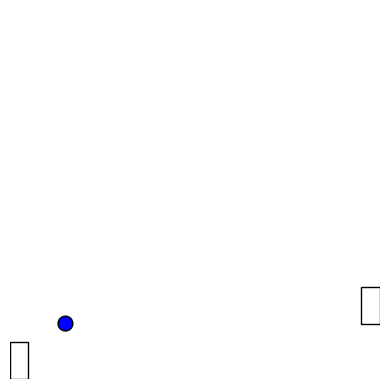

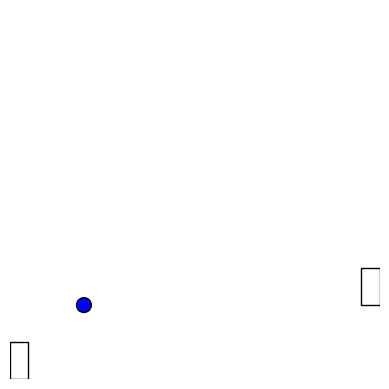

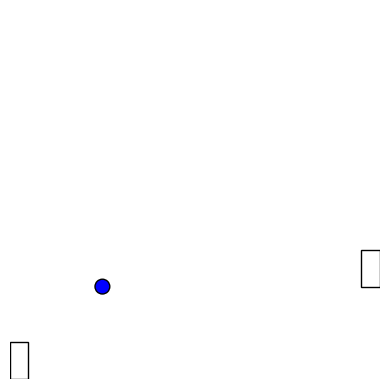

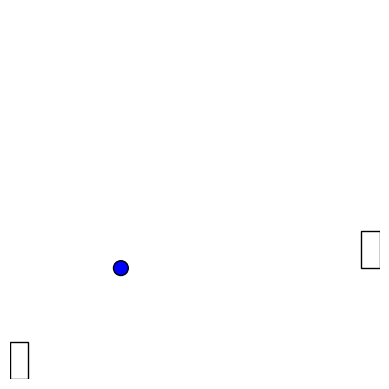

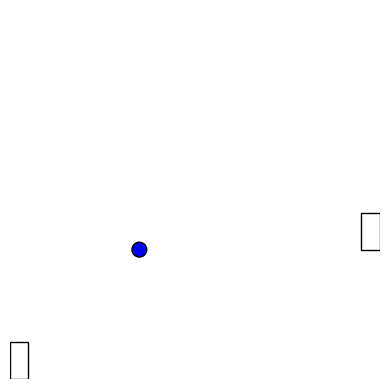

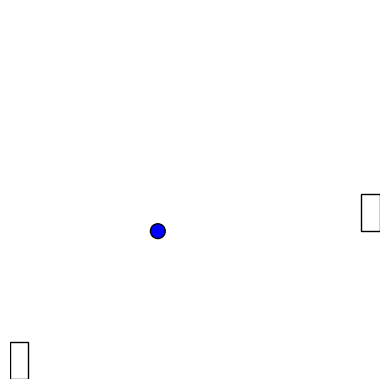

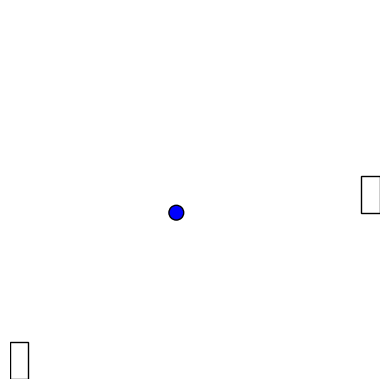

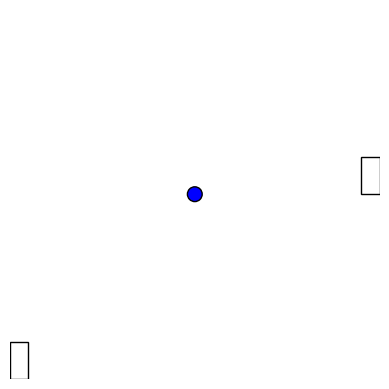

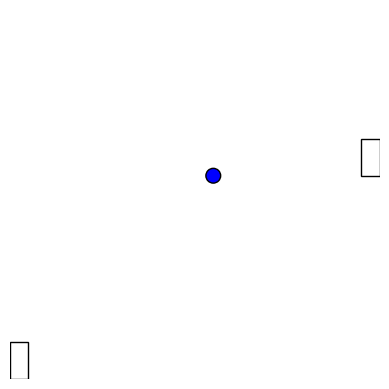

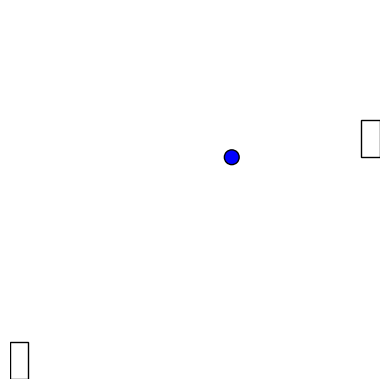

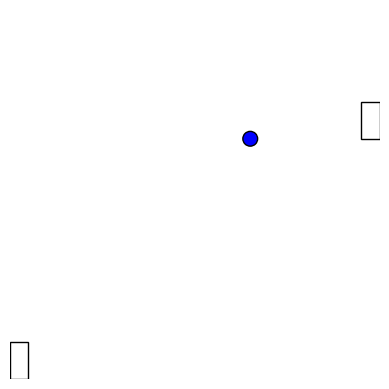

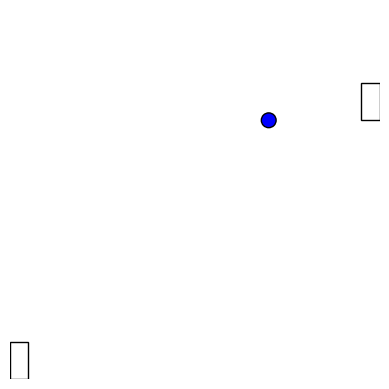

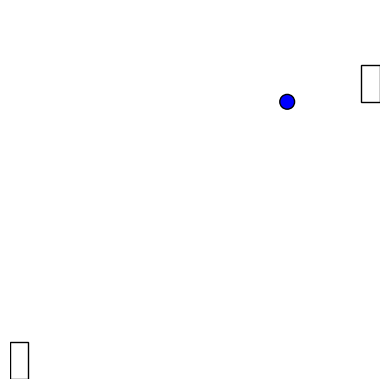

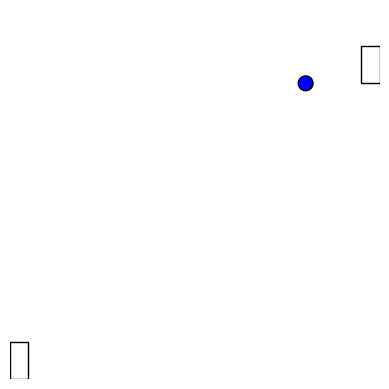

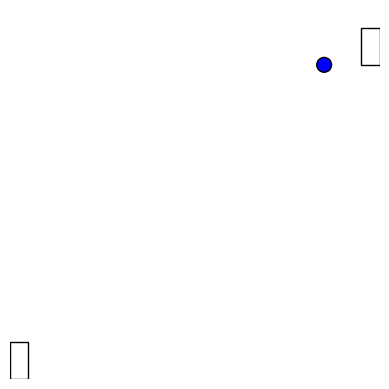

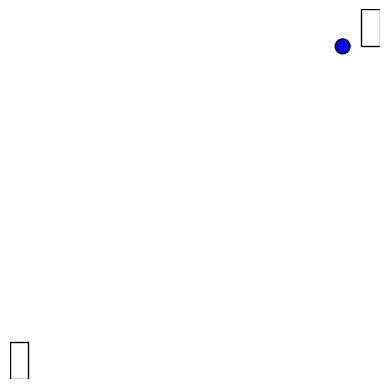

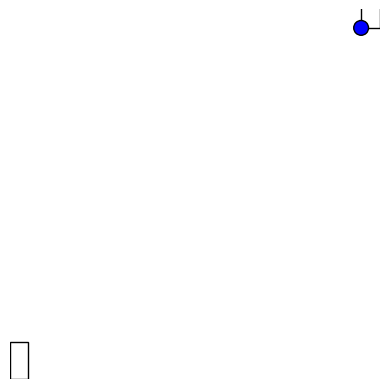

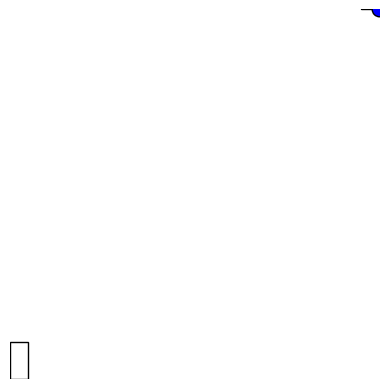

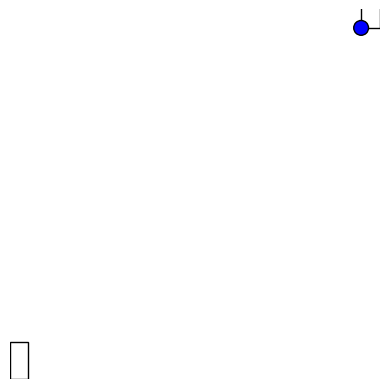

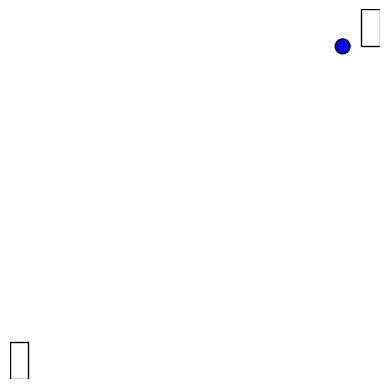

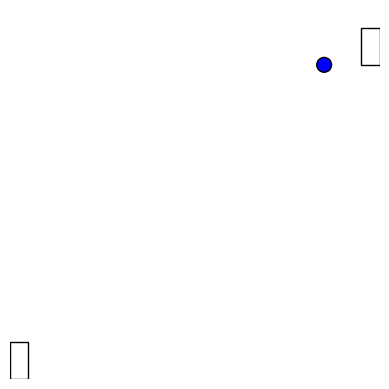

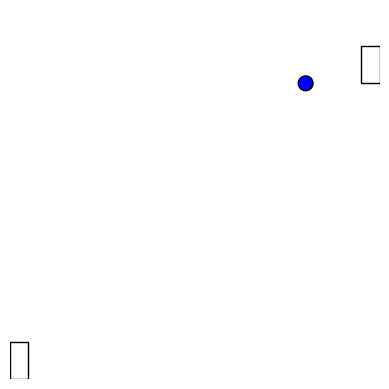

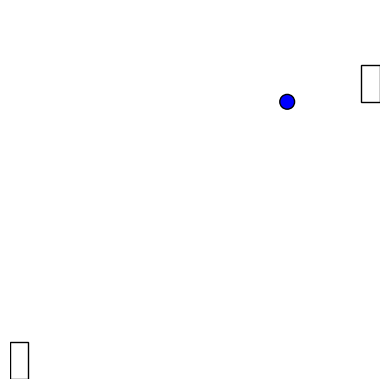

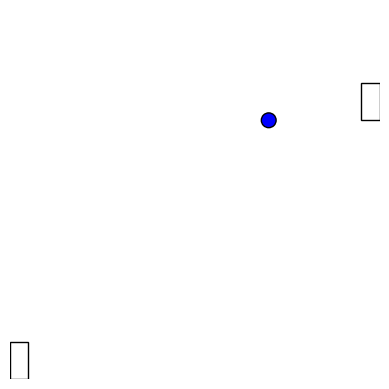

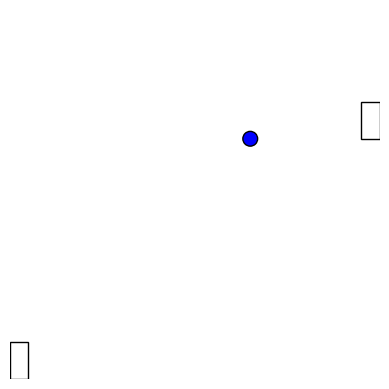

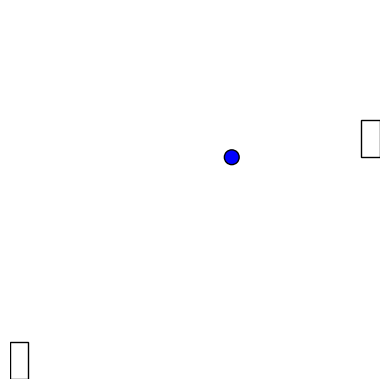

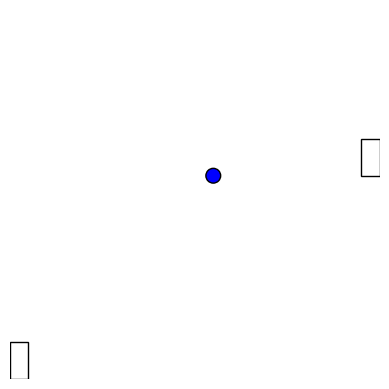

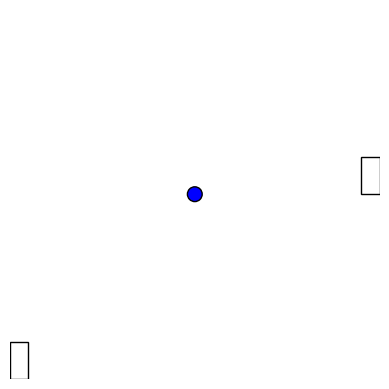

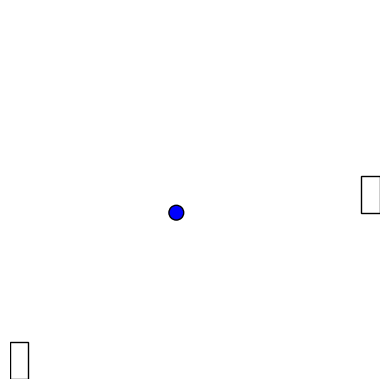

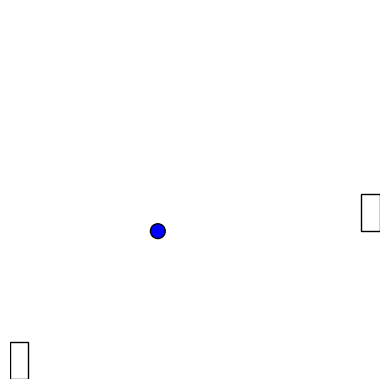

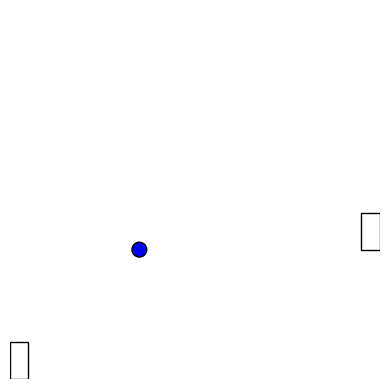

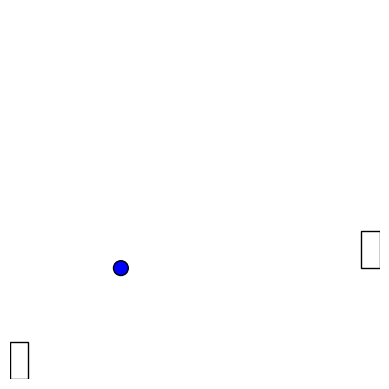

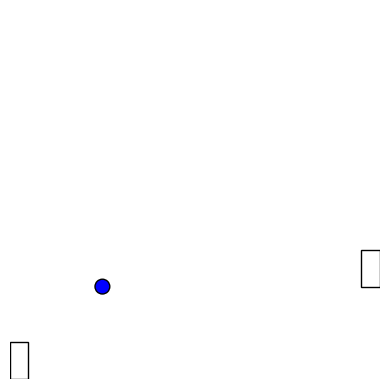

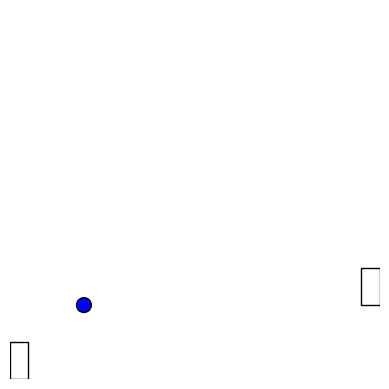

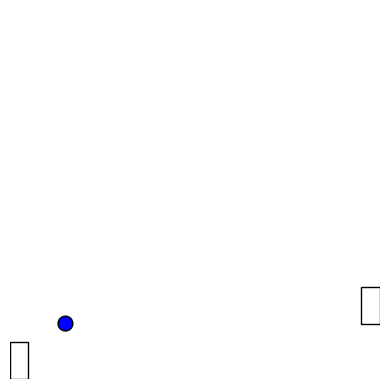

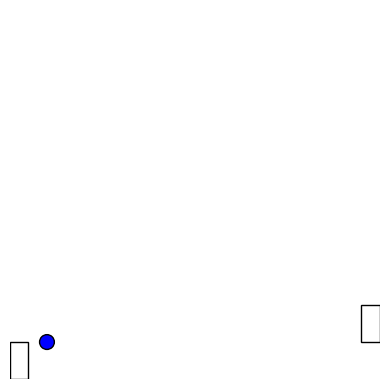

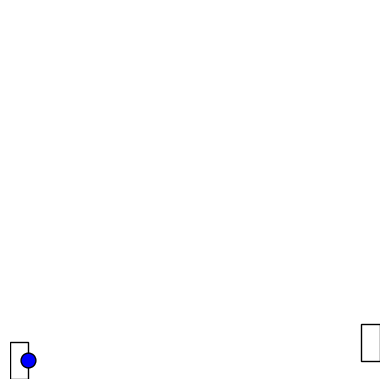

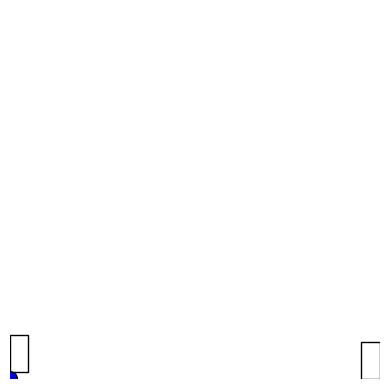

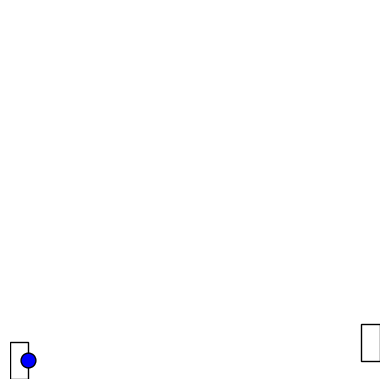

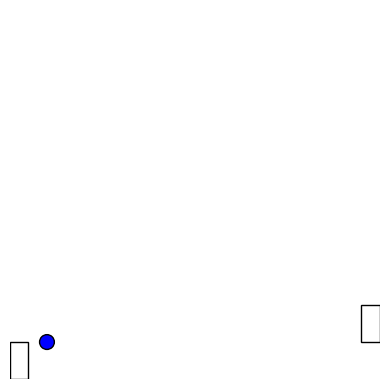

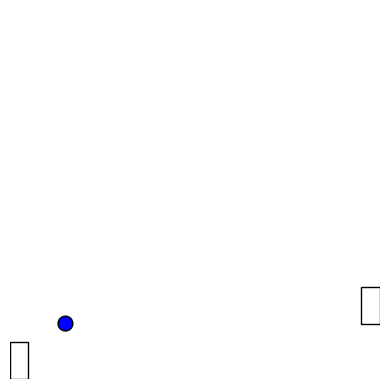

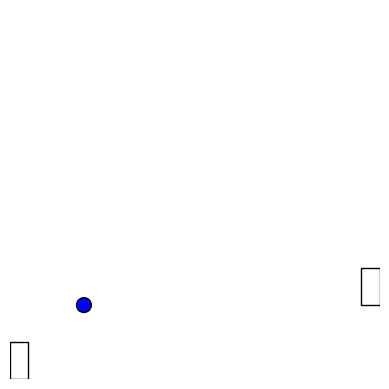

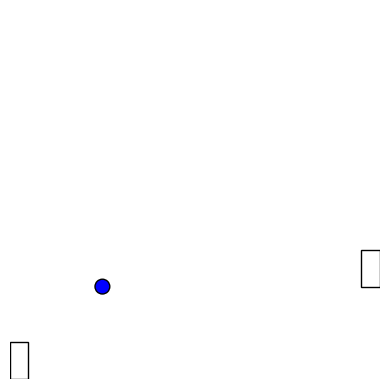

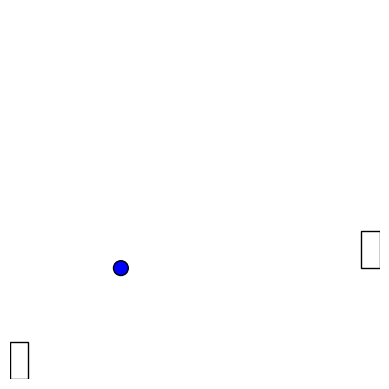

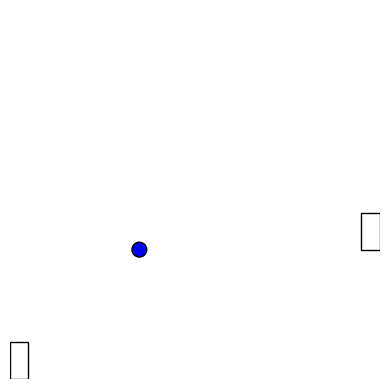

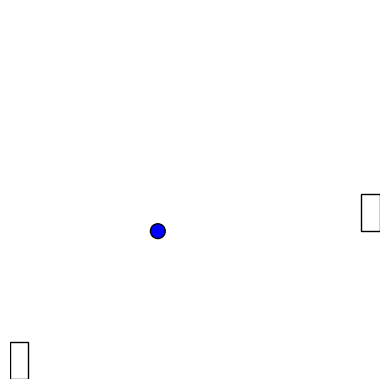

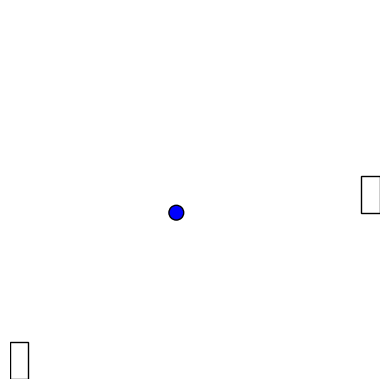

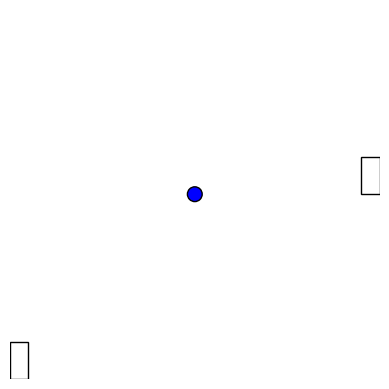

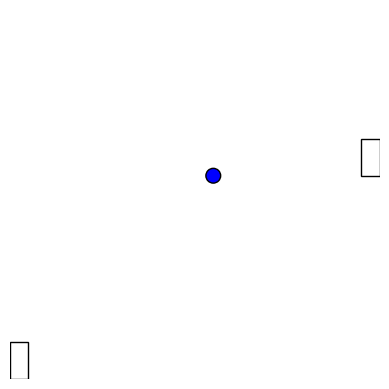

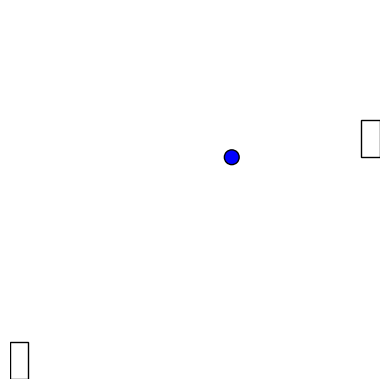

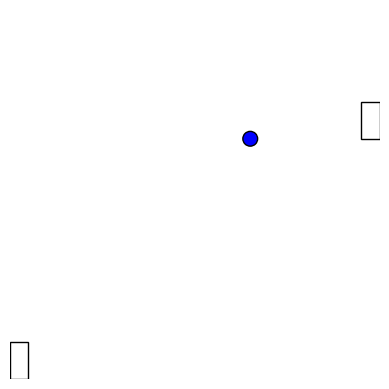

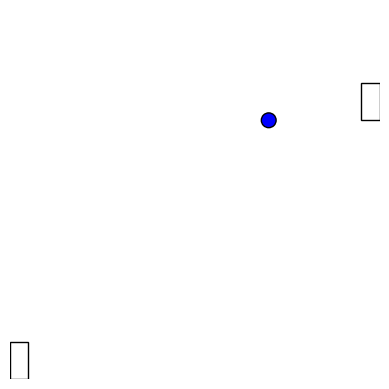

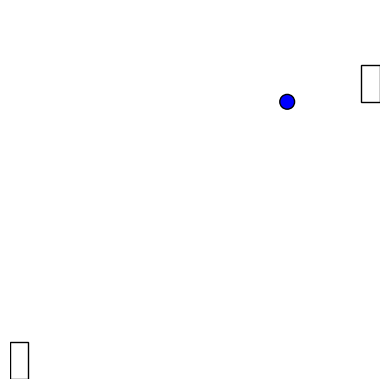

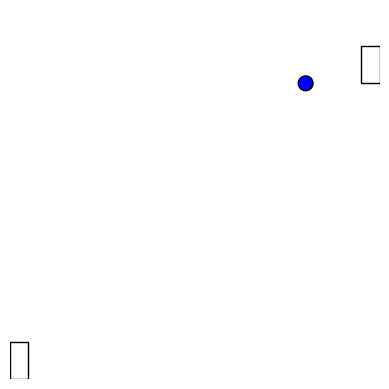

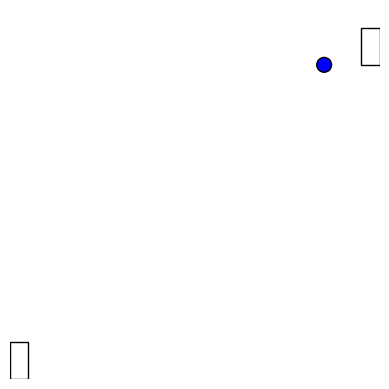

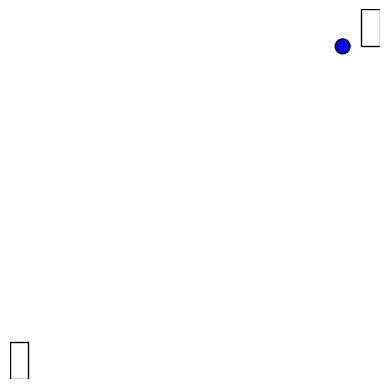

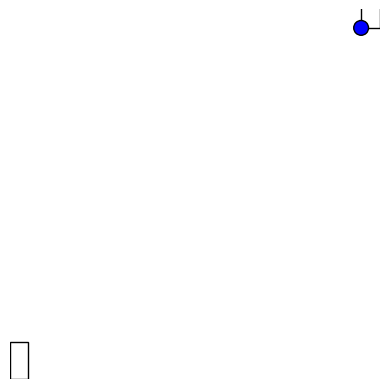

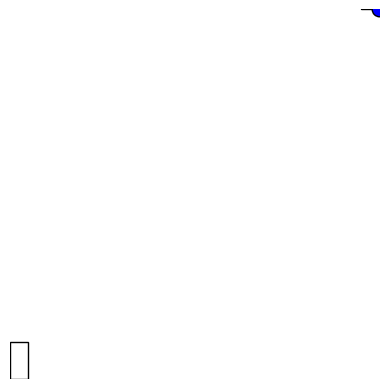

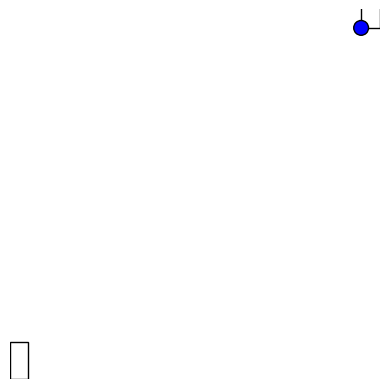

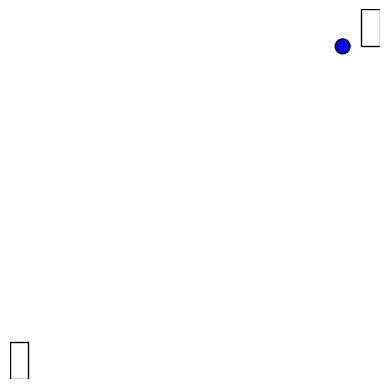

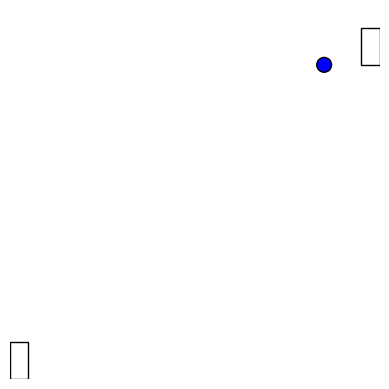

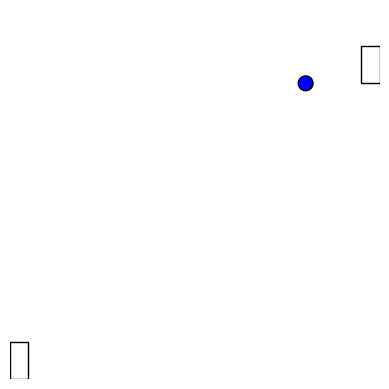

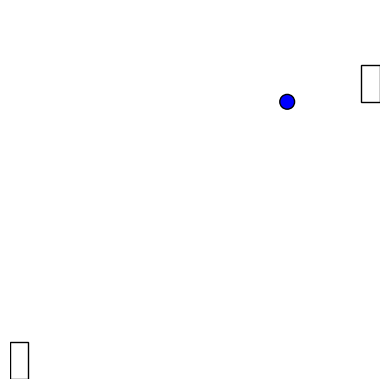

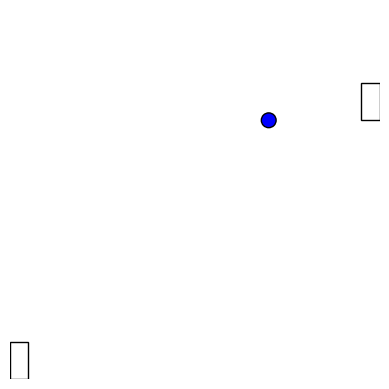

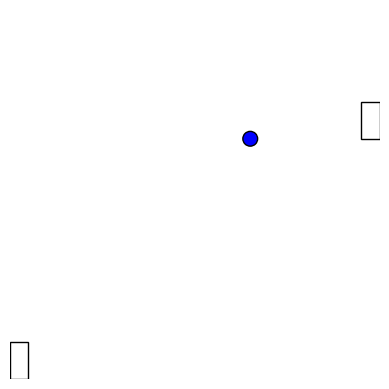

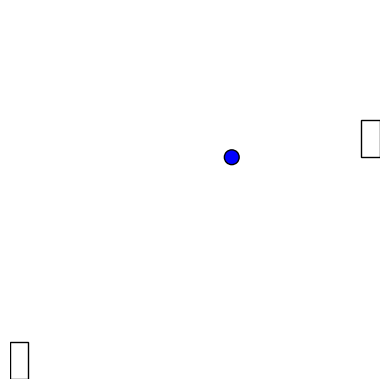

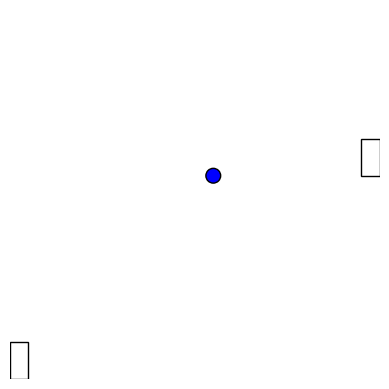

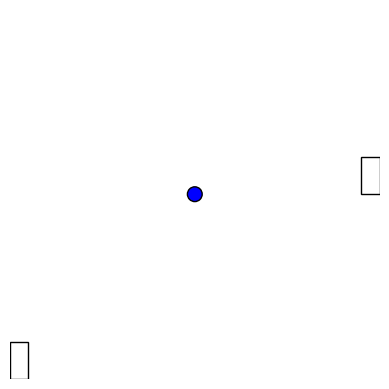

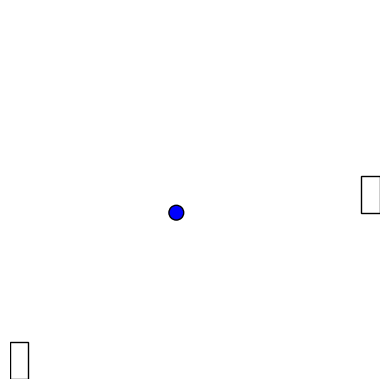

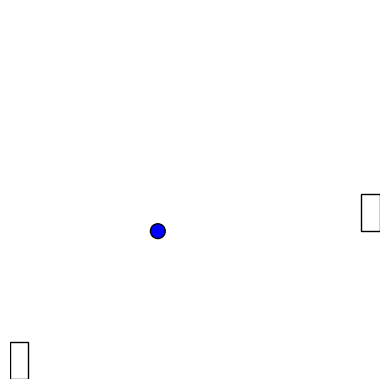

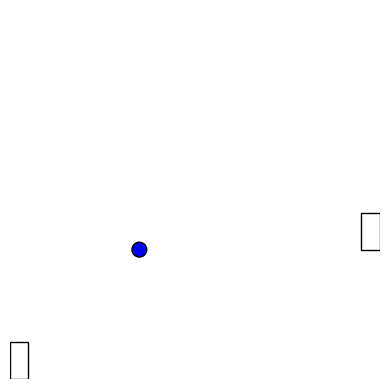

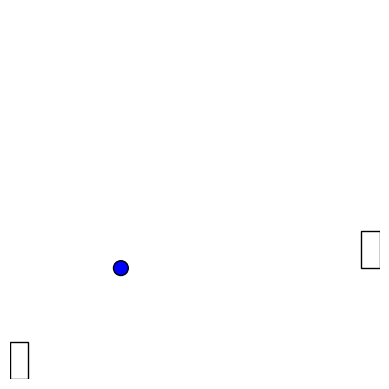

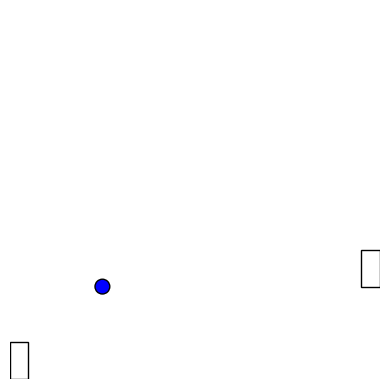

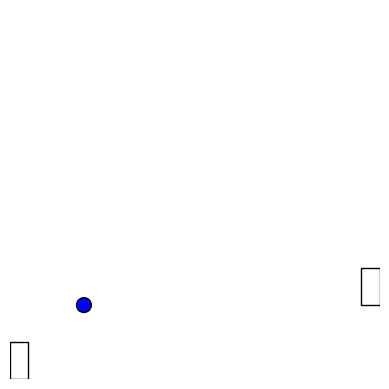

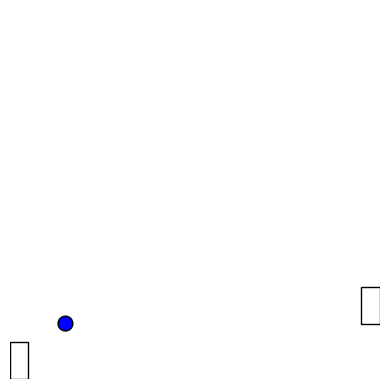

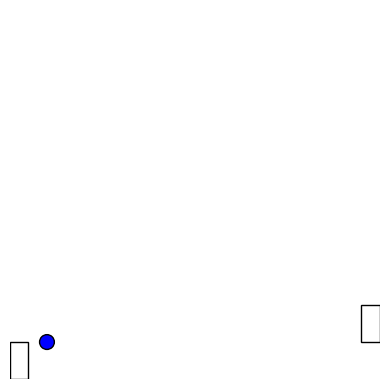

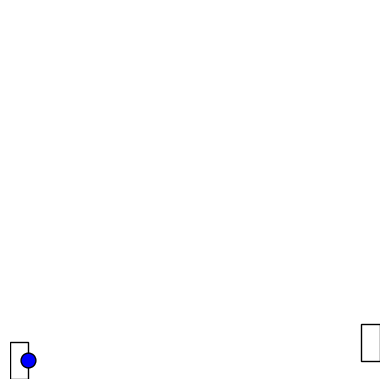

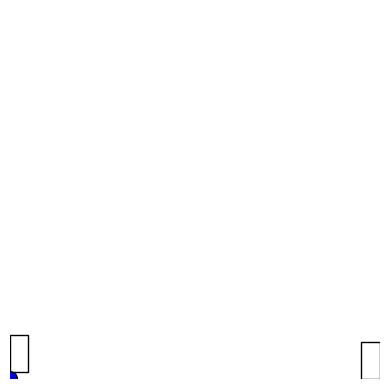

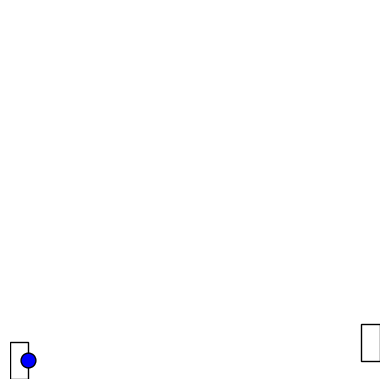

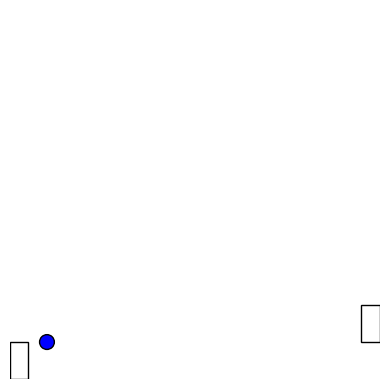

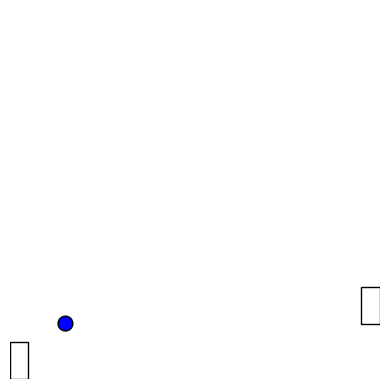

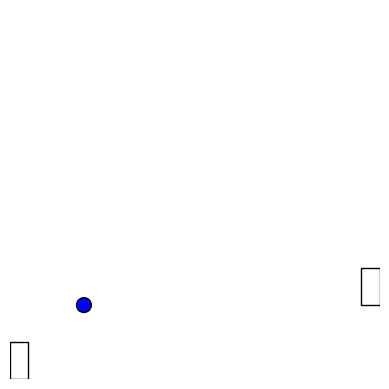

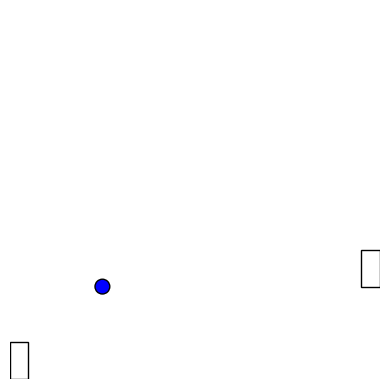

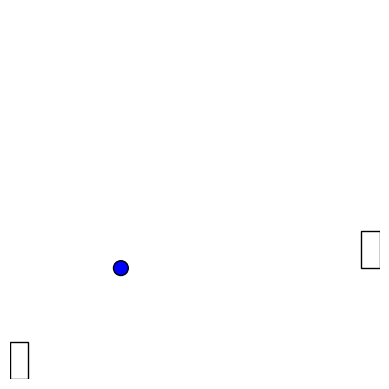

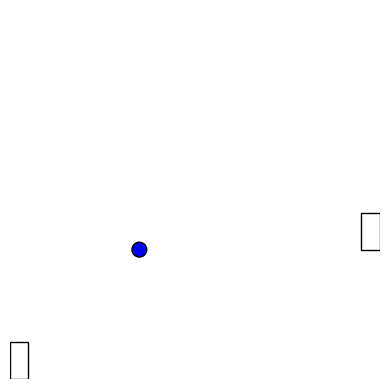

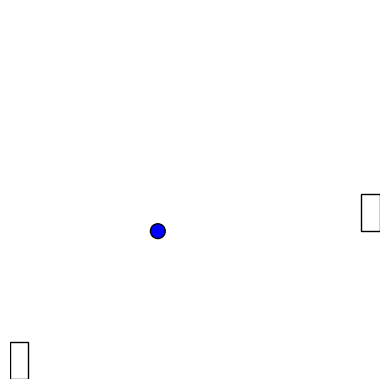

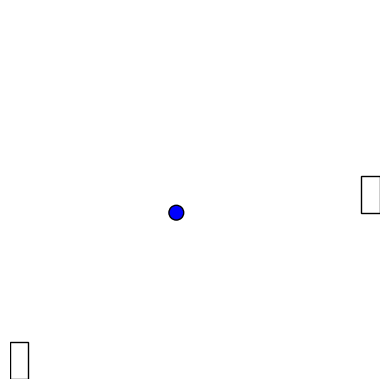

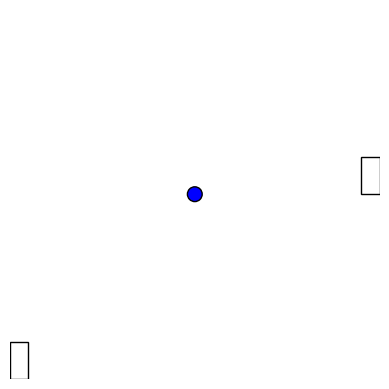

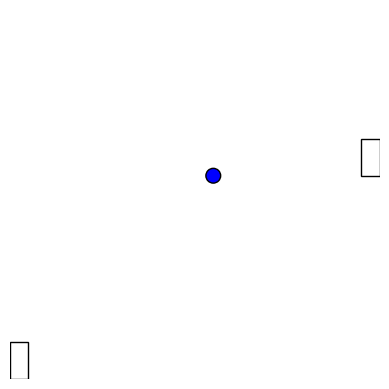

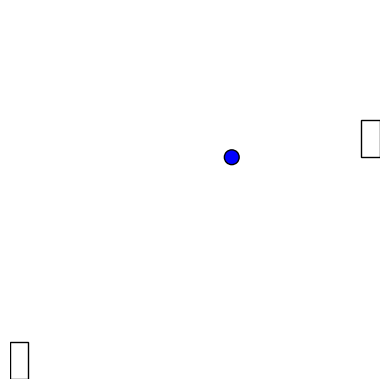

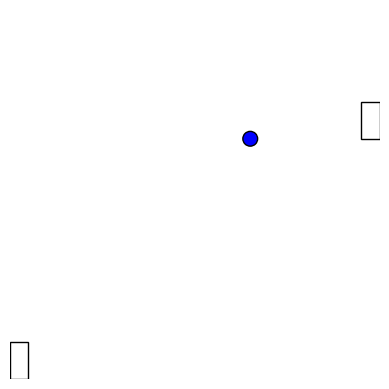

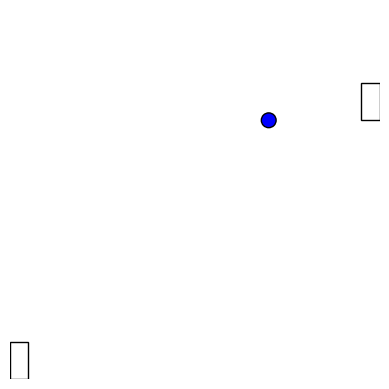

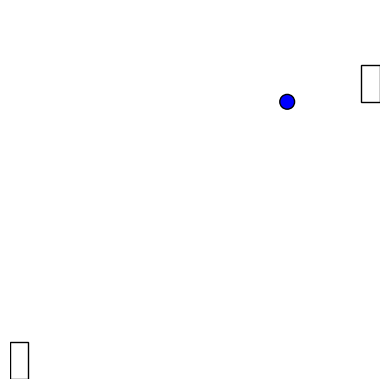

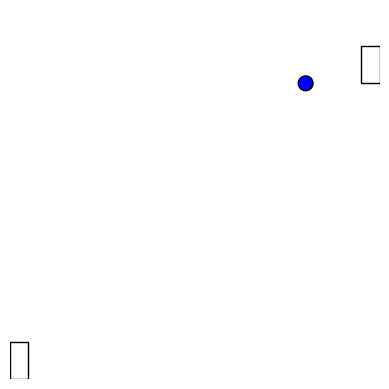

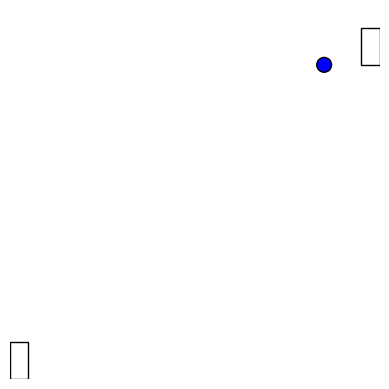

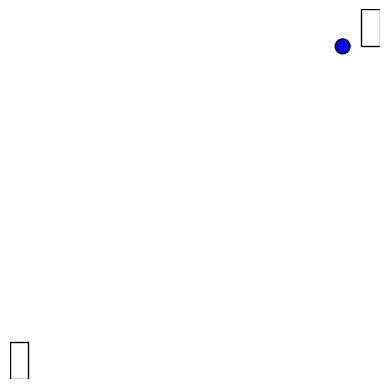

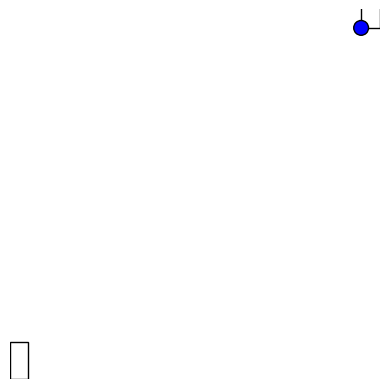

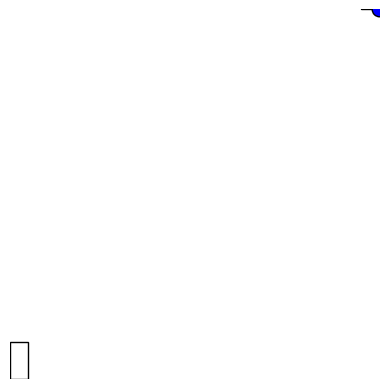

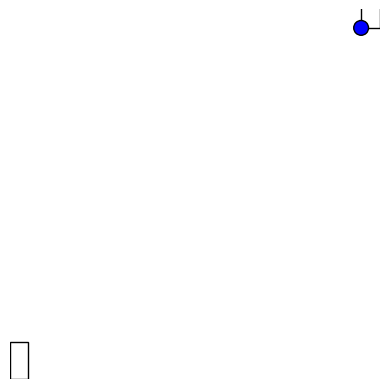

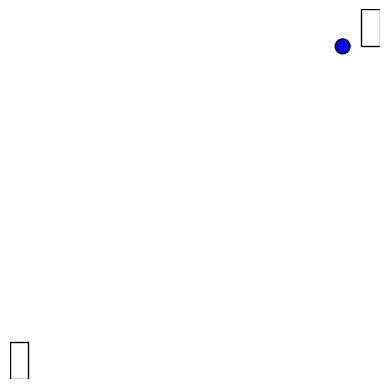

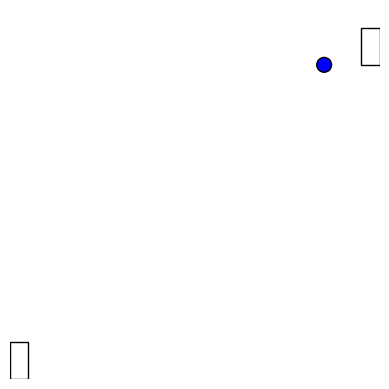

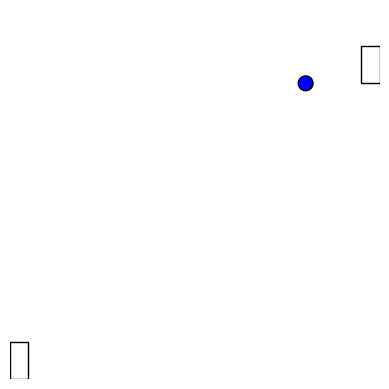

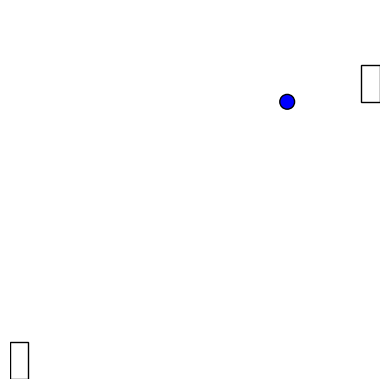

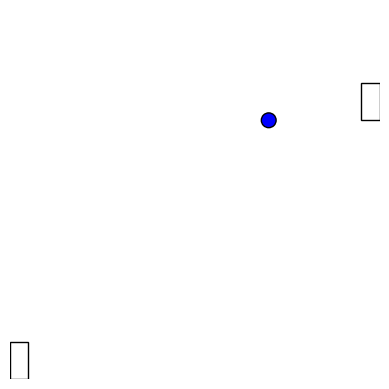

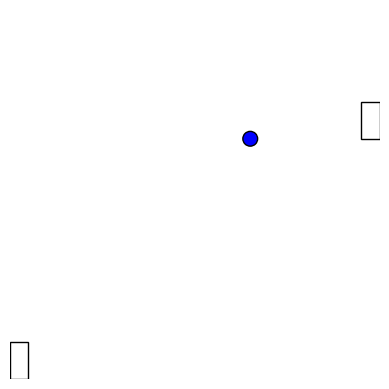

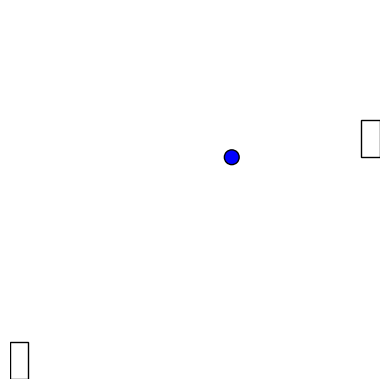

KeyboardInterrupt: 

In [60]:
def watch_game(env, model):

    obs, info = env.reset()

    # Get actions until game over
    done, truncated = False, False
    while not (done or truncated):
        action, _state = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        env.render()

watch_game(env, model)

In [43]:
def eval_pol(env, model, n_evals):

    successes = 0
    for i_eval in range(n_evals):
        obs, info = env.reset()
        
        # Get actions until game over
        done, truncated = False, False
        while not (done or truncated):
            action, _state = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
        if info['message'] == 'success':
            successes += 1
    score = successes/n_evals
    return score

score = eval_pol(env, model, 100)
print(score)

1.0
